# code adapte from

code adpate from from code/MNF/notebooks/STRING_Data_11.5/deimos_identifyNovelPPI_phylumeffect_allEcoliPPI_visulization_fullHomologous_oneBestHomologousPP.ipynb

# load lib and set data 

In [1]:
import sys
import os 
from pathlib import Path
import pandas as pd
import numpy as np 
import copy 
import random
from random import shuffle
from collections import defaultdict
import itertools
import pickle
import glob
import re

import multiprocessing as mp 
import subprocess

import matplotlib.pyplot as plt 
import seaborn as sns

from Bio import AlignIO
from Bio import SeqIO
from Bio.Blast import NCBIXML


from Bio.PDB import PDBParser

import networkx as nx

from scipy.stats import ttest_ind

# import pkg_resources



In [2]:
%reload_ext autoreload
%autoreload 2


here need to change new repository 
sys.path.append('/mnt/mnemo5/tao/code/MNF/src/tao_utilities/') # /mnt/mnemo5/tao/code/MNF/src/tao_utilities/,/home/cluster/tfang/MNF/src/tao_utilities/

from ROC_curve import DCA_RocCurve
from ROC_curve import Random_RocCurve
from ROC_curve import Precison_Recall_RocCurve_OnIndepedentBenchmark
from ROC_curve import Precison_Recall_RocCurve
from ROC_curve import Precison_Recall_RocCurve_OnlyGetRecallAndPrecision_OnIndepedentBenchmark

from Check_SameCogPair_problem import sepCogPairs_topDCAs_results


# from IntergrateBestHomologousPPCoEvo_unNameSorted import getMetaFrame_withHighDCA


from IntergrateBestHomologousPPCoEvo_top5_unNameSorted import get_QueryInfo_top5DCAs_FullBestHomologousPP
from IntergrateBestHomologousPPCoEvo_top5_unNameSorted import get_BestHomologousDCAs_top5DCAs_fromMultiSpes
from IntergrateBestHomologousPPCoEvo_unNameSorted import sepCogPairs_FullBestHomologousPP_BestHomologousDCAs_uniquePhyla_ML_predictions

from biasCheck import get_PPIwithTwoRibosomes_OnlyTest
from biasCheck import isStringProIDs_Ribosome
from biasCheck import isStringProIDs_oneRibosome
from biasCheck import isStringProIDs_twoRibosome
# from biasCheck import removeTrainPPfrom_allPredictionResults
from biasCheck import KeepSameNegPP_removeOtherPPfrom_allPredictionResults
from biasCheck import KeepCertainPPfrom_allPredictionResults
from biasCheck import getAllIdxOf_fixed_negVSpos_ratio_keepCombination
from biasCheck import getAllIdxOf_fixed_negVSpos_ratio_keepCombination_from_OriginalFrame
from biasCheck import removeTrainPPfrom_allPredictionResults_ByRemovedPosRatio



from collect_topCoEvos import get_topRanking_CoEvo_file
from collect_topCoEvos import sepCogPairs_ML_predictions_allTypeFeas


from coevolution_nomorlization import  get_idx2protein_dict
from coevolution_nomorlization import  get_proteinLevel_pairwise_matrix_full
from coevolution_nomorlization import proteinLevel_APC
from coevolution_nomorlization import get_topRankingRecordsFromMatrix_list


from pdb_benchmark import get_STRING1105_pdb_interact
from pdb_benchmark import add_pdbstatus_fromPureFrame  
from pdb_benchmark import add_pdbstatus

from STRING_benchmark import  get_STRING1105_physical_interact
from STRING_benchmark import  add_STRINGPhyPPI_status

from OtherPPI_benchmark import get_QianCong_benchmark


from parse_AlphaFold_output import get_interprotein_contactprob_from_processedalphafoldnpz
from parse_AlphaFold_output import get_interprotein_maxcontactprob_from_processedalphafoldnpz
from parse_AlphaFold_output import get_interprotein_mincm_from_pdb
from parse_AlphaFold_output import get_ptm_from_scoreFile

from plotting_utilities import check_PPIDist_inGraph

In [ ]:
reverser subject and query later 

In [5]:
colab_outputPath="/mnt/mnemo6/tao/colabfold_PPI_Coevolution/CoEvo_data_STRING11.5/EggNog_511145_EggNOGmaxLeve1224/"

In [6]:
Subject_tuple=('1224', '511145')
Query_tupleList=[("1239","1274374"),('201174', '105422'), ('976', '411476'),] #[('1224', '287'),("1239","1274374"),('201174', '105422'), ('976', '411476'),]


In [7]:
CoEvo_data_folder="/mnt/mnemo6/tao/PPI_Coevolution/CoEvo_data_STRING11.5/" #"/mnt/mnemo6/tao/PPI_Coevolution/CoEvo_data_STRING11.5/",/net/cephfs/shares/von-mering.imls.uzh/tao/PPI_Coevolution/CoEvo_data_STRING11.5/
Subject_input_root_folder=CoEvo_data_folder+"allPPI_"+Subject_tuple[1]+"_EggNOGmaxLevel"+Subject_tuple[0]+"_eggNOGfilteredData/"
Subject_Benchmark_folder=Subject_input_root_folder+"AllPPI_Benchmark/"
Subject_ML_inputPath=Subject_Benchmark_folder+"ML_inputs/"

Subject_DCA_coevolutoin_path=Subject_input_root_folder+"coevolutoin_result_DCA/"

print(f"Subject_Benchmark_folder:{Subject_Benchmark_folder}")
print(f"Subject_DCA_coevolutoin_path:{Subject_DCA_coevolutoin_path}")


Subject_Benchmark_folder:/mnt/mnemo6/tao/PPI_Coevolution/CoEvo_data_STRING11.5/allPPI_511145_EggNOGmaxLevel1224_eggNOGfilteredData/AllPPI_Benchmark/
Subject_DCA_coevolutoin_path:/mnt/mnemo6/tao/PPI_Coevolution/CoEvo_data_STRING11.5/allPPI_511145_EggNOGmaxLevel1224_eggNOGfilteredData/coevolutoin_result_DCA/


In [8]:
if not os.path.exists(Subject_Benchmark_folder):
    os.makedirs(Subject_Benchmark_folder)


In [9]:
Subject_Benchmark_folder

'/mnt/mnemo6/tao/PPI_Coevolution/CoEvo_data_STRING11.5/allPPI_511145_EggNOGmaxLevel1224_eggNOGfilteredData/AllPPI_Benchmark/'

In [10]:

pdb_interact_PPs,pdb_complex_PPs=get_STRING1105_pdb_interact(pdb_interact_filename="/mnt/mnemo6/damian/STRING_derived_v11.5/pdb/pdb_interact.tsv",
                                retrieve_spe=511145,)



pdb_interact_PPs_dict={pp: 1 for pp in pdb_interact_PPs}
pdb_complex_PPs_dict={pp: 1 for pp in pdb_complex_PPs}
pdb_PPs_dict={pp: 1 for pp in pdb_interact_PPs+pdb_complex_PPs}

print(len(pdb_interact_PPs),len(pdb_complex_PPs),len(pdb_PPs_dict))


print(len(set(pdb_interact_PPs).intersection(pdb_complex_PPs)))

print(len(set(pdb_interact_PPs).union(pdb_complex_PPs)))

len of intersection: 309
414 3243 3657
0
3657


In [11]:
STRINGcurrentSpeAllPhyPPI_posPPI_dict=get_STRING1105_physical_interact(data_folder="/mnt/mnemo6/damian/STRING_derived_v11.5/download_files/protein.physical.links.v11.5/",
                                retrieve_spe=511145,
                                combined_score_thres=0)
print(len(STRINGcurrentSpeAllPhyPPI_posPPI_dict))

STRINGcurrentSpePhyPPI_posPPI_dict=get_STRING1105_physical_interact(data_folder="/mnt/mnemo6/damian/STRING_derived_v11.5/download_files/protein.physical.links.v11.5/",
                                retrieve_spe=511145,
                                combined_score_thres=500)
print(len(STRINGcurrentSpePhyPPI_posPPI_dict))




STRINGcurrentSpePhyPPI_benchmark.shape: (53300, 3)
STRINGcurrentSpePhyPPI_benchmark.shape: (53300, 3)
53300
STRINGcurrentSpePhyPPI_benchmark.shape: (53300, 3)
STRINGcurrentSpePhyPPI_benchmark.shape: (15476, 3)
15476


In [12]:

# read protein name file 
ecoli_proteinNames=pd.read_csv("/mnt/mnemo6/tao/PPI_Coevolution/STRING_data_11.5/511145.protein.info.v11.5.txt.gz",
                            #"/mnt/mnemo5/tao/STRING/511145.protein.info.v11.0.txt",
                              header=0,index_col=None, sep="\t")


print(ecoli_proteinNames.shape)
#ecoli_proteinNames.head(n=3)

#ecoli_proteinNames_dict=dict(ecoli_proteinNames.loc[:,["protein_external_id","preferred_name"]].values.tolist())
ecoli_proteinNames_dict=dict(ecoli_proteinNames.loc[:,["#string_protein_id","preferred_name"]].values.tolist())

ecoli_proteinNames.head(n=3)


(4127, 4)


#string_protein_id preferred_name  protein_size  \
0       511145.b0001           thrL            21   
1       511145.b0002           thrA           820   
2       511145.b0003           thrB           310   

                                          annotation  
0  This protein is involved in control of the bio...  
1  In the C-terminal section; belongs to the homo...  
2  Catalyzes the ATP-dependent phosphorylation of...

In [13]:
%%time 
# this is a reversed file alread :(p1,p2),(p2,p1)
Ecoli_string_score_filename="/mnt/mnemo6/tao/PPI_Coevolution/STRING_data_11.5/"+"511145.protein.links.detailed.v11.5.txt.gz"

Ecoli_string_score=pd.read_csv(Ecoli_string_score_filename,
                               header=0,index_col=None,sep=" ")
Ecoli_string_score_list=Ecoli_string_score.loc[:,["protein1","protein2","combined_score"]].values.tolist()
Ecoli_string_score_dict=dict([((p1,p2),s)for p1, p2, s in Ecoli_string_score_list])

print(Ecoli_string_score.shape)

(1083186, 10)
CPU times: user 1.86 s, sys: 95.5 ms, total: 1.96 s
Wall time: 2 s


# benchmark data preparation 

STRING_ID1      STRING_ID2      benchmark_status        maxBetDCA_score maxBetMI_score  len1    len2
511145.b0009    511145.b1727    P       1.1808  0.0895  154     219
511145.b0014    511145.b0015    P       1.7117  0.1054  638     372
511145.b0014    511145.b0055    P       1.0218  0.1133  638     256
511145.b0014    511145.b0095    P       0.9895  0.1175  638     380
511145.b0014    511145.b0383    P       0.9454  0.0406  638     367
511145.b0014    511145.b0436    P       0.7624  0.1176  638     431


as for all PPI , i didnt caculate for MI and DCA together , so we dont have this format of benchmark already 

here prepare it , column  maxBetDCA_score maxBetMI_score could be omitted  ?
lengh information are important to extract DCAs
but benchmark_status now we dont know for negative ones ?
also for all PPI , we are not suppose to know benchmakr information

## for subject species 

In [14]:
# %%time 
# run once 
# Subject_existed_pydcaFNAPC_files=glob.glob(Subject_DCA_coevolutoin_path+"*_pydcaFNAPC_array.npz")
# print(len(Subject_existed_pydcaFNAPC_files))
# print(Subject_existed_pydcaFNAPC_files[0:3])

# Subject_existed_pydcaFNAPC_files=[os.path.basename(f) for f in Subject_existed_pydcaFNAPC_files]
# Subject_existed_pydcaFNAPC_pps=[f.split("and") for f in Subject_existed_pydcaFNAPC_files]
# Subject_existed_pydcaFNAPC_pps=[(p1,p2[:-21]) for p1, p2 in Subject_existed_pydcaFNAPC_pps]

# newSTRING_rootFolder="/net/cephfs/shares/von-mering.imls.uzh/tao/PPI_Coevolution/STRING_data_11.5/"
# Subject_currentSpeMiddleDataPath=newSTRING_rootFolder+Subject_tuple[1]+"_EggNOGmaxLevel"+Subject_tuple[0]+"_MiddleData/"
# with open(Subject_currentSpeMiddleDataPath+'fasta_protein_lens_dict.pickle', 'rb') as handle:
#     Subject_fasta_protein_lens=pickle.load(handle) 

# Subject_existed_pydcaFNAPC_pps_info=[[p1,p2,Subject_fasta_protein_lens[p1],Subject_fasta_protein_lens[p2]] for p1 , p2 in Subject_existed_pydcaFNAPC_pps]
# print("len(Subject_existed_pydcaFNAPC_pps_info):",len(Subject_existed_pydcaFNAPC_pps_info))

# print("Subject_existed_pydcaFNAPC_pps_info[0:3]:",Subject_existed_pydcaFNAPC_pps_info[0:3])

# Subject_allPPI_allInfo_frame=pd.DataFrame(Subject_existed_pydcaFNAPC_pps_info,
#                                     columns=["STRING_ID1","STRING_ID2","len1","len2"]
#                                         )
# Subject_allPPI_allInfo_frame.head(n=3)


# Subject_allPPI_allInfo_frame.to_csv(Subject_Benchmark_folder+"allPPI_allInfo_frame.csv",header=True,index=None,sep="\t")



In [15]:

# Subject_allPPI_allInfo_frame=pd.read_csv(Subject_Benchmark_folder+"allPPI_allInfo_frame.csv",
#                                  header=0,index_col=None,sep="\t")
# print(Subject_allPPI_allInfo_frame.shape)
# Subject_allPPI_allInfo_frame.head(n=3)

In [16]:
# Subject_existed_pydcaFNAPC_pps_info=Subject_allPPI_allInfo_frame.values.tolist()


## for query species 

In [17]:
# %%time 
# run once 

# newSTRING_rootFolder="/net/cephfs/shares/von-mering.imls.uzh/tao/PPI_Coevolution/STRING_data_11.5/"

# # code similar also from http://localhost:8206/lab/workspaces/auto-n/tree/code/MNF/notebooks/STRING_Data_11.5/script_test_STRINGPhyBalancePhyla_phylumeffect_ComputeBestHomologousDCA.py
# for currentQuery_EggNOG_maxLevel ,  currentQuery_TaxID in Query_tupleList[0:3]:
#     print("*****************************")

#     input_root_folder=CoEvo_data_folder+currentQuery_TaxID+"_EggNOGmaxLevel"+currentQuery_EggNOG_maxLevel+"_eggNOGfilteredData/"
#     currentQuery_DCA_coevolutoin_path=input_root_folder+"coevolutoin_result_DCA/"

#     Subect_prefix="BestHomologousPPFor"+Subject_tuple[1]+"AtEggNOGmaxLevel"+Subject_tuple[0]+"_"
    
#     Benchmark_folder=input_root_folder+Subect_prefix+"STRINGPhyBalancePhyla_Benchmark/" # this read infomation of all ppi homologous pp,which is get from 
#     # #http://localhost:8206/lab/workspaces/auto-n/tree/code/MNF/notebooks/STRING_Data_11.5/Compute_allPPI_homologousPPDetection.ipynb
#     print(f"Benchmark_folder:{Benchmark_folder}")
    
#     Current_Query_Benchmark_folder=input_root_folder+Subect_prefix+"AllPPI_Benchmark/" # this is benchmark for all ppi homologous pp
#     print(f"Current_Query_Benchmark_folder:{Current_Query_Benchmark_folder}")
    
#     if not os.path.exists(Current_Query_Benchmark_folder):
#         os.makedirs(Current_Query_Benchmark_folder)


#     currentQueryMiddleDataPath=newSTRING_rootFolder+currentQuery_TaxID+"_EggNOGmaxLevel"+currentQuery_EggNOG_maxLevel+"_MiddleData/"    
#     print(currentQueryMiddleDataPath)
    
#     with open(currentQueryMiddleDataPath+'fasta_protein_lens_dict.pickle', 'rb') as handle:
#         currentQuery_fasta_protein_lens=pickle.load(handle)

#     print(len(currentQuery_fasta_protein_lens))
#     print(list(currentQuery_fasta_protein_lens.items())[0:3])

    
#     Current_Query_homologousPPs_beforeDCAcomputation_file=Benchmark_folder+"Current_Query_BestHomologousPPs_beforeDCAcomputation.pickle"
#     with open(Current_Query_homologousPPs_beforeDCAcomputation_file, 'rb') as handle:
#             Current_Query_homologousPPs=pickle.load(handle)
#     print("len(Current_Query_homologousPPs):",len(Current_Query_homologousPPs))
#     print(Current_Query_homologousPPs[0:3])
    
#     # this step can be omit, keep here just for checking 
#     currentQuery_existed_pydcaFNAPC_files=glob.glob(currentQuery_DCA_coevolutoin_path+"*_pydcaFNAPC_array.npz")
#     print("len(currentQuery_existed_pydcaFNAPC_files):",len(currentQuery_existed_pydcaFNAPC_files))
#     print(currentQuery_existed_pydcaFNAPC_files[0:3])
    
#     Current_Query_homologousPPs_info=[[p1,p2,currentQuery_fasta_protein_lens[p1],currentQuery_fasta_protein_lens[p2]] for p1 , p2 in Current_Query_homologousPPs ]
#     print("len(Current_Query_homologousPPs_info):",len(Current_Query_homologousPPs_info))

#     print("Current_Query_homologousPPs_info[0:3]:",Current_Query_homologousPPs_info[0:3])

#     Current_Query_homologousPPs_info_frame=pd.DataFrame(Current_Query_homologousPPs_info,
#                                         columns=["STRING_ID1","STRING_ID2","len1","len2"]
#                                             )
#     Current_Query_homologousPPs_info_frame.head(n=3)


#     Current_Query_homologousPPs_info_frame.to_csv(Current_Query_Benchmark_folder+"BestHomologousPP_allPPI_allInfo_frame.csv",header=True,index=None,sep="\t")
    
    



# prepare best homologous protein pp 

In [19]:
%%time 
#with open("/net/cephfs/shares/von-mering.imls.uzh/tao/PPI_Coevolution/CoEvo_data_STRING11.5/511145_EggNOGmaxLevel1224_eggNOGfilteredData/STRINPhyPPI_Benchmark/NameUnsorted_Subject2Query_SubSpeAllPPI_BestHomologous_ignoreQueryDCA_dict_listDict.pickle", 'rb') as handle:
with open("/mnt/mnemo6/tao/PPI_Coevolution/CoEvo_data_STRING11.5/511145_EggNOGmaxLevel1224_eggNOGfilteredData/STRINPhyPPI_Benchmark/NameUnsorted_Subject2Query_SubSpeAllPPI_BestHomologous_ignoreQueryDCA_dict_listDict.pickle", 'rb') as handle:
        Subject2Query_SubSpeAllPPI_BestHomologous_ignoreQueryDCA_dict_listDict=pickle.load(handle)
        


CPU times: user 1.62 s, sys: 280 ms, total: 1.9 s
Wall time: 2.15 s


In [20]:
for _,t_dict in Subject2Query_SubSpeAllPPI_BestHomologous_ignoreQueryDCA_dict_listDict.items():
    print(_)
    print(len(t_dict))
    count=0
    for v in t_dict.values():
        count += len(v)
    print(count,count/2)

('1239', '1274374')
1510551
3021102 1510551.0
('201174', '105422')
1598711
3197422 1598711.0
('976', '411476')
1229632
2459264 1229632.0
('2', '179408')
1269201
2538402 1269201.0


In [21]:
Subject2Query_SubSpeAllPPI_BestHomologous_ignoreQueryDCA_dict_listDict={k:v for k,v in Subject2Query_SubSpeAllPPI_BestHomologous_ignoreQueryDCA_dict_listDict.items() if k in smallPhylum_Query_tupleList+Query_tupleList }

Subject2Query_SubSpeAllPPI_BestHomologous_ignoreQueryDCA_dict_listDict.keys()

dict_keys([('1239', '1274374'), ('201174', '105422'), ('976', '411476')])

In [22]:
list(Subject2Query_SubSpeAllPPI_BestHomologous_ignoreQueryDCA_dict_listDict[('1239', '1274374')].items())[0]



(('511145.b0003', '511145.b0004'),
 ('1274374.CBLK010000071_gene1043', '1274374.CBLK010000070_gene1131'))

# STRING 11.5, phylum 1224, species 511145

this is Subject species 

!!!!
So we just use independent benchmark dataset without BestHomologous protein pairs to train machine leanring model


and here we dont know same cog pairs in training and testing dataset together 
code adpated from "MNF/notebooks/STRING_Data_11.5/Check_SameCogPair_problem.ipynb"


In [23]:

Subject_allPPI_allInfo_frame=pd.read_csv(Subject_Benchmark_folder+"allPPI_allInfo_frame.csv",
                                 header=0,index_col=None,sep="\t")
print(Subject_allPPI_allInfo_frame.shape)
Subject_allPPI_allInfo_frame.head(n=3)

(2269192, 4)


STRING_ID1    STRING_ID2  len1  len2
0  511145.b2547  511145.b4214   494   243
1  511145.b1913  511145.b3965   600   363
2  511145.b1771  511145.b2074   310   399

In [24]:
%%time 

Subject_allPPI_info=Subject_allPPI_allInfo_frame.loc[:,["STRING_ID1","STRING_ID2","len1","len2"]].values.tolist()

Subject_allPPI_allInfo_dict=dict([((p1,p2),(len1,len2)) for p1,p2,len1,len2 in Subject_allPPI_info])


# CPU times: user 2.1 s, sys: 361 ms, total: 2.46 s
# Wall time: 15.1 s


CPU times: user 3.03 s, sys: 336 ms, total: 3.37 s
Wall time: 3.37 s


In [25]:
Subject_topRanking_DCA_file=Subject_Benchmark_folder+"DCA_thres_"+str(0)+"_topRanking_pydcaFNAPC_frame.csv" 
print(Subject_topRanking_DCA_file)


/mnt/mnemo6/tao/PPI_Coevolution/CoEvo_data_STRING11.5/allPPI_511145_EggNOGmaxLevel1224_eggNOGfilteredData/AllPPI_Benchmark/DCA_thres_0_topRanking_pydcaFNAPC_frame.csv


In [26]:
Subject_Benchmark_folder

'/mnt/mnemo6/tao/PPI_Coevolution/CoEvo_data_STRING11.5/allPPI_511145_EggNOGmaxLevel1224_eggNOGfilteredData/AllPPI_Benchmark/'



module load hpc
conda activate py37_base
sbatch  /home/cluster/tfang/MNF/notebooks/ScienceCluster_code/STRING_Data_11.5/collect_allPPI_topDCAs.sh




In [27]:
%%time 

#if already run in in batch format, here dont need to recollect and rewrite results but just read alreayd saved results ?

Subject_top_DCA_dict=get_topRanking_CoEvo_file(topRanking_CoEvo_file=Subject_topRanking_DCA_file,
                                               coevolutoin_path=Subject_DCA_coevolutoin_path,
                                               coevo_suffix="_pydcaFNAPC_array",
                                               allPPI_info=Subject_allPPI_info, #, # [0:3] ,[0:1000],[0:10000]
                                               returnDic=True,
#                                                overwrite=True,
                                            overwrite=False,
                                            use_multiprocessing=10#False
                                              )

# top_CoEvo_frame.shape: (2269192, 152)
# sys.getsizeof(top_CoEvo_list)/(1024*1024*1024):0.016906864941120148
# CPU times: user 1min 21s, sys: 2min 48s, total: 4min 10s
# Wall time: 6min 3s


top_CoEvo_frame.shape: (2269192, 152)
sys.getsizeof(top_CoEvo_list)/(1024*1024*1024):0.016906864941120148
CPU times: user 48.9 s, sys: 6.62 s, total: 55.5 s
Wall time: 58.1 s


In [28]:
%%time
Subject_top_DCA_top5DCAs_dict={pp:[v[3*i] for i in range(5)] for pp, v in Subject_top_DCA_dict.items()}


CPU times: user 6.43 s, sys: 0 ns, total: 6.43 s
Wall time: 6.43 s


In [29]:
print(sys.getsizeof(Subject_top_DCA_top5DCAs_dict)/(1024*1024*1024))

0.07812509685754776


In [30]:
Subject_top_DCA_top5DCAs_dict[('511145.b2547', '511145.b4214')]

[0.7821, 0.7538, 0.7246, 0.7084, 0.6774]

# For Ecoli 11.5, get its top 5 DCA score from its BestHomologous pp from other speceis 



module load hpc
conda activate py37_base
sbatch  /home/cluster/tfang/MNF/notebooks/ScienceCluster_code/STRING_Data_11.5/collect_allPPI_FullBestHomologousPP_topDCAs.sh


In [31]:
%%time 
#if already run in in batch format, here dont need to recollect and rewrite results but just read alreayd saved results ?
BestHomologousPP_top5DCAs_Query_allPPI_allInfo_dict_listDict=get_QueryInfo_top5DCAs_FullBestHomologousPP(Subject_tuple,
                                      Query_tupleList,
                                      smallPhylum_Query_tupleList,
                                      STRING_version="11.5",
                                    coevo_suffix="_pydcaFNAPC_array",
                                      benchmark_suffix="AllPPI_Benchmark/",
                                    CoEvo_data_folder=CoEvo_data_folder,
                                      topDCA_num=5,
                                       returnDic=True,
#                                         overwrite=True,
                                        overwrite=False,
                                        #use_multiprocessing=False,
                                        use_multiprocessing=20,   #10,                                                     
                                            )



# 201174 105422 , raw date processing time 
# BestHomologousPP_Benchmark_folder: /net/cephfs/shares/von-mering.imls.uzh/tao/PPI_Coevolution/CoEvo_data_STRING11.5/105422_EggNOGmaxLevel201174_eggNOGfilteredData/BestHomologousPPFor511145AtEggNOGmaxLevel1224_AllPPI_Benchmark/
# allPPI_allInfo_frame.shape: (634253, 4)
# BestHomologousPP_Benchmark_folder:/net/cephfs/shares/von-mering.imls.uzh/tao/PPI_Coevolution/CoEvo_data_STRING11.5/105422_EggNOGmaxLevel201174_eggNOGfilteredData/BestHomologousPPFor511145AtEggNOGmaxLevel1224_AllPPI_Benchmark/
# DCA_coevolutoin_path:/net/cephfs/shares/von-mering.imls.uzh/tao/PPI_Coevolution/CoEvo_data_STRING11.5/105422_EggNOGmaxLevel201174_eggNOGfilteredData/coevolutoin_result_DCA/
# topRanking_pydcaFNAPC_file:/net/cephfs/shares/von-mering.imls.uzh/tao/PPI_Coevolution/CoEvo_data_STRING11.5/105422_EggNOGmaxLevel201174_eggNOGfilteredData/BestHomologousPPFor511145AtEggNOGmaxLevel1224_AllPPI_Benchmark/BestHomologousPP_topRanking_pydcaFNAPC_frame.csv
# topRanking_CoEvo_file: /net/cephfs/shares/von-mering.imls.uzh/tao/PPI_Coevolution/CoEvo_data_STRING11.5/105422_EggNOGmaxLevel201174_eggNOGfilteredData/BestHomologousPPFor511145AtEggNOGmaxLevel1224_AllPPI_Benchmark/BestHomologousPP_topRanking_pydcaFNAPC_frame.csv
# top_CoEvo_frame.shape: (634253, 152)
# len(top_pydcaFNAPC_dict): 634253
# len(Query_allPPI_allInfo_dict): 634253
# CPU times: user 2min 43s, sys: 7min 21s, total: 10min 5s
# Wall time: 2h 26min 13s


# 201174 105422 , time of only read data 
# around 1 minutes 


1239 1274374
BestHomologousPP_Benchmark_folder: /mnt/mnemo6/tao/PPI_Coevolution/CoEvo_data_STRING11.5/1274374_EggNOGmaxLevel1239_eggNOGfilteredData/BestHomologousPPFor511145AtEggNOGmaxLevel1224_AllPPI_Benchmark/
allPPI_allInfo_frame.shape: (513280, 4)
BestHomologousPP_Benchmark_folder:/mnt/mnemo6/tao/PPI_Coevolution/CoEvo_data_STRING11.5/1274374_EggNOGmaxLevel1239_eggNOGfilteredData/BestHomologousPPFor511145AtEggNOGmaxLevel1224_AllPPI_Benchmark/
DCA_coevolutoin_path:/mnt/mnemo6/tao/PPI_Coevolution/CoEvo_data_STRING11.5/1274374_EggNOGmaxLevel1239_eggNOGfilteredData/coevolutoin_result_DCA/
topRanking_pydcaFNAPC_file:/mnt/mnemo6/tao/PPI_Coevolution/CoEvo_data_STRING11.5/1274374_EggNOGmaxLevel1239_eggNOGfilteredData/BestHomologousPPFor511145AtEggNOGmaxLevel1224_AllPPI_Benchmark/BestHomologousPP_topRanking_pydcaFNAPC_frame.csv
top_CoEvo_frame.shape: (513280, 152)
sys.getsizeof(top_CoEvo_list)/(1024*1024*1024):0.003824301064014435
len(top_pydcaFNAPC_dict): 513280
len(Query_allPPI_allInfo_dic

In [32]:
BestHomologousPP_top5DCAs_Query_allPPI_allInfo_dict_listDict.keys()

dict_keys([('1239', '1274374'), ('201174', '105422'), ('976', '411476')])

In [33]:
list(BestHomologousPP_top5DCAs_Query_allPPI_allInfo_dict_listDict[('1239', '1274374')].items())[0] 


(('1274374.CBLK010000064_gene892', '1274374.CBLK010000065_gene1568'),
 [1.0909, 0.7794, 0.7737, 0.7638, 0.6774])

In [34]:
Subject_allPPI_allInfo_dict[('511145.b2547', '511145.b4214')],Subject_top_DCA_top5DCAs_dict[('511145.b2547', '511145.b4214')]


((494, 243), [0.7821, 0.7538, 0.7246, 0.7084, 0.6774])

In [35]:
%%time 
Subject_BestHomologousDCAs_top5DCAs_dict=get_BestHomologousDCAs_top5DCAs_fromMultiSpes(HighDCA_Subject_allPPI_allInfo_dict=Subject_allPPI_allInfo_dict,
                                    Subject_allPPI_top5DCAs_dict=Subject_top_DCA_top5DCAs_dict,
                                    BestHomologousPP_Query_allPPI_top5DCAs_listDict=BestHomologousPP_top5DCAs_Query_allPPI_allInfo_dict_listDict,
                                    Subject2Query_BestHomologous_ignoreQueryDCA_dict_listDict=Subject2Query_SubSpeAllPPI_BestHomologous_ignoreQueryDCA_dict_listDict,
                                        topDCA_num=5,
                                    with_status=False)

# CPU times: user 46.1 s, sys: 632 ms, total: 46.7 s
# Wall time: 4min 39s

CPU times: user 20.7 s, sys: 64.2 ms, total: 20.8 s
Wall time: 20.8 s


In [36]:
print(len(Subject_BestHomologousDCAs_top5DCAs_dict))

2269192


In [37]:
print(list(Subject_BestHomologousDCAs_top5DCAs_dict.items())[0])
# # old pipeline with status at the begining 
# print(list(HighDCA_Subject_BestHomologousalphafoldprob12s_top5alphafoldprob12s_dict.items())[0])
# (('511145.b3312', '511145.b3318'), ['P', 0.9923200011253356, 0.9916752576828004, 0.9915562868118286,
# 0.9914251565933228, 0.9901995062828064, nan, nan, nan, nan, nan, 0.9632638692855836,
# 0.963031530380249, 0.9531429409980774, 0.9514787197113036, 0.9492355585098268, nan, nan, nan, nan, nan])


(('511145.b2547', '511145.b4214'), [0.7821, 0.7538, 0.7246, 0.7084, 0.6774, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan])


### train  large STRINGPhyBalancePhyla ml dataset and model 

check http://localhost:8206/lab/workspaces/auto-n/tree/code/MNF/notebooks/STRING_Data_11.5/test_withLowDCA_phylumeffect_STRINGFullPhyBalancePhyla_visulization_fullHomologous_oneBestHomologousPP.ipynb

# prepare data to be use by machine leanring model 


In [38]:
%%time
Subject_maxDCAs=[v[0] for k, v in Subject_top_DCA_top5DCAs_dict.items()]
Subject_PPs=[k for k, v in Subject_top_DCA_top5DCAs_dict.items()]

CPU times: user 303 ms, sys: 0 ns, total: 303 ms
Wall time: 302 ms


In [39]:
%%time
Subject_BestHomologousDCAs_top5DCAs_PPs=[k for k, v in Subject_BestHomologousDCAs_top5DCAs_dict.items()]
Subject_BestHomologousDCAs_top5DCAs_npArray=np.array([v for k, v in Subject_BestHomologousDCAs_top5DCAs_dict.items()])
Subject_BestHomologousDCAs_top5DCAs_npArray[np.isnan(Subject_BestHomologousDCAs_top5DCAs_npArray)]=-1
Subject_BestHomologousDCAs_top5DCAs_npArray.shape

CPU times: user 5.89 s, sys: 0 ns, total: 5.89 s
Wall time: 5.88 s


(2269192, 20)

In [40]:
max(np.sum(Subject_BestHomologousDCAs_top5DCAs_npArray==-1,axis=1))

15

In [41]:
Subject_BestHomologousDCAs_top5DCAs_maxDCAs=np.max(Subject_BestHomologousDCAs_top5DCAs_npArray,axis=1)
Subject_BestHomologousDCAs_top5DCAs_maxDCAs.shape



(2269192,)

In [42]:
Subject_BestHomologousDCAs_top5DCAs_maxDCAs_dict={Subject_BestHomologousDCAs_top5DCAs_PPs[i]:Subject_BestHomologousDCAs_top5DCAs_maxDCAs[i] for i in range(len(Subject_BestHomologousDCAs_top5DCAs_PPs))}

In [43]:
%%time
all([Subject_PPs[i]==Subject_BestHomologousDCAs_top5DCAs_PPs[i] for i in range(len(Subject_PPs))])


CPU times: user 318 ms, sys: 0 ns, total: 318 ms
Wall time: 318 ms


True

In [44]:
# %%time
# Subject_BestHomologousDCAs_top5DCAs_frame=pd.DataFrame([(Subject_BestHomologousDCAs_top5DCAs_PPs[i][0],Subject_BestHomologousDCAs_top5DCAs_PPs[i][1],Subject_BestHomologousDCAs_top5DCAs_maxDCAs[i]) for i in range(len(Subject_BestHomologousDCAs_top5DCAs_PPs))],
#                                                       columns=["p1","p2","maxDCAofAllPhylum"])

# Subject_BestHomologousDCAs_top5DCAs_frame=add_pdbstatus(Subject_BestHomologousDCAs_top5DCAs_frame,
#                                                         pdb_interact_PPs_dict,
#                                                         pdb_complex_PPs_dict
#                                                        )


In [45]:
%%time
Subject_maxDCAs_maxDCAofAllPhylum_frame=pd.DataFrame([(Subject_PPs[i][0],Subject_PPs[i][1],Subject_maxDCAs[i],Subject_BestHomologousDCAs_top5DCAs_maxDCAs[i]) for i in range(len(Subject_PPs))],
                                                      columns=["p1","p2","maxDCA","maxDCAofAllPhylum"])

Subject_maxDCAs_maxDCAofAllPhylum_frame=add_STRINGPhyPPI_status(Subject_maxDCAs_maxDCAofAllPhylum_frame,STRINGcurrentSpePhyPPI_posPPI_dict)

Subject_maxDCAs_maxDCAofAllPhylum_frame=add_pdbstatus(Subject_maxDCAs_maxDCAofAllPhylum_frame,
                                                        pdb_interact_PPs_dict,
                                                        pdb_complex_PPs_dict,
                                                      status_colIdx=4
                                                       )

print(Subject_maxDCAs_maxDCAofAllPhylum_frame.shape)

Subject_maxDCAs_maxDCAofAllPhylum_frame_longformat= pd.melt(Subject_maxDCAs_maxDCAofAllPhylum_frame, 
                                                            id_vars='pdb_status', 
                                                            value_vars=[f"maxDCA",f"maxDCAofAllPhylum"])



print(Subject_maxDCAs_maxDCAofAllPhylum_frame_longformat.shape)


(2269192, 6)
(4538384, 3)
CPU times: user 17.2 s, sys: 158 ms, total: 17.4 s
Wall time: 17.4 s


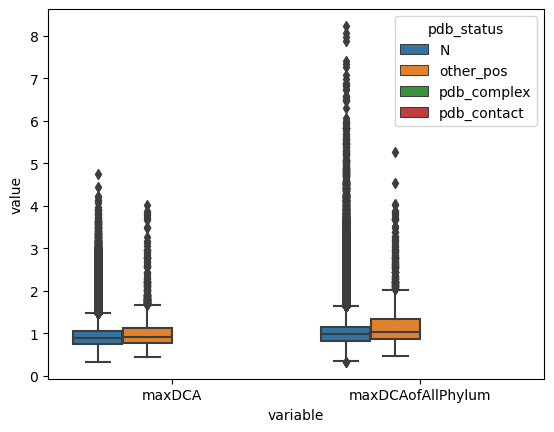

CPU times: user 2.96 s, sys: 129 ms, total: 3.09 s
Wall time: 2.87 s


In [46]:
%%time
# plt.figure(figsize=(8,6))

sns.boxplot(data=Subject_maxDCAs_maxDCAofAllPhylum_frame_longformat,
             y="value",
             x="variable",
            hue="pdb_status",
            hue_order=["N","other_pos","pdb_complex","pdb_contact"]
            #hue_order=["N","pdb_complex","pdb_contact"],
            )
# plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()


###  t test show that why max dca of all phylum might work  (besides better alignment quality), same apply to phylum integration 
transition problem or false positive ?


the things is for even negative , max DCA of all phylum also increase, could mean it actully contain some postive 
or its just false postive 
the fact that only for group pdb_contact is not afffect may indicate that its transition problem, 
because if its false postive all group should be affected in similar maner 
but if its transition problem, then it make sense these direct interaction  have simliar coevolution signal 
but for other groups, its values change depends on its connect with other protein pairs in other phylum ?



max dca of all phylum works it works better for pdb_complex  ?
make transition problem even greater ?

from this above plot, we can see after choosed max DCA of all phylum
pdb_concact and pdb_complex still much larget than negative category
but pdb_complex get most of incerase 




In [47]:
pdb_groups=["pdb_contact","pdb_complex","N"]#["N","other_pos","pdb_complex","pdb_contact",]


# alternative="greater"
for label in pdb_groups:
    
    print(f"{label}************")
    group = Subject_maxDCAs_maxDCAofAllPhylum_frame[Subject_maxDCAs_maxDCAofAllPhylum_frame['pdb_status']==label]

    test_statistic,test_pvalue=ttest_ind(group['maxDCAofAllPhylum'],group['maxDCA'], equal_var=False,)# alternative=alternative
    print(test_statistic,test_pvalue)
    #Subject_maxDCs_statistics.loc[label1,label2]="{res:.2f}".format(res=test_statistic)+" , "+"{res:.2e}".format(res=test_pvalue)


pdb_contact************
nan nan
pdb_complex************
nan nan
N************
378.6140572652406 0.0


In [48]:
pdb_groups=["pdb_contact","pdb_complex","N"]

fillin_matrix=np.zeros((3,3))
fillin_matrix[fillin_matrix==0]=np.nan

Subject_maxDCAs_statistics=pd.DataFrame(fillin_matrix,
                                                      index=pdb_groups,
                                                      columns=pdb_groups,
                                                     )
Subject_maxDCAofAllPhylum_statistics=pd.DataFrame(fillin_matrix,
                                                      index=pdb_groups,
                                                      columns=pdb_groups,
                                                     )

for i in range(len(pdb_groups)-1):
    for j in range(i+1,len(pdb_groups)):
        print(i,j)
        label1=pdb_groups[i]
        label2=pdb_groups[j]
        
        group1 = Subject_maxDCAs_maxDCAofAllPhylum_frame[Subject_maxDCAs_maxDCAofAllPhylum_frame['pdb_status']==label1]
        group2 = Subject_maxDCAs_maxDCAofAllPhylum_frame[Subject_maxDCAs_maxDCAofAllPhylum_frame['pdb_status']==label2]
        
        test_statistic,test_pvalue=ttest_ind(group1['maxDCA'], group2['maxDCA'], equal_var=False,)# alternative=alternative
        print(test_statistic,test_pvalue)
        Subject_maxDCAs_statistics.loc[label1,label2]="{res:.2f}".format(res=test_statistic)+" , "+"{res:.2e}".format(res=test_pvalue)
#        Subject_maxDCs_statistics.loc[label1,label2]=str(np.round(test_statistic,decimals=2))+"_"+str(np.round(test_pvalue,decimals=2))
        
        test_statistic,test_pvalue=ttest_ind(group1['maxDCAofAllPhylum'], group2['maxDCAofAllPhylum'], equal_var=False,) # alternative=alternative
        Subject_maxDCAofAllPhylum_statistics.loc[label1,label2]="{res:.2f}".format(res=test_statistic)+" , "+"{res:.2e}".format(res=test_pvalue)


0 1
nan nan
0 2
nan nan
1 2
nan nan


In [49]:
Subject_maxDCAs_statistics

pdb_contact pdb_complex          N
pdb_contact          NaN   nan , nan  nan , nan
pdb_complex          NaN         NaN  nan , nan
N                    NaN         NaN        NaN

In [50]:

Subject_maxDCAofAllPhylum_statistics

pdb_contact pdb_complex          N
pdb_contact          NaN   nan , nan  nan , nan
pdb_complex          NaN         NaN  nan , nan
N                    NaN         NaN        NaN

# do protein level APC of max DCA ?
/MNF/src/tao_utilities/coevolution_nomorlization.py
ML_folder

In [51]:
#retrice all unique proteins involved 
Uniquee_Ecoli_Pro,Unique_Ecoli_idx2pro_dict=get_idx2protein_dict(Subject_top_DCA_dict)
print(list(Unique_Ecoli_idx2pro_dict.items())[0])

Unique_Ecoli_pro2idx_dict={v:k for k,v in Unique_Ecoli_idx2pro_dict.items()}
print(len(Unique_Ecoli_idx2pro_dict),len(Unique_Ecoli_pro2idx_dict))

2623
2638
2652
['511145.b0003', '511145.b0004', '511145.b0006']
(0, '511145.b0003')
2652 2652


In [52]:
%%time 
pairwise_matrix=get_proteinLevel_pairwise_matrix_full(Uniquee_Ecoli_Pro,
                                                         Unique_Ecoli_idx2pro_dict,
                                                         Subject_top_DCA_dict,
                                                         topDCA_num=1,)


(2652, 2652)
2269192
CPU times: user 6.07 s, sys: 0 ns, total: 6.07 s
Wall time: 6.07 s


In [53]:
np.sum(~np.isnan(pairwise_matrix))/2

2269192.0

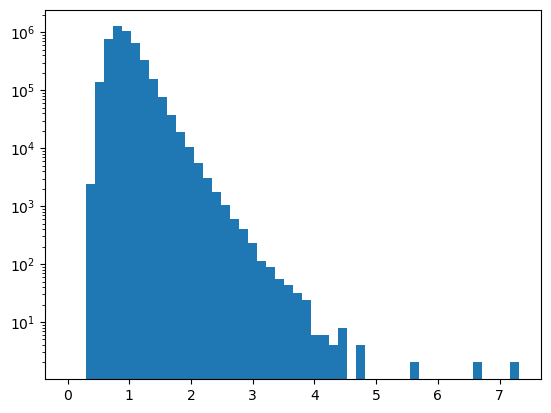

In [54]:
plt.yscale("log")
_=plt.hist(pairwise_matrix.flatten(),bins=50,range=(0,np.nanmax(pairwise_matrix)))

plt.show()

In [55]:
sys.getsizeof(pairwise_matrix)/(1024*1024*1024)

0.05240081995725632

In [56]:
np.nanmax(pairwise_matrix),np.nansum(pairwise_matrix),np.sum(~np.isnan(pairwise_matrix))

(7.3076, 4214174.2026, 4538384)

In [57]:
pairwise_matrix[0:3,0:10]

array([[   nan, 0.9976,    nan,    nan,    nan,    nan,    nan,    nan,
           nan,    nan],
       [0.9976,    nan, 0.9727, 0.6901, 0.9595, 0.8637,    nan, 0.8325,
        0.6983, 0.8612],
       [   nan, 0.9727,    nan, 0.8066, 1.1468, 1.0366,    nan, 1.1241,
        1.1268, 0.8254]])

In [58]:
%%time 
APCed_pairwise_matrix=proteinLevel_APC(pairwise_matrix)


pairwise_matrix_sum,pairwise_matrix_ave 4214174.2026 0.9285627224580381
sum(pairwise_matrix_rowCount) 4538384
sum(pairwise_matrix_colCount) 4538384
pairwise_matrix.shape: (2652, 2652)
pairwise_matrix.shape[0]*pairwise_matrix.shape[1]: 7033104
np.where(pairwise_matrix_rowCount==0): (array([], dtype=int64),)
CPU times: user 6.87 s, sys: 0 ns, total: 6.87 s
Wall time: 6.87 s


In [59]:
np.sum(~np.isnan(APCed_pairwise_matrix))/2

2269192.0

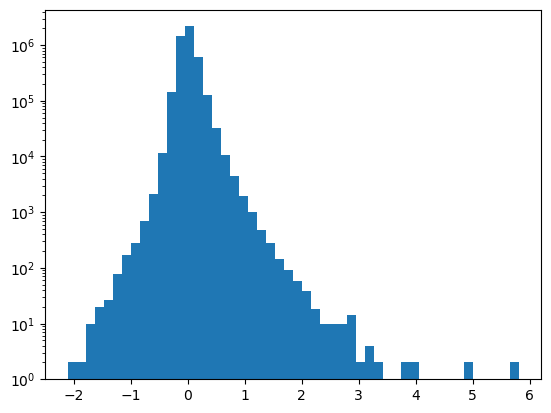

In [60]:

plt.yscale("log")
_=plt.hist(APCed_pairwise_matrix.flatten(),bins=50,)

plt.show()

In [61]:
%%time 
Subject_maxAPCedDCA_dict=dict()
for i in range(APCed_pairwise_matrix.shape[0]):
    for j in range(APCed_pairwise_matrix.shape[1]):
        if not np.isnan(APCed_pairwise_matrix[i,j]):
            Subject_maxAPCedDCA_dict[tuple(sorted((Unique_Ecoli_idx2pro_dict[i],Unique_Ecoli_idx2pro_dict[j])))]=APCed_pairwise_matrix[i,j]
print(len(Subject_maxAPCedDCA_dict))     

2269192
CPU times: user 18.2 s, sys: 1.62 ms, total: 18.2 s
Wall time: 18.2 s


In [62]:
%%time
# Subject_maxAPCedDCAs=[v for k, v in Subject_maxAPCedDCA_dict.items()]
# Subject_maxAPCedDCA_PPs=[k for k, v in Subject_maxAPCedDCA_dict.items()]

Subject_maxAPCedDCAs=[Subject_maxAPCedDCA_dict[pp] for pp in Subject_PPs]
Subject_maxAPCedDCA_PPs=[pp for pp in Subject_PPs]



len(Subject_maxAPCedDCAs)

CPU times: user 1.67 s, sys: 0 ns, total: 1.67 s
Wall time: 1.67 s


2269192

In [63]:
np.nanmax(APCed_pairwise_matrix)

5.805760860568917

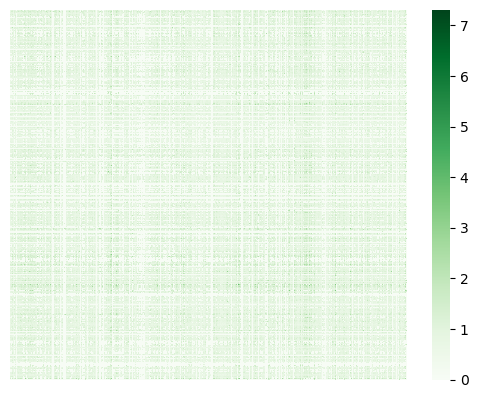

In [64]:
# %%time 
ax = sns.heatmap(np.nan_to_num(pairwise_matrix),cmap="Greens",xticklabels=False,yticklabels=False)
plt.show()


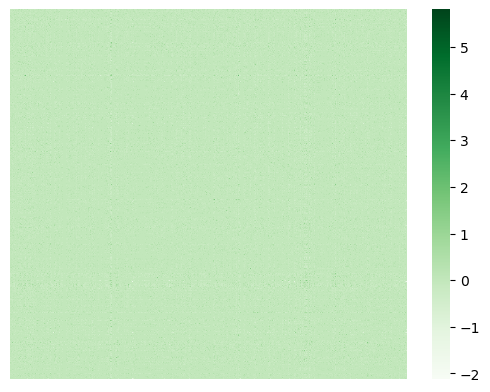

In [65]:
# %%time 
ax = sns.heatmap(np.nan_to_num(APCed_pairwise_matrix),cmap="Greens",xticklabels=False,yticklabels=False)
plt.show()


# check why here is not smoothed 


In [66]:
APCed_pairwise_matrix[0:3,0:20]

array([[        nan, -0.07545589,         nan,         nan,         nan,
                nan,         nan,         nan,         nan,         nan,
                nan, -0.26950167, -0.07811608,         nan, -0.01030938,
                nan,         nan,         nan,  0.0788143 ,         nan],
       [-0.07545589,         nan, -0.03014602, -0.07955154,  0.0239083 ,
        -0.06563937,         nan, -0.07560592, -0.18324866,  0.06759577,
        -0.08478598,  0.21931067, -0.00972658,  0.11952694, -0.01096444,
         0.35685619, -0.01747778,  0.06346306,  0.21645283,  0.00424272],
       [        nan, -0.03014602,         nan, -0.13347084,  0.00404587,
        -0.09851739,         nan,  0.01491766,  0.05005533, -0.14392723,
        -0.12702049,  0.03529251,  0.07217577,  0.30744337, -0.02996884,
        -0.21669845,  0.28710787, -0.00770056,  0.63753717, -0.05654285]])

In [67]:
pairwise_matrix[0:3,0:20]


array([[   nan, 0.9976,    nan,    nan,    nan,    nan,    nan,    nan,
           nan,    nan,    nan, 1.2068, 1.0451,    nan, 1.1702,    nan,
           nan,    nan, 1.2346,    nan],
       [0.9976,    nan, 0.9727, 0.6901, 0.9595, 0.8637,    nan, 0.8325,
        0.6983, 0.8612, 0.745 , 1.3489, 0.8497, 0.8425, 0.8923, 1.4559,
        0.9188, 0.8988, 1.1008, 0.9291],
       [   nan, 0.9727,    nan, 0.8066, 1.1468, 1.0366,    nan, 1.1241,
        1.1268, 0.8254, 0.8865, 1.415 , 1.1219, 1.1905, 1.0733, 1.1257,
        1.4307, 1.0126, 1.7177, 1.0731]])

In [68]:
# print(np.sum( APCed_pairwise_matrix>1))

# print(np.sum( APCed_pairwise_matrix>0.8))

# print(np.sum( APCed_pairwise_matrix>0.5))


# # # # when topDCA_num=1
# # 2666
# # 6344
# # 30714



In [69]:
print(Subject_top_DCA_dict[(Unique_Ecoli_idx2pro_dict[1],Unique_Ecoli_idx2pro_dict[2])])

[0.9727, 61, 542, 0.9031, 191, 430, 0.8833, 76, 419, 0.8094, 350, 493, 0.7742, 89, 643, 0.7733, 123, 632, 0.7711, 259, 670, 0.7708, 237, 562, 0.7701, 375, 632, 0.7593, 85, 552, 0.7588, 154, 466, 0.7577, 70, 455, 0.7527, 364, 536, 0.7469, 284, 584, 0.7407, 326, 559, 0.7328, 68, 446, 0.7326, 60, 474, 0.7229, 35, 577, 0.7152, 12, 479, 0.7144, 230, 525, 0.7132, 386, 579, 0.713, 350, 472, 0.6973, 159, 608, 0.6938, 172, 619, 0.6898, 121, 563, 0.6882, 173, 486, 0.6852, 338, 489, 0.6813, 331, 572, 0.6794, 122, 605, 0.6791, 374, 541, 0.6773, 147, 648, 0.6711, 340, 646, 0.6683, 362, 580, 0.6682, 35, 518, 0.6631, 375, 436, 0.661, 172, 472, 0.6608, 154, 513, 0.6606, 320, 491, 0.6597, 191, 594, 0.6591, 187, 472, 0.656, 282, 432, 0.653, 88, 443, 0.6522, 94, 637, 0.6521, 178, 473, 0.6475, 36, 674, 0.6467, 346, 595, 0.6454, 181, 571, 0.6432, 382, 633, 0.642, 227, 604, 0.6419, 191, 466]


### show some statistics 

Welch’s t-Test in Pandas; https://www.statology.org/pandas-t-test/
https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.ttest_ind.html

aslo trim end? remove outlieer ??



In [70]:
%%time
Subject_maxDCAsANDmaxAPCedDCA_frame=pd.DataFrame([(Subject_PPs[i][0],Subject_PPs[i][1],Subject_maxDCAs[i],Subject_maxAPCedDCAs[i]) for i in range(len(Subject_PPs))],
                                                      columns=["p1","p2","maxDCA","maxAPCedDCAs"])

Subject_maxDCAsANDmaxAPCedDCA_frame=add_STRINGPhyPPI_status(Subject_maxDCAsANDmaxAPCedDCA_frame,STRINGcurrentSpePhyPPI_posPPI_dict)

Subject_maxDCAsANDmaxAPCedDCA_frame=add_pdbstatus(Subject_maxDCAsANDmaxAPCedDCA_frame,
                                                        pdb_interact_PPs_dict,
                                                        pdb_complex_PPs_dict,
                                                      status_colIdx=4
                                                       )

Subject_maxDCAsANDmaxAPCedDCA_frame=Subject_maxDCAsANDmaxAPCedDCA_frame.loc[Subject_maxDCAsANDmaxAPCedDCA_frame["pdb_status"]!="other_pos",:]
# Subject_maxDCAsANDmaxAPCedDCA_frame_longformat= pd.melt(Subject_maxDCAsANDmaxAPCedDCA_frame, 
#                                                             id_vars='pdb_status', 
#                                                             value_vars=[f"maxDCA",f"maxAPCedDCAs"])






CPU times: user 11.8 s, sys: 176 ms, total: 12 s
Wall time: 12 s


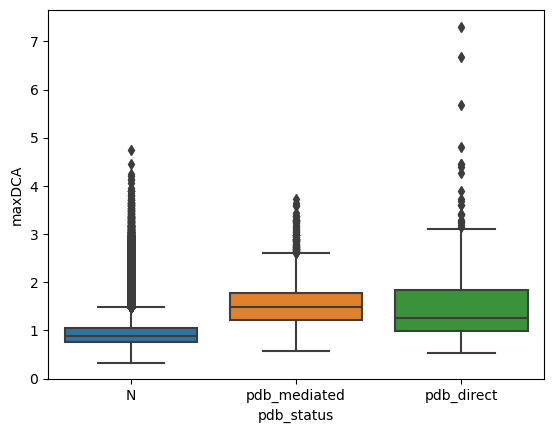

CPU times: user 927 ms, sys: 185 ms, total: 1.11 s
Wall time: 873 ms


In [71]:
%%time
# plt.figure(figsize=(8,6))

sns.boxplot(data=Subject_maxDCAsANDmaxAPCedDCA_frame,
             y="maxDCA",
             x="pdb_status",
            #hue="pdb_status",
            #hue_order=["N","other_pos","pdb_complex","pdb_contact"]
            #hue_order=["N","pdb_complex","pdb_contact"],
            )
# plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()


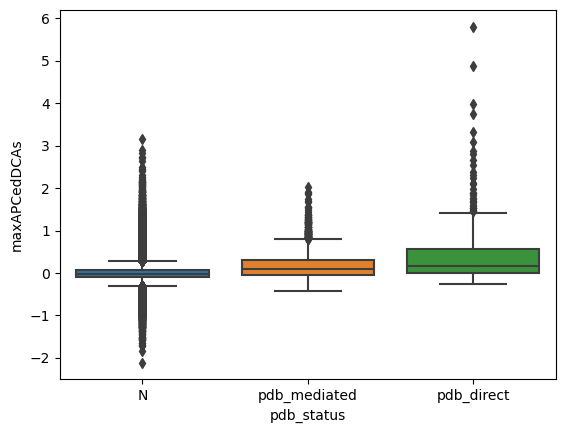

CPU times: user 958 ms, sys: 174 ms, total: 1.13 s
Wall time: 893 ms


In [72]:
%%time
# plt.figure(figsize=(8,6))

sns.boxplot(data=Subject_maxDCAsANDmaxAPCedDCA_frame,
             y="maxAPCedDCAs",
             x="pdb_status",
            #hue="pdb_status",
            #hue_order=["N","other_pos","pdb_complex","pdb_contact"]
            #hue_order=["N","pdb_complex","pdb_contact"],
            )
# plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()


In [73]:
len(Unique_Ecoli_pro2idx_dict), len(Unique_Ecoli_pro2idx_dict)/2

(2652, 1326.0)

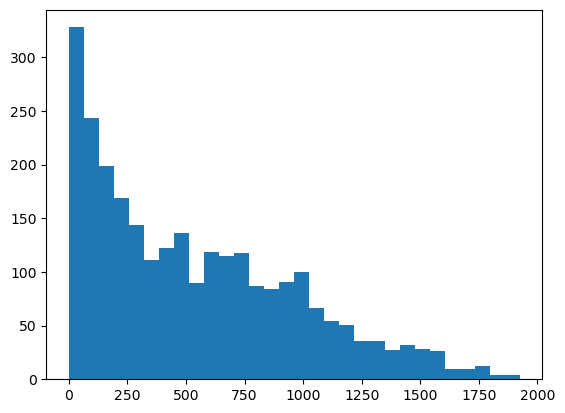

In [74]:
plt.hist(np.sum(pairwise_matrix>1,axis=0),bins=30)
plt.show()


In [75]:
largeDCA_countList=np.sum(pairwise_matrix>1,axis=0)

sum(largeDCA_countList>500)


1235

In [76]:
from scipy.stats import ttest_ind

In [77]:
# import scipy

In [78]:
# scipy.__version__

In [79]:
set(Subject_maxDCAsANDmaxAPCedDCA_frame['pdb_status'])

{'N', 'pdb_direct', 'pdb_mediated'}

In [80]:
pdb_groups=["pdb_contact","pdb_complex","N"]

fillin_matrix=np.zeros((3,3))
fillin_matrix[fillin_matrix==0]=np.nan

Subject_maxDCs_statistics=pd.DataFrame(fillin_matrix,
                                                      index=pdb_groups,
                                                      columns=pdb_groups,
                                                     )
Subject_maxAPCedDCA_statistics=pd.DataFrame(fillin_matrix,
                                                      index=pdb_groups,
                                                      columns=pdb_groups,
                                                     )

alternative="greater"
for i in range(len(pdb_groups)-1):
    for j in range(i+1,len(pdb_groups)):
        print(i,j)
        label1=pdb_groups[i]
        label2=pdb_groups[j]
        
        group1 = Subject_maxDCAsANDmaxAPCedDCA_frame[Subject_maxDCAsANDmaxAPCedDCA_frame['pdb_status']==label1]
        group2 = Subject_maxDCAsANDmaxAPCedDCA_frame[Subject_maxDCAsANDmaxAPCedDCA_frame['pdb_status']==label2]
        
        test_statistic,test_pvalue=ttest_ind(group1['maxDCA'], group2['maxDCA'], equal_var=False,)# alternative=alternative
        print(test_statistic,test_pvalue)
        Subject_maxDCs_statistics.loc[label1,label2]="{res:.2f}".format(res=test_statistic)+" , "+"{res:.2e}".format(res=test_pvalue)
#        Subject_maxDCs_statistics.loc[label1,label2]=str(np.round(test_statistic,decimals=2))+"_"+str(np.round(test_pvalue,decimals=2))
        
        test_statistic,test_pvalue=ttest_ind(group1['maxAPCedDCAs'], group2['maxAPCedDCAs'], equal_var=False,) # alternative=alternative
        Subject_maxAPCedDCA_statistics.loc[label1,label2]="{res:.2f}".format(res=test_statistic)+" , "+"{res:.2e}".format(res=test_pvalue)


0 1
nan nan
0 2
nan nan
1 2
nan nan


#### t test table 
add results to  CoEvolutionIntegration_Paper_all_sup_tables.numbers/protein level apc t-test

In [81]:
Subject_maxDCs_statistics

pdb_contact pdb_complex          N
pdb_contact          NaN   nan , nan  nan , nan
pdb_complex          NaN         NaN  nan , nan
N                    NaN         NaN        NaN

In [82]:
Subject_maxAPCedDCA_statistics

pdb_contact pdb_complex          N
pdb_contact          NaN   nan , nan  nan , nan
pdb_complex          NaN         NaN  nan , nan
N                    NaN         NaN        NaN

In [83]:
# help(ttest_ind)

### draw plot 

In [84]:
print(len(pdb_complex_PPs_dict))
pdb_complex_noRibosome_PPs_dict={pp: 1 for pp,_ in pdb_complex_PPs_dict.items() if not isStringProIDs_Ribosome(pp,ecoli_proteinNames_dict)}
print(len(pdb_complex_noRibosome_PPs_dict))

pdb_complex_oneRibosome_PPs_dict={pp: 1 for pp,_ in pdb_complex_PPs_dict.items() if  isStringProIDs_oneRibosome(pp,ecoli_proteinNames_dict)}
print(len(pdb_complex_oneRibosome_PPs_dict))


pdb_complex_twoRibosome_PPs_dict={pp: 1 for pp,_ in pdb_complex_PPs_dict.items() if  isStringProIDs_twoRibosome(pp,ecoli_proteinNames_dict)}
print(len(pdb_complex_twoRibosome_PPs_dict))


3243
74
1580
1589


In [85]:
%%time 
Subject_pdb_statusDict=Subject_maxDCAsANDmaxAPCedDCA_frame.loc[:,["p1","p2","pdb_status"]].values.tolist()

Subject_pdb_statusDict={(p1,p2):s for p1,p2,s in Subject_pdb_statusDict}

Subject_maxAPCedDCAs_dict={pp: Subject_maxAPCedDCAs[idx] for idx,pp in enumerate(Subject_maxAPCedDCA_PPs)}
Subject_maxDCAs_dict={pp: Subject_maxDCAs[idx] for idx,pp in enumerate(Subject_PPs)}

# STRINGPhyBalancePhyla_maxDCAs=np.array([Subject_maxDCAs_dict[pp] for pp ,s in STRINGPhyBalancePhyla_statusDict.items()])
# STRINGPhyBalancePhyla_maxAPCedDCAs=np.array([Subject_maxAPCedDCAs_dict[pp] for pp ,s in STRINGPhyBalancePhyla_statusDict.items()])
# STRINGPhyBalancePhyla_PPs=np.array([1 if s=="P" else 0 for pp ,s in STRINGPhyBalancePhyla_statusDict.items()])

len(Subject_pdb_statusDict)


CPU times: user 8.77 s, sys: 36.5 ms, total: 8.81 s
Wall time: 8.8 s


2266908

In [86]:
%%time
print("*******")
Subject_pdb_interact_statusDict={pp: s for pp,s in Subject_pdb_statusDict.items() if ((s=="N") or (pp in pdb_interact_PPs_dict))}
print(len(Subject_pdb_interact_statusDict))
Subject_pdb_interact_maxDCAs=np.array([Subject_maxDCAs_dict[pp] for pp ,s in Subject_pdb_interact_statusDict.items()])
Subject_pdb_interact_maxAPCedDCAs=np.array([Subject_maxAPCedDCAs_dict[pp] for pp ,s in Subject_pdb_interact_statusDict.items()])
Subject_pdb_interact_PPs=np.array([0 if s=="N" else 1 for pp ,s in Subject_pdb_interact_statusDict.items()])
print((sum(Subject_pdb_interact_PPs)))

print("*******")
Subject_pdb_complex_statusDict={pp: s for pp,s in Subject_pdb_statusDict.items() if ((s=="N") or (pp in pdb_complex_PPs_dict))}
print(len(Subject_pdb_complex_statusDict))
Subject_pdb_complex_maxDCAs=np.array([Subject_maxDCAs_dict[pp] for pp ,s in Subject_pdb_complex_statusDict.items()])
Subject_pdb_complex_maxAPCedDCAs=np.array([Subject_maxAPCedDCAs_dict[pp] for pp ,s in Subject_pdb_complex_statusDict.items()])
Subject_pdb_complex_PPs=np.array([0 if s=="N" else 1  for pp ,s in Subject_pdb_complex_statusDict.items()])
print(sum(Subject_pdb_complex_PPs))


print("*******")
Subject_pdb_complex_noRibosome_statusDict={pp: s for pp,s in Subject_pdb_statusDict.items() if ((s=="N") or (pp in pdb_complex_noRibosome_PPs_dict))}
print(len(Subject_pdb_complex_noRibosome_statusDict))
Subject_pdb_complex_noRibosome_maxDCAs=np.array([Subject_maxDCAs_dict[pp] for pp ,s in Subject_pdb_complex_noRibosome_statusDict.items()])
Subject_pdb_complex_noRibosome_maxAPCedDCAs=np.array([Subject_maxAPCedDCAs_dict[pp] for pp ,s in Subject_pdb_complex_noRibosome_statusDict.items()])
Subject_pdb_complex_noRibosome_PPs=np.array([0 if s=="N" else 1  for pp ,s in Subject_pdb_complex_noRibosome_statusDict.items()])
print(sum(Subject_pdb_complex_noRibosome_PPs))


print("*******")
Subject_pdb_complex_oneRibosome_statusDict={pp: s for pp,s in Subject_pdb_statusDict.items() if ((s=="N") or (pp in pdb_complex_oneRibosome_PPs_dict))}
print(len(Subject_pdb_complex_oneRibosome_statusDict))
Subject_pdb_complex_oneRibosome_maxDCAs=np.array([Subject_maxDCAs_dict[pp] for pp ,s in Subject_pdb_complex_oneRibosome_statusDict.items()])
Subject_pdb_complex_oneRibosome_maxAPCedDCAs=np.array([Subject_maxAPCedDCAs_dict[pp] for pp ,s in Subject_pdb_complex_oneRibosome_statusDict.items()])
Subject_pdb_complex_oneRibosome_PPs=np.array([0 if s=="N" else 1 for pp ,s in Subject_pdb_complex_oneRibosome_statusDict.items()])
print(sum(Subject_pdb_complex_oneRibosome_PPs))

print("*******")
Subject_pdb_complex_twoRibosome_statusDict={pp: s for pp,s in Subject_pdb_statusDict.items() if ((s=="N") or (pp in pdb_complex_twoRibosome_PPs_dict))}
print(len(Subject_pdb_complex_twoRibosome_statusDict))
Subject_pdb_complex_twoRibosome_maxDCAs=np.array([Subject_maxDCAs_dict[pp] for pp ,s in Subject_pdb_complex_twoRibosome_statusDict.items()])
Subject_pdb_complex_twoRibosome_maxAPCedDCAs=np.array([Subject_maxAPCedDCAs_dict[pp] for pp ,s in Subject_pdb_complex_twoRibosome_statusDict.items()])
Subject_pdb_complex_twoRibosome_PPs=np.array([0 if s=="N" else 1  for pp ,s in Subject_pdb_complex_twoRibosome_statusDict.items()])
print(sum(Subject_pdb_complex_twoRibosome_PPs))




*******
2263954
294
*******
2266614
2954
*******
2263706
46
*******
2264991
1331
*******
2265237
1577
CPU times: user 15.4 s, sys: 0 ns, total: 15.4 s
Wall time: 15.4 s


In [87]:
46+1331+1577,len(pdb_complex_PPs_dict)

(2954, 3243)

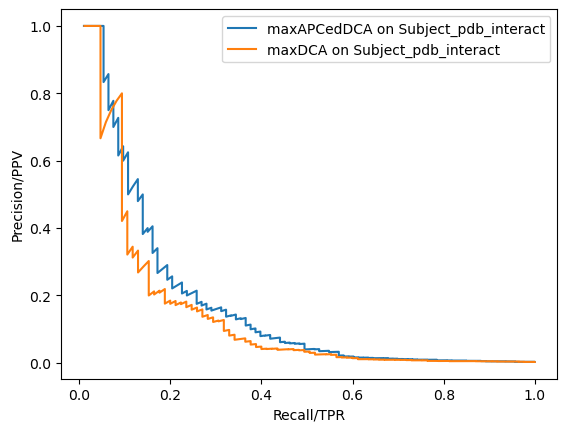

CPU times: user 5.13 s, sys: 38.4 ms, total: 5.16 s
Wall time: 5.01 s


In [88]:
%%time
step=1
zoom_thres=30000 #30000#30000  #2269192, 30000, 300

Precison_Recall_RocCurve(Subject_pdb_interact_maxAPCedDCAs,
                                               Subject_pdb_interact_PPs,
                                               legend="maxAPCedDCA on Subject_pdb_interact",
                                               step=step,
                                               zoom_thres=zoom_thres,
                                              )

Precison_Recall_RocCurve(Subject_pdb_interact_maxDCAs,
                                               Subject_pdb_interact_PPs,
                                               legend="maxDCA on Subject_pdb_interact",
                                               step=step,
                                               zoom_thres=zoom_thres,
                                              )

plt.legend(  loc='upper right' )
plt.show()
                                               
                       

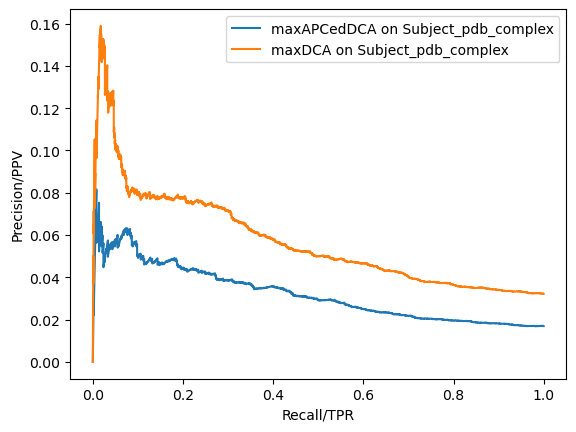

CPU times: user 5.17 s, sys: 135 ms, total: 5.31 s
Wall time: 5.1 s


In [89]:
%%time
step=1
zoom_thres=30000 #30000#30000  #2269192, 30000, 300

Precison_Recall_RocCurve(Subject_pdb_complex_maxAPCedDCAs,
                                               Subject_pdb_complex_PPs,
                                               legend="maxAPCedDCA on Subject_pdb_complex",
                                               step=step,
                                               zoom_thres=zoom_thres,
                                              )

Precison_Recall_RocCurve(Subject_pdb_complex_maxDCAs,
                                               Subject_pdb_complex_PPs,
                                               legend="maxDCA on Subject_pdb_complex",
                                               step=step,
                                               zoom_thres=zoom_thres,
                                              )

plt.legend(  loc='upper right' )

                                               
plt.show()                       

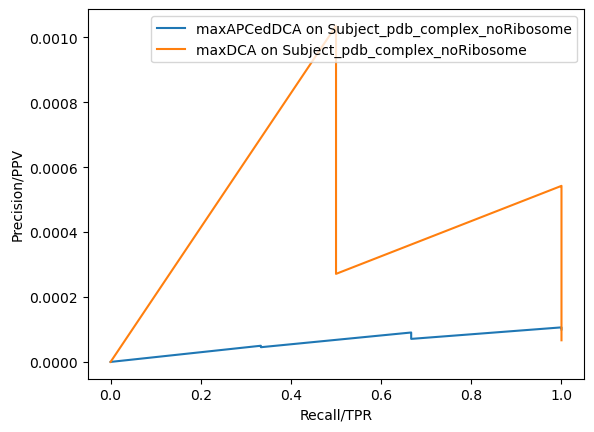

CPU times: user 4.97 s, sys: 101 ms, total: 5.07 s
Wall time: 4.88 s


In [90]:
%%time
step=1
zoom_thres=30000 #30000#30000  #2269192, 30000, 300

Precison_Recall_RocCurve(Subject_pdb_complex_noRibosome_maxAPCedDCAs,
                                               Subject_pdb_complex_noRibosome_PPs,
                                               legend="maxAPCedDCA on Subject_pdb_complex_noRibosome",
                                               step=step,
                                               zoom_thres=zoom_thres,
                                              )

Precison_Recall_RocCurve(Subject_pdb_complex_noRibosome_maxDCAs,
                                               Subject_pdb_complex_noRibosome_PPs,
                                               legend="maxDCA on Subject_pdb_complex_noRibosome",
                                               step=step,
                                               zoom_thres=zoom_thres,
                                              )

plt.legend(  loc='upper right' )

                                               
plt.show()                       

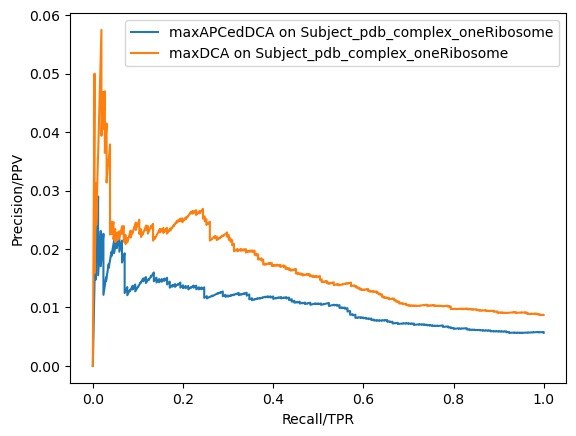

CPU times: user 4.97 s, sys: 124 ms, total: 5.1 s
Wall time: 4.89 s


In [91]:
%%time
step=1
zoom_thres=30000 #30000#30000  #2269192, 30000, 300

Precison_Recall_RocCurve(Subject_pdb_complex_oneRibosome_maxAPCedDCAs,
                                               Subject_pdb_complex_oneRibosome_PPs,
                                               legend="maxAPCedDCA on Subject_pdb_complex_oneRibosome",
                                               step=step,
                                               zoom_thres=zoom_thres,
                                              )

Precison_Recall_RocCurve(Subject_pdb_complex_oneRibosome_maxDCAs,
                                               Subject_pdb_complex_oneRibosome_PPs,
                                               legend="maxDCA on Subject_pdb_complex_oneRibosome",
                                               step=step,
                                               zoom_thres=zoom_thres,
                                              )

plt.legend(  loc='upper right' )
plt.show()                            
                       

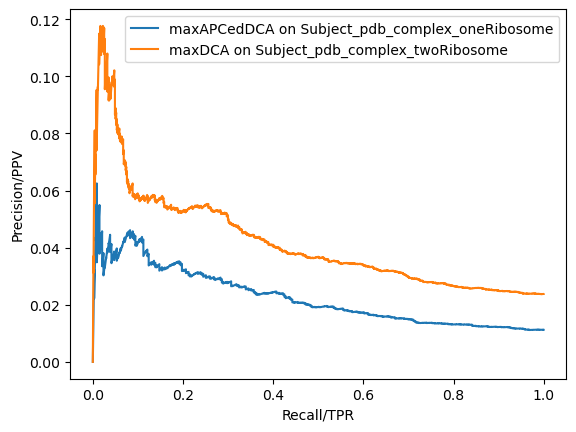

CPU times: user 5.25 s, sys: 125 ms, total: 5.38 s
Wall time: 5.18 s


In [92]:
%%time
step=1
zoom_thres=30000 #30000#30000  #2269192, 30000, 300

Precison_Recall_RocCurve(Subject_pdb_complex_twoRibosome_maxAPCedDCAs,
                                               Subject_pdb_complex_twoRibosome_PPs,
                                               legend="maxAPCedDCA on Subject_pdb_complex_oneRibosome",
                                               step=step,
                                               zoom_thres=zoom_thres,
                                              )

Precison_Recall_RocCurve(Subject_pdb_complex_twoRibosome_maxDCAs,
                                               Subject_pdb_complex_twoRibosome_PPs,
                                               legend="maxDCA on Subject_pdb_complex_twoRibosome",
                                               step=step,
                                               zoom_thres=zoom_thres,
                                              )

plt.legend( loc='upper right' )

plt.show()                                               
                       

### use Qian control pos and neg benchmark 

In [93]:
# 
# 
# from file http://localhost:8206/lab/workspaces/auto-l/tree/code/STRING_TAO/PPI_Coevolution/QianPDB_UniprotID2StringID.ipynb
# sheet_name=8

QianGold_Ecoli_PPI_pps_dict=get_QianCong_benchmark(f'/mnt/mnemo5/tao/PPI_Coevolution/QianCong_Paper/QianGOLD_PPI.csv')

QianNeg_Ecoli_PPI_pps_dict=get_QianCong_benchmark(f'/mnt/mnemo5/tao/PPI_Coevolution/QianCong_Paper/QianNeg_PPI.csv')




(300, 7)
289 289
(295656, 7)
289766 289766


In [94]:
QianControl_pps_dict={}
for pp in QianGold_Ecoli_PPI_pps_dict.keys():
    QianControl_pps_dict[pp]="P"
    
for pp in QianNeg_Ecoli_PPI_pps_dict.keys():
    QianControl_pps_dict[pp]="N"
    
print(len(QianControl_pps_dict))


QianControl_maxDCAs=np.array([Subject_maxDCAs_dict[pp] for pp ,s in QianControl_pps_dict.items() if pp in Subject_maxDCAs_dict]  )
QianControl_maxAPCedDCAs=np.array([Subject_maxAPCedDCAs_dict[pp] for pp ,s in QianControl_pps_dict.items() if pp in Subject_maxAPCedDCAs_dict] )
QianControl_PPs=np.array([1 if s=="P" else 0 for pp ,s in QianControl_pps_dict.items() if pp in Subject_maxDCAs_dict] )
print(QianControl_maxDCAs.shape,QianControl_PPs.shape)
print(np.sum(QianControl_PPs))
print(np.sum(QianControl_PPs==0))



290055
(127355,) (127355,)
200
127155


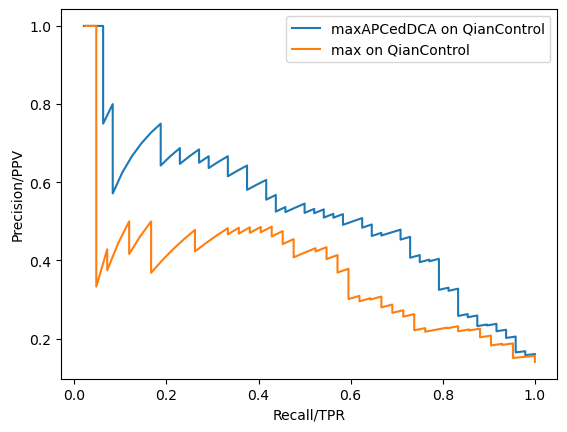

CPU times: user 157 ms, sys: 99.7 ms, total: 257 ms
Wall time: 120 ms


In [95]:
%%time
step=1
zoom_thres=300 #30000#30000  #2269192, 30000, 300
Precison_Recall_RocCurve(QianControl_maxAPCedDCAs,
                       QianControl_PPs,
                       legend="maxAPCedDCA on QianControl",
                       step=step,
                       zoom_thres=zoom_thres,
                                              )


Precison_Recall_RocCurve(QianControl_maxDCAs,
                       QianControl_PPs,
                       legend="max on QianControl",
                       step=step,
                       zoom_thres=zoom_thres,
                                              )

plt.legend(  loc='upper right' )                                             
plt.show()
                                   

In [96]:

pdb_interactRemoveOverlap_PPs=get_STRING1105_pdb_interact(pdb_interact_filename="/mnt/mnemo6/damian/STRING_derived_v11.5/pdb/pdb_interact.tsv",
                                retrieve_spe=511145,
                                remove_PDBoverlap=True)



pdb_interactRemoveOverlap_PPs_dict={pp: 1 for pp in pdb_interactRemoveOverlap_PPs}

print(len(pdb_interactRemoveOverlap_PPs_dict))


len of intersection: 309
105


In [97]:
print(len(pdb_interact_PPs_dict))

414


In [98]:
QianModify_statusDict={}

for pp in pdb_interact_PPs_dict.keys():
# for pp in pdb_interactRemoveOverlap_PPs_dict.keys():
    QianModify_statusDict[pp]="pdb_contact"
    
for pp in pdb_complex_PPs_dict.keys():
    QianModify_statusDict[pp]="pdb_complex"
    
    
    
    #  in this step , some pdb_complex_PPs are labeled as negative by qian negative control
for pp in QianNeg_Ecoli_PPI_pps_dict.keys():
    QianModify_statusDict[pp]="N"
    
print(len(QianModify_statusDict))


QianModify_statusDict={k:v for k,v in QianModify_statusDict.items() if k in Subject_maxDCAs_dict}
print(len(QianModify_statusDict))

293410
130392


In [99]:
%%time
sum(1 for k in QianNeg_Ecoli_PPI_pps_dict.keys() if k in pdb_complex_PPs_dict)

CPU times: user 17 ms, sys: 25 µs, total: 17 ms
Wall time: 16.7 ms


13

In [100]:
%%time
print("*******")
QianModify_interact_statusDict={pp: s for pp,s in QianModify_statusDict.items() if ((s=="N") or (s =="pdb_contact" ))}
print(len(QianModify_interact_statusDict))
QianModify_interact_maxDCAs=np.array([Subject_maxDCAs_dict[pp] for pp ,s in QianModify_interact_statusDict.items()])
QianModify_interact_maxAPCedDCAs=np.array([Subject_maxAPCedDCAs_dict[pp] for pp ,s in QianModify_interact_statusDict.items()])
QianModify_interact_PPs=np.array([0 if s=="N" else 1 for pp ,s in QianModify_interact_statusDict.items()])
print((sum(QianModify_interact_PPs==1)))
print((sum(QianModify_interact_PPs==0)))

*******
127449
294
127155
CPU times: user 853 ms, sys: 0 ns, total: 853 ms
Wall time: 853 ms


In [101]:
%%time
print("*******")
QianModify_complex_statusDict={pp: s for pp,s in QianModify_statusDict.items() if ((s=="N") or (s=="pdb_complex"))}
print(len(QianModify_complex_statusDict))
QianModify_complex_maxDCAs=np.array([Subject_maxDCAs_dict[pp] for pp ,s in QianModify_complex_statusDict.items()])
QianModify_complex_maxAPCedDCAs=np.array([Subject_maxAPCedDCAs_dict[pp] for pp ,s in QianModify_complex_statusDict.items()])
QianModify_complex_PPs=np.array([0 if s=="N" else 1 for pp ,s in QianModify_complex_statusDict.items()])
print((sum(QianModify_complex_PPs==1)))
print((sum(QianModify_complex_PPs==0)))

*******
130098
2943
127155
CPU times: user 869 ms, sys: 0 ns, total: 869 ms
Wall time: 868 ms


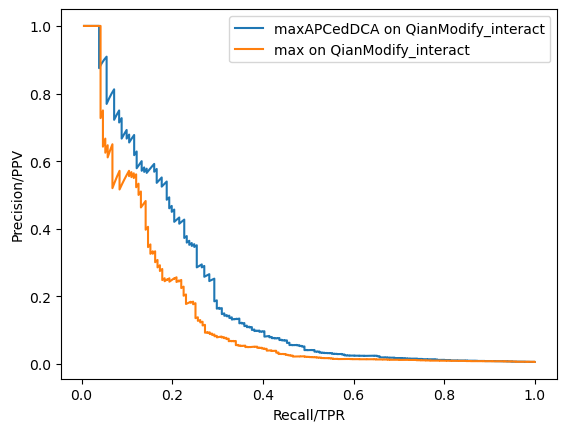

CPU times: user 4.54 s, sys: 36.8 ms, total: 4.57 s
Wall time: 4.43 s


In [102]:
%%time
step=1
zoom_thres=30000 #30000#30000  #2269192, 30000, 300
Precison_Recall_RocCurve(QianModify_interact_maxAPCedDCAs,
                       QianModify_interact_PPs,
                       legend="maxAPCedDCA on QianModify_interact",
                       step=step,
                       zoom_thres=zoom_thres,
                                              )


Precison_Recall_RocCurve(QianModify_interact_maxDCAs,
                       QianModify_interact_PPs,
                       legend="max on QianModify_interact",
                       step=step,
                       zoom_thres=zoom_thres,
                                              )

plt.legend(  loc='upper right' )                                             
plt.show()
                                   

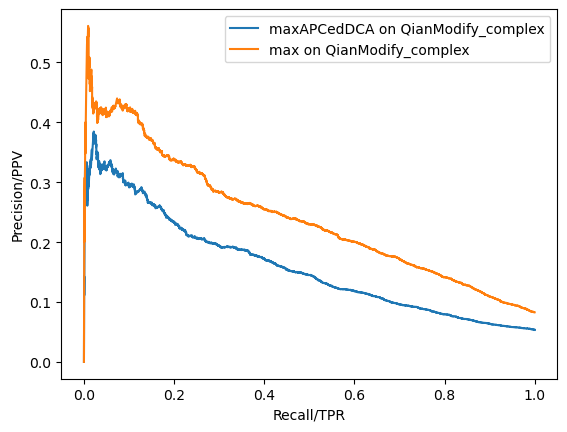

CPU times: user 5.19 s, sys: 94.8 ms, total: 5.29 s
Wall time: 5.09 s


In [103]:
%%time
step=1
zoom_thres=30000 #30000#30000  #2269192, 30000, 300
Precison_Recall_RocCurve(QianModify_complex_maxAPCedDCAs,
                       QianModify_complex_PPs,
                       legend="maxAPCedDCA on QianModify_complex",
                       step=step,
                       zoom_thres=zoom_thres,
                                              )


Precison_Recall_RocCurve(QianModify_complex_maxDCAs,
                       QianModify_complex_PPs,
                       legend="max on QianModify_complex",
                       step=step,
                       zoom_thres=zoom_thres,
                                              )

plt.legend(  loc='upper right' )                                             
plt.show()
                                   

#### show some statistics 

In [104]:
QianModify_maxDCAs=np.array([Subject_maxDCAs_dict[pp] for pp ,s in QianModify_statusDict.items()])
QianModify_maxAPCedDCAs=np.array([Subject_maxAPCedDCAs_dict[pp] for pp ,s in QianModify_statusDict.items()])
QianModify_status=[s for pp,s in QianModify_statusDict.items()]
QianModify_frame=pd.DataFrame(list(zip(QianModify_maxDCAs,QianModify_maxAPCedDCAs,QianModify_status)),
                              columns=["maxDCA","maxAPCedDCAs","pdb_status"])
QianModify_frame

maxDCA  maxAPCedDCAs   pdb_status
0       1.7117      0.736677  pdb_contact
1       0.9454      0.053818  pdb_contact
2       1.1702      0.134224  pdb_contact
3       2.4252      1.521061  pdb_contact
4       0.7470     -0.192426  pdb_contact
...        ...           ...          ...
130387  0.6382      0.027691            N
130388  0.9460      0.092634            N
130389  0.8656     -0.039700            N
130390  1.2414     -0.047101            N
130391  0.5500     -0.091784            N

[130392 rows x 3 columns]

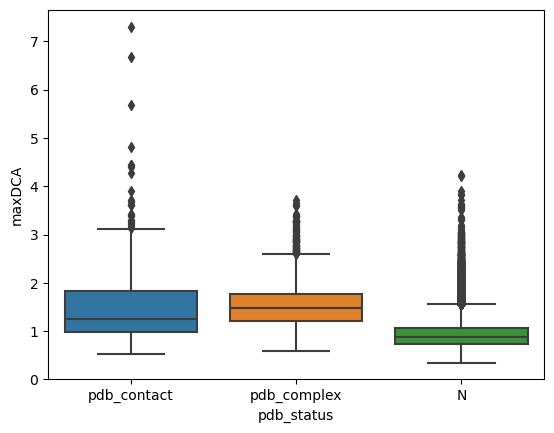

CPU times: user 166 ms, sys: 95.1 ms, total: 261 ms
Wall time: 130 ms


In [105]:
%%time
# plt.figure(figsize=(8,6))

sns.boxplot(data=QianModify_frame,
             y="maxDCA",
             x="pdb_status",)

plt.show()


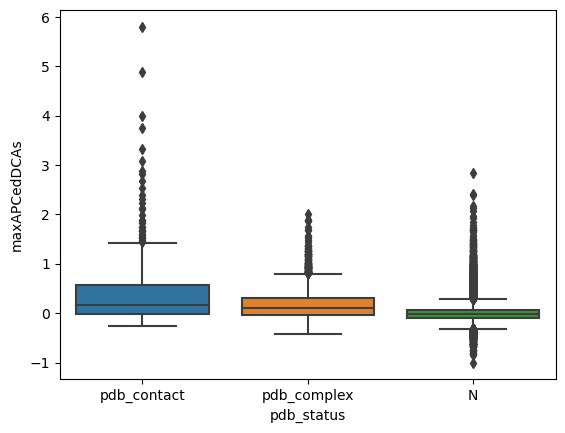

CPU times: user 182 ms, sys: 161 ms, total: 343 ms
Wall time: 135 ms


In [106]:
 %%time
# plt.figure(figsize=(8,6))

sns.boxplot(data=QianModify_frame,
             y="maxAPCedDCAs",
             x="pdb_status",)

plt.show()


In [107]:
pdb_groups=["pdb_contact","pdb_complex","N"]
QianModify_maxDCs_statistics=pd.DataFrame(np.zeros((3,3)),
                                                      index=pdb_groups,
                                                      columns=pdb_groups,
                                                     )
QianModify_maxAPCedDCA_statistics=pd.DataFrame(np.zeros((3,3)),
                                                      index=pdb_groups,
                                                      columns=pdb_groups,
                                                     )


for i in range(len(pdb_groups)-1):
    for j in range(i+1,len(pdb_groups)):
        print(i,j)
        label1=pdb_groups[i]
        label2=pdb_groups[j]
        
        group1 =QianModify_frame[QianModify_frame['pdb_status']==label1]
        group2 =QianModify_frame[QianModify_frame['pdb_status']==label2]
        
        test_statistic,test_pvalue=ttest_ind(group1['maxDCA'], group2['maxDCA'], equal_var=False)
        print(test_statistic,test_pvalue)
        QianModify_maxDCs_statistics.loc[label1,label2]="{res:.4f}".format(res=test_statistic)+" , "+"{res:.4e}".format(res=test_pvalue)
#        Subject_maxDCs_statistics.loc[label1,label2]=str(np.round(test_statistic,decimals=2))+"_"+str(np.round(test_pvalue,decimals=2))
        
        test_statistic,test_pvalue=ttest_ind(group1['maxAPCedDCAs'], group2['maxAPCedDCAs'], equal_var=False)
        QianModify_maxAPCedDCA_statistics.loc[label1,label2]="{res:.4f}".format(res=test_statistic)+" , "+"{res:.4e}".format(res=test_pvalue)


0 1
0.5981190112226286 0.5502022393992446
0 2
11.676187635773063 4.018839897302559e-26
1 2
73.01298910129447 0.0


In [108]:
print(QianModify_maxDCs_statistics)
print(QianModify_maxAPCedDCA_statistics)

             pdb_contact          pdb_complex                     N
pdb_contact          0.0  0.5981 , 5.5020e-01  11.6762 , 4.0188e-26
pdb_complex          0.0                  0.0  73.0130 , 0.0000e+00
N                    0.0                  0.0                   0.0
             pdb_contact          pdb_complex                      N
pdb_contact          0.0  6.0644 , 3.9650e-09    9.6687 , 2.2531e-19
pdb_complex          0.0                  0.0  30.5915 , 6.0277e-179
N                    0.0                  0.0                    0.0


In [109]:
# print(Subject_maxDCs_statistics)
# print(Subject_maxAPCedDCA_statistics)

In [110]:
# QianModify_pps_dict={}
# for pp in pdb_complex_PPs_dict.keys():
#     QianModify_pps_dict[pp]="P"
    
# for pp in QianNeg_Ecoli_PPI_pps_dict.keys():
#     QianModify_pps_dict[pp]="S"
    
# print(len(QianModify_pps_dict))

# QianModify_maxDCAs=np.array([Subject_maxDCAs_dict[pp] for pp ,s in QianModify_pps_dict.items() if pp in Subject_maxDCAs_dict]  )
# QianModify_maxAPCedDCAs=np.array([Subject_maxAPCedDCAs_dict[pp] for pp ,s in QianModify_pps_dict.items() if pp in Subject_maxAPCedDCAs_dict] )
# QianModify_PPs=np.array([1 if s=="P" else 0 for pp ,s in QianModify_pps_dict.items() if pp in Subject_maxDCAs_dict] )
# print(QianModify_maxDCAs.shape,QianModify_PPs.shape)
# print(np.sum(QianModify_PPs))



In [111]:
# %%time
# step=1
# zoom_thres=300 #30000#30000  #2269192, 30000, 300
# Precison_Recall_RocCurve(QianModify_maxAPCedDCAs,
#                        QianModify_PPs,
#                        legend="maxAPCedDCA on QianControl",
#                        step=step,
#                        zoom_thres=zoom_thres,
#                                               )


# Precison_Recall_RocCurve(QianModify_maxDCAs,
#                        QianModify_PPs,
#                        legend="max on QianControl",
#                        step=step,
#                        zoom_thres=zoom_thres,
#                                               )

# plt.legend(  loc='upper right' )                                             
# plt.show()
                                   

### show some statistics 

Welch’s t-Test in Pandas; https://www.statology.org/pandas-t-test/
https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.ttest_ind.html

aslo trim end? remove outlieer ??



In [129]:
# %%time
# Subject_maxDCAsANDmaxAPCedDCAofAllPhylum_frame=pd.DataFrame([(Subject_PPs[i][0],Subject_PPs[i][1],Subject_maxDCAs[i],Subject_maxAPCedDCAofAllPhylums[i]) for i in range(len(Subject_PPs))],
#                                                       columns=["p1","p2","maxDCA","maxAPCedDCAofAllPhylums"])

# Subject_maxDCAsANDmaxAPCedDCAofAllPhylum_frame=add_STRINGPhyPPI_status(Subject_maxDCAsANDmaxAPCedDCAofAllPhylum_frame,STRINGcurrentSpePhyPPI_posPPI_dict)

# Subject_maxDCAsANDmaxAPCedDCAofAllPhylum_frame=add_pdbstatus(Subject_maxDCAsANDmaxAPCedDCAofAllPhylum_frame,
#                                                         pdb_interact_PPs_dict,
#                                                         pdb_complex_PPs_dict,
#                                                       status_colIdx=4
#                                                        )

# Subject_maxDCAsANDmaxAPCedDCAofAllPhylum_frame=Subject_maxDCAsANDmaxAPCedDCAofAllPhylum_frame.loc[Subject_maxDCAsANDmaxAPCedDCAofAllPhylum_frame["pdb_status"]!="other_pos",:]
# # Subject_maxDCAsANDmaxAPCedDCAofAllPhylum_frame_longformat= pd.melt(Subject_maxDCAsANDmaxAPCedDCAofAllPhylum_frame, 
# #                                                             id_vars='pdb_status', 
# #                                                             value_vars=[f"maxDCA",f"maxAPCedDCAofAllPhylums"])






In [130]:
# %%time
# # plt.figure(figsize=(8,6))

# sns.boxplot(data=Subject_maxDCAsANDmaxAPCedDCAofAllPhylum_frame,
#              y="maxDCA",
#              x="pdb_status",
#             #hue="pdb_status",
#             #hue_order=["N","other_pos","pdb_complex","pdb_contact"]
#             #hue_order=["N","pdb_complex","pdb_contact"],
#             )
# # plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
# plt.show()


In [131]:
# %%time
# # plt.figure(figsize=(8,6))

# sns.boxplot(data=Subject_maxDCAsANDmaxAPCedDCAofAllPhylum_frame,
#              y="maxAPCedDCAofAllPhylums",
#              x="pdb_status",
#             #hue="pdb_status",
#             #hue_order=["N","other_pos","pdb_complex","pdb_contact"]
#             #hue_order=["N","pdb_complex","pdb_contact"],
#             )
# # plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
# plt.show()


In [132]:
# pdb_groups=["pdb_contact","pdb_complex","N"]

# fillin_matrix=np.zeros((3,3))
# fillin_matrix[fillin_matrix==0]=np.nan

# Subject_maxDCs_statistics=pd.DataFrame(fillin_matrix,
#                                                       index=pdb_groups,
#                                                       columns=pdb_groups,
#                                                      )
# Subject_maxAPCedDCAofAllPhylum_statistics=pd.DataFrame(fillin_matrix,
#                                                       index=pdb_groups,
#                                                       columns=pdb_groups,
#                                                      )

# alternative="greater"
# for i in range(len(pdb_groups)-1):
#     for j in range(i+1,len(pdb_groups)):
#         print(i,j)
#         label1=pdb_groups[i]
#         label2=pdb_groups[j]
        
#         group1 = Subject_maxDCAsANDmaxAPCedDCAofAllPhylum_frame[Subject_maxDCAsANDmaxAPCedDCAofAllPhylum_frame['pdb_status']==label1]
#         group2 = Subject_maxDCAsANDmaxAPCedDCAofAllPhylum_frame[Subject_maxDCAsANDmaxAPCedDCAofAllPhylum_frame['pdb_status']==label2]
        
#         test_statistic,test_pvalue=ttest_ind(group1['maxDCA'], group2['maxDCA'], equal_var=False,)# alternative=alternative
#         print(test_statistic,test_pvalue)
#         Subject_maxDCs_statistics.loc[label1,label2]="{res:.2f}".format(res=test_statistic)+" , "+"{res:.2e}".format(res=test_pvalue)
# #        Subject_maxDCs_statistics.loc[label1,label2]=str(np.round(test_statistic,decimals=2))+"_"+str(np.round(test_pvalue,decimals=2))
        
#         test_statistic,test_pvalue=ttest_ind(group1['maxAPCedDCAofAllPhylums'], group2['maxAPCedDCAofAllPhylums'], equal_var=False,) # alternative=alternative
#         Subject_maxAPCedDCAofAllPhylum_statistics.loc[label1,label2]="{res:.2f}".format(res=test_statistic)+" , "+"{res:.2e}".format(res=test_pvalue)


#### t test table 
add results to  CoEvolutionIntegration_Paper_all_sup_tables.numbers/protein level apc t-test

In [133]:
# Subject_maxDCs_statistics

In [134]:
# Subject_maxAPCedDCAofAllPhylum_statistics

In [135]:
# help(ttest_ind)

### draw plot 

In [136]:
# print(len(pdb_complex_PPs_dict))
# pdb_complex_noRibosome_PPs_dict={pp: 1 for pp,_ in pdb_complex_PPs_dict.items() if not isStringProIDs_Ribosome(pp,ecoli_proteinNames_dict)}
# print(len(pdb_complex_noRibosome_PPs_dict))

# pdb_complex_oneRibosome_PPs_dict={pp: 1 for pp,_ in pdb_complex_PPs_dict.items() if  isStringProIDs_oneRibosome(pp,ecoli_proteinNames_dict)}
# print(len(pdb_complex_oneRibosome_PPs_dict))


# pdb_complex_twoRibosome_PPs_dict={pp: 1 for pp,_ in pdb_complex_PPs_dict.items() if  isStringProIDs_twoRibosome(pp,ecoli_proteinNames_dict)}
# print(len(pdb_complex_twoRibosome_PPs_dict))


In [137]:
# %%time 
# Subject_pdb_statusDict=Subject_maxDCAsANDmaxAPCedDCAofAllPhylum_frame.loc[:,["p1","p2","pdb_status"]].values.tolist()

# Subject_pdb_statusDict={(p1,p2):s for p1,p2,s in Subject_pdb_statusDict}

# Subject_maxAPCedDCAofAllPhylums_dict={pp: Subject_maxAPCedDCAofAllPhylums[idx] for idx,pp in enumerate(Subject_maxAPCedDCAofAllPhylum_PPs)}
# Subject_maxDCAs_dict={pp: Subject_maxDCAs[idx] for idx,pp in enumerate(Subject_PPs)}

# # STRINGPhyBalancePhyla_maxDCAs=np.array([Subject_maxDCAs_dict[pp] for pp ,s in STRINGPhyBalancePhyla_statusDict.items()])
# # STRINGPhyBalancePhyla_maxAPCedDCAofAllPhylums=np.array([Subject_maxAPCedDCAofAllPhylums_dict[pp] for pp ,s in STRINGPhyBalancePhyla_statusDict.items()])
# # STRINGPhyBalancePhyla_PPs=np.array([1 if s=="P" else 0 for pp ,s in STRINGPhyBalancePhyla_statusDict.items()])

# len(Subject_pdb_statusDict)


In [138]:
# %%time
# print("*******")
# Subject_pdb_interact_statusDict={pp: s for pp,s in Subject_pdb_statusDict.items() if ((s=="N") or (pp in pdb_interact_PPs_dict))}
# print(len(Subject_pdb_interact_statusDict))
# Subject_pdb_interact_maxDCAs=np.array([Subject_maxDCAs_dict[pp] for pp ,s in Subject_pdb_interact_statusDict.items()])
# Subject_pdb_interact_maxAPCedDCAofAllPhylums=np.array([Subject_maxAPCedDCAofAllPhylums_dict[pp] for pp ,s in Subject_pdb_interact_statusDict.items()])
# Subject_pdb_interact_PPs=np.array([0 if s=="N" else 1 for pp ,s in Subject_pdb_interact_statusDict.items()])
# print((sum(Subject_pdb_interact_PPs)))

# print("*******")
# Subject_pdb_complex_statusDict={pp: s for pp,s in Subject_pdb_statusDict.items() if ((s=="N") or (pp in pdb_complex_PPs_dict))}
# print(len(Subject_pdb_complex_statusDict))
# Subject_pdb_complex_maxDCAs=np.array([Subject_maxDCAs_dict[pp] for pp ,s in Subject_pdb_complex_statusDict.items()])
# Subject_pdb_complex_maxAPCedDCAofAllPhylums=np.array([Subject_maxAPCedDCAofAllPhylums_dict[pp] for pp ,s in Subject_pdb_complex_statusDict.items()])
# Subject_pdb_complex_PPs=np.array([0 if s=="N" else 1  for pp ,s in Subject_pdb_complex_statusDict.items()])
# print(sum(Subject_pdb_complex_PPs))


# print("*******")
# Subject_pdb_complex_noRibosome_statusDict={pp: s for pp,s in Subject_pdb_statusDict.items() if ((s=="N") or (pp in pdb_complex_noRibosome_PPs_dict))}
# print(len(Subject_pdb_complex_noRibosome_statusDict))
# Subject_pdb_complex_noRibosome_maxDCAs=np.array([Subject_maxDCAs_dict[pp] for pp ,s in Subject_pdb_complex_noRibosome_statusDict.items()])
# Subject_pdb_complex_noRibosome_maxAPCedDCAofAllPhylums=np.array([Subject_maxAPCedDCAofAllPhylums_dict[pp] for pp ,s in Subject_pdb_complex_noRibosome_statusDict.items()])
# Subject_pdb_complex_noRibosome_PPs=np.array([0 if s=="N" else 1  for pp ,s in Subject_pdb_complex_noRibosome_statusDict.items()])
# print(sum(Subject_pdb_complex_noRibosome_PPs))


# print("*******")
# Subject_pdb_complex_oneRibosome_statusDict={pp: s for pp,s in Subject_pdb_statusDict.items() if ((s=="N") or (pp in pdb_complex_oneRibosome_PPs_dict))}
# print(len(Subject_pdb_complex_oneRibosome_statusDict))
# Subject_pdb_complex_oneRibosome_maxDCAs=np.array([Subject_maxDCAs_dict[pp] for pp ,s in Subject_pdb_complex_oneRibosome_statusDict.items()])
# Subject_pdb_complex_oneRibosome_maxAPCedDCAofAllPhylums=np.array([Subject_maxAPCedDCAofAllPhylums_dict[pp] for pp ,s in Subject_pdb_complex_oneRibosome_statusDict.items()])
# Subject_pdb_complex_oneRibosome_PPs=np.array([0 if s=="N" else 1 for pp ,s in Subject_pdb_complex_oneRibosome_statusDict.items()])
# print(sum(Subject_pdb_complex_oneRibosome_PPs))

# print("*******")
# Subject_pdb_complex_twoRibosome_statusDict={pp: s for pp,s in Subject_pdb_statusDict.items() if ((s=="N") or (pp in pdb_complex_twoRibosome_PPs_dict))}
# print(len(Subject_pdb_complex_twoRibosome_statusDict))
# Subject_pdb_complex_twoRibosome_maxDCAs=np.array([Subject_maxDCAs_dict[pp] for pp ,s in Subject_pdb_complex_twoRibosome_statusDict.items()])
# Subject_pdb_complex_twoRibosome_maxAPCedDCAofAllPhylums=np.array([Subject_maxAPCedDCAofAllPhylums_dict[pp] for pp ,s in Subject_pdb_complex_twoRibosome_statusDict.items()])
# Subject_pdb_complex_twoRibosome_PPs=np.array([0 if s=="N" else 1  for pp ,s in Subject_pdb_complex_twoRibosome_statusDict.items()])
# print(sum(Subject_pdb_complex_twoRibosome_PPs))




In [139]:
# %%time
# step=1
# zoom_thres=30000 #30000#30000  #2269192, 30000, 300

# Precison_Recall_RocCurve(Subject_pdb_interact_maxAPCedDCAofAllPhylums,
#                                                Subject_pdb_interact_PPs,
#                                                legend="maxAPCedDCAofAllPhylum on Subject_pdb_interact",
#                                                step=step,
#                                                zoom_thres=zoom_thres,
#                                               )

# Precison_Recall_RocCurve(Subject_pdb_interact_maxDCAs,
#                                                Subject_pdb_interact_PPs,
#                                                legend="maxDCA on Subject_pdb_interact",
#                                                step=step,
#                                                zoom_thres=zoom_thres,
#                                               )

# plt.legend(  loc='upper right' )
# plt.show()
                                               
                       

In [140]:
# %%time
# step=1
# zoom_thres=30000 #30000#30000  #2269192, 30000, 300

# Precison_Recall_RocCurve(Subject_pdb_complex_maxAPCedDCAofAllPhylums,
#                                                Subject_pdb_complex_PPs,
#                                                legend="maxAPCedDCAofAllPhylum on Subject_pdb_complex",
#                                                step=step,
#                                                zoom_thres=zoom_thres,
#                                               )

# Precison_Recall_RocCurve(Subject_pdb_complex_maxDCAs,
#                                                Subject_pdb_complex_PPs,
#                                                legend="maxDCA on Subject_pdb_complex",
#                                                step=step,
#                                                zoom_thres=zoom_thres,
#                                               )

# plt.legend(  loc='upper right' )

                                               
# plt.show()                       

In [141]:
# %%time
# step=1
# zoom_thres=30000 #30000#30000  #2269192, 30000, 300

# Precison_Recall_RocCurve(Subject_pdb_complex_noRibosome_maxAPCedDCAofAllPhylums,
#                                                Subject_pdb_complex_noRibosome_PPs,
#                                                legend="maxAPCedDCAofAllPhylum on Subject_pdb_complex_noRibosome",
#                                                step=step,
#                                                zoom_thres=zoom_thres,
#                                               )

# Precison_Recall_RocCurve(Subject_pdb_complex_noRibosome_maxDCAs,
#                                                Subject_pdb_complex_noRibosome_PPs,
#                                                legend="maxDCA on Subject_pdb_complex_noRibosome",
#                                                step=step,
#                                                zoom_thres=zoom_thres,
#                                               )

# plt.legend(  loc='upper right' )

                                               
# plt.show()                       

In [142]:
# %%time
# step=1
# zoom_thres=30000 #30000#30000  #2269192, 30000, 300

# Precison_Recall_RocCurve(Subject_pdb_complex_oneRibosome_maxAPCedDCAofAllPhylums,
#                                                Subject_pdb_complex_oneRibosome_PPs,
#                                                legend="maxAPCedDCAofAllPhylum on Subject_pdb_complex_oneRibosome",
#                                                step=step,
#                                                zoom_thres=zoom_thres,
#                                               )

# Precison_Recall_RocCurve(Subject_pdb_complex_oneRibosome_maxDCAs,
#                                                Subject_pdb_complex_oneRibosome_PPs,
#                                                legend="maxDCA on Subject_pdb_complex_oneRibosome",
#                                                step=step,
#                                                zoom_thres=zoom_thres,
#                                               )

# plt.legend(  loc='upper right' )
# plt.show()                            
                       

In [143]:
# %%time
# step=1
# zoom_thres=30000 #30000#30000  #2269192, 30000, 300

# Precison_Recall_RocCurve(Subject_pdb_complex_twoRibosome_maxAPCedDCAofAllPhylums,
#                                                Subject_pdb_complex_twoRibosome_PPs,
#                                                legend="maxAPCedDCAofAllPhylum on Subject_pdb_complex_oneRibosome",
#                                                step=step,
#                                                zoom_thres=zoom_thres,
#                                               )

# Precison_Recall_RocCurve(Subject_pdb_complex_twoRibosome_maxDCAs,
#                                                Subject_pdb_complex_twoRibosome_PPs,
#                                                legend="maxDCA on Subject_pdb_complex_twoRibosome",
#                                                step=step,
#                                                zoom_thres=zoom_thres,
#                                               )

# plt.legend( loc='upper right' )

# plt.show()                                               
                       

#  use new full  STRINGPhyBalancePhyla  phylum integration machine leanrin model 

In [168]:


#https://stackoverflow.com/questions/34143829/sklearn-how-to-save-a-model-created-from-a-pipeline-and-gridsearchcv-using-jobli
#ML_folder="/net/cephfs/shares/von-mering.imls.uzh/tao/PPI_Coevolution/CoEvo_data_STRING11.5/511145_EggNOGmaxLevel1224_eggNOGfilteredData/STRINGFullPhyBalancePhyla_Benchmark/"
STRINGFullPhyBalancePhyla_Benchmark_folder="/mnt/mnemo6/tao/PPI_Coevolution/CoEvo_data_STRING11.5/allPPI_511145_EggNOGmaxLevel1224_eggNOGfilteredData/STRINGFullPhyBalancePhyla_Benchmark/"


#https://stackoverflow.com/questions/34143829/sklearn-how-to-save-a-model-created-from-a-pipeline-and-gridsearchcv-using-jobli
with open(os.path.join(STRINGFullPhyBalancePhyla_Benchmark_folder,
                       f"STRING115EggNog1224Spe511145_uniquePhyla_BestHomologousDCAs_top5DCAs_predicted_results_fixedNegVSposRratio_keepCombination_LR.pickle"),"rb") as f:
    STRINGFullPhyBalancePhyla_BestHomologousDCAs_top5DCAs_predicted_results_fixedNegVSposRratio_keepCombination_LR_bestModel=pickle.load(f)
    
    
    
#https://stackoverflow.com/questions/34143829/sklearn-how-to-save-a-model-created-from-a-pipeline-and-gridsearchcv-using-jobli
with open(os.path.join(STRINGFullPhyBalancePhyla_Benchmark_folder,
                       f"STRING115EggNog1224Spe511145_uniquePhyla_BestHomologousDCAs_top5DCAs_predicted_results_fixedNegVSposRratio_keepCombination_RF.pickle"),"rb") as f:
    STRINGFullPhyBalancePhyla_BestHomologousDCAs_top5DCAs_predicted_results_fixedNegVSposRratio_keepCombination_RF_bestModel=pickle.load(f)
    
    
    
with open(os.path.join(STRINGFullPhyBalancePhyla_Benchmark_folder,
                       f"STRING115EggNog1224Spe511145_uniquePhyla_BestHomologousDCAs_top5DCAs_predicted_results_fixedNegVSposRratio_keepCombination_trainPPs.pickle"),"rb") as f:
    STRINGFullPhyBalancePhyla_BestHomologousDCAs_top5DCAs_predicted_results_fixedNegVSposRratio_keepCombination_trainPPs=pickle.load(f)
    
STRINGFullPhyBalancePhyla_BestHomologousDCAs_top5DCAs_predicted_results_fixedNegVSposRratio_keepCombination_trainPPs=\
{pp:1 for pp in STRINGFullPhyBalancePhyla_BestHomologousDCAs_top5DCAs_predicted_results_fixedNegVSposRratio_keepCombination_trainPPs}
    
print(STRINGFullPhyBalancePhyla_BestHomologousDCAs_top5DCAs_predicted_results_fixedNegVSposRratio_keepCombination_RF_bestModel.get_params())
    

{'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': {1: 10}, 'criterion': 'gini', 'max_depth': 8, 'max_features': 2, 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_impurity_split': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 500, 'n_jobs': 4, 'oob_score': False, 'random_state': 0, 'verbose': 0, 'warm_start': False}


In [169]:
STRINGFullPhyBalancePhyla_BestHomologousDCAs_top5DCAs_predicted_results_fixedNegVSposRratio_keepCombination_allPPI_allInfo_frame=pd.read_csv(\
os.path.join("/mnt/mnemo6/tao/PPI_Coevolution/CoEvo_data_STRING11.5/allPPI_511145_EggNOGmaxLevel1224_eggNOGfilteredData/STRINGFullPhyBalancePhyla_Benchmark/STRING115EggNog1224Spe511145_uniquePhyla_BestHomologousDCAs_top5DCAs_predicted_results_fixedNegVSposRratio_keepCombination_allPPI_allInfo_frame.csv"),
header=0,index_col=None)

In [170]:
print(len(STRINGFullPhyBalancePhyla_BestHomologousDCAs_top5DCAs_predicted_results_fixedNegVSposRratio_keepCombination_trainPPs))



73491


In [171]:
%%time 
STRINGFullPhyBalancePhyla_BestHomologousDCAs_top5DCAs_LR_results=STRINGFullPhyBalancePhyla_BestHomologousDCAs_top5DCAs_predicted_results_fixedNegVSposRratio_keepCombination_LR_bestModel.predict_proba(Subject_BestHomologousDCAs_top5DCAs_npArray)[:,1]


# CPU times: user 1.43 s, sys: 4.96 s, total: 6.39 s
# Wall time: 89.6 ms

CPU times: user 1.3 s, sys: 4.43 s, total: 5.72 s
Wall time: 71.5 ms


In [172]:
%%time 
STRINGFullPhyBalancePhyla_BestHomologousDCAs_top5DCAs_RF_results=STRINGFullPhyBalancePhyla_BestHomologousDCAs_top5DCAs_predicted_results_fixedNegVSposRratio_keepCombination_RF_bestModel.predict_proba(Subject_BestHomologousDCAs_top5DCAs_npArray)[:,1]

# CPU times: user 2min 51s, sys: 3.58 s, total: 2min 54s
# Wall time: 2min 54s

CPU times: user 1min 5s, sys: 5.74 s, total: 1min 11s
Wall time: 16.8 s


In [173]:
STRINGFullPhyBalancePhyla_BestHomologousDCAs_top5DCAs_RF_result_dict={pp:STRINGFullPhyBalancePhyla_BestHomologousDCAs_top5DCAs_RF_results[idx] for idx,pp in enumerate(Subject_BestHomologousDCAs_top5DCAs_PPs)}



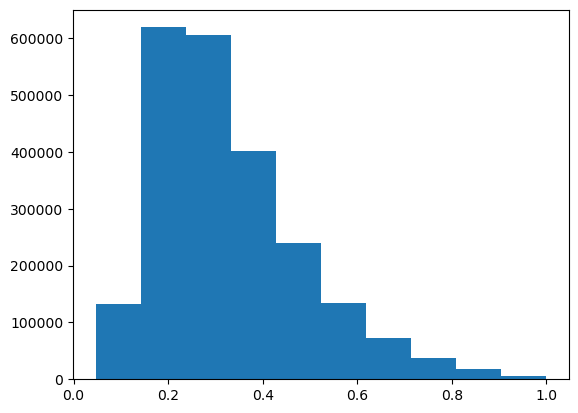

In [174]:
plt.hist(STRINGFullPhyBalancePhyla_BestHomologousDCAs_top5DCAs_LR_results)
plt.show()

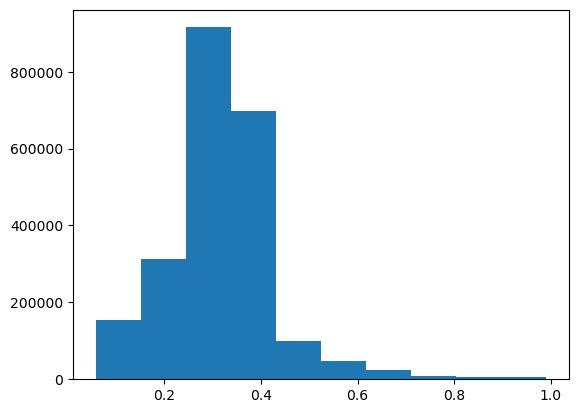

In [175]:
plt.hist(STRINGFullPhyBalancePhyla_BestHomologousDCAs_top5DCAs_RF_results)
plt.show()

In [176]:
%%time
Subject_maxDCAs_maxDCAofAllPhylum_frame_removeSTRINGFullPhyBalancePhylaTrainPP=pd.DataFrame([(Subject_PPs[i][0],Subject_PPs[i][1],Subject_maxDCAs[i],Subject_BestHomologousDCAs_top5DCAs_maxDCAs[i]) for i in range(len(Subject_PPs)) if (Subject_PPs[i][0],Subject_PPs[i][1]) not in STRINGFullPhyBalancePhyla_BestHomologousDCAs_top5DCAs_predicted_results_fixedNegVSposRratio_keepCombination_trainPPs],
                                                      columns=["p1","p2","maxDCA","maxDCAofAllPhylum"])

Subject_maxDCAs_maxDCAofAllPhylum_frame_removeSTRINGFullPhyBalancePhylaTrainPP=add_STRINGPhyPPI_status(Subject_maxDCAs_maxDCAofAllPhylum_frame_removeSTRINGFullPhyBalancePhylaTrainPP,STRINGcurrentSpePhyPPI_posPPI_dict)

Subject_maxDCAs_maxDCAofAllPhylum_frame_removeSTRINGFullPhyBalancePhylaTrainPP=add_pdbstatus(Subject_maxDCAs_maxDCAofAllPhylum_frame_removeSTRINGFullPhyBalancePhylaTrainPP,
                                                        pdb_interact_PPs_dict,
                                                        pdb_complex_PPs_dict,
                                                      status_colIdx=4
                                                       )


print(Subject_maxDCAs_maxDCAofAllPhylum_frame_removeSTRINGFullPhyBalancePhylaTrainPP.shape)

Subject_maxDCAs_maxDCAofAllPhylum_frame_longformat_removeSTRINGFullPhyBalancePhylaTrainPP= pd.melt(Subject_maxDCAs_maxDCAofAllPhylum_frame_removeSTRINGFullPhyBalancePhylaTrainPP, 
                                                            id_vars='pdb_status', 
                                                            value_vars=[f"maxDCA",f"maxDCAofAllPhylum"])

print(Subject_maxDCAs_maxDCAofAllPhylum_frame_longformat_removeSTRINGFullPhyBalancePhylaTrainPP.shape)




(2195701, 6)
(4391402, 3)
CPU times: user 12.6 s, sys: 1.92 s, total: 14.6 s
Wall time: 14.5 s


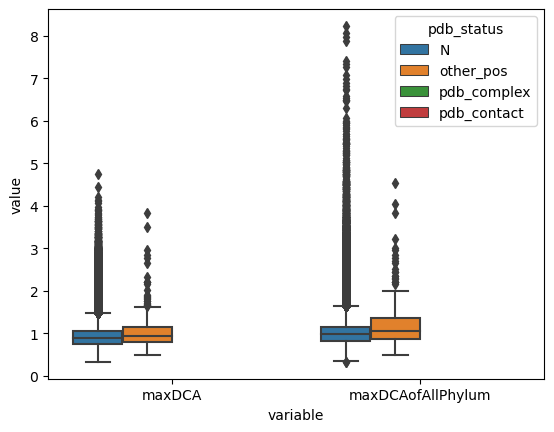

CPU times: user 2.79 s, sys: 343 ms, total: 3.13 s
Wall time: 2.89 s


In [177]:
%%time
# plt.figure(figsize=(8,6))

sns.boxplot(data=Subject_maxDCAs_maxDCAofAllPhylum_frame_longformat_removeSTRINGFullPhyBalancePhylaTrainPP,
             y="value",
             x="variable",
            hue="pdb_status",
            hue_order=["N","other_pos","pdb_complex","pdb_contact"]
            #hue_order=["N","pdb_complex","pdb_contact"],
            )
# plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()


In [178]:
%%time
STRINGFullPhyBalancePhyla_LRandRF_frame=pd.DataFrame([(Subject_PPs[i][0],Subject_PPs[i][1],STRINGFullPhyBalancePhyla_BestHomologousDCAs_top5DCAs_LR_results[i],STRINGFullPhyBalancePhyla_BestHomologousDCAs_top5DCAs_RF_results[i]) for i in range(len(Subject_PPs))],
                                                      columns=["p1","p2","LR","RF"])

STRINGFullPhyBalancePhyla_LRandRF_frame=add_STRINGPhyPPI_status(STRINGFullPhyBalancePhyla_LRandRF_frame,STRINGcurrentSpePhyPPI_posPPI_dict)

STRINGFullPhyBalancePhyla_LRandRF_frame=add_pdbstatus(STRINGFullPhyBalancePhyla_LRandRF_frame,
                                                        pdb_interact_PPs_dict,
                                                        pdb_complex_PPs_dict,
                                                      status_colIdx=4
                                                       )


print(STRINGFullPhyBalancePhyla_LRandRF_frame.shape)
STRINGFullPhyBalancePhyla_LRandRF_framee_longformat= pd.melt(STRINGFullPhyBalancePhyla_LRandRF_frame, 
                                                            id_vars='pdb_status', 
                                                            value_vars=[f"LR",f"RF"])

print(STRINGFullPhyBalancePhyla_LRandRF_framee_longformat.shape)

# Subject_LRandRF_frame.to_csv(Subject_Benchmark_folder+"Ecoli_LRandRF_frame.csv",
#                             header=True,index=None,sep="\t")




(2269192, 6)
(4538384, 3)
CPU times: user 11.6 s, sys: 795 ms, total: 12.4 s
Wall time: 12.4 s


#### saeve all2all results 

In [179]:


STRINGFullPhyBalancePhyla_DCAandLRandRF_frame=pd.DataFrame([(Subject_PPs[i][0],Subject_PPs[i][1],Subject_maxDCAs[i],STRINGFullPhyBalancePhyla_BestHomologousDCAs_top5DCAs_LR_results[i],STRINGFullPhyBalancePhyla_BestHomologousDCAs_top5DCAs_RF_results[i]) for i in range(len(Subject_PPs))],
                                                      columns=["p1","p2","maxDCA","LR","RF"])

STRINGFullPhyBalancePhyla_DCAandLRandRF_frame=add_STRINGPhyPPI_status(STRINGFullPhyBalancePhyla_DCAandLRandRF_frame,STRINGcurrentSpePhyPPI_posPPI_dict)

STRINGFullPhyBalancePhyla_DCAandLRandRF_frame=add_pdbstatus(STRINGFullPhyBalancePhyla_DCAandLRandRF_frame,
                                                        pdb_interact_PPs_dict,
                                                        pdb_complex_PPs_dict,
                                                      status_colIdx=4
                                                       )


STRINGFullPhyBalancePhyla_DCAandLRandRF_frame.to_csv("/mnt/mnemo5/tao/temp_figures/STRINGFullPhyBalancePhyla_DCAandLRandRF_frame.csv",
                                                    sep="\t",header=True,index=None)

print(STRINGFullPhyBalancePhyla_DCAandLRandRF_frame.shape)

(2269192, 7)


In [180]:
# Subject_top_DCA_dict[("511145.b0764","511145.b1800")]

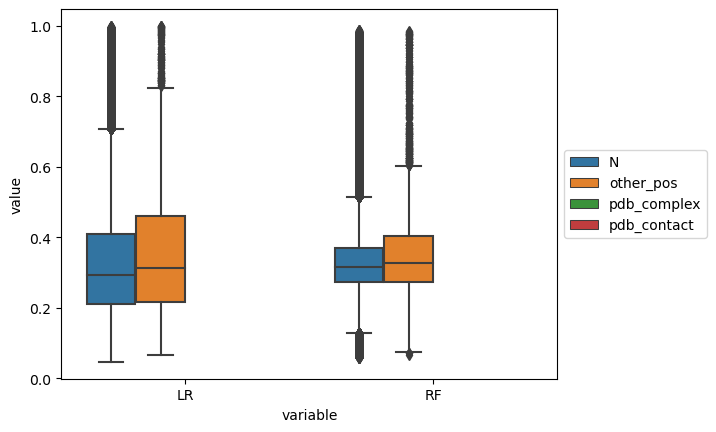

CPU times: user 3.05 s, sys: 320 ms, total: 3.37 s
Wall time: 3.13 s


In [181]:

%%time
# plt.figure(figsize=(8,6))

sns.boxplot(data=STRINGFullPhyBalancePhyla_LRandRF_framee_longformat,
             y="value",
             x="variable",
            hue="pdb_status",
            hue_order=["N","other_pos","pdb_complex","pdb_contact"]
            #hue_order=["N","pdb_complex","pdb_contact"],
            )
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()




In [182]:
%%time
STRINGFullPhyBalancePhyla_LRandRF_frame_removeTrainPP=pd.DataFrame([(Subject_PPs[i][0],Subject_PPs[i][1],STRINGFullPhyBalancePhyla_BestHomologousDCAs_top5DCAs_LR_results[i],STRINGFullPhyBalancePhyla_BestHomologousDCAs_top5DCAs_RF_results[i]) for i in range(len(Subject_PPs)) if (Subject_PPs[i][0],Subject_PPs[i][1]) not in STRINGFullPhyBalancePhyla_BestHomologousDCAs_top5DCAs_predicted_results_fixedNegVSposRratio_keepCombination_trainPPs],
                                                      columns=["p1","p2","LR","RF"])

STRINGFullPhyBalancePhyla_LRandRF_frame_removeTrainPP=add_STRINGPhyPPI_status(STRINGFullPhyBalancePhyla_LRandRF_frame_removeTrainPP,STRINGcurrentSpePhyPPI_posPPI_dict)

STRINGFullPhyBalancePhyla_LRandRF_frame_removeTrainPP=add_pdbstatus(STRINGFullPhyBalancePhyla_LRandRF_frame_removeTrainPP,
                                                        pdb_interact_PPs_dict,
                                                        pdb_complex_PPs_dict,
                                                      status_colIdx=4
                                                       )

print(STRINGFullPhyBalancePhyla_LRandRF_frame_removeTrainPP.shape)

STRINGFullPhyBalancePhyla_LRandRF_framee_longformat_removeTrainPP= pd.melt(STRINGFullPhyBalancePhyla_LRandRF_frame_removeTrainPP, 
                                                            id_vars='pdb_status', 
                                                            value_vars=[f"LR",f"RF"])
print(STRINGFullPhyBalancePhyla_LRandRF_framee_longformat_removeTrainPP.shape)





(2195701, 6)
(4391402, 3)
CPU times: user 12.3 s, sys: 1.07 s, total: 13.4 s
Wall time: 13.4 s


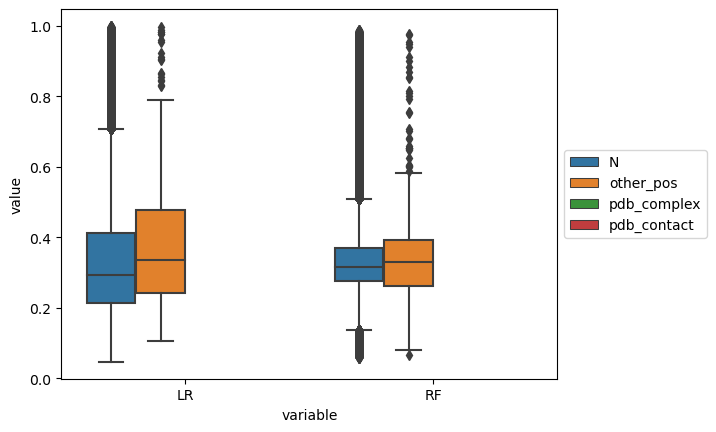

CPU times: user 2.96 s, sys: 227 ms, total: 3.19 s
Wall time: 2.95 s


In [183]:
%%time
# plt.figure(figsize=(8,6))

sns.boxplot(data=STRINGFullPhyBalancePhyla_LRandRF_framee_longformat_removeTrainPP,
             y="value",
             x="variable",
            hue="pdb_status",
            hue_order=["N","other_pos","pdb_complex","pdb_contact"]
            #hue_order=["N","pdb_complex","pdb_contact"],
            )
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()




###  t test show that why max dca of all phylum might work  (besides better alignment quality), same apply to phylum integration 
here on benchmark from machine learing training dataset 

transition problem or false positive ?


the things is for even negative , max DCA of all phylum also increase, could mean it actully contain some postive 
or its just false postive 
the fact that only for group pdb_contact is not afffect may indicate that its transition problem, 
because if its false postive all group should be affected in similar maner 
but if its transition problem, then it make sense these direct interaction  have simliar coevolution signal 
but for other groups, its values change depends on its connect with other protein pairs in other phylum ?



max dca of all phylum works it works better for pdb_complex  ?
make transition problem even greater ?

from this above plot, we can see after choosed max DCA of all phylum
pdb_concact and pdb_complex still much larget than negative category
but pdb_complex get most of incerase 




In [184]:

STRINGFullPhyBalancePhyla_fixedNegVSposRratio_keepCombination_PPs=STRINGFullPhyBalancePhyla_BestHomologousDCAs_top5DCAs_predicted_results_fixedNegVSposRratio_keepCombination_allPPI_allInfo_frame.loc[:,["STRING_ID1","STRING_ID2"]].values.tolist()
print(len(STRINGFullPhyBalancePhyla_fixedNegVSposRratio_keepCombination_PPs))


87663


In [185]:
%%time
STRINGFullPhyBalancePhyla_fixedNegVSposRratio_keepCombination_maxDCAs_maxDCAofAllPhylum_frame=pd.DataFrame([(p1,p2,Subject_maxDCAs_dict[(p1,p2)],Subject_BestHomologousDCAs_top5DCAs_maxDCAs_dict[(p1,p2)]) for p1,p2 in STRINGFullPhyBalancePhyla_fixedNegVSposRratio_keepCombination_PPs],
                                                      columns=["p1","p2","maxDCA","maxDCAofAllPhylum"])

STRINGFullPhyBalancePhyla_fixedNegVSposRratio_keepCombination_maxDCAs_maxDCAofAllPhylum_frame=add_STRINGPhyPPI_status(STRINGFullPhyBalancePhyla_fixedNegVSposRratio_keepCombination_maxDCAs_maxDCAofAllPhylum_frame,STRINGcurrentSpePhyPPI_posPPI_dict)

STRINGFullPhyBalancePhyla_fixedNegVSposRratio_keepCombination_maxDCAs_maxDCAofAllPhylum_frame=add_pdbstatus(STRINGFullPhyBalancePhyla_fixedNegVSposRratio_keepCombination_maxDCAs_maxDCAofAllPhylum_frame,
                                                        pdb_interact_PPs_dict,
                                                        pdb_complex_PPs_dict,
                                                      status_colIdx=4
                                                       )


print(STRINGFullPhyBalancePhyla_fixedNegVSposRratio_keepCombination_maxDCAs_maxDCAofAllPhylum_frame.shape)

STRINGFullPhyBalancePhyla_fixedNegVSposRratio_keepCombination_maxDCAs_maxDCAofAllPhylum_frame_longformat= pd.melt(STRINGFullPhyBalancePhyla_fixedNegVSposRratio_keepCombination_maxDCAs_maxDCAofAllPhylum_frame, 
                                                            id_vars='pdb_status', 
                                                            value_vars=[f"maxDCA",f"maxDCAofAllPhylum"])

print(STRINGFullPhyBalancePhyla_fixedNegVSposRratio_keepCombination_maxDCAs_maxDCAofAllPhylum_frame_longformat.shape)




(87663, 6)
(175326, 3)
CPU times: user 310 ms, sys: 44.2 ms, total: 355 ms
Wall time: 354 ms


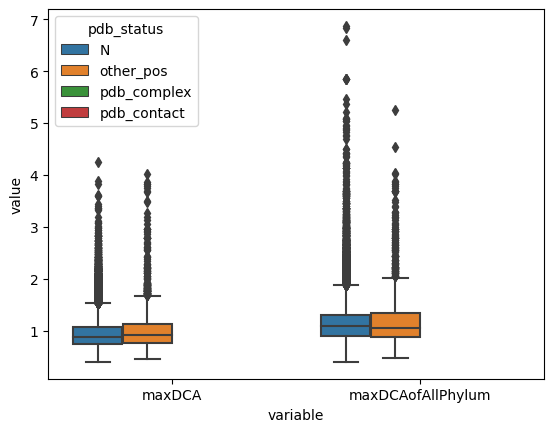

CPU times: user 287 ms, sys: 157 ms, total: 444 ms
Wall time: 233 ms


In [186]:
%%time
# plt.figure(figsize=(8,6))

sns.boxplot(data=STRINGFullPhyBalancePhyla_fixedNegVSposRratio_keepCombination_maxDCAs_maxDCAofAllPhylum_frame_longformat,
             y="value",
             x="variable",
            hue="pdb_status",
            hue_order=["N","other_pos","pdb_complex","pdb_contact"]
            #hue_order=["N","pdb_complex","pdb_contact"],
            )
# plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()


In [187]:
pdb_groups=["pdb_contact","pdb_complex","N"]#["N","other_pos","pdb_complex","pdb_contact",]


# alternative="greater"
for label in pdb_groups:
    
    print(f"{label}************")
    group = STRINGFullPhyBalancePhyla_fixedNegVSposRratio_keepCombination_maxDCAs_maxDCAofAllPhylum_frame[STRINGFullPhyBalancePhyla_fixedNegVSposRratio_keepCombination_maxDCAs_maxDCAofAllPhylum_frame['pdb_status']==label]

    test_statistic,test_pvalue=ttest_ind(group['maxDCAofAllPhylum'],group['maxDCA'], equal_var=False,)# alternative=alternative
    print("t_statistic,p_value:",test_statistic,test_pvalue)
    #Subject_maxDCs_statistics.loc[label1,label2]="{res:.2f}".format(res=test_statistic)+" , "+"{res:.2e}".format(res=test_pvalue)


pdb_contact************
t_statistic,p_value: nan nan
pdb_complex************
t_statistic,p_value: nan nan
N************
t_statistic,p_value: 132.40222644641202 0.0


In [188]:
pdb_groups=["pdb_contact","pdb_complex","N"]

fillin_matrix=np.zeros((3,3))
fillin_matrix[fillin_matrix==0]=np.nan

STRINGFullPhyBalancePhyla_fixedNegVSposRratio_keepCombination_maxDCAs_statistics=pd.DataFrame(fillin_matrix,
                                                      index=pdb_groups,
                                                      columns=pdb_groups,
                                                     )
STRINGFullPhyBalancePhyla_fixedNegVSposRratio_keepCombination_maxDCAofAllPhylum_statistics=pd.DataFrame(fillin_matrix,
                                                      index=pdb_groups,
                                                      columns=pdb_groups,
                                                     )

for i in range(len(pdb_groups)-1):
    for j in range(i+1,len(pdb_groups)):
        print(i,j)
        label1=pdb_groups[i]
        label2=pdb_groups[j]
        
        group1 = STRINGFullPhyBalancePhyla_fixedNegVSposRratio_keepCombination_maxDCAs_maxDCAofAllPhylum_frame[STRINGFullPhyBalancePhyla_fixedNegVSposRratio_keepCombination_maxDCAs_maxDCAofAllPhylum_frame['pdb_status']==label1]
        group2 = STRINGFullPhyBalancePhyla_fixedNegVSposRratio_keepCombination_maxDCAs_maxDCAofAllPhylum_frame[STRINGFullPhyBalancePhyla_fixedNegVSposRratio_keepCombination_maxDCAs_maxDCAofAllPhylum_frame['pdb_status']==label2]
        
        test_statistic,test_pvalue=ttest_ind(group1['maxDCA'], group2['maxDCA'], equal_var=False,)# alternative=alternative
        print(test_statistic,test_pvalue)
        STRINGFullPhyBalancePhyla_fixedNegVSposRratio_keepCombination_maxDCAs_statistics.loc[label1,label2]="{res:.2f}".format(res=test_statistic)+" , "+"{res:.2e}".format(res=test_pvalue)
#        STRINGFullPhyBalancePhyla_fixedNegVSposRratio_keepCombination_maxDCs_statistics.loc[label1,label2]=str(np.round(test_statistic,decimals=2))+"_"+str(np.round(test_pvalue,decimals=2))
        
        test_statistic,test_pvalue=ttest_ind(group1['maxDCAofAllPhylum'], group2['maxDCAofAllPhylum'], equal_var=False,) # alternative=alternative
        STRINGFullPhyBalancePhyla_fixedNegVSposRratio_keepCombination_maxDCAofAllPhylum_statistics.loc[label1,label2]="{res:.2f}".format(res=test_statistic)+" , "+"{res:.2e}".format(res=test_pvalue)


0 1
nan nan
0 2
nan nan
1 2
nan nan


In [189]:
STRINGFullPhyBalancePhyla_fixedNegVSposRratio_keepCombination_maxDCAs_statistics

pdb_contact pdb_complex          N
pdb_contact          NaN   nan , nan  nan , nan
pdb_complex          NaN         NaN  nan , nan
N                    NaN         NaN        NaN

In [190]:
STRINGFullPhyBalancePhyla_fixedNegVSposRratio_keepCombination_maxDCAofAllPhylum_statistics

pdb_contact pdb_complex          N
pdb_contact          NaN   nan , nan  nan , nan
pdb_complex          NaN         NaN  nan , nan
N                    NaN         NaN        NaN

In [191]:
# for RF model ,also check different for top 20 dca from one phylum or from different phylum
# differece in different pdb group a


### apply on string physical holdout and only get TPR(recall) and PPV(precision),foucus on pos prediction 
STRING115EggNog1224Spe511145_uniquePhyla_BestHomologousDCAs_top5DCAs_predicted_results_fixedNegVSposRratio_keepCombination_trainPPs a

In [192]:
print(len(STRINGcurrentSpePhyPPI_posPPI_dict))
print(len(STRINGFullPhyBalancePhyla_BestHomologousDCAs_top5DCAs_predicted_results_fixedNegVSposRratio_keepCombination_trainPPs))




15476
73491


In [193]:
print(len(Subject_PPs))

print(sum([1 for pp in Subject_PPs if pp in STRINGcurrentSpePhyPPI_posPPI_dict]))

# here we can see best control we get achieve is around 0.35

2269192
5532


In [194]:
STRINGcurrentSpePhyPPI_posPPI_dict_removeSTRINGFullPhyBalancePhylaTrainPP={pp:1 for pp in STRINGcurrentSpePhyPPI_posPPI_dict if pp not in STRINGFullPhyBalancePhyla_BestHomologousDCAs_top5DCAs_predicted_results_fixedNegVSposRratio_keepCombination_trainPPs }
print(len(STRINGcurrentSpePhyPPI_posPPI_dict_removeSTRINGFullPhyBalancePhylaTrainPP))


10861


In [195]:
# # maxDCA_thres=2#1.8
# # maxDCAofAllPhylum_thres=2 #2
# # lr_prob_thres=0.4#0.8
# rf_prob_thres=0.9#0.4 0.8

# # print(len(STRINGFullPhyBalancePhyla_BestHomologousDCAs_top5DCAs_LR_results))
# # STRINGFullPhyBalancePhyla_BestHomologousDCAs_top5DCAs_LR_posIdx=[idx for idx, prob in enumerate(STRINGFullPhyBalancePhyla_BestHomologousDCAs_top5DCAs_LR_results) if prob >lr_prob_thres]
# # STRINGFullPhyBalancePhyla_BestHomologousDCAs_top5DCAs_LR_pos_results=[STRINGFullPhyBalancePhyla_BestHomologousDCAs_top5DCAs_LR_results[idx] for idx in STRINGFullPhyBalancePhyla_BestHomologousDCAs_top5DCAs_LR_posIdx]
# # STRINGFullPhyBalancePhyla_BestHomologousDCAs_top5DCAs_LR_pos_PPs=[Subject_BestHomologousDCAs_top5DCAs_PPs[idx] for idx in STRINGFullPhyBalancePhyla_BestHomologousDCAs_top5DCAs_LR_posIdx]
# # print(len(STRINGFullPhyBalancePhyla_BestHomologousDCAs_top5DCAs_LR_pos_results))



# print(len(STRINGFullPhyBalancePhyla_BestHomologousDCAs_top5DCAs_RF_results))
# STRINGFullPhyBalancePhyla_BestHomologousDCAs_top5DCAs_RF_posIdx=[idx for idx, prob in enumerate(STRINGFullPhyBalancePhyla_BestHomologousDCAs_top5DCAs_RF_results) if prob >rf_prob_thres]
# STRINGFullPhyBalancePhyla_BestHomologousDCAs_top5DCAs_RF_pos_results=[STRINGFullPhyBalancePhyla_BestHomologousDCAs_top5DCAs_RF_results[idx] for idx in STRINGFullPhyBalancePhyla_BestHomologousDCAs_top5DCAs_RF_posIdx]
# STRINGFullPhyBalancePhyla_BestHomologousDCAs_top5DCAs_RF_pos_PPs=[Subject_BestHomologousDCAs_top5DCAs_PPs[idx] for idx in STRINGFullPhyBalancePhyla_BestHomologousDCAs_top5DCAs_RF_posIdx]
# print(len(STRINGFullPhyBalancePhyla_BestHomologousDCAs_top5DCAs_RF_pos_results))




# # print(len(Subject_BestHomologousDCAs_top5DCAs_maxDCAs))
# # STRINGFullPhyBalancePhyla_BestHomologousDCAs_top5DCAs_maxDCAs_posIdx=[idx for idx, dca in enumerate(Subject_BestHomologousDCAs_top5DCAs_maxDCAs) if dca >maxDCAofAllPhylum_thres]
# # STRINGFullPhyBalancePhyla_BestHomologousDCAs_top5DCAs_maxDCAs_pos=[Subject_BestHomologousDCAs_top5DCAs_maxDCAs[idx] for idx in Subject_BestHomologousDCAs_top5DCAs_maxDCAs_posIdx]
# # STRINGFullPhyBalancePhyla_BestHomologousDCAs_top5DCAs_PPs_pos=[Subject_BestHomologousDCAs_top5DCAs_PPs[idx] for idx in Subject_BestHomologousDCAs_top5DCAs_maxDCAs_posIdx]
# # print(len(STRINGFullPhyBalancePhyla_BestHomologousDCAs_top5DCAs_maxDCAs_pos))


# # print(len(Subject_maxDCAs))
# # STRINGFullPhyBalancePhyla_maxDCAs_posIdx=[idx for idx, dca in enumerate(Subject_maxDCAs) if dca >maxDCA_thres]
# # STRINGFullPhyBalancePhyla_maxDCAs_pos=[Subject_maxDCAs[idx] for idx in Subject_maxDCAs_posIdx]
# # STRINGFullPhyBalancePhyla_PPs_pos=[Subject_PPs[idx] for idx in Subject_maxDCAs_posIdx]
# # print(len(STRINGFullPhyBalancePhyla_maxDCAs_pos))



In [196]:
%%time

maxDCA_thres=None#1.5#1.8
maxDCAofAllPhylum_thres=None#1.5 #2
lr_prob_thres=None#0.4#0.8
rf_prob_thres=None#0.4#0.8

STRINGFullPhyBalancePhyla_maxDCAs_pos_removeTrainingByRemovedRatioInSTRINGPhy,STRINGFullPhyBalancePhyla_PPs_pos_removeTrainingByRemovedRatioInSTRINGPhy=\
removeTrainPPfrom_allPredictionResults_ByRemovedPosRatio(Subject_maxDCAs,
                                    Subject_PPs,
 STRINGFullPhyBalancePhyla_BestHomologousDCAs_top5DCAs_predicted_results_fixedNegVSposRratio_keepCombination_trainPPs,
   STRINGcurrentSpePhyPPI_posPPI_dict,
   maxDCA_thres, )


STRINGFullPhyBalancePhyla_BestHomologousDCAs_top5DCAs_maxDCAs_pos_removeTrainingByRemovedRatioInSTRINGPhy,STRINGFullPhyBalancePhyla_BestHomologousDCAs_top5DCAs_PPs_pos_removeTrainingByRemovedRatioInSTRINGPhy=\
removeTrainPPfrom_allPredictionResults_ByRemovedPosRatio(Subject_BestHomologousDCAs_top5DCAs_maxDCAs,
                                    Subject_BestHomologousDCAs_top5DCAs_PPs,
                                       
 STRINGFullPhyBalancePhyla_BestHomologousDCAs_top5DCAs_predicted_results_fixedNegVSposRratio_keepCombination_trainPPs,
STRINGcurrentSpePhyPPI_posPPI_dict,
    maxDCAofAllPhylum_thres,)



STRINGFullPhyBalancePhyla_BestHomologousDCAs_top5DCAs_LR_pos_results_removeTrainingByRemovedRatioInSTRINGPhy,STRINGFullPhyBalancePhyla_BestHomologousDCAs_top5DCAs_LR_pos_PPs_removeTrainingByRemovedRatioInSTRINGPhy=\
removeTrainPPfrom_allPredictionResults_ByRemovedPosRatio(STRINGFullPhyBalancePhyla_BestHomologousDCAs_top5DCAs_LR_results,
                                    Subject_BestHomologousDCAs_top5DCAs_PPs,
STRINGFullPhyBalancePhyla_BestHomologousDCAs_top5DCAs_predicted_results_fixedNegVSposRratio_keepCombination_trainPPs,
STRINGcurrentSpePhyPPI_posPPI_dict,lr_prob_thres,)



STRINGFullPhyBalancePhyla_BestHomologousDCAs_top5DCAs_RF_pos_results_removeTrainingByRemovedRatioInSTRINGPhy,STRINGFullPhyBalancePhyla_BestHomologousDCAs_top5DCAs_RF_pos_PPs_removeTrainingByRemovedRatioInSTRINGPhy=\
removeTrainPPfrom_allPredictionResults_ByRemovedPosRatio(STRINGFullPhyBalancePhyla_BestHomologousDCAs_top5DCAs_RF_results,
                                    Subject_BestHomologousDCAs_top5DCAs_PPs,
                                       
STRINGFullPhyBalancePhyla_BestHomologousDCAs_top5DCAs_predicted_results_fixedNegVSposRratio_keepCombination_trainPPs,
    STRINGcurrentSpePhyPPI_posPPI_dict,rf_prob_thres,)



2269192 2269192
len(result_posIdx),len(result_negIdx): 5532 2263660
len(pp_list_pos_kept): 917
len(pp_list_neg_kept):,before fix ratio 2194784
kept_ratio: 0.16576283441793202
len(result_list_pos_kept),len(result_list_neg_kept): 917 375230
376147 376147
2269192 2269192
len(result_posIdx),len(result_negIdx): 5532 2263660
len(pp_list_pos_kept): 917
len(pp_list_neg_kept):,before fix ratio 2194784
kept_ratio: 0.16576283441793202
len(result_list_pos_kept),len(result_list_neg_kept): 917 375230
376147 376147
2269192 2269192
len(result_posIdx),len(result_negIdx): 5532 2263660
len(pp_list_pos_kept): 917
len(pp_list_neg_kept):,before fix ratio 2194784
kept_ratio: 0.16576283441793202
len(result_list_pos_kept),len(result_list_neg_kept): 917 375230
376147 376147
2269192 2269192
len(result_posIdx),len(result_negIdx): 5532 2263660
len(pp_list_pos_kept): 917
len(pp_list_neg_kept):,before fix ratio 2194784
kept_ratio: 0.16576283441793202
len(result_list_pos_kept),len(result_list_neg_kept): 917 375230
37

In [197]:
917 /375230, 5532/2263660

(0.002443834448205101, 0.002443829903784137)

In [198]:
print(len(STRINGFullPhyBalancePhyla_PPs_pos_removeTrainingByRemovedRatioInSTRINGPhy))

print(sum([1 for pp in STRINGFullPhyBalancePhyla_PPs_pos_removeTrainingByRemovedRatioInSTRINGPhy if pp in STRINGcurrentSpePhyPPI_posPPI_dict]))
print(sum([1 for pp in STRINGFullPhyBalancePhyla_PPs_pos_removeTrainingByRemovedRatioInSTRINGPhy if pp in STRINGcurrentSpePhyPPI_posPPI_dict_removeSTRINGFullPhyBalancePhylaTrainPP]))

print(len(STRINGcurrentSpePhyPPI_posPPI_dict_removeSTRINGFullPhyBalancePhylaTrainPP))

376147
917
917
10861


In [199]:
%%time
step=1000
zoom_thres=None#None#100000  #2269192,30000, 300
print_results=True
# so here cant use independent benchmark, but use a benchmark with pos and neg and thier predeicion values 
# actullly they are same when get precision and recall since we dont need to use neg control anyway 
# Precison_Recall_RocCurve_OnlyGetRecallAndPrecision_OnIndepedentBenchmark(Pos_Prediction=STRINGFullPhyBalancePhyla_BestHomologousDCAs_top5DCAs_LR_results,
#                                                Pos_Prediction_PPs=Subject_BestHomologousDCAs_top5DCAs_PPs,
#                                                IndepedentBenchmark_pps_dict=STRINGcurrentSpePhyPPI_posPPI_dict, 
#                                                count_label="rate",
#                                                legend="STRINGFullPhyBalancePhyla Top20DCAsWithIntegration LR on STRING_Phy benchmark",
#                                                step=step,
#                                                zoom_thres=zoom_thres,
#                                                print_results=print_results,          
#                                               )


Precison_Recall_RocCurve_OnlyGetRecallAndPrecision_OnIndepedentBenchmark(Pos_Prediction=STRINGFullPhyBalancePhyla_BestHomologousDCAs_top5DCAs_RF_results,
                                               Pos_Prediction_PPs=Subject_BestHomologousDCAs_top5DCAs_PPs,
                                               IndepedentBenchmark_pps_dict=STRINGcurrentSpePhyPPI_posPPI_dict, 
                                               count_label="rate",
                                               legend="STRINGFullPhyBalancePhyla Top20DCAsWithIntegration RF on STRING_Phy benchmark",
                                               step=step,
                                               zoom_thres=zoom_thres,
                                               print_results=print_results,  
                                                return_bestF1=return_bestF1,
                                              )

Precison_Recall_RocCurve_OnlyGetRecallAndPrecision_OnIndepedentBenchmark(Pos_Prediction=Subject_maxDCAs,
                                               Pos_Prediction_PPs=Subject_PPs,
                                               IndepedentBenchmark_pps_dict=STRINGcurrentSpePhyPPI_posPPI_dict, 
                                               count_label="rate",
                                               legend="STRINGFullPhyBalancePhyla maxDCA on STRING_Phy benchmark",
                                               step=step,
                                               zoom_thres=zoom_thres,
                                               print_results=print_results,
                                                return_bestF1=return_bestF1,
                                              )


Precison_Recall_RocCurve_OnlyGetRecallAndPrecision_OnIndepedentBenchmark(Pos_Prediction=Subject_BestHomologousDCAs_top5DCAs_maxDCAs,
                                               Pos_Prediction_PPs=Subject_BestHomologousDCAs_top5DCAs_PPs,
                                               IndepedentBenchmark_pps_dict=STRINGcurrentSpePhyPPI_posPPI_dict, 
                                               count_label="rate",
                                               legend="STRINGFullPhyBalancePhyla maxDCA of All phylum on STRING_Phy benchmark",
                                               step=step,
                                               zoom_thres=zoom_thres,
                                               print_results=print_results,
                                               return_bestF1=return_bestF1,
                                              )



# plt.legend(  loc='upper right' )
plt.legend( bbox_to_anchor=(1.05, 1), loc='upper left' )
plt.show()
                                               
                                               
# when step=10, zoom_thres=30000, take arount 2 mins , each 
                                               

NameError: name 'return_bestF1' is not defined

In [200]:
%%time
step=1
zoom_thres=60000#None#100000  #2269192,30000, 300
print_results=True

Precison_Recall_RocCurve_OnlyGetRecallAndPrecision_OnIndepedentBenchmark(Pos_Prediction=STRINGFullPhyBalancePhyla_BestHomologousDCAs_top5DCAs_LR_pos_results_removeTrainingByRemovedRatioInSTRINGPhy,
                                               Pos_Prediction_PPs=STRINGFullPhyBalancePhyla_BestHomologousDCAs_top5DCAs_LR_pos_PPs_removeTrainingByRemovedRatioInSTRINGPhy,
                                               IndepedentBenchmark_pps_dict=STRINGcurrentSpePhyPPI_posPPI_dict_removeSTRINGFullPhyBalancePhylaTrainPP, 
                                               count_label="rate",
                                               legend="STRINGFullPhyBalancePhyla Top20DCAsWithIntegration LR on STRING_Phy_removeTraining benchmark",
                                               step=step,
                                               zoom_thres=zoom_thres,
                                               print_results=print_results,          
                                              )


Precison_Recall_RocCurve_OnlyGetRecallAndPrecision_OnIndepedentBenchmark(Pos_Prediction=STRINGFullPhyBalancePhyla_BestHomologousDCAs_top5DCAs_RF_pos_results_removeTrainingByRemovedRatioInSTRINGPhy,
                                                                         Pos_Prediction_PPs=STRINGFullPhyBalancePhyla_BestHomologousDCAs_top5DCAs_RF_pos_PPs_removeTrainingByRemovedRatioInSTRINGPhy,
                                               IndepedentBenchmark_pps_dict=STRINGcurrentSpePhyPPI_posPPI_dict_removeSTRINGFullPhyBalancePhylaTrainPP, 
                                               count_label="rate",
                                               legend="STRINGFullPhyBalancePhyla Top20DCAsWithIntegration RF on STRING_Phy_removeTraining benchmark",
                                               step=step,
                                               zoom_thres=zoom_thres,
                                               print_results=print_results,  
                                            return_bestF1=return_bestF1,
                                              )

Precison_Recall_RocCurve_OnlyGetRecallAndPrecision_OnIndepedentBenchmark(Pos_Prediction=STRINGFullPhyBalancePhyla_maxDCAs_pos_removeTrainingByRemovedRatioInSTRINGPhy,
                                               Pos_Prediction_PPs=STRINGFullPhyBalancePhyla_PPs_pos_removeTrainingByRemovedRatioInSTRINGPhy,
                                               IndepedentBenchmark_pps_dict=STRINGcurrentSpePhyPPI_posPPI_dict_removeSTRINGFullPhyBalancePhylaTrainPP, 
                                               count_label="rate",
                                               legend="STRINGFullPhyBalancePhyla maxDCA on STRING_Phy_removeTraining benchmark",
                                               step=step,
                                               zoom_thres=zoom_thres,
                                               print_results=print_results,
                                               return_bestF1=return_bestF1,
                                               
                                              )


Precison_Recall_RocCurve_OnlyGetRecallAndPrecision_OnIndepedentBenchmark(Pos_Prediction=STRINGFullPhyBalancePhyla_BestHomologousDCAs_top5DCAs_maxDCAs_pos_removeTrainingByRemovedRatioInSTRINGPhy,
                                               Pos_Prediction_PPs=STRINGFullPhyBalancePhyla_BestHomologousDCAs_top5DCAs_PPs_pos_removeTrainingByRemovedRatioInSTRINGPhy,
                                               IndepedentBenchmark_pps_dict=STRINGcurrentSpePhyPPI_posPPI_dict_removeSTRINGFullPhyBalancePhylaTrainPP, 
                                               count_label="rate",
                                               legend="STRINGFullPhyBalancePhyla maxDCA of All phylum on STRING_Phy_removeTraining benchmark",
                                               step=step,
                                               zoom_thres=zoom_thres,
                                               print_results=print_results,
                                            return_bestF1=return_bestF1,
                                               
                                              )



# plt.legend(  loc='upper right' )
plt.legend( bbox_to_anchor=(1.05, 1), loc='upper left' )
plt.show()
                                               
                                               
# when step=10, zoom_thres=30000, take arount 2 mins , each 
                                               

STRINGFullPhyBalancePhyla Top20DCAsWithIntegration LR on STRING_Phy_removeTraining benchmark:postiveControlCount:10861;allPredCount:60000;
Final F1, precision, recall,TP:  0.016 0.0095 0.0522 567.0


NameError: name 'return_bestF1' is not defined

In [201]:
# return_bestF1

### apply on pdb  inerract and complex  hold out (remove training ),,foucus on pos prediction 


In [202]:
print(len(pdb_PPs_dict))
print(len(STRINGFullPhyBalancePhyla_BestHomologousDCAs_top5DCAs_predicted_results_fixedNegVSposRratio_keepCombination_trainPPs))

pdb_PPs_dict_removeTrainingInSTRINGFullPhyBalancePhyla={k:v for k,v in pdb_PPs_dict.items() if k not in STRINGFullPhyBalancePhyla_BestHomologousDCAs_top5DCAs_predicted_results_fixedNegVSposRratio_keepCombination_trainPPs }
print(len(pdb_PPs_dict_removeTrainingInSTRINGFullPhyBalancePhyla))



3657
73491
1018


In [203]:
%%time

maxDCA_thres=None#1.5#1.8
maxDCAofAllPhylum_thres=None#1.5 #2
lr_prob_thres=None#0.4#0.8
rf_prob_thres=None#0.4#0.8

STRINGFullPhyBalancePhyla_maxDCAs_pos_removeTrainingByRemovedRatioInPDBB,STRINGFullPhyBalancePhyla_PPs_pos_removeTrainingByRemovedRatioInPDBB=\
removeTrainPPfrom_allPredictionResults_ByRemovedPosRatio(Subject_maxDCAs,
                                    Subject_PPs,
                                       
 STRINGFullPhyBalancePhyla_BestHomologousDCAs_top5DCAs_predicted_results_fixedNegVSposRratio_keepCombination_trainPPs,
   pdb_PPs_dict ,maxDCA_thres,)


STRINGFullPhyBalancePhyla_BestHomologousDCAs_top5DCAs_maxDCAs_pos_removeTrainingByRemovedRatioInPDBB,STRINGFullPhyBalancePhyla_BestHomologousDCAs_top5DCAs_PPs_pos_removeTrainingByRemovedRatioInPDBB=\
removeTrainPPfrom_allPredictionResults_ByRemovedPosRatio(Subject_BestHomologousDCAs_top5DCAs_maxDCAs,
                                    Subject_BestHomologousDCAs_top5DCAs_PPs,
                                       
 STRINGFullPhyBalancePhyla_BestHomologousDCAs_top5DCAs_predicted_results_fixedNegVSposRratio_keepCombination_trainPPs,
pdb_PPs_dict,maxDCAofAllPhylum_thres,)



STRINGFullPhyBalancePhyla_BestHomologousDCAs_top5DCAs_LR_pos_results_removeTrainingByRemovedRatioInPDBB,STRINGFullPhyBalancePhyla_BestHomologousDCAs_top5DCAs_LR_pos_PPs_removeTrainingByRemovedRatioInPDBB=\
removeTrainPPfrom_allPredictionResults_ByRemovedPosRatio(STRINGFullPhyBalancePhyla_BestHomologousDCAs_top5DCAs_LR_results,
                                    Subject_BestHomologousDCAs_top5DCAs_PPs,
                                       
 STRINGFullPhyBalancePhyla_BestHomologousDCAs_top5DCAs_predicted_results_fixedNegVSposRratio_keepCombination_trainPPs,
pdb_PPs_dict,lr_prob_thres,)



STRINGFullPhyBalancePhyla_BestHomologousDCAs_top5DCAs_RF_pos_results_removeTrainingByRemovedRatioInPDBB,STRINGFullPhyBalancePhyla_BestHomologousDCAs_top5DCAs_RF_pos_PPs_removeTrainingByRemovedRatioInPDBB=\
removeTrainPPfrom_allPredictionResults_ByRemovedPosRatio(STRINGFullPhyBalancePhyla_BestHomologousDCAs_top5DCAs_RF_results,
                                    Subject_BestHomologousDCAs_top5DCAs_PPs,
                                       
 STRINGFullPhyBalancePhyla_BestHomologousDCAs_top5DCAs_predicted_results_fixedNegVSposRratio_keepCombination_trainPPs,
    pdb_PPs_dict,rf_prob_thres,)



2269192 2269192
len(result_posIdx),len(result_negIdx): 3248 2265944
len(pp_list_pos_kept): 609
len(pp_list_neg_kept):,before fix ratio 2195092
kept_ratio: 0.1875
len(result_list_pos_kept),len(result_list_neg_kept): 609 424864
425473 425473
2269192 2269192
len(result_posIdx),len(result_negIdx): 3248 2265944
len(pp_list_pos_kept): 609
len(pp_list_neg_kept):,before fix ratio 2195092
kept_ratio: 0.1875
len(result_list_pos_kept),len(result_list_neg_kept): 609 424864
425473 425473
2269192 2269192
len(result_posIdx),len(result_negIdx): 3248 2265944
len(pp_list_pos_kept): 609
len(pp_list_neg_kept):,before fix ratio 2195092
kept_ratio: 0.1875
len(result_list_pos_kept),len(result_list_neg_kept): 609 424864
425473 425473
2269192 2269192
len(result_posIdx),len(result_negIdx): 3248 2265944
len(pp_list_pos_kept): 609
len(pp_list_neg_kept):,before fix ratio 2195092
kept_ratio: 0.1875
len(result_list_pos_kept),len(result_list_neg_kept): 609 424864
425473 425473
CPU times: user 12.5 s, sys: 210 ms, tot

In [204]:
3248/2265944,609 /375230

(0.0014333981775366028, 0.0016230045572049143)

In [205]:
%%time
step=100
zoom_thres=300000#None#100000  #2269192,30000, 300
print_results=True

Precison_Recall_RocCurve_OnlyGetRecallAndPrecision_OnIndepedentBenchmark(Pos_Prediction=STRINGFullPhyBalancePhyla_BestHomologousDCAs_top5DCAs_LR_results,
                                               Pos_Prediction_PPs=Subject_BestHomologousDCAs_top5DCAs_PPs,
                                               IndepedentBenchmark_pps_dict=pdb_PPs_dict, 
                                               count_label="rate",
                                               legend="STRINGFullPhyBalancePhyla Top20DCAsWithIntegration LR on pdb benchmark",
                                               step=step,
                                               zoom_thres=zoom_thres,
                                               print_results=print_results,  
                                                return_bestF1=return_bestF1,
                                              )


Precison_Recall_RocCurve_OnlyGetRecallAndPrecision_OnIndepedentBenchmark(Pos_Prediction=STRINGFullPhyBalancePhyla_BestHomologousDCAs_top5DCAs_RF_results,
                                               Pos_Prediction_PPs=Subject_BestHomologousDCAs_top5DCAs_PPs,
                                               IndepedentBenchmark_pps_dict=pdb_PPs_dict, 
                                               count_label="rate",
                                               legend="STRINGFullPhyBalancePhyla Top20DCAsWithIntegration RF on pdb benchmark",
                                               step=step,
                                               zoom_thres=zoom_thres,
                                               print_results=print_results,  
                                                return_bestF1=return_bestF1,
                                              )

Precison_Recall_RocCurve_OnlyGetRecallAndPrecision_OnIndepedentBenchmark(Pos_Prediction=Subject_maxDCAs,
                                               Pos_Prediction_PPs=Subject_PPs,
                                               IndepedentBenchmark_pps_dict=pdb_PPs_dict, 
                                               count_label="rate",
                                               legend="STRINGFullPhyBalancePhyla maxDCA on pdb benchmark",
                                               step=step,
                                               zoom_thres=zoom_thres,
                                               print_results=print_results,
                                               return_bestF1=return_bestF1,
                                               
                                              )


Precison_Recall_RocCurve_OnlyGetRecallAndPrecision_OnIndepedentBenchmark(Pos_Prediction=Subject_BestHomologousDCAs_top5DCAs_maxDCAs,
                                               Pos_Prediction_PPs=Subject_BestHomologousDCAs_top5DCAs_PPs,
                                               IndepedentBenchmark_pps_dict=pdb_PPs_dict, 
                                               count_label="rate",
                                               legend="STRINGFullPhyBalancePhyla maxDCA of All phylum on pdb benchmark",
                                               step=step,
                                               zoom_thres=zoom_thres,
                                               print_results=print_results,
                                               return_bestF1=return_bestF1,
                                              )



# plt.legend(  loc='upper right' )
plt.legend( bbox_to_anchor=(1.05, 1), loc='upper left' )

plt.show()                                          
                                               
# when step=10, zoom_thres=30000, take arount 2 mins , each 
                                               

NameError: name 'return_bestF1' is not defined

In [206]:
%%time
step=1
zoom_thres=30000#None#100000  #2269192,30000, 300
print_results=True

Precison_Recall_RocCurve_OnlyGetRecallAndPrecision_OnIndepedentBenchmark(Pos_Prediction=STRINGFullPhyBalancePhyla_BestHomologousDCAs_top5DCAs_LR_pos_results_removeTrainingByRemovedRatioInPDBB,
                                               Pos_Prediction_PPs=STRINGFullPhyBalancePhyla_BestHomologousDCAs_top5DCAs_LR_pos_PPs_removeTrainingByRemovedRatioInPDBB,
                                               IndepedentBenchmark_pps_dict=pdb_PPs_dict_removeTrainingInSTRINGFullPhyBalancePhyla, 
                                               count_label="rate",
                                               legend="STRINGFullPhyBalancePhyla Top20DCAsWithIntegration LR on pdb_removeTrainingByRemovedRatioInPDB benchmark",
                                               step=step,
                                               zoom_thres=zoom_thres,
                                               print_results=print_results,  
                                            return_bestF1=return_bestF1,
                                              )


Precison_Recall_RocCurve_OnlyGetRecallAndPrecision_OnIndepedentBenchmark(Pos_Prediction=STRINGFullPhyBalancePhyla_BestHomologousDCAs_top5DCAs_RF_pos_results_removeTrainingByRemovedRatioInPDBB,
                                                                         Pos_Prediction_PPs=STRINGFullPhyBalancePhyla_BestHomologousDCAs_top5DCAs_RF_pos_PPs_removeTrainingByRemovedRatioInPDBB,
                                               IndepedentBenchmark_pps_dict=pdb_PPs_dict_removeTrainingInSTRINGFullPhyBalancePhyla, 
                                               count_label="rate",
                                               legend="STRINGFullPhyBalancePhyla Top20DCAsWithIntegration RF on pdb_removeTrainingByRemovedRatioInPDB benchmark",
                                               step=step,
                                               zoom_thres=zoom_thres,
                                               print_results=print_results, 
                                            return_bestF1=return_bestF1,
                                              )

Precison_Recall_RocCurve_OnlyGetRecallAndPrecision_OnIndepedentBenchmark(Pos_Prediction=STRINGFullPhyBalancePhyla_maxDCAs_pos_removeTrainingByRemovedRatioInPDBB,
                                               Pos_Prediction_PPs=STRINGFullPhyBalancePhyla_PPs_pos_removeTrainingByRemovedRatioInPDBB,
                                               IndepedentBenchmark_pps_dict=pdb_PPs_dict_removeTrainingInSTRINGFullPhyBalancePhyla, 
                                               count_label="rate",
                                               legend="STRINGFullPhyBalancePhyla maxDCA on pdb_removeTrainingByRemovedRatioInPDB benchmark",
                                               step=step,
                                               zoom_thres=zoom_thres,
                                               print_results=print_results,
                                               return_bestF1=return_bestF1,
                                               
                                              )


Precison_Recall_RocCurve_OnlyGetRecallAndPrecision_OnIndepedentBenchmark(Pos_Prediction=STRINGFullPhyBalancePhyla_BestHomologousDCAs_top5DCAs_maxDCAs_pos_removeTrainingByRemovedRatioInPDBB,
                                               Pos_Prediction_PPs=STRINGFullPhyBalancePhyla_BestHomologousDCAs_top5DCAs_PPs_pos_removeTrainingByRemovedRatioInPDBB,
                                               IndepedentBenchmark_pps_dict=pdb_PPs_dict_removeTrainingInSTRINGFullPhyBalancePhyla, 
                                               count_label="rate",
                                               legend="STRINGFullPhyBalancePhyla maxDCA of All phylum on pdb_removeTrainingByRemovedRatioInPDB benchmark",
                                               step=step,
                                               zoom_thres=zoom_thres,
                                               print_results=print_results,
                                               return_bestF1=return_bestF1,
                                              )



# plt.legend(  loc='upper right' )
plt.legend( bbox_to_anchor=(1.05, 1), loc='upper left' )
plt.show()
                                               
                                               
# when step=10, zoom_thres=30000, take arount 2 mins , each 
                                               

NameError: name 'return_bestF1' is not defined

# do protein level APC of RF predicted probobility. 
/MNF/src/tao_utilities/coevolution_nomorlization.py
ML_folder

In [207]:
list(STRINGFullPhyBalancePhyla_BestHomologousDCAs_top5DCAs_RF_result_dict.items())[0]

(('511145.b2547', '511145.b4214'), 0.3157088829983574)

In [208]:
STRINGFullPhyBalancePhyla_BestHomologousDCAs_top5DCAs_RF_result_Listdict=dict()
for k,v in STRINGFullPhyBalancePhyla_BestHomologousDCAs_top5DCAs_RF_result_dict.items():
    STRINGFullPhyBalancePhyla_BestHomologousDCAs_top5DCAs_RF_result_Listdict[k]=[v]

In [209]:
list(STRINGFullPhyBalancePhyla_BestHomologousDCAs_top5DCAs_RF_result_Listdict.items())[0]

(('511145.b2547', '511145.b4214'), [0.3157088829983574])

In [210]:
%%time 
maxRFProb_pairwise_matrix=get_proteinLevel_pairwise_matrix_full(Uniquee_Ecoli_Pro,
                                                         Unique_Ecoli_idx2pro_dict,
                                                         STRINGFullPhyBalancePhyla_BestHomologousDCAs_top5DCAs_RF_result_Listdict,
                                                         topDCA_num=1,)


(2652, 2652)
2269192
CPU times: user 5.8 s, sys: 0 ns, total: 5.8 s
Wall time: 5.8 s


In [211]:
np.sum(~np.isnan(maxRFProb_pairwise_matrix))/2

2269192.0

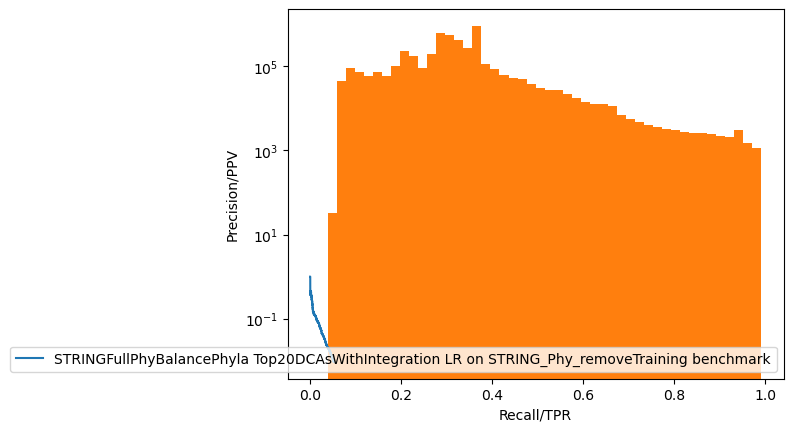

In [212]:
plt.yscale("log")
_=plt.hist(maxRFProb_pairwise_matrix.flatten(),bins=50,range=(0,np.nanmax(maxRFProb_pairwise_matrix)))

plt.show()

In [213]:
largeDCA_countList=np.sum(maxRFProb_pairwise_matrix>0.5,axis=0)

sum(largeDCA_countList>500)


76

In [214]:
%%time 
APCed_maxRFProb_pairwise_matrix=proteinLevel_APC(maxRFProb_pairwise_matrix)


pairwise_matrix_sum,pairwise_matrix_ave 1438857.532075089 0.3170418219514014
sum(pairwise_matrix_rowCount) 4538384
sum(pairwise_matrix_colCount) 4538384
pairwise_matrix.shape: (2652, 2652)
pairwise_matrix.shape[0]*pairwise_matrix.shape[1]: 7033104
np.where(pairwise_matrix_rowCount==0): (array([], dtype=int64),)
CPU times: user 6.79 s, sys: 0 ns, total: 6.79 s
Wall time: 6.79 s


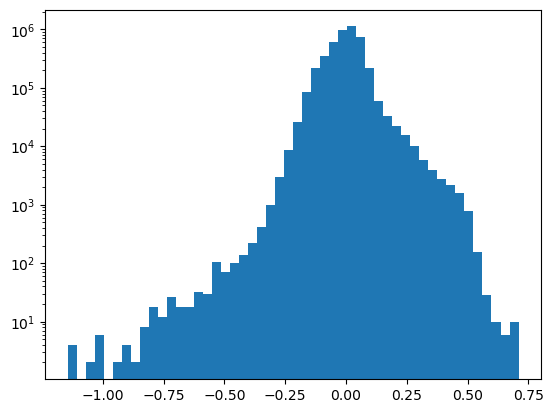

In [215]:

plt.yscale("log")
_=plt.hist(APCed_maxRFProb_pairwise_matrix.flatten(),bins=50,)

plt.show()

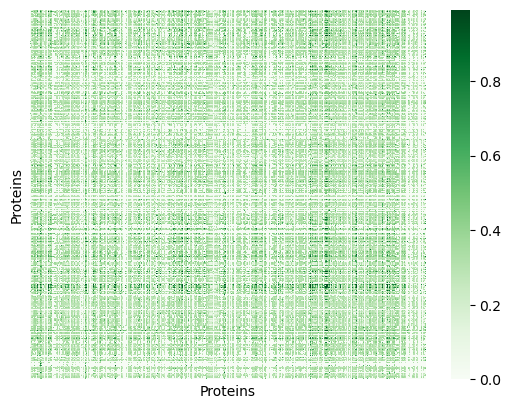

In [216]:
# %%time 
ax = sns.heatmap(np.nan_to_num(maxRFProb_pairwise_matrix),cmap="Greens",xticklabels=False,yticklabels=False)
plt.xlabel("Proteins")
plt.ylabel("Proteins")
plt.show()


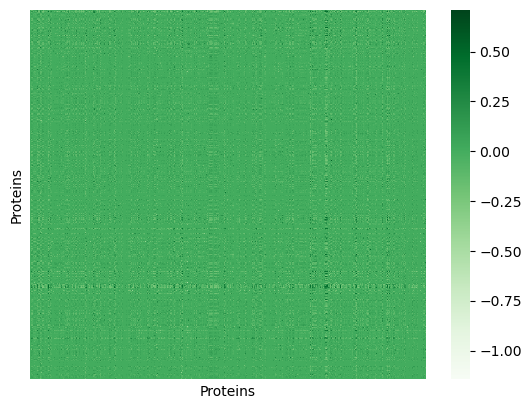

In [217]:
# %%time 
ax = sns.heatmap(np.nan_to_num(APCed_maxRFProb_pairwise_matrix),cmap="Greens",xticklabels=False,yticklabels=False)
plt.xlabel("Proteins")
plt.ylabel("Proteins")
plt.show()


# check why here is not smoothed 


In [218]:
APCed_maxRFProb_pairwise_matrix[0:3,0:20]

array([[        nan,  0.06410616,         nan,         nan,         nan,
                nan,         nan,         nan,         nan,         nan,
                nan,  0.02111772, -0.01088494,         nan, -0.04980691,
                nan,         nan,         nan,  0.01052555,         nan],
       [ 0.06410616,         nan,  0.07133919,  0.03023052, -0.13787707,
        -0.05989229,         nan,  0.09745475, -0.14530647,  0.02263044,
         0.07613072,  0.01266214, -0.11649769, -0.00279541, -0.07285308,
        -0.08596402,  0.14284711,  0.04401791, -0.12837425, -0.15476691],
       [        nan,  0.07133919,         nan,  0.03720028, -0.13588369,
        -0.01167571,         nan,  0.01507459, -0.14209888,  0.00328489,
         0.08570879,  0.08399674, -0.13258726,  0.08365561,  0.01485842,
        -0.10368498,  0.09036149,  0.04166898, -0.12783602, -0.15468458]])

In [219]:
maxRFProb_pairwise_matrix[0:3,0:20]


array([[       nan, 0.383971  ,        nan,        nan,        nan,
               nan,        nan,        nan,        nan,        nan,
               nan, 0.52052996, 0.293611  ,        nan, 0.34326115,
               nan,        nan,        nan, 0.33536749,        nan],
       [0.383971  ,        nan, 0.33089641, 0.29476172, 0.10960948,
        0.23085897,        nan, 0.3702155 , 0.07727105, 0.28163579,
        0.31539422, 0.35856617, 0.09440297, 0.20178951, 0.1993946 ,
        0.21341262, 0.432423  , 0.3222788 , 0.0966185 , 0.07653075],
       [       nan, 0.33089641,        nan, 0.34711846, 0.15406542,
        0.32896126,        nan, 0.33463432, 0.11866741, 0.30672913,
        0.36602397, 0.48924933, 0.11449873, 0.32334223, 0.33381706,
        0.24705727, 0.42962142, 0.36767255, 0.13575992, 0.11629803]])

In [220]:
%%time 
   
Subject_maxRFProbs_dict=dict()
for i in range(maxRFProb_pairwise_matrix.shape[0]):
    for j in range(maxRFProb_pairwise_matrix.shape[1]):
        if not np.isnan(maxRFProb_pairwise_matrix[i,j]):
            Subject_maxRFProbs_dict[tuple(sorted((Unique_Ecoli_idx2pro_dict[i],Unique_Ecoli_idx2pro_dict[j])))]=maxRFProb_pairwise_matrix[i,j]
print(len(Subject_maxRFProbs_dict))     

2269192
CPU times: user 18.3 s, sys: 0 ns, total: 18.3 s
Wall time: 18.3 s


In [221]:
%%time 
   
Subject_maxAPCedRFProbs_dict=dict()
for i in range(APCed_maxRFProb_pairwise_matrix.shape[0]):
    for j in range(APCed_maxRFProb_pairwise_matrix.shape[1]):
        if not np.isnan(APCed_maxRFProb_pairwise_matrix[i,j]):
            Subject_maxAPCedRFProbs_dict[tuple(sorted((Unique_Ecoli_idx2pro_dict[i],Unique_Ecoli_idx2pro_dict[j])))]=APCed_maxRFProb_pairwise_matrix[i,j]
print(len(Subject_maxAPCedRFProbs_dict))     

2269192
CPU times: user 18 s, sys: 0 ns, total: 18 s
Wall time: 18 s


In [222]:
%%time

Subject_maxRFProbs=[Subject_maxRFProbs_dict[pp] for pp in Subject_PPs]

Subject_maxAPCedRFProbs=[Subject_maxAPCedRFProbs_dict[pp] for pp in Subject_PPs]
Subject_maxAPCedRFProb_PPs=[pp for pp in Subject_PPs]


len(Subject_maxRFProbs)

CPU times: user 3.32 s, sys: 119 ms, total: 3.44 s
Wall time: 3.44 s


2269192

### show some statistics 

Welch’s t-Test in Pandas; https://www.statology.org/pandas-t-test/
https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.ttest_ind.html

aslo trim end? remove outlieer ??



In [223]:
%%time
Subject_maxAPCedRFProb_frame=pd.DataFrame([(Subject_PPs[i][0],Subject_PPs[i][1],Subject_maxRFProbs[i],Subject_maxAPCedRFProbs[i]) for i in range(len(Subject_PPs))],
                                                      columns=["p1","p2","maxRFProb","maxAPCedRFProb"])

Subject_maxAPCedRFProb_frame=add_STRINGPhyPPI_status(Subject_maxAPCedRFProb_frame,STRINGcurrentSpePhyPPI_posPPI_dict)

Subject_maxAPCedRFProb_frame=add_pdbstatus(Subject_maxAPCedRFProb_frame,
                                                        pdb_interact_PPs_dict,
                                                        pdb_complex_PPs_dict,
                                                      status_colIdx=4
                                                       )

Subject_maxAPCedRFProb_frame=Subject_maxAPCedRFProb_frame.loc[Subject_maxAPCedRFProb_frame["pdb_status"]!="other_pos",:]
# Subject_maxDCAsANDmaxAPCedDCAofAllPhylum_frame_longformat= pd.melt(Subject_maxDCAsANDmaxAPCedDCAofAllPhylum_frame, 
#                                                             id_vars='pdb_status', 
#                                                             value_vars=[f"maxDCA",f"maxAPCedDCAofAllPhylums"])






CPU times: user 14.9 s, sys: 2.22 s, total: 17.1 s
Wall time: 17.1 s


In [224]:
Subject_maxAPCedRFProb_frame

p1            p2  maxRFProb  maxAPCedRFProb  \
0        511145.b2547  511145.b4214   0.315709        0.029003   
1        511145.b1913  511145.b3965   0.139755       -0.080946   
2        511145.b1771  511145.b2074   0.286935        0.028379   
3        511145.b3166  511145.b4099   0.366358        0.054174   
4        511145.b1094  511145.b1237   0.866588        0.226740   
...               ...           ...        ...             ...   
2269187  511145.b0764  511145.b1800   0.205924       -0.043349   
2269188  511145.b3303  511145.b3733   0.525088        0.182801   
2269189  511145.b2282  511145.b4506   0.760112        0.181207   
2269190  511145.b0792  511145.b4025   0.296611        0.044776   
2269191  511145.b0827  511145.b2158   0.297979        0.051648   

        STRINGPhy_status pdb_status  
0                      N          N  
1                      N          N  
2                      N          N  
3                      N          N  
4                      N          N  
...                  ...        ...  
2269187                N          N  
2269188                N          N  
2269189                N          N  
2269190                N          N  
2269191                N          N  

[2266908 rows x 6 columns]

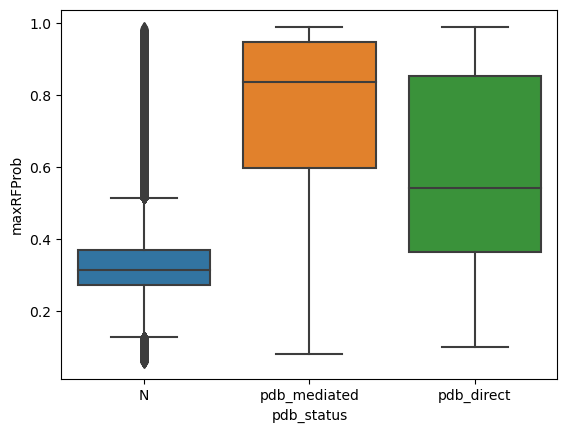

CPU times: user 1.23 s, sys: 188 ms, total: 1.41 s
Wall time: 1.17 s


In [225]:
%%time
# plt.figure(figsize=(8,6))

sns.boxplot(data=Subject_maxAPCedRFProb_frame,
             y="maxRFProb",
             x="pdb_status",
            #hue="pdb_status",
            #hue_order=["N","other_pos","pdb_complex","pdb_contact"]
            #hue_order=["N","pdb_complex","pdb_contact"],
            )
# plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()


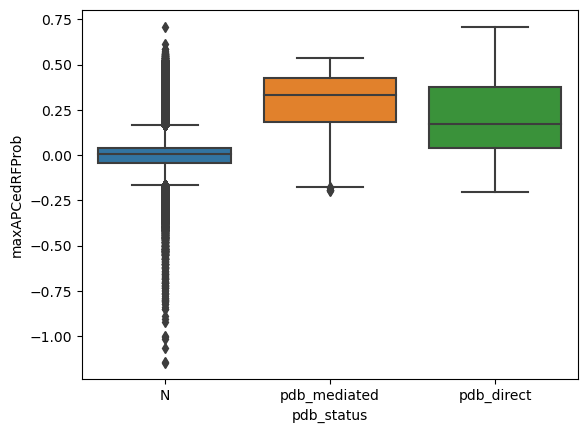

CPU times: user 907 ms, sys: 195 ms, total: 1.1 s
Wall time: 863 ms


In [226]:
%%time
# plt.figure(figsize=(8,6))

sns.boxplot(data=Subject_maxAPCedRFProb_frame,
             y="maxAPCedRFProb",
             x="pdb_status",
            #hue="pdb_status",
            #hue_order=["N","other_pos","pdb_complex","pdb_contact"]
            #hue_order=["N","pdb_complex","pdb_contact"],
            )
# plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()


In [227]:
set(Subject_maxAPCedRFProb_frame["pdb_status"])

{'N', 'pdb_direct', 'pdb_mediated'}

In [228]:
pdb_groups=["pdb_direct","pdb_mediated","N"]

fillin_matrix=np.zeros((3,3))
fillin_matrix[fillin_matrix==0]=np.nan

Subject_maxRFProbs_statistics=pd.DataFrame(fillin_matrix,
                                                      index=pdb_groups,
                                                      columns=pdb_groups,
                                                     )
Subject_maxAPCedRFProbs_statistics=pd.DataFrame(fillin_matrix,
                                                      index=pdb_groups,
                                                      columns=pdb_groups,
                                                     )

alternative="greater"
for i in range(len(pdb_groups)-1):
    for j in range(i+1,len(pdb_groups)):
        print(i,j)
        label1=pdb_groups[i]
        label2=pdb_groups[j]
        
        group1 = Subject_maxAPCedRFProb_frame[Subject_maxAPCedRFProb_frame['pdb_status']==label1]
        group2 = Subject_maxAPCedRFProb_frame[Subject_maxAPCedRFProb_frame['pdb_status']==label2]
        
        test_statistic,test_pvalue=ttest_ind(group1['maxRFProb'], group2['maxRFProb'], equal_var=False,)# alternative=alternative
        print(test_statistic,test_pvalue)
        Subject_maxRFProbs_statistics.loc[label1,label2]="{res:.2f}".format(res=test_statistic)+" , "+"{res:.2e}".format(res=test_pvalue)
#        Subject_maxDCs_statistics.loc[label1,label2]=str(np.round(test_statistic,decimals=2))+"_"+str(np.round(test_pvalue,decimals=2))
        
        test_statistic,test_pvalue=ttest_ind(group1['maxAPCedRFProb'], group2['maxAPCedRFProb'], equal_var=False,) # alternative=alternative
        Subject_maxAPCedRFProbs_statistics.loc[label1,label2]="{res:.2f}".format(res=test_statistic)+" , "+"{res:.2e}".format(res=test_pvalue)


0 1
-11.142754563278633 9.280897967733574e-25
0 2
17.310737788194764 9.865963185001405e-47
1 2
107.16728716237424 0.0


#### t test table 
add results to  CoEvolutionIntegration_Paper_all_sup_tables.numbers/protein level apc t-test

In [229]:
Subject_maxRFProbs_statistics

pdb_direct       pdb_mediated                  N
pdb_direct           NaN  -11.14 , 9.28e-25   17.31 , 9.87e-47
pdb_mediated         NaN                NaN  107.17 , 0.00e+00
N                    NaN                NaN                NaN

In [230]:
Subject_maxAPCedRFProbs_statistics

pdb_direct      pdb_mediated                 N
pdb_direct           NaN  -7.37 , 1.37e-12  17.62 , 6.84e-48
pdb_mediated         NaN               NaN  95.13 , 0.00e+00
N                    NaN               NaN               NaN

In [231]:
# help(ttest_ind)

### draw plot 

In [232]:
%%time
print("*******")
Subject_pdb_interact_statusDict={pp: s for pp,s in Subject_pdb_statusDict.items() if ((s=="N") or (pp in pdb_interact_PPs_dict))}
print(len(Subject_pdb_interact_statusDict))
Subject_pdb_interact_maxRFProbs=np.array([Subject_maxRFProbs_dict[pp] for pp ,s in Subject_pdb_interact_statusDict.items()])
Subject_pdb_interact_maxAPCedRFProbs=np.array([Subject_maxAPCedRFProbs_dict[pp] for pp ,s in Subject_pdb_interact_statusDict.items()])
Subject_pdb_interact_PPs=np.array([0 if s=="N" else 1 for pp ,s in Subject_pdb_interact_statusDict.items()])
print((sum(Subject_pdb_interact_PPs)))

print("*******")
Subject_pdb_complex_statusDict={pp: s for pp,s in Subject_pdb_statusDict.items() if ((s=="N") or (pp in pdb_complex_PPs_dict))}
print(len(Subject_pdb_complex_statusDict))
Subject_pdb_complex_maxRFProbs=np.array([Subject_maxRFProbs_dict[pp] for pp ,s in Subject_pdb_complex_statusDict.items()])
Subject_pdb_complex_maxAPCedRFProbs=np.array([Subject_maxAPCedRFProbs_dict[pp] for pp ,s in Subject_pdb_complex_statusDict.items()])
Subject_pdb_complex_PPs=np.array([0 if s=="N" else 1  for pp ,s in Subject_pdb_complex_statusDict.items()])
print(sum(Subject_pdb_complex_PPs))


print("*******")
Subject_pdb_complex_noRibosome_statusDict={pp: s for pp,s in Subject_pdb_statusDict.items() if ((s=="N") or (pp in pdb_complex_noRibosome_PPs_dict))}
print(len(Subject_pdb_complex_noRibosome_statusDict))
Subject_pdb_complex_noRibosome_maxRFProbs=np.array([Subject_maxRFProbs_dict[pp] for pp ,s in Subject_pdb_complex_noRibosome_statusDict.items()])
Subject_pdb_complex_noRibosome_maxAPCedRFProbs=np.array([Subject_maxAPCedRFProbs_dict[pp] for pp ,s in Subject_pdb_complex_noRibosome_statusDict.items()])
Subject_pdb_complex_noRibosome_PPs=np.array([0 if s=="N" else 1  for pp ,s in Subject_pdb_complex_noRibosome_statusDict.items()])
print(sum(Subject_pdb_complex_noRibosome_PPs))


print("*******")
Subject_pdb_complex_oneRibosome_statusDict={pp: s for pp,s in Subject_pdb_statusDict.items() if ((s=="N") or (pp in pdb_complex_oneRibosome_PPs_dict))}
print(len(Subject_pdb_complex_oneRibosome_statusDict))
Subject_pdb_complex_oneRibosome_maxRFProbs=np.array([Subject_maxRFProbs_dict[pp] for pp ,s in Subject_pdb_complex_oneRibosome_statusDict.items()])
Subject_pdb_complex_oneRibosome_maxAPCedRFProbs=np.array([Subject_maxAPCedRFProbs_dict[pp] for pp ,s in Subject_pdb_complex_oneRibosome_statusDict.items()])
Subject_pdb_complex_oneRibosome_PPs=np.array([0 if s=="N" else 1 for pp ,s in Subject_pdb_complex_oneRibosome_statusDict.items()])
print(sum(Subject_pdb_complex_oneRibosome_PPs))

print("*******")
Subject_pdb_complex_twoRibosome_statusDict={pp: s for pp,s in Subject_pdb_statusDict.items() if ((s=="N") or (pp in pdb_complex_twoRibosome_PPs_dict))}
print(len(Subject_pdb_complex_twoRibosome_statusDict))
Subject_pdb_complex_twoRibosome_maxRFProbs=np.array([Subject_maxRFProbs_dict[pp] for pp ,s in Subject_pdb_complex_twoRibosome_statusDict.items()])
Subject_pdb_complex_twoRibosome_maxAPCedRFProbs=np.array([Subject_maxAPCedRFProbs_dict[pp] for pp ,s in Subject_pdb_complex_twoRibosome_statusDict.items()])
Subject_pdb_complex_twoRibosome_PPs=np.array([0 if s=="N" else 1  for pp ,s in Subject_pdb_complex_twoRibosome_statusDict.items()])
print(sum(Subject_pdb_complex_twoRibosome_PPs))




*******
2263954
294
*******
2266614
2954
*******
2263706
46
*******
2264991
1331
*******
2265237
1577
CPU times: user 25.9 s, sys: 265 ms, total: 26.1 s
Wall time: 26.2 s


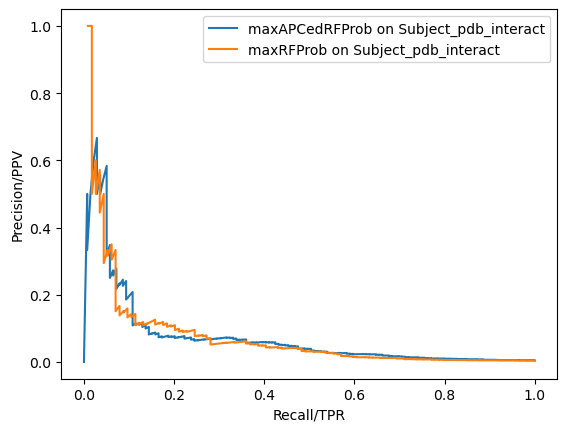

CPU times: user 5.17 s, sys: 126 ms, total: 5.29 s
Wall time: 5.14 s


In [234]:
%%time
step=1
zoom_thres=30000 #30000#30000  #2269192, 30000, 300

Precison_Recall_RocCurve(Subject_pdb_interact_maxAPCedRFProbs,
                                               Subject_pdb_interact_PPs,
                                               legend="maxAPCedRFProb on Subject_pdb_interact",
                                               step=step,
                                               zoom_thres=zoom_thres,
                                              )

Precison_Recall_RocCurve(Subject_pdb_interact_maxRFProbs,
                                               Subject_pdb_interact_PPs,
                                               legend="maxRFProb on Subject_pdb_interact",
                                               step=step,
                                               zoom_thres=zoom_thres,
                                              )

plt.legend(  loc='upper right' )
plt.show()
                                               
                       

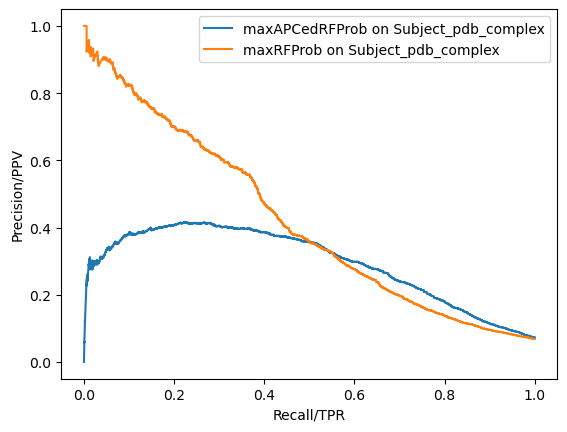

CPU times: user 5.75 s, sys: 158 ms, total: 5.91 s
Wall time: 5.71 s


In [235]:
%%time
step=1
zoom_thres=30000 #30000#30000  #2269192, 30000, 300

Precison_Recall_RocCurve(Subject_pdb_complex_maxAPCedRFProbs,
                                               Subject_pdb_complex_PPs,
                                               legend="maxAPCedRFProb on Subject_pdb_complex",
                                               step=step,
                                               zoom_thres=zoom_thres,
                                              )

Precison_Recall_RocCurve(Subject_pdb_complex_maxRFProbs,
                                               Subject_pdb_complex_PPs,
                                               legend="maxRFProb on Subject_pdb_complex",
                                               step=step,
                                               zoom_thres=zoom_thres,
                                              )

plt.legend(  loc='upper right' )

                                               
plt.show()                       

this is not final model, just to check what happen if we also utlise missing -1 signal 
#  use new and without fix ratio full  STRINGPhyBalancePhyla  phylum integration machine leanrin model 

In [236]:



#https://stackoverflow.com/questions/34143829/sklearn-how-to-save-a-model-created-from-a-pipeline-and-gridsearchcv-using-jobli
with open(os.path.join(STRINGFullPhyBalancePhyla_Benchmark_folder,
                       f"STRING115EggNog1224Spe511145_uniquePhyla_BestHomologousDCAs_top5DCAs_predicted_results_LR.pickle"),"rb") as f:
    STRINGOriRatioPhyBalancePhyla_BestHomologousDCAs_top5DCAs_predicted_results_LR_bestModel=pickle.load(f)
    
    
    
#https://stackoverflow.com/questions/34143829/sklearn-how-to-save-a-model-created-from-a-pipeline-and-gridsearchcv-using-jobli
with open(os.path.join(STRINGFullPhyBalancePhyla_Benchmark_folder,
                       f"STRING115EggNog1224Spe511145_uniquePhyla_BestHomologousDCAs_top5DCAs_predicted_results_RF.pickle"),"rb") as f:
    STRINGOriRatioPhyBalancePhyla_BestHomologousDCAs_top5DCAs_predicted_results_RF_bestModel=pickle.load(f)
    
    
    
with open(os.path.join(STRINGFullPhyBalancePhyla_Benchmark_folder,
                       f"STRING115EggNog1224Spe511145_uniquePhyla_BestHomologousDCAs_top5DCAs_predicted_results_trainPPs.pickle"),"rb") as f:
    STRINGOriRatioPhyBalancePhyla_BestHomologousDCAs_top5DCAs_predicted_results_trainPPs=pickle.load(f)
    
STRINGOriRatioPhyBalancePhyla_BestHomologousDCAs_top5DCAs_predicted_results_trainPPs=\
{pp:1 for pp in STRINGOriRatioPhyBalancePhyla_BestHomologousDCAs_top5DCAs_predicted_results_trainPPs}
    
print(STRINGOriRatioPhyBalancePhyla_BestHomologousDCAs_top5DCAs_predicted_results_RF_bestModel.get_params())
    

{'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': {1: 10}, 'criterion': 'gini', 'max_depth': 8, 'max_features': 5, 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_impurity_split': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 500, 'n_jobs': 4, 'oob_score': False, 'random_state': 0, 'verbose': 0, 'warm_start': False}


In [237]:
STRINGOriRatioPhyBalancePhyla_BestHomologousDCAs_top5DCAs_predicted_results_allPPI_allInfo_frame=pd.read_csv(\
os.path.join("/mnt/mnemo6/tao/PPI_Coevolution/CoEvo_data_STRING11.5/allPPI_511145_EggNOGmaxLevel1224_eggNOGfilteredData/STRINGFullPhyBalancePhyla_Benchmark/STRING115EggNog1224Spe511145_uniquePhyla_BestHomologousDCAs_top5DCAs_predicted_results_allPPI_allInfo_frame.csv"),
header=0,index_col=None)

In [238]:
print(len(STRINGOriRatioPhyBalancePhyla_BestHomologousDCAs_top5DCAs_predicted_results_trainPPs))



370709


In [239]:
%%time 
STRINGOriRatioPhyBalancePhyla_BestHomologousDCAs_top5DCAs_LR_results=STRINGOriRatioPhyBalancePhyla_BestHomologousDCAs_top5DCAs_predicted_results_LR_bestModel.predict_proba(Subject_BestHomologousDCAs_top5DCAs_npArray)[:,1]


# CPU times: user 1.43 s, sys: 4.96 s, total: 6.39 s
# Wall time: 89.6 ms

CPU times: user 1.29 s, sys: 4.84 s, total: 6.13 s
Wall time: 75.4 ms


In [240]:
%%time 
STRINGOriRatioPhyBalancePhyla_BestHomologousDCAs_top5DCAs_RF_results=STRINGOriRatioPhyBalancePhyla_BestHomologousDCAs_top5DCAs_predicted_results_RF_bestModel.predict_proba(Subject_BestHomologousDCAs_top5DCAs_npArray)[:,1]

# CPU times: user 2min 51s, sys: 3.58 s, total: 2min 54s
# Wall time: 2min 54s

CPU times: user 54.4 s, sys: 5.45 s, total: 59.8 s
Wall time: 14 s


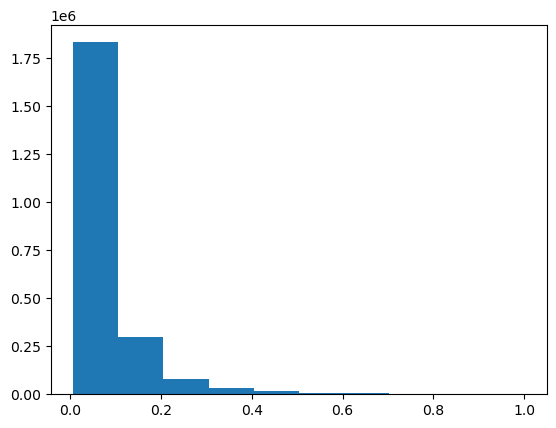

In [241]:
plt.hist(STRINGOriRatioPhyBalancePhyla_BestHomologousDCAs_top5DCAs_LR_results)
plt.show()

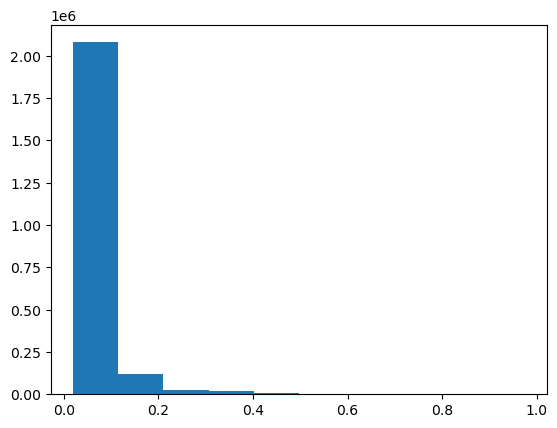

In [242]:
plt.hist(STRINGOriRatioPhyBalancePhyla_BestHomologousDCAs_top5DCAs_RF_results)
plt.show()

In [243]:
%%time
Subject_maxDCAs_maxDCAofAllPhylum_frame_removeSTRINGOriRatioPhyBalancePhylaTrainPP=pd.DataFrame([(Subject_PPs[i][0],Subject_PPs[i][1],Subject_maxDCAs[i],Subject_BestHomologousDCAs_top5DCAs_maxDCAs[i]) for i in range(len(Subject_PPs)) if (Subject_PPs[i][0],Subject_PPs[i][1]) not in STRINGOriRatioPhyBalancePhyla_BestHomologousDCAs_top5DCAs_predicted_results_trainPPs],
                                                      columns=["p1","p2","maxDCA","maxDCAofAllPhylum"])

Subject_maxDCAs_maxDCAofAllPhylum_frame_removeSTRINGOriRatioPhyBalancePhylaTrainPP=add_STRINGPhyPPI_status(Subject_maxDCAs_maxDCAofAllPhylum_frame_removeSTRINGOriRatioPhyBalancePhylaTrainPP,STRINGcurrentSpePhyPPI_posPPI_dict)

Subject_maxDCAs_maxDCAofAllPhylum_frame_removeSTRINGOriRatioPhyBalancePhylaTrainPP=add_pdbstatus(Subject_maxDCAs_maxDCAofAllPhylum_frame_removeSTRINGOriRatioPhyBalancePhylaTrainPP,
                                                        pdb_interact_PPs_dict,
                                                        pdb_complex_PPs_dict,
                                                      status_colIdx=4
                                                       )


print(Subject_maxDCAs_maxDCAofAllPhylum_frame_removeSTRINGOriRatioPhyBalancePhylaTrainPP.shape)

Subject_maxDCAs_maxDCAofAllPhylum_frame_longformat_removeSTRINGOriRatioPhyBalancePhylaTrainPP= pd.melt(Subject_maxDCAs_maxDCAofAllPhylum_frame_removeSTRINGOriRatioPhyBalancePhylaTrainPP, 
                                                            id_vars='pdb_status', 
                                                            value_vars=[f"maxDCA",f"maxDCAofAllPhylum"])

print(Subject_maxDCAs_maxDCAofAllPhylum_frame_longformat_removeSTRINGOriRatioPhyBalancePhylaTrainPP.shape)




(1898483, 6)
(3796966, 3)
CPU times: user 13.1 s, sys: 1.97 s, total: 15.1 s
Wall time: 15 s


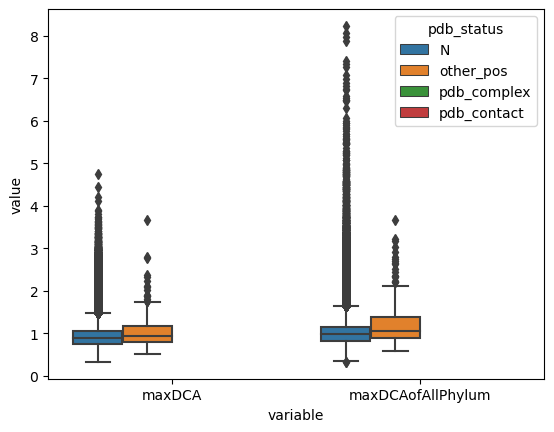

CPU times: user 2.46 s, sys: 208 ms, total: 2.66 s
Wall time: 2.42 s


In [244]:
%%time
# plt.figure(figsize=(8,6))

sns.boxplot(data=Subject_maxDCAs_maxDCAofAllPhylum_frame_longformat_removeSTRINGOriRatioPhyBalancePhylaTrainPP,
             y="value",
             x="variable",
            hue="pdb_status",
            hue_order=["N","other_pos","pdb_complex","pdb_contact"]
            #hue_order=["N","pdb_complex","pdb_contact"],
            )
# plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()


In [245]:
%%time
STRINGOriRatioPhyBalancePhyla_LRandRF_frame=pd.DataFrame([(Subject_PPs[i][0],Subject_PPs[i][1],STRINGOriRatioPhyBalancePhyla_BestHomologousDCAs_top5DCAs_LR_results[i],STRINGOriRatioPhyBalancePhyla_BestHomologousDCAs_top5DCAs_RF_results[i]) for i in range(len(Subject_PPs))],
                                                      columns=["p1","p2","LR","RF"])

STRINGOriRatioPhyBalancePhyla_LRandRF_frame=add_STRINGPhyPPI_status(STRINGOriRatioPhyBalancePhyla_LRandRF_frame,STRINGcurrentSpePhyPPI_posPPI_dict)

STRINGOriRatioPhyBalancePhyla_LRandRF_frame=add_pdbstatus(STRINGOriRatioPhyBalancePhyla_LRandRF_frame,
                                                        pdb_interact_PPs_dict,
                                                        pdb_complex_PPs_dict,
                                                      status_colIdx=4
                                                       )


print(STRINGOriRatioPhyBalancePhyla_LRandRF_frame.shape)
STRINGOriRatioPhyBalancePhyla_LRandRF_framee_longformat= pd.melt(STRINGOriRatioPhyBalancePhyla_LRandRF_frame, 
                                                            id_vars='pdb_status', 
                                                            value_vars=[f"LR",f"RF"])

print(STRINGOriRatioPhyBalancePhyla_LRandRF_framee_longformat.shape)

# Subject_LRandRF_frame.to_csv(Subject_Benchmark_folder+"Ecoli_LRandRF_frame.csv",
#                             header=True,index=None,sep="\t")




(2269192, 6)
(4538384, 3)
CPU times: user 12.4 s, sys: 833 ms, total: 13.2 s
Wall time: 13.2 s


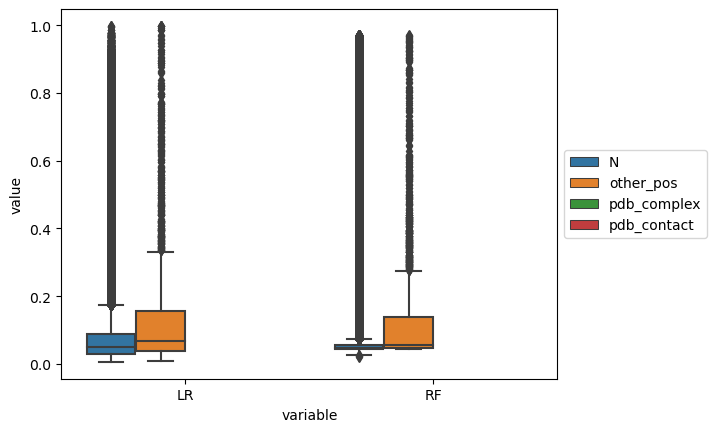

CPU times: user 3.52 s, sys: 313 ms, total: 3.83 s
Wall time: 3.6 s


In [246]:

%%time
# plt.figure(figsize=(8,6))

sns.boxplot(data=STRINGOriRatioPhyBalancePhyla_LRandRF_framee_longformat,
             y="value",
             x="variable",
            hue="pdb_status",
            hue_order=["N","other_pos","pdb_complex","pdb_contact"]
            #hue_order=["N","pdb_complex","pdb_contact"],
            )
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()




In [247]:
%%time
STRINGOriRatioPhyBalancePhyla_LRandRF_frame_removeTrainPP=pd.DataFrame([(Subject_PPs[i][0],Subject_PPs[i][1],STRINGOriRatioPhyBalancePhyla_BestHomologousDCAs_top5DCAs_LR_results[i],STRINGOriRatioPhyBalancePhyla_BestHomologousDCAs_top5DCAs_RF_results[i]) for i in range(len(Subject_PPs)) if (Subject_PPs[i][0],Subject_PPs[i][1]) not in STRINGOriRatioPhyBalancePhyla_BestHomologousDCAs_top5DCAs_predicted_results_trainPPs],
                                                      columns=["p1","p2","LR","RF"])

STRINGOriRatioPhyBalancePhyla_LRandRF_frame_removeTrainPP=add_STRINGPhyPPI_status(STRINGOriRatioPhyBalancePhyla_LRandRF_frame_removeTrainPP,STRINGcurrentSpePhyPPI_posPPI_dict)

STRINGOriRatioPhyBalancePhyla_LRandRF_frame_removeTrainPP=add_pdbstatus(STRINGOriRatioPhyBalancePhyla_LRandRF_frame_removeTrainPP,
                                                        pdb_interact_PPs_dict,
                                                        pdb_complex_PPs_dict,
                                                      status_colIdx=4
                                                       )

print(STRINGOriRatioPhyBalancePhyla_LRandRF_frame_removeTrainPP.shape)

STRINGOriRatioPhyBalancePhyla_LRandRF_framee_longformat_removeTrainPP= pd.melt(STRINGOriRatioPhyBalancePhyla_LRandRF_frame_removeTrainPP, 
                                                            id_vars='pdb_status', 
                                                            value_vars=[f"LR",f"RF"])
print(STRINGOriRatioPhyBalancePhyla_LRandRF_framee_longformat_removeTrainPP.shape)





(1898483, 6)
(3796966, 3)
CPU times: user 12.3 s, sys: 590 ms, total: 12.9 s
Wall time: 12.9 s


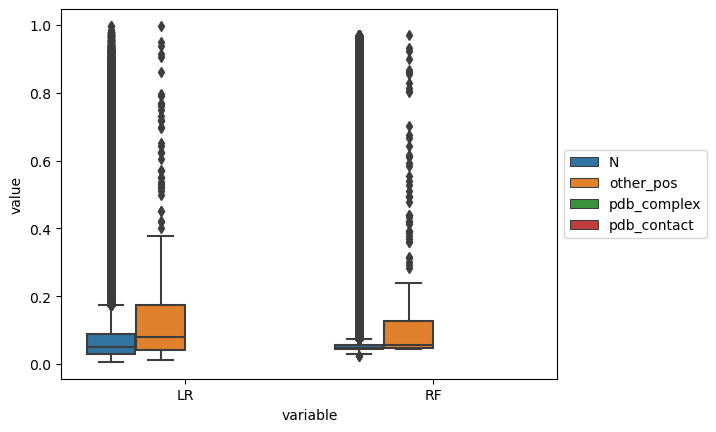

CPU times: user 2.97 s, sys: 224 ms, total: 3.2 s
Wall time: 2.96 s


In [248]:
%%time
# plt.figure(figsize=(8,6))

sns.boxplot(data=STRINGOriRatioPhyBalancePhyla_LRandRF_framee_longformat_removeTrainPP,
             y="value",
             x="variable",
            hue="pdb_status",
            hue_order=["N","other_pos","pdb_complex","pdb_contact"]
            #hue_order=["N","pdb_complex","pdb_contact"],
            )
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()




### apply on string physical holdout and only get TPR(recall) and PPV(precision),foucus on pos prediction 
STRING115EggNog1224Spe511145_uniquePhyla_BestHomologousDCAs_top5DCAs_predicted_results_trainPPs a

In [249]:
print(len(STRINGcurrentSpePhyPPI_posPPI_dict))
print(len(STRINGOriRatioPhyBalancePhyla_BestHomologousDCAs_top5DCAs_predicted_results_trainPPs))




15476
370709


In [250]:
print(len(Subject_PPs))

print(sum([1 for pp in Subject_PPs if pp in STRINGcurrentSpePhyPPI_posPPI_dict]))

# here we can see best control we get achieve is around 0.35

2269192
5532


In [251]:
STRINGcurrentSpePhyPPI_posPPI_dict_removeSTRINGOriRatioPhyBalancePhylaTrainPP={pp:1 for pp in STRINGcurrentSpePhyPPI_posPPI_dict if pp not in STRINGOriRatioPhyBalancePhyla_BestHomologousDCAs_top5DCAs_predicted_results_trainPPs }
print(len(STRINGcurrentSpePhyPPI_posPPI_dict_removeSTRINGOriRatioPhyBalancePhylaTrainPP))


10887


In [252]:
# maxDCA_thres=2#1.8
# maxDCAofAllPhylum_thres=2 #2
# lr_prob_thres=0.4#0.8
# rf_prob_thres=0.4#0.8

# print(len(STRINGOriRatioPhyBalancePhyla_BestHomologousDCAs_top5DCAs_LR_results))
# STRINGOriRatioPhyBalancePhyla_BestHomologousDCAs_top5DCAs_LR_posIdx=[idx for idx, prob in enumerate(STRINGOriRatioPhyBalancePhyla_BestHomologousDCAs_top5DCAs_LR_results) if prob >lr_prob_thres]
# STRINGOriRatioPhyBalancePhyla_BestHomologousDCAs_top5DCAs_LR_pos_results=[STRINGOriRatioPhyBalancePhyla_BestHomologousDCAs_top5DCAs_LR_results[idx] for idx in STRINGOriRatioPhyBalancePhyla_BestHomologousDCAs_top5DCAs_LR_posIdx]
# STRINGOriRatioPhyBalancePhyla_BestHomologousDCAs_top5DCAs_LR_pos_PPs=[Subject_BestHomologousDCAs_top5DCAs_PPs[idx] for idx in STRINGOriRatioPhyBalancePhyla_BestHomologousDCAs_top5DCAs_LR_posIdx]
# print(len(STRINGOriRatioPhyBalancePhyla_BestHomologousDCAs_top5DCAs_LR_pos_results))



# print(len(STRINGOriRatioPhyBalancePhyla_BestHomologousDCAs_top5DCAs_RF_results))
# STRINGOriRatioPhyBalancePhyla_BestHomologousDCAs_top5DCAs_RF_posIdx=[idx for idx, prob in enumerate(STRINGOriRatioPhyBalancePhyla_BestHomologousDCAs_top5DCAs_RF_results) if prob >rf_prob_thres]
# STRINGOriRatioPhyBalancePhyla_BestHomologousDCAs_top5DCAs_RF_pos_results=[STRINGOriRatioPhyBalancePhyla_BestHomologousDCAs_top5DCAs_RF_results[idx] for idx in STRINGOriRatioPhyBalancePhyla_BestHomologousDCAs_top5DCAs_RF_posIdx]
# STRINGOriRatioPhyBalancePhyla_BestHomologousDCAs_top5DCAs_RF_pos_PPs=[Subject_BestHomologousDCAs_top5DCAs_PPs[idx] for idx in STRINGOriRatioPhyBalancePhyla_BestHomologousDCAs_top5DCAs_RF_posIdx]
# print(len(STRINGOriRatioPhyBalancePhyla_BestHomologousDCAs_top5DCAs_RF_pos_results))




# print(len(Subject_BestHomologousDCAs_top5DCAs_maxDCAs))
# STRINGOriRatioPhyBalancePhyla_BestHomologousDCAs_top5DCAs_maxDCAs_posIdx=[idx for idx, dca in enumerate(Subject_BestHomologousDCAs_top5DCAs_maxDCAs) if dca >maxDCAofAllPhylum_thres]
# STRINGOriRatioPhyBalancePhyla_BestHomologousDCAs_top5DCAs_maxDCAs_pos=[Subject_BestHomologousDCAs_top5DCAs_maxDCAs[idx] for idx in Subject_BestHomologousDCAs_top5DCAs_maxDCAs_posIdx]
# STRINGOriRatioPhyBalancePhyla_BestHomologousDCAs_top5DCAs_PPs_pos=[Subject_BestHomologousDCAs_top5DCAs_PPs[idx] for idx in Subject_BestHomologousDCAs_top5DCAs_maxDCAs_posIdx]
# print(len(STRINGOriRatioPhyBalancePhyla_BestHomologousDCAs_top5DCAs_maxDCAs_pos))


# print(len(Subject_maxDCAs))
# STRINGOriRatioPhyBalancePhyla_maxDCAs_posIdx=[idx for idx, dca in enumerate(Subject_maxDCAs) if dca >maxDCA_thres]
# STRINGOriRatioPhyBalancePhyla_maxDCAs_pos=[Subject_maxDCAs[idx] for idx in Subject_maxDCAs_posIdx]
# STRINGOriRatioPhyBalancePhyla_PPs_pos=[Subject_PPs[idx] for idx in Subject_maxDCAs_posIdx]
# print(len(STRINGOriRatioPhyBalancePhyla_maxDCAs_pos))



In [253]:
%%time

maxDCA_thres=None#1.5#1.8
maxDCAofAllPhylum_thres=None#1.5 #2
lr_prob_thres=None#0.4#0.8
rf_prob_thres=None#0.4#0.8

STRINGOriRatioPhyBalancePhyla_maxDCAs_pos_removeTrainingByRemovedRatioInSTRINGPhy,STRINGOriRatioPhyBalancePhyla_PPs_pos_removeTrainingByRemovedRatioInSTRINGPhy=\
removeTrainPPfrom_allPredictionResults_ByRemovedPosRatio(Subject_maxDCAs,
                                    Subject_PPs,
 STRINGOriRatioPhyBalancePhyla_BestHomologousDCAs_top5DCAs_predicted_results_trainPPs,
   STRINGcurrentSpePhyPPI_posPPI_dict,
   maxDCA_thres, )


STRINGOriRatioPhyBalancePhyla_BestHomologousDCAs_top5DCAs_maxDCAs_pos_removeTrainingByRemovedRatioInSTRINGPhy,STRINGOriRatioPhyBalancePhyla_BestHomologousDCAs_top5DCAs_PPs_pos_removeTrainingByRemovedRatioInSTRINGPhy=\
removeTrainPPfrom_allPredictionResults_ByRemovedPosRatio(Subject_BestHomologousDCAs_top5DCAs_maxDCAs,
                                    Subject_BestHomologousDCAs_top5DCAs_PPs,
                                       
 STRINGOriRatioPhyBalancePhyla_BestHomologousDCAs_top5DCAs_predicted_results_trainPPs,
STRINGcurrentSpePhyPPI_posPPI_dict,
    maxDCAofAllPhylum_thres,)



STRINGOriRatioPhyBalancePhyla_BestHomologousDCAs_top5DCAs_LR_pos_results_removeTrainingByRemovedRatioInSTRINGPhy,STRINGOriRatioPhyBalancePhyla_BestHomologousDCAs_top5DCAs_LR_pos_PPs_removeTrainingByRemovedRatioInSTRINGPhy=\
removeTrainPPfrom_allPredictionResults_ByRemovedPosRatio(STRINGOriRatioPhyBalancePhyla_BestHomologousDCAs_top5DCAs_LR_results,
                                    Subject_BestHomologousDCAs_top5DCAs_PPs,
STRINGOriRatioPhyBalancePhyla_BestHomologousDCAs_top5DCAs_predicted_results_trainPPs,
STRINGcurrentSpePhyPPI_posPPI_dict,lr_prob_thres,)



STRINGOriRatioPhyBalancePhyla_BestHomologousDCAs_top5DCAs_RF_pos_results_removeTrainingByRemovedRatioInSTRINGPhy,STRINGOriRatioPhyBalancePhyla_BestHomologousDCAs_top5DCAs_RF_pos_PPs_removeTrainingByRemovedRatioInSTRINGPhy=\
removeTrainPPfrom_allPredictionResults_ByRemovedPosRatio(STRINGOriRatioPhyBalancePhyla_BestHomologousDCAs_top5DCAs_RF_results,
                                    Subject_BestHomologousDCAs_top5DCAs_PPs,
                                       
STRINGOriRatioPhyBalancePhyla_BestHomologousDCAs_top5DCAs_predicted_results_trainPPs,
    STRINGcurrentSpePhyPPI_posPPI_dict,rf_prob_thres,)



2269192 2269192
len(result_posIdx),len(result_negIdx): 5532 2263660
len(pp_list_pos_kept): 943
len(pp_list_neg_kept):,before fix ratio 1897540
kept_ratio: 0.17046276211135214
len(result_list_pos_kept),len(result_list_neg_kept): 943 385869
386812 386812
2269192 2269192
len(result_posIdx),len(result_negIdx): 5532 2263660
len(pp_list_pos_kept): 943
len(pp_list_neg_kept):,before fix ratio 1897540
kept_ratio: 0.17046276211135214
len(result_list_pos_kept),len(result_list_neg_kept): 943 385869
386812 386812
2269192 2269192
len(result_posIdx),len(result_negIdx): 5532 2263660
len(pp_list_pos_kept): 943
len(pp_list_neg_kept):,before fix ratio 1897540
kept_ratio: 0.17046276211135214
len(result_list_pos_kept),len(result_list_neg_kept): 943 385869
386812 386812
2269192 2269192
len(result_posIdx),len(result_negIdx): 5532 2263660
len(pp_list_pos_kept): 943
len(pp_list_neg_kept):,before fix ratio 1897540
kept_ratio: 0.17046276211135214
len(result_list_pos_kept),len(result_list_neg_kept): 943 385869
38

In [254]:
print(len(STRINGOriRatioPhyBalancePhyla_PPs_pos_removeTrainingByRemovedRatioInSTRINGPhy))

print(sum([1 for pp in STRINGOriRatioPhyBalancePhyla_PPs_pos_removeTrainingByRemovedRatioInSTRINGPhy if pp in STRINGcurrentSpePhyPPI_posPPI_dict]))
print(sum([1 for pp in STRINGOriRatioPhyBalancePhyla_PPs_pos_removeTrainingByRemovedRatioInSTRINGPhy if pp in STRINGcurrentSpePhyPPI_posPPI_dict_removeSTRINGOriRatioPhyBalancePhylaTrainPP]))

print(len(STRINGcurrentSpePhyPPI_posPPI_dict_removeSTRINGOriRatioPhyBalancePhylaTrainPP))

386812
943
943
10887


In [255]:
%%time
step=1000
zoom_thres=None#None#100000  #2269192,30000, 300
print_results=True
# so here cant use independent benchmark, but use a benchmark with pos and neg and thier predeicion values 
# actullly they are same when get precision and recall since we dont need to use neg control anyway 
Precison_Recall_RocCurve_OnlyGetRecallAndPrecision_OnIndepedentBenchmark(Pos_Prediction=STRINGOriRatioPhyBalancePhyla_BestHomologousDCAs_top5DCAs_LR_results,
                                               Pos_Prediction_PPs=Subject_BestHomologousDCAs_top5DCAs_PPs,
                                               IndepedentBenchmark_pps_dict=STRINGcurrentSpePhyPPI_posPPI_dict, 
                                               count_label="rate",
                                               legend="STRINGOriRatioPhyBalancePhyla Top20DCAsWithIntegration LR on STRING_Phy benchmark",
                                               step=step,
                                               zoom_thres=zoom_thres,
                                               print_results=print_results,      
                                                return_bestF1=return_bestF1,
                                              )


Precison_Recall_RocCurve_OnlyGetRecallAndPrecision_OnIndepedentBenchmark(Pos_Prediction=STRINGOriRatioPhyBalancePhyla_BestHomologousDCAs_top5DCAs_RF_results,
                                               Pos_Prediction_PPs=Subject_BestHomologousDCAs_top5DCAs_PPs,
                                               IndepedentBenchmark_pps_dict=STRINGcurrentSpePhyPPI_posPPI_dict, 
                                               count_label="rate",
                                               legend="STRINGOriRatioPhyBalancePhyla Top20DCAsWithIntegration RF on STRING_Phy benchmark",
                                               step=step,
                                               zoom_thres=zoom_thres,
                                               print_results=print_results, 
                                                return_bestF1=return_bestF1,
                                              )

Precison_Recall_RocCurve_OnlyGetRecallAndPrecision_OnIndepedentBenchmark(Pos_Prediction=Subject_maxDCAs,
                                               Pos_Prediction_PPs=Subject_PPs,
                                               IndepedentBenchmark_pps_dict=STRINGcurrentSpePhyPPI_posPPI_dict, 
                                               count_label="rate",
                                               legend="STRINGOriRatioPhyBalancePhyla maxDCA on STRING_Phy benchmark",
                                               step=step,
                                               zoom_thres=zoom_thres,
                                               print_results=print_results,   
                                            return_bestF1=return_bestF1,
                                              )


Precison_Recall_RocCurve_OnlyGetRecallAndPrecision_OnIndepedentBenchmark(Pos_Prediction=Subject_BestHomologousDCAs_top5DCAs_maxDCAs,
                                               Pos_Prediction_PPs=Subject_BestHomologousDCAs_top5DCAs_PPs,
                                               IndepedentBenchmark_pps_dict=STRINGcurrentSpePhyPPI_posPPI_dict, 
                                               count_label="rate",
                                               legend="STRINGOriRatioPhyBalancePhyla maxDCA of All phylum on STRING_Phy benchmark",
                                               step=step,
                                               zoom_thres=zoom_thres,
                                               print_results=print_results,
                                               return_bestF1=return_bestF1,
                                              )



# plt.legend(  loc='upper right' )
plt.legend( bbox_to_anchor=(1.05, 1), loc='upper left' )
plt.show()
                                               
                                               
# when step=10, zoom_thres=30000, take arount 2 mins , each 
                                               

NameError: name 'return_bestF1' is not defined

In [256]:
%%time
step=1
zoom_thres=60000#None#100000  #2269192,30000, 300
print_results=True

Precison_Recall_RocCurve_OnlyGetRecallAndPrecision_OnIndepedentBenchmark(Pos_Prediction=STRINGOriRatioPhyBalancePhyla_BestHomologousDCAs_top5DCAs_LR_pos_results_removeTrainingByRemovedRatioInSTRINGPhy,
                                               Pos_Prediction_PPs=STRINGOriRatioPhyBalancePhyla_BestHomologousDCAs_top5DCAs_LR_pos_PPs_removeTrainingByRemovedRatioInSTRINGPhy,
                                               IndepedentBenchmark_pps_dict=STRINGcurrentSpePhyPPI_posPPI_dict_removeSTRINGOriRatioPhyBalancePhylaTrainPP, 
                                               count_label="rate",
                                               legend="STRINGOriRatioPhyBalancePhyla Top20DCAsWithIntegration LR on STRING_Phy_removeTraining benchmark",
                                               step=step,
                                               zoom_thres=zoom_thres,
                                               print_results=print_results,  
                                            return_bestF1=return_bestF1,
                                              )


Precison_Recall_RocCurve_OnlyGetRecallAndPrecision_OnIndepedentBenchmark(Pos_Prediction=STRINGOriRatioPhyBalancePhyla_BestHomologousDCAs_top5DCAs_RF_pos_results_removeTrainingByRemovedRatioInSTRINGPhy,
                                                                         Pos_Prediction_PPs=STRINGOriRatioPhyBalancePhyla_BestHomologousDCAs_top5DCAs_RF_pos_PPs_removeTrainingByRemovedRatioInSTRINGPhy,
                                               IndepedentBenchmark_pps_dict=STRINGcurrentSpePhyPPI_posPPI_dict_removeSTRINGOriRatioPhyBalancePhylaTrainPP, 
                                               count_label="rate",
                                               legend="STRINGOriRatioPhyBalancePhyla Top20DCAsWithIntegration RF on STRING_Phy_removeTraining benchmark",
                                               step=step,
                                               zoom_thres=zoom_thres,
                                               print_results=print_results,   
                                                return_bestF1=return_bestF1,
                                              )

Precison_Recall_RocCurve_OnlyGetRecallAndPrecision_OnIndepedentBenchmark(Pos_Prediction=STRINGOriRatioPhyBalancePhyla_maxDCAs_pos_removeTrainingByRemovedRatioInSTRINGPhy,
                                               Pos_Prediction_PPs=STRINGOriRatioPhyBalancePhyla_PPs_pos_removeTrainingByRemovedRatioInSTRINGPhy,
                                               IndepedentBenchmark_pps_dict=STRINGcurrentSpePhyPPI_posPPI_dict_removeSTRINGOriRatioPhyBalancePhylaTrainPP, 
                                               count_label="rate",
                                               legend="STRINGOriRatioPhyBalancePhyla maxDCA on STRING_Phy_removeTraining benchmark",
                                               step=step,
                                               zoom_thres=zoom_thres,
                                               print_results=print_results,
                                               return_bestF1=return_bestF1,
                                               
                                              )


Precison_Recall_RocCurve_OnlyGetRecallAndPrecision_OnIndepedentBenchmark(Pos_Prediction=STRINGOriRatioPhyBalancePhyla_BestHomologousDCAs_top5DCAs_maxDCAs_pos_removeTrainingByRemovedRatioInSTRINGPhy,
                                               Pos_Prediction_PPs=STRINGOriRatioPhyBalancePhyla_BestHomologousDCAs_top5DCAs_PPs_pos_removeTrainingByRemovedRatioInSTRINGPhy,
                                               IndepedentBenchmark_pps_dict=STRINGcurrentSpePhyPPI_posPPI_dict_removeSTRINGOriRatioPhyBalancePhylaTrainPP, 
                                               count_label="rate",
                                               legend="STRINGOriRatioPhyBalancePhyla maxDCA of All phylum on STRING_Phy_removeTraining benchmark",
                                               step=step,
                                               zoom_thres=zoom_thres,
                                               print_results=print_results,
                                               return_bestF1=return_bestF1,
                                              )



# plt.legend(  loc='upper right' )
plt.legend( bbox_to_anchor=(1.05, 1), loc='upper left' )
plt.show()
                                               
                                               
# when step=10, zoom_thres=30000, take arount 2 mins , each 
                                               

NameError: name 'return_bestF1' is not defined

### apply on pdb  inerract and complex  hold out (remove training ),,foucus on pos prediction 


In [257]:
print(len(pdb_PPs_dict))
print(len(STRINGOriRatioPhyBalancePhyla_BestHomologousDCAs_top5DCAs_predicted_results_trainPPs))

pdb_PPs_dict_removeTrainingInSTRINGOriRatioPhyBalancePhyla={k:v for k,v in pdb_PPs_dict.items() if k not in STRINGOriRatioPhyBalancePhyla_BestHomologousDCAs_top5DCAs_predicted_results_trainPPs }
print(len(pdb_PPs_dict_removeTrainingInSTRINGOriRatioPhyBalancePhyla))



3657
370709
1042


In [258]:
%%time

maxDCA_thres=None#1.5#1.8
maxDCAofAllPhylum_thres=None#1.5 #2
lr_prob_thres=None#0.4#0.8
rf_prob_thres=None#0.4#0.8

STRINGOriRatioPhyBalancePhyla_maxDCAs_pos_removeTrainingByRemovedRatioInPDBB,STRINGOriRatioPhyBalancePhyla_PPs_pos_removeTrainingByRemovedRatioInPDBB=\
removeTrainPPfrom_allPredictionResults_ByRemovedPosRatio(Subject_maxDCAs,
                                    Subject_PPs,
                                       
 STRINGOriRatioPhyBalancePhyla_BestHomologousDCAs_top5DCAs_predicted_results_trainPPs,
   pdb_PPs_dict ,maxDCA_thres,)


STRINGOriRatioPhyBalancePhyla_BestHomologousDCAs_top5DCAs_maxDCAs_pos_removeTrainingByRemovedRatioInPDBB,STRINGOriRatioPhyBalancePhyla_BestHomologousDCAs_top5DCAs_PPs_pos_removeTrainingByRemovedRatioInPDBB=\
removeTrainPPfrom_allPredictionResults_ByRemovedPosRatio(Subject_BestHomologousDCAs_top5DCAs_maxDCAs,
                                    Subject_BestHomologousDCAs_top5DCAs_PPs,
                                       
 STRINGOriRatioPhyBalancePhyla_BestHomologousDCAs_top5DCAs_predicted_results_trainPPs,
pdb_PPs_dict,maxDCAofAllPhylum_thres,)



STRINGOriRatioPhyBalancePhyla_BestHomologousDCAs_top5DCAs_LR_pos_results_removeTrainingByRemovedRatioInPDBB,STRINGOriRatioPhyBalancePhyla_BestHomologousDCAs_top5DCAs_LR_pos_PPs_removeTrainingByRemovedRatioInPDBB=\
removeTrainPPfrom_allPredictionResults_ByRemovedPosRatio(STRINGOriRatioPhyBalancePhyla_BestHomologousDCAs_top5DCAs_LR_results,
                                    Subject_BestHomologousDCAs_top5DCAs_PPs,
                                       
 STRINGOriRatioPhyBalancePhyla_BestHomologousDCAs_top5DCAs_predicted_results_trainPPs,
pdb_PPs_dict,lr_prob_thres,)



STRINGOriRatioPhyBalancePhyla_BestHomologousDCAs_top5DCAs_RF_pos_results_removeTrainingByRemovedRatioInPDBB,STRINGOriRatioPhyBalancePhyla_BestHomologousDCAs_top5DCAs_RF_pos_PPs_removeTrainingByRemovedRatioInPDBB=\
removeTrainPPfrom_allPredictionResults_ByRemovedPosRatio(STRINGOriRatioPhyBalancePhyla_BestHomologousDCAs_top5DCAs_RF_results,
                                    Subject_BestHomologousDCAs_top5DCAs_PPs,
                                       
 STRINGOriRatioPhyBalancePhyla_BestHomologousDCAs_top5DCAs_predicted_results_trainPPs,
    pdb_PPs_dict,rf_prob_thres,)



2269192 2269192
len(result_posIdx),len(result_negIdx): 3248 2265944
len(pp_list_pos_kept): 633
len(pp_list_neg_kept):,before fix ratio 1897850
kept_ratio: 0.19488916256157635
len(result_list_pos_kept),len(result_list_neg_kept): 633 441607
442240 442240
2269192 2269192
len(result_posIdx),len(result_negIdx): 3248 2265944
len(pp_list_pos_kept): 633
len(pp_list_neg_kept):,before fix ratio 1897850
kept_ratio: 0.19488916256157635
len(result_list_pos_kept),len(result_list_neg_kept): 633 441607
442240 442240
2269192 2269192
len(result_posIdx),len(result_negIdx): 3248 2265944
len(pp_list_pos_kept): 633
len(pp_list_neg_kept):,before fix ratio 1897850
kept_ratio: 0.19488916256157635
len(result_list_pos_kept),len(result_list_neg_kept): 633 441607
442240 442240
2269192 2269192
len(result_posIdx),len(result_negIdx): 3248 2265944
len(pp_list_pos_kept): 633
len(pp_list_neg_kept):,before fix ratio 1897850
kept_ratio: 0.19488916256157635
len(result_list_pos_kept),len(result_list_neg_kept): 633 441607
44

In [259]:
3248/2265944,609 /375230

(0.0014333981775366028, 0.0016230045572049143)

In [260]:
%%time
step=100
zoom_thres=300000#None#100000  #2269192,30000, 300
print_results=True

Precison_Recall_RocCurve_OnlyGetRecallAndPrecision_OnIndepedentBenchmark(Pos_Prediction=STRINGOriRatioPhyBalancePhyla_BestHomologousDCAs_top5DCAs_LR_results,
                                               Pos_Prediction_PPs=Subject_BestHomologousDCAs_top5DCAs_PPs,
                                               IndepedentBenchmark_pps_dict=pdb_PPs_dict, 
                                               count_label="rate",
                                               legend="STRINGOriRatioPhyBalancePhyla Top20DCAsWithIntegration LR on pdb benchmark",
                                               step=step,
                                               zoom_thres=zoom_thres,
                                               print_results=print_results,   
                                            return_bestF1=return_bestF1,
                                              )


Precison_Recall_RocCurve_OnlyGetRecallAndPrecision_OnIndepedentBenchmark(Pos_Prediction=STRINGOriRatioPhyBalancePhyla_BestHomologousDCAs_top5DCAs_RF_results,
                                               Pos_Prediction_PPs=Subject_BestHomologousDCAs_top5DCAs_PPs,
                                               IndepedentBenchmark_pps_dict=pdb_PPs_dict, 
                                               count_label="rate",
                                               legend="STRINGOriRatioPhyBalancePhyla Top20DCAsWithIntegration RF on pdb benchmark",
                                               step=step,
                                               zoom_thres=zoom_thres,
                                               print_results=print_results, 
                                            return_bestF1=return_bestF1,
                                              )

Precison_Recall_RocCurve_OnlyGetRecallAndPrecision_OnIndepedentBenchmark(Pos_Prediction=Subject_maxDCAs,
                                               Pos_Prediction_PPs=Subject_PPs,
                                               IndepedentBenchmark_pps_dict=pdb_PPs_dict, 
                                               count_label="rate",
                                               legend="STRINGOriRatioPhyBalancePhyla maxDCA on pdb benchmark",
                                               step=step,
                                               zoom_thres=zoom_thres,
                                               print_results=print_results,
                                               return_bestF1=return_bestF1,
                                               
                                              )


Precison_Recall_RocCurve_OnlyGetRecallAndPrecision_OnIndepedentBenchmark(Pos_Prediction=Subject_BestHomologousDCAs_top5DCAs_maxDCAs,
                                               Pos_Prediction_PPs=Subject_BestHomologousDCAs_top5DCAs_PPs,
                                               IndepedentBenchmark_pps_dict=pdb_PPs_dict, 
                                               count_label="rate",
                                               legend="STRINGOriRatioPhyBalancePhyla maxDCA of All phylum on pdb benchmark",
                                               step=step,
                                               zoom_thres=zoom_thres,
                                               print_results=print_results,
                                               return_bestF1=return_bestF1,
                                              )



# plt.legend(  loc='upper right' )
plt.legend( bbox_to_anchor=(1.05, 1), loc='upper left' )

plt.show()                                          
                                               
# when step=10, zoom_thres=30000, take arount 2 mins , each 
                                               

NameError: name 'return_bestF1' is not defined

In [261]:
%%time
step=1
zoom_thres=30000#None#100000  #2269192,30000, 300
print_results=True

Precison_Recall_RocCurve_OnlyGetRecallAndPrecision_OnIndepedentBenchmark(Pos_Prediction=STRINGOriRatioPhyBalancePhyla_BestHomologousDCAs_top5DCAs_LR_pos_results_removeTrainingByRemovedRatioInPDBB,
                                               Pos_Prediction_PPs=STRINGOriRatioPhyBalancePhyla_BestHomologousDCAs_top5DCAs_LR_pos_PPs_removeTrainingByRemovedRatioInPDBB,
                                               IndepedentBenchmark_pps_dict=pdb_PPs_dict_removeTrainingInSTRINGOriRatioPhyBalancePhyla, 
                                               count_label="rate",
                                               legend="STRINGOriRatioPhyBalancePhyla Top20DCAsWithIntegration LR on pdb_removeTrainingByRemovedRatioInPDB benchmark",
                                               step=step,
                                               zoom_thres=zoom_thres,
                                               print_results=print_results, 
                                                return_bestF1=return_bestF1,
                                              )


Precison_Recall_RocCurve_OnlyGetRecallAndPrecision_OnIndepedentBenchmark(Pos_Prediction=STRINGOriRatioPhyBalancePhyla_BestHomologousDCAs_top5DCAs_RF_pos_results_removeTrainingByRemovedRatioInPDBB,
                                                                         Pos_Prediction_PPs=STRINGOriRatioPhyBalancePhyla_BestHomologousDCAs_top5DCAs_RF_pos_PPs_removeTrainingByRemovedRatioInPDBB,
                                               IndepedentBenchmark_pps_dict=pdb_PPs_dict_removeTrainingInSTRINGOriRatioPhyBalancePhyla, 
                                               count_label="rate",
                                               legend="STRINGOriRatioPhyBalancePhyla Top20DCAsWithIntegration RF on pdb_removeTrainingByRemovedRatioInPDB benchmark",
                                               step=step,
                                               zoom_thres=zoom_thres,
                                               print_results=print_results, 
                                            return_bestF1=return_bestF1,
                                              )

Precison_Recall_RocCurve_OnlyGetRecallAndPrecision_OnIndepedentBenchmark(Pos_Prediction=STRINGOriRatioPhyBalancePhyla_maxDCAs_pos_removeTrainingByRemovedRatioInPDBB,
                                               Pos_Prediction_PPs=STRINGOriRatioPhyBalancePhyla_PPs_pos_removeTrainingByRemovedRatioInPDBB,
                                               IndepedentBenchmark_pps_dict=pdb_PPs_dict_removeTrainingInSTRINGOriRatioPhyBalancePhyla, 
                                               count_label="rate",
                                               legend="STRINGOriRatioPhyBalancePhyla maxDCA on pdb_removeTrainingByRemovedRatioInPDB benchmark",
                                               step=step,
                                               zoom_thres=zoom_thres,
                                               print_results=print_results,
                                               return_bestF1=return_bestF1,
                                               
                                              )


Precison_Recall_RocCurve_OnlyGetRecallAndPrecision_OnIndepedentBenchmark(Pos_Prediction=STRINGOriRatioPhyBalancePhyla_BestHomologousDCAs_top5DCAs_maxDCAs_pos_removeTrainingByRemovedRatioInPDBB,
                                               Pos_Prediction_PPs=STRINGOriRatioPhyBalancePhyla_BestHomologousDCAs_top5DCAs_PPs_pos_removeTrainingByRemovedRatioInPDBB,
                                               IndepedentBenchmark_pps_dict=pdb_PPs_dict_removeTrainingInSTRINGOriRatioPhyBalancePhyla, 
                                               count_label="rate",
                                               legend="STRINGOriRatioPhyBalancePhyla maxDCA of All phylum on pdb_removeTrainingByRemovedRatioInPDB benchmark",
                                               step=step,
                                               zoom_thres=zoom_thres,
                                               print_results=print_results,
                                               return_bestF1=return_bestF1,
                                              )



# plt.legend(  loc='upper right' )
plt.legend( bbox_to_anchor=(1.05, 1), loc='upper left' )
plt.show()
                                               
                                               
# when step=10, zoom_thres=30000, take arount 2 mins , each 
                                               

NameError: name 'return_bestF1' is not defined

# comparison between old , new machine learning and new without fix ratio mode 

STRINGPhyBalancePhyla Top20DCAsWithIntegration LR on STRING_Phy_removeTraining benchmark:postiveControlCount:10872;allPredCount:380659;
Final F1, precision, recall,TP:  0.0047 0.0024 0.0854 928.0
STRINGPhyBalancePhyla Top20DCAsWithIntegration RF on STRING_Phy_removeTraining benchmark:postiveControlCount:10872;allPredCount:380659;
Final F1, precision, recall,TP:  0.0047 0.0024 0.0854 928.0
STRINGFullPhyBalancePhyla Top20DCAsWithIntegration LR on STRING_Phy_removeTraining benchmark:postiveControlCount:10861;allPredCount:376147;
Final F1, precision, recall,TP:  0.0047 0.0024 0.0844 917.0
STRINGFullPhyBalancePhyla Top20DCAsWithIntegration RF on STRING_Phy_removeTraining benchmark:postiveControlCount:10861;allPredCount:376147;
Final F1, precision, recall,TP:  0.0047 0.0024 0.0844 917.0
STRINGOriRatioPhyBalancePhyla Top20DCAsWithIntegration LR on STRING_Phy_removeTraining benchmark:postiveControlCount:10887;allPredCount:386812;
Final F1, precision, recall,TP:  0.0047 0.0024 0.0866 943.0
STRI

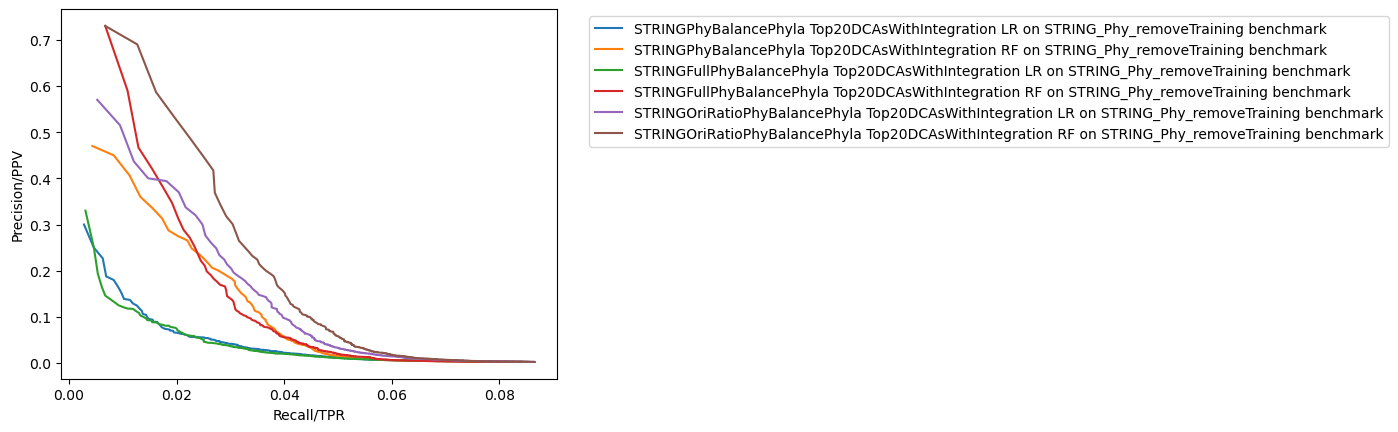

CPU times: user 7.74 s, sys: 235 ms, total: 7.98 s
Wall time: 7.73 s


In [262]:
%%time
step=100
zoom_thres=None#None#100000  #2269192,30000, 300
print_results=True
return_bestF1=None

Precison_Recall_RocCurve_OnlyGetRecallAndPrecision_OnIndepedentBenchmark(Pos_Prediction=STRINGPhyBalancePhyla_BestHomologousDCAs_top5DCAs_LR_pos_results_removeTrainingByRemovedRatioInSTRINGPhy,
                                               Pos_Prediction_PPs=STRINGPhyBalancePhyla_BestHomologousDCAs_top5DCAs_LR_pos_PPs_removeTrainingByRemovedRatioInSTRINGPhy,
                                               IndepedentBenchmark_pps_dict=STRINGcurrentSpePhyPPI_posPPI_dict_removeSTRINGPhyBalancePhylaTrainPP, 
                                               count_label="rate",
                                               legend="STRINGPhyBalancePhyla Top20DCAsWithIntegration LR on STRING_Phy_removeTraining benchmark",
                                               step=step,
                                               zoom_thres=zoom_thres,
                                               print_results=print_results,   
                                             return_bestF1=return_bestF1,
                                              )


Precison_Recall_RocCurve_OnlyGetRecallAndPrecision_OnIndepedentBenchmark(Pos_Prediction=STRINGPhyBalancePhyla_BestHomologousDCAs_top5DCAs_RF_pos_results_removeTrainingByRemovedRatioInSTRINGPhy,
                                                                         Pos_Prediction_PPs=STRINGPhyBalancePhyla_BestHomologousDCAs_top5DCAs_RF_pos_PPs_removeTrainingByRemovedRatioInSTRINGPhy,
                                               IndepedentBenchmark_pps_dict=STRINGcurrentSpePhyPPI_posPPI_dict_removeSTRINGPhyBalancePhylaTrainPP, 
                                               count_label="rate",
                                               legend="STRINGPhyBalancePhyla Top20DCAsWithIntegration RF on STRING_Phy_removeTraining benchmark",
                                               step=step,
                                               zoom_thres=zoom_thres,
                                               print_results=print_results, 
                                             return_bestF1=return_bestF1,
                                              )


Precison_Recall_RocCurve_OnlyGetRecallAndPrecision_OnIndepedentBenchmark(Pos_Prediction=STRINGFullPhyBalancePhyla_BestHomologousDCAs_top5DCAs_LR_pos_results_removeTrainingByRemovedRatioInSTRINGPhy,
                                               Pos_Prediction_PPs=STRINGFullPhyBalancePhyla_BestHomologousDCAs_top5DCAs_LR_pos_PPs_removeTrainingByRemovedRatioInSTRINGPhy,
                                               IndepedentBenchmark_pps_dict=STRINGcurrentSpePhyPPI_posPPI_dict_removeSTRINGFullPhyBalancePhylaTrainPP, 
                                               count_label="rate",
                                               legend="STRINGFullPhyBalancePhyla Top20DCAsWithIntegration LR on STRING_Phy_removeTraining benchmark",
                                               step=step,
                                               zoom_thres=zoom_thres,
                                               print_results=print_results,   
                                             return_bestF1=return_bestF1,
                                              )


Precison_Recall_RocCurve_OnlyGetRecallAndPrecision_OnIndepedentBenchmark(Pos_Prediction=STRINGFullPhyBalancePhyla_BestHomologousDCAs_top5DCAs_RF_pos_results_removeTrainingByRemovedRatioInSTRINGPhy,
                                                                         Pos_Prediction_PPs=STRINGFullPhyBalancePhyla_BestHomologousDCAs_top5DCAs_RF_pos_PPs_removeTrainingByRemovedRatioInSTRINGPhy,
                                               IndepedentBenchmark_pps_dict=STRINGcurrentSpePhyPPI_posPPI_dict_removeSTRINGFullPhyBalancePhylaTrainPP, 
                                               count_label="rate",
                                               legend="STRINGFullPhyBalancePhyla Top20DCAsWithIntegration RF on STRING_Phy_removeTraining benchmark",
                                               step=step,
                                               zoom_thres=zoom_thres,
                                               print_results=print_results,   
                                                 return_bestF1=return_bestF1,
                                              )



Precison_Recall_RocCurve_OnlyGetRecallAndPrecision_OnIndepedentBenchmark(Pos_Prediction=STRINGOriRatioPhyBalancePhyla_BestHomologousDCAs_top5DCAs_LR_pos_results_removeTrainingByRemovedRatioInSTRINGPhy,
                                               Pos_Prediction_PPs=STRINGOriRatioPhyBalancePhyla_BestHomologousDCAs_top5DCAs_LR_pos_PPs_removeTrainingByRemovedRatioInSTRINGPhy,
                                               IndepedentBenchmark_pps_dict=STRINGcurrentSpePhyPPI_posPPI_dict_removeSTRINGOriRatioPhyBalancePhylaTrainPP, 
                                               count_label="rate",
                                               legend="STRINGOriRatioPhyBalancePhyla Top20DCAsWithIntegration LR on STRING_Phy_removeTraining benchmark",
                                               step=step,
                                               zoom_thres=zoom_thres,
                                               print_results=print_results,  
                                            return_bestF1=return_bestF1,
                                              )


Precison_Recall_RocCurve_OnlyGetRecallAndPrecision_OnIndepedentBenchmark(Pos_Prediction=STRINGOriRatioPhyBalancePhyla_BestHomologousDCAs_top5DCAs_RF_pos_results_removeTrainingByRemovedRatioInSTRINGPhy,
                                                                         Pos_Prediction_PPs=STRINGOriRatioPhyBalancePhyla_BestHomologousDCAs_top5DCAs_RF_pos_PPs_removeTrainingByRemovedRatioInSTRINGPhy,
                                               IndepedentBenchmark_pps_dict=STRINGcurrentSpePhyPPI_posPPI_dict_removeSTRINGOriRatioPhyBalancePhylaTrainPP, 
                                               count_label="rate",
                                               legend="STRINGOriRatioPhyBalancePhyla Top20DCAsWithIntegration RF on STRING_Phy_removeTraining benchmark",
                                               step=step,
                                               zoom_thres=zoom_thres,
                                               print_results=print_results,   
                                                return_bestF1=return_bestF1,
                                              )


# plt.legend(  loc='upper right' )
plt.legend( bbox_to_anchor=(1.05, 1), loc='upper left' )
plt.show()
                                               
                                               
# when step=10, zoom_thres=30000, take arount 2 mins , each 
                                               

STRINGPhyBalancePhyla Top20DCAsWithIntegration LR on pdb_removeTrainingByRemovedRatioInPDB benchmark:postiveControlCount:1007;allPredCount:30000;
Final F1, precision, recall,TP:  0.027 0.0139 0.4151 418.0
STRINGPhyBalancePhyla Top20DCAsWithIntegration RF on pdb_removeTrainingByRemovedRatioInPDB benchmark:postiveControlCount:1007;allPredCount:30000;
Final F1, precision, recall,TP:  0.0296 0.0153 0.4558 459.0
STRINGFullPhyBalancePhyla Top20DCAsWithIntegration LR on pdb_removeTrainingByRemovedRatioInPDB benchmark:postiveControlCount:1018;allPredCount:30000;
Final F1, precision, recall,TP:  0.0264 0.0136 0.4018 409.0
STRINGFullPhyBalancePhyla Top20DCAsWithIntegration RF on pdb_removeTrainingByRemovedRatioInPDB benchmark:postiveControlCount:1018;allPredCount:30000;
Final F1, precision, recall,TP:  0.0315 0.0163 0.4794 488.0
STRINGOriRatioPhyBalancePhyla Top20DCAsWithIntegration LR on pdb_removeTrainingByRemovedRatioInPDB benchmark:postiveControlCount:1042;allPredCount:30000;
Final F1, preci

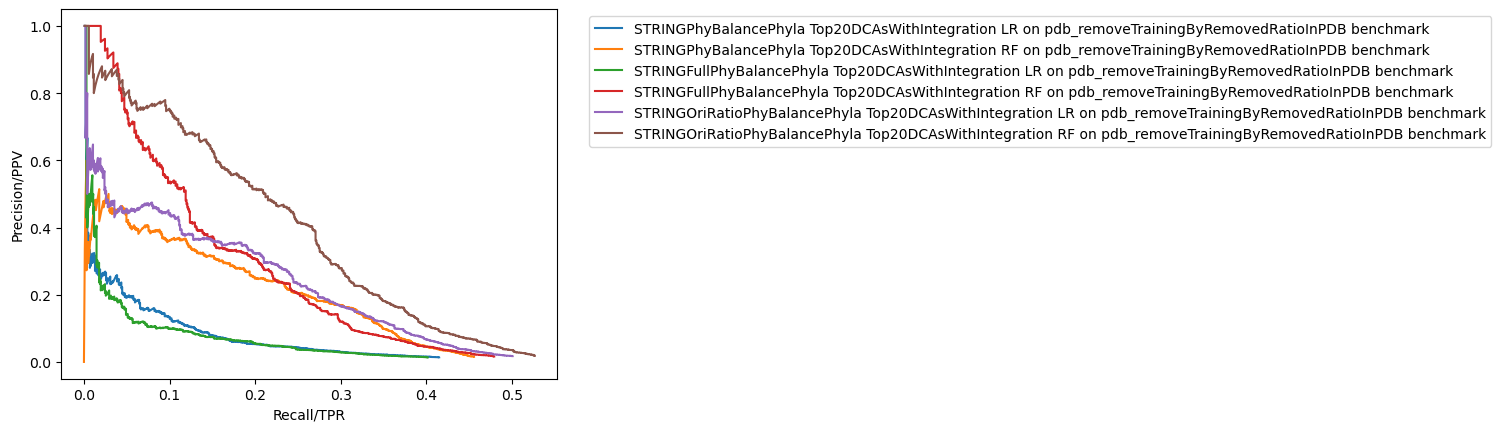

CPU times: user 16.5 s, sys: 197 ms, total: 16.7 s
Wall time: 16.4 s


In [263]:
%%time
step=1#10,100
zoom_thres=30000#None#100000  #2269192,30000, 300
print_results=True


Precison_Recall_RocCurve_OnlyGetRecallAndPrecision_OnIndepedentBenchmark(Pos_Prediction=STRINGPhyBalancePhyla_BestHomologousDCAs_top5DCAs_LR_pos_results_removeTrainingByRemovedRatioInPDBB,
                                               Pos_Prediction_PPs=STRINGPhyBalancePhyla_BestHomologousDCAs_top5DCAs_LR_pos_PPs_removeTrainingByRemovedRatioInPDBB,
                                               IndepedentBenchmark_pps_dict=pdb_PPs_dict_removeTrainingInSTRINGPhyBalancePhyla, 
                                               count_label="rate",
                                               legend="STRINGPhyBalancePhyla Top20DCAsWithIntegration LR on pdb_removeTrainingByRemovedRatioInPDB benchmark",
                                               step=step,
                                               zoom_thres=zoom_thres,
                                               print_results=print_results,  
                                            return_bestF1=return_bestF1,
                                              )


Precison_Recall_RocCurve_OnlyGetRecallAndPrecision_OnIndepedentBenchmark(Pos_Prediction=STRINGPhyBalancePhyla_BestHomologousDCAs_top5DCAs_RF_pos_results_removeTrainingByRemovedRatioInPDBB,
                                                                         Pos_Prediction_PPs=STRINGPhyBalancePhyla_BestHomologousDCAs_top5DCAs_RF_pos_PPs_removeTrainingByRemovedRatioInPDBB,
                                               IndepedentBenchmark_pps_dict=pdb_PPs_dict_removeTrainingInSTRINGPhyBalancePhyla, 
                                               count_label="rate",
                                               legend="STRINGPhyBalancePhyla Top20DCAsWithIntegration RF on pdb_removeTrainingByRemovedRatioInPDB benchmark",
                                               step=step,
                                               zoom_thres=zoom_thres,
                                               print_results=print_results,  
                                            return_bestF1=return_bestF1,
                                              )

Precison_Recall_RocCurve_OnlyGetRecallAndPrecision_OnIndepedentBenchmark(Pos_Prediction=STRINGFullPhyBalancePhyla_BestHomologousDCAs_top5DCAs_LR_pos_results_removeTrainingByRemovedRatioInPDBB,
                                               Pos_Prediction_PPs=STRINGFullPhyBalancePhyla_BestHomologousDCAs_top5DCAs_LR_pos_PPs_removeTrainingByRemovedRatioInPDBB,
                                               IndepedentBenchmark_pps_dict=pdb_PPs_dict_removeTrainingInSTRINGFullPhyBalancePhyla, 
                                               count_label="rate",
                                               legend="STRINGFullPhyBalancePhyla Top20DCAsWithIntegration LR on pdb_removeTrainingByRemovedRatioInPDB benchmark",
                                               step=step,
                                               zoom_thres=zoom_thres,
                                               print_results=print_results,   
                                                return_bestF1=return_bestF1,
                                              )


Precison_Recall_RocCurve_OnlyGetRecallAndPrecision_OnIndepedentBenchmark(Pos_Prediction=STRINGFullPhyBalancePhyla_BestHomologousDCAs_top5DCAs_RF_pos_results_removeTrainingByRemovedRatioInPDBB,
                                                                         Pos_Prediction_PPs=STRINGFullPhyBalancePhyla_BestHomologousDCAs_top5DCAs_RF_pos_PPs_removeTrainingByRemovedRatioInPDBB,
                                               IndepedentBenchmark_pps_dict=pdb_PPs_dict_removeTrainingInSTRINGFullPhyBalancePhyla, 
                                               count_label="rate",
                                               legend="STRINGFullPhyBalancePhyla Top20DCAsWithIntegration RF on pdb_removeTrainingByRemovedRatioInPDB benchmark",
                                               step=step,
                                               zoom_thres=zoom_thres,
                                               print_results=print_results,   
                                            return_bestF1=return_bestF1,
                                              )


Precison_Recall_RocCurve_OnlyGetRecallAndPrecision_OnIndepedentBenchmark(Pos_Prediction=STRINGOriRatioPhyBalancePhyla_BestHomologousDCAs_top5DCAs_LR_pos_results_removeTrainingByRemovedRatioInPDBB,
                                               Pos_Prediction_PPs=STRINGOriRatioPhyBalancePhyla_BestHomologousDCAs_top5DCAs_LR_pos_PPs_removeTrainingByRemovedRatioInPDBB,
                                               IndepedentBenchmark_pps_dict=pdb_PPs_dict_removeTrainingInSTRINGOriRatioPhyBalancePhyla, 
                                               count_label="rate",
                                               legend="STRINGOriRatioPhyBalancePhyla Top20DCAsWithIntegration LR on pdb_removeTrainingByRemovedRatioInPDB benchmark",
                                               step=step,
                                               zoom_thres=zoom_thres,
                                               print_results=print_results, 
                                                return_bestF1=return_bestF1,
                                              )


Precison_Recall_RocCurve_OnlyGetRecallAndPrecision_OnIndepedentBenchmark(Pos_Prediction=STRINGOriRatioPhyBalancePhyla_BestHomologousDCAs_top5DCAs_RF_pos_results_removeTrainingByRemovedRatioInPDBB,
                                                                         Pos_Prediction_PPs=STRINGOriRatioPhyBalancePhyla_BestHomologousDCAs_top5DCAs_RF_pos_PPs_removeTrainingByRemovedRatioInPDBB,
                                               IndepedentBenchmark_pps_dict=pdb_PPs_dict_removeTrainingInSTRINGOriRatioPhyBalancePhyla, 
                                               count_label="rate",
                                               legend="STRINGOriRatioPhyBalancePhyla Top20DCAsWithIntegration RF on pdb_removeTrainingByRemovedRatioInPDB benchmark",
                                               step=step,
                                               zoom_thres=zoom_thres,
                                               print_results=print_results, 
                                            return_bestF1=return_bestF1,
                                              )

# plt.legend(  loc='upper right' )
plt.legend( bbox_to_anchor=(1.05, 1), loc='upper left' )
plt.show()
                                               
                                               
# when step=10, zoom_thres=30000, take arount 2 mins , each 
                                               

In [264]:
len(STRINGPhyBalancePhyla_BestHomologousDCAs_top5DCAs_LR_pos_results_removeTrainingByRemovedRatioInPDBB)

417788

# figure 5:  appllication to all-to-all results 

maxDCA:postiveControlCount:10861;allPredCount:376147;
Final F1, precision, recall,TP:  0.0047 0.0024 0.0844 917.0
Top20DCAsWithIntegration RF:postiveControlCount:10861;allPredCount:376147;
Final F1, precision, recall,TP:  0.0047 0.0024 0.0844 917.0
maxDCA:postiveControlCount:1018;allPredCount:425473;
Final F1, precision, recall,TP:  0.0029 0.0014 0.5982 609.0
Top20DCAsWithIntegration RF:postiveControlCount:1018;allPredCount:425473;
Final F1, precision, recall,TP:  0.0029 0.0014 0.5982 609.0


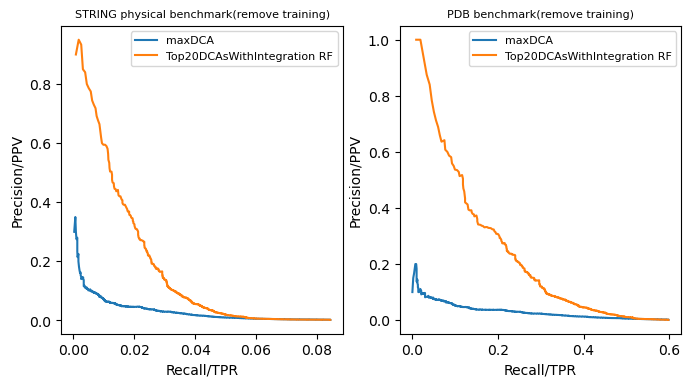

CPU times: user 20.5 s, sys: 352 ms, total: 20.9 s
Wall time: 21.1 s


In [265]:
%%time 
# Fig 35
# https://towardsdatascience.com/4-simple-tips-for-plotting-multiple-graphs-in-python-38df2112965c
# https://stackoverflow.com/questions/13714454/specifying-and-saving-a-figure-with-exact-size-in-pixels
# https://stackoverflow.com/questions/42435446/how-to-put-text-outside-python-plots
# https://matplotlib.org/stable/gallery/text_labels_and_annotations/titles_demo.html

fig5 = plt.figure(figsize=(8,4))

step=10 #1000 #10, 1
zoom_thres=None


colors=['#ffff33', '#ff7f00', '#984ea3', '#4daf4a', '#377eb8', '#e41a1c']

axA = plt.subplot(1,2,1)
#zoom_thres=60000#None#100000  #2269192,30000, 300
print_results=True

return_bestF1=None 



Precison_Recall_RocCurve_OnlyGetRecallAndPrecision_OnIndepedentBenchmark(Pos_Prediction=STRINGFullPhyBalancePhyla_maxDCAs_pos_removeTrainingByRemovedRatioInSTRINGPhy,
                                               Pos_Prediction_PPs=STRINGFullPhyBalancePhyla_PPs_pos_removeTrainingByRemovedRatioInSTRINGPhy,
                                               IndepedentBenchmark_pps_dict=STRINGcurrentSpePhyPPI_posPPI_dict_removeSTRINGFullPhyBalancePhylaTrainPP, 
                                               count_label="rate",
                                               legend="maxDCA",
                                               step=step,
                                               zoom_thres=zoom_thres,
                                               print_results=print_results,
                                               return_bestF1=return_bestF1,
                                               
                                              )
Precison_Recall_RocCurve_OnlyGetRecallAndPrecision_OnIndepedentBenchmark(Pos_Prediction=STRINGFullPhyBalancePhyla_BestHomologousDCAs_top5DCAs_RF_pos_results_removeTrainingByRemovedRatioInSTRINGPhy,
                                                                         Pos_Prediction_PPs=STRINGFullPhyBalancePhyla_BestHomologousDCAs_top5DCAs_RF_pos_PPs_removeTrainingByRemovedRatioInSTRINGPhy,
                                               IndepedentBenchmark_pps_dict=STRINGcurrentSpePhyPPI_posPPI_dict_removeSTRINGFullPhyBalancePhylaTrainPP, 
                                               count_label="rate",
                                               legend="Top20DCAsWithIntegration RF",
                                               step=step,
                                               zoom_thres=zoom_thres,
                                               print_results=print_results, 
                                            return_bestF1=return_bestF1,
                                              )





#plt.legend(loc='best')
#plt.legend( bbox_to_anchor=(1.05, 1), loc='upper left' )
#axA.set_title("Performance ",loc='left',loc='center',fontsize=10)
#ax1.set_xlabel("taaata",loc='left top')
# axA.text(-1000, 1000, 'A', weight='bold')
axA.set_title("STRING physical benchmark(remove training)",loc='center',fontsize=8)
axA.legend(fontsize=8)



axB =plt.subplot(1,2,2)
#zoom_thres=30000#None#100000  #2269192,30000, 300
print_results=True


Precison_Recall_RocCurve_OnlyGetRecallAndPrecision_OnIndepedentBenchmark(Pos_Prediction=STRINGFullPhyBalancePhyla_maxDCAs_pos_removeTrainingByRemovedRatioInPDBB,
                                               Pos_Prediction_PPs=STRINGFullPhyBalancePhyla_PPs_pos_removeTrainingByRemovedRatioInPDBB,
                                               IndepedentBenchmark_pps_dict=pdb_PPs_dict_removeTrainingInSTRINGFullPhyBalancePhyla, 
                                               count_label="rate",
                                               legend="maxDCA",
                                               step=step,
                                               zoom_thres=zoom_thres,
                                               print_results=print_results, 
                                            return_bestF1=return_bestF1,
                                              )


Precison_Recall_RocCurve_OnlyGetRecallAndPrecision_OnIndepedentBenchmark(Pos_Prediction=STRINGFullPhyBalancePhyla_BestHomologousDCAs_top5DCAs_RF_pos_results_removeTrainingByRemovedRatioInPDBB,
                                                                         Pos_Prediction_PPs=STRINGFullPhyBalancePhyla_BestHomologousDCAs_top5DCAs_RF_pos_PPs_removeTrainingByRemovedRatioInPDBB,
                                               IndepedentBenchmark_pps_dict=pdb_PPs_dict_removeTrainingInSTRINGFullPhyBalancePhyla, 
                                               count_label="rate",
                                               legend="Top20DCAsWithIntegration RF",
                                               step=step,
                                               zoom_thres=zoom_thres,
                                               print_results=print_results, 
                                            return_bestF1=return_bestF1,
                                              )





#plt.legend( bbox_to_anchor=(1.05, 1), loc='upper left' )
# axB.text(-300, 1000, 'B', weight='bold')
axB.set_title("PDB benchmark(remove training)",loc='center',fontsize=8)
axB.legend(fontsize=8)




plt.show()

fig5.savefig("/mnt/mnemo5/tao/temp_figures/Fig5.pdf", dpi=600)


# here recall is low, because not all pp in pdb or string physical benchmark can pass filtering steps ?!!!!
# more eays to understand from figure without removing training data, the recall is still lower then 1 at the end !!

# when use step=1， 36min 57

fixedRatio Top20DCAsWithIntegration RF:postiveControlCount:10861;allPredCount:376147;
Final F1, precision, recall,TP:  0.0047 0.0024 0.0844 917.0
unFixedRatio Top20DCAsWithIntegration RF:postiveControlCount:10887;allPredCount:386812;
Final F1, precision, recall,TP:  0.0047 0.0024 0.0866 943.0
maxDCA:postiveControlCount:10861;allPredCount:376147;
Final F1, precision, recall,TP:  0.0047 0.0024 0.0844 917.0
maxDCA of All phylum:postiveControlCount:10861;allPredCount:376147;
Final F1, precision, recall,TP:  0.0047 0.0024 0.0844 917.0
fixedRatio Top20DCAsWithIntegration RF:postiveControlCount:1018;allPredCount:425473;
Final F1, precision, recall,TP:  0.0029 0.0014 0.5982 609.0
unFixedRatio Top20DCAsWithIntegration RF:postiveControlCount:1042;allPredCount:442240;
Final F1, precision, recall,TP:  0.0029 0.0014 0.6075 633.0
maxDCA:postiveControlCount:1018;allPredCount:425473;
Final F1, precision, recall,TP:  0.0029 0.0014 0.5982 609.0
maxDCA of All phylum:postiveControlCount:1018;allPredCount:

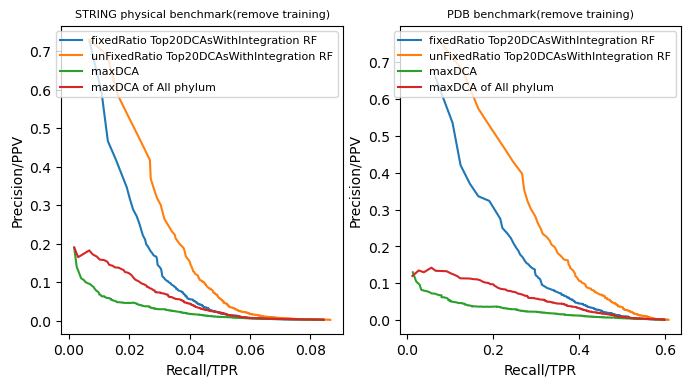

CPU times: user 11 s, sys: 519 ms, total: 11.5 s
Wall time: 11 s


In [266]:
%%time 
# Fig 35
# https://towardsdatascience.com/4-simple-tips-for-plotting-multiple-graphs-in-python-38df2112965c
# https://stackoverflow.com/questions/13714454/specifying-and-saving-a-figure-with-exact-size-in-pixels
# https://stackoverflow.com/questions/42435446/how-to-put-text-outside-python-plots
# https://matplotlib.org/stable/gallery/text_labels_and_annotations/titles_demo.html

fig5 = plt.figure(figsize=(8,4))

step=100 #1000 #10, 1
zoom_thres=None


colors=['#ffff33', '#ff7f00', '#984ea3', '#4daf4a', '#377eb8', '#e41a1c']

axA = plt.subplot(1,2,1)
#zoom_thres=60000#None#100000  #2269192,30000, 300
print_results=True

return_bestF1=None 
Precison_Recall_RocCurve_OnlyGetRecallAndPrecision_OnIndepedentBenchmark(Pos_Prediction=STRINGFullPhyBalancePhyla_BestHomologousDCAs_top5DCAs_RF_pos_results_removeTrainingByRemovedRatioInSTRINGPhy,
                                                                         Pos_Prediction_PPs=STRINGFullPhyBalancePhyla_BestHomologousDCAs_top5DCAs_RF_pos_PPs_removeTrainingByRemovedRatioInSTRINGPhy,
                                               IndepedentBenchmark_pps_dict=STRINGcurrentSpePhyPPI_posPPI_dict_removeSTRINGFullPhyBalancePhylaTrainPP, 
                                               count_label="rate",
                                               legend="fixedRatio Top20DCAsWithIntegration RF",
                                               step=step,
                                               zoom_thres=zoom_thres,
                                               print_results=print_results, 
                                            return_bestF1=return_bestF1,
                                              )

Precison_Recall_RocCurve_OnlyGetRecallAndPrecision_OnIndepedentBenchmark(Pos_Prediction=STRINGOriRatioPhyBalancePhyla_BestHomologousDCAs_top5DCAs_RF_pos_results_removeTrainingByRemovedRatioInSTRINGPhy,
                                                                         Pos_Prediction_PPs=STRINGOriRatioPhyBalancePhyla_BestHomologousDCAs_top5DCAs_RF_pos_PPs_removeTrainingByRemovedRatioInSTRINGPhy,
                                               IndepedentBenchmark_pps_dict=STRINGcurrentSpePhyPPI_posPPI_dict_removeSTRINGOriRatioPhyBalancePhylaTrainPP, 
                                               count_label="rate",
                                               legend="unFixedRatio Top20DCAsWithIntegration RF",
                                               step=step,
                                               zoom_thres=zoom_thres,
                                               print_results=print_results,   
                                                return_bestF1=return_bestF1,
                                                        
                                              )

Precison_Recall_RocCurve_OnlyGetRecallAndPrecision_OnIndepedentBenchmark(Pos_Prediction=STRINGFullPhyBalancePhyla_maxDCAs_pos_removeTrainingByRemovedRatioInSTRINGPhy,
                                               Pos_Prediction_PPs=STRINGFullPhyBalancePhyla_PPs_pos_removeTrainingByRemovedRatioInSTRINGPhy,
                                               IndepedentBenchmark_pps_dict=STRINGcurrentSpePhyPPI_posPPI_dict_removeSTRINGFullPhyBalancePhylaTrainPP, 
                                               count_label="rate",
                                               legend="maxDCA",
                                               step=step,
                                               zoom_thres=zoom_thres,
                                               print_results=print_results,
                                               return_bestF1=return_bestF1,
                                               
                                              )


Precison_Recall_RocCurve_OnlyGetRecallAndPrecision_OnIndepedentBenchmark(Pos_Prediction=STRINGFullPhyBalancePhyla_BestHomologousDCAs_top5DCAs_maxDCAs_pos_removeTrainingByRemovedRatioInSTRINGPhy,
                                               Pos_Prediction_PPs=STRINGFullPhyBalancePhyla_BestHomologousDCAs_top5DCAs_PPs_pos_removeTrainingByRemovedRatioInSTRINGPhy,
                                               IndepedentBenchmark_pps_dict=STRINGcurrentSpePhyPPI_posPPI_dict_removeSTRINGFullPhyBalancePhylaTrainPP, 
                                               count_label="rate",
                                               legend="maxDCA of All phylum",
                                               step=step,
                                               zoom_thres=zoom_thres,
                                               print_results=print_results,
                                               return_bestF1=return_bestF1,
                                              )



#plt.legend(loc='best')
#plt.legend( bbox_to_anchor=(1.05, 1), loc='upper left' )
#axA.set_title("Performance ",loc='left',loc='center',fontsize=10)
#ax1.set_xlabel("taaata",loc='left top')
# axA.text(-1000, 1000, 'A', weight='bold')
axA.set_title("STRING physical benchmark(remove training)",loc='center',fontsize=8)
axA.legend(fontsize=8)



axB =plt.subplot(1,2,2)
#zoom_thres=30000#None#100000  #2269192,30000, 300
print_results=True


Precison_Recall_RocCurve_OnlyGetRecallAndPrecision_OnIndepedentBenchmark(Pos_Prediction=STRINGFullPhyBalancePhyla_BestHomologousDCAs_top5DCAs_RF_pos_results_removeTrainingByRemovedRatioInPDBB,
                                                                         Pos_Prediction_PPs=STRINGFullPhyBalancePhyla_BestHomologousDCAs_top5DCAs_RF_pos_PPs_removeTrainingByRemovedRatioInPDBB,
                                               IndepedentBenchmark_pps_dict=pdb_PPs_dict_removeTrainingInSTRINGFullPhyBalancePhyla, 
                                               count_label="rate",
                                               legend="fixedRatio Top20DCAsWithIntegration RF",
                                               step=step,
                                               zoom_thres=zoom_thres,
                                               print_results=print_results, 
                                            return_bestF1=return_bestF1,
                                              )
Precison_Recall_RocCurve_OnlyGetRecallAndPrecision_OnIndepedentBenchmark(Pos_Prediction=STRINGOriRatioPhyBalancePhyla_BestHomologousDCAs_top5DCAs_RF_pos_results_removeTrainingByRemovedRatioInPDBB,
                                                                         Pos_Prediction_PPs=STRINGOriRatioPhyBalancePhyla_BestHomologousDCAs_top5DCAs_RF_pos_PPs_removeTrainingByRemovedRatioInPDBB,
                                               IndepedentBenchmark_pps_dict=pdb_PPs_dict_removeTrainingInSTRINGOriRatioPhyBalancePhyla, 
                                               count_label="rate",
                                               legend="unFixedRatio Top20DCAsWithIntegration RF",
                                               step=step,
                                               zoom_thres=zoom_thres,
                                               print_results=print_results, 
                                            return_bestF1=return_bestF1,
                                              )

Precison_Recall_RocCurve_OnlyGetRecallAndPrecision_OnIndepedentBenchmark(Pos_Prediction=STRINGFullPhyBalancePhyla_maxDCAs_pos_removeTrainingByRemovedRatioInPDBB,
                                               Pos_Prediction_PPs=STRINGFullPhyBalancePhyla_PPs_pos_removeTrainingByRemovedRatioInPDBB,
                                               IndepedentBenchmark_pps_dict=pdb_PPs_dict_removeTrainingInSTRINGFullPhyBalancePhyla, 
                                               count_label="rate",
                                               legend="maxDCA",
                                               step=step,
                                               zoom_thres=zoom_thres,
                                               print_results=print_results, 
                                            return_bestF1=return_bestF1,
                                              )


Precison_Recall_RocCurve_OnlyGetRecallAndPrecision_OnIndepedentBenchmark(Pos_Prediction=STRINGFullPhyBalancePhyla_BestHomologousDCAs_top5DCAs_maxDCAs_pos_removeTrainingByRemovedRatioInPDBB,
                                               Pos_Prediction_PPs=STRINGFullPhyBalancePhyla_BestHomologousDCAs_top5DCAs_PPs_pos_removeTrainingByRemovedRatioInPDBB,
                                               IndepedentBenchmark_pps_dict=pdb_PPs_dict_removeTrainingInSTRINGFullPhyBalancePhyla, 
                                               count_label="rate",
                                               legend="maxDCA of All phylum",
                                               step=step,
                                               zoom_thres=zoom_thres,
                                               print_results=print_results,
                                               return_bestF1=return_bestF1,
                                              )



#plt.legend( bbox_to_anchor=(1.05, 1), loc='upper left' )
# axB.text(-300, 1000, 'B', weight='bold')
axB.set_title("PDB benchmark(remove training)",loc='center',fontsize=8)
axB.legend(fontsize=8)




plt.show()

fig5.savefig("/mnt/mnemo5/tao/temp_figures/Fig5.pdf", dpi=600)


# here recall is low, because not all pp in pdb or string physical benchmark can pass filtering steps ?!!!!
# more eays to understand from figure without removing training data, the recall is still lower then 1 at the end !!

# when use step=1， 36min 57

## get some statistics 

In [267]:
def get_all2All_statistics(PPs,RF_results,benchmark_dict,
                           trainPP_dict,
                           return_FixNum=None,
                           rf_prob_thres=0.65,
                          ):
    def F1_score(PPV,TPR):
        return(2*(PPV*TPR)/(PPV+TPR))

    print(len(RF_results))

    if return_FixNum is None:
        RF_posIdx=[idx for idx, prob in enumerate(RF_results) if prob >rf_prob_thres]
        RF_pos_results=[RF_results[idx] for idx in RF_posIdx]
        RF_pos_PPs=[PPs[idx] for idx in RF_posIdx]
    else:
        RF_results=np.array(RF_results)
        PPs=np.array(PPs)

        Ascending_orderIdx=np.argsort(RF_results)
        Descending_orderIdx=Ascending_orderIdx[::-1]

        RF_results=RF_results[Descending_orderIdx]
        PPs=PPs[Descending_orderIdx]
        
        RF_pos_results=RF_results[0:return_FixNum]
        RF_pos_PPs=PPs[0:return_FixNum]
        RF_pos_PPs=[tuple(pp) for pp in RF_pos_PPs]


    result_posLen=len(RF_pos_PPs)
    result_TP=sum([1 for pp in RF_pos_PPs if pp in benchmark_dict ])


    benchmark_P=len(benchmark_dict)
    
    TP_notInTraining=sum([1 for pp in RF_pos_PPs if (pp in benchmark_dict) and (pp not in trainPP_dict) ])
    pos_notInTraining=sum([1 for pp in RF_pos_PPs if pp not in trainPP_dict ])

    print("result_TP,result_posLen,benchmark_P:",result_TP,result_posLen,benchmark_P)
    
    print("TP not in training", TP_notInTraining)
    print("pos_notInTraining",pos_notInTraining)
    
    precision=np.round(result_TP/result_posLen,decimals=2)
    recall=np.round(result_TP/benchmark_P,decimals=2)
    f1=np.round(F1_score(precision,recall),decimals=2)
    print("Precision, Recall,F1:",precision,recall,f1)
    return(result_TP,TP_notInTraining,precision,recall,f1)

In [268]:
all2all_benchmarkLabel=["STRING physical (15476)","PDB (3657)"]
all2all_talle_dict=dict()
all2all_talle_dict["STRING physical (15476)"]=pd.DataFrame(np.zeros((4,5)),
                                              index=["maxDCA","maxDCA of All phylum","fixedRatio Top20DCAsWithIntegration RF","unFixedRatio Top20DCAsWithIntegration RF"],
                                              columns=["TP","TP not in training","Pre","Rec","F-score",])
all2all_talle_dict["PDB (3657)"]=pd.DataFrame(np.zeros((4,5)),
                                              index=["maxDCA","maxDCA of All phylum","fixedRatio Top20DCAsWithIntegration RF","unFixedRatio Top20DCAsWithIntegration RF"],
                                              columns=["TP","TP not in training","Pre","Rec","F-score",])

In [269]:
len(STRINGcurrentSpePhyPPI_posPPI_dict),len(pdb_PPs_dict)

(15476, 3657)

In [270]:
rf_prob_thres=0.7
return_FixNum=20000#20000
all2all_talle_dict["STRING physical (15476)"].loc["fixedRatio Top20DCAsWithIntegration RF",:]=get_all2All_statistics(PPs=Subject_BestHomologousDCAs_top5DCAs_PPs,
                       RF_results=STRINGFullPhyBalancePhyla_BestHomologousDCAs_top5DCAs_RF_results,
                       benchmark_dict=STRINGcurrentSpePhyPPI_posPPI_dict,
                       trainPP_dict=STRINGFullPhyBalancePhyla_BestHomologousDCAs_top5DCAs_predicted_results_fixedNegVSposRratio_keepCombination_trainPPs,
                       return_FixNum=return_FixNum,
                       rf_prob_thres=rf_prob_thres)
all2all_talle_dict["PDB (3657)"].loc["fixedRatio Top20DCAsWithIntegration RF",:]=get_all2All_statistics(PPs=Subject_BestHomologousDCAs_top5DCAs_PPs,
                       RF_results=STRINGFullPhyBalancePhyla_BestHomologousDCAs_top5DCAs_RF_results,
                       benchmark_dict=pdb_PPs_dict,
                       trainPP_dict=STRINGFullPhyBalancePhyla_BestHomologousDCAs_top5DCAs_predicted_results_fixedNegVSposRratio_keepCombination_trainPPs,
                       return_FixNum=return_FixNum,
                       rf_prob_thres=rf_prob_thres)

2269192
result_TP,result_posLen,benchmark_P: 2090 20000 15476
TP not in training 346
pos_notInTraining 17444
Precision, Recall,F1: 0.1 0.14 0.12
2269192
result_TP,result_posLen,benchmark_P: 1944 20000 3657
TP not in training 329
pos_notInTraining 17444
Precision, Recall,F1: 0.1 0.53 0.17


In [271]:
rf_prob_thres=0.7
return_FixNum=20000#20000
all2all_talle_dict["STRING physical (15476)"].loc["unFixedRatio Top20DCAsWithIntegration RF",:]=get_all2All_statistics(PPs=Subject_BestHomologousDCAs_top5DCAs_PPs,
                       RF_results=STRINGOriRatioPhyBalancePhyla_BestHomologousDCAs_top5DCAs_RF_results,
                       benchmark_dict=STRINGcurrentSpePhyPPI_posPPI_dict,
                       trainPP_dict=STRINGOriRatioPhyBalancePhyla_BestHomologousDCAs_top5DCAs_predicted_results_trainPPs,
                       return_FixNum=return_FixNum,
                       rf_prob_thres=rf_prob_thres)
all2all_talle_dict["PDB (3657)"].loc["unFixedRatio Top20DCAsWithIntegration RF",:]=get_all2All_statistics(PPs=Subject_BestHomologousDCAs_top5DCAs_PPs,
                       RF_results=STRINGOriRatioPhyBalancePhyla_BestHomologousDCAs_top5DCAs_RF_results,
                       benchmark_dict=pdb_PPs_dict,
                       trainPP_dict=STRINGOriRatioPhyBalancePhyla_BestHomologousDCAs_top5DCAs_predicted_results_trainPPs,
                       return_FixNum=return_FixNum,
                       rf_prob_thres=rf_prob_thres)

2269192
result_TP,result_posLen,benchmark_P: 2476 20000 15476
TP not in training 444
pos_notInTraining 14123
Precision, Recall,F1: 0.12 0.16 0.14
2269192
result_TP,result_posLen,benchmark_P: 2280 20000 3657
TP not in training 412
pos_notInTraining 14123
Precision, Recall,F1: 0.11 0.62 0.19


In [272]:
rf_prob_thres=2
return_FixNum=20000#20000
all2all_talle_dict["STRING physical (15476)"].loc["maxDCA of All phylum",:]=get_all2All_statistics(PPs=Subject_BestHomologousDCAs_top5DCAs_PPs,
                       RF_results=Subject_BestHomologousDCAs_top5DCAs_maxDCAs,
                       benchmark_dict=STRINGcurrentSpePhyPPI_posPPI_dict,
                       trainPP_dict=STRINGFullPhyBalancePhyla_BestHomologousDCAs_top5DCAs_predicted_results_fixedNegVSposRratio_keepCombination_trainPPs,
                       return_FixNum=return_FixNum,
                       rf_prob_thres=rf_prob_thres)
all2all_talle_dict["PDB (3657)"].loc["maxDCA of All phylum",:]=get_all2All_statistics(PPs=Subject_BestHomologousDCAs_top5DCAs_PPs,
                       RF_results=Subject_BestHomologousDCAs_top5DCAs_maxDCAs,
                       benchmark_dict=pdb_PPs_dict,
                       trainPP_dict=STRINGFullPhyBalancePhyla_BestHomologousDCAs_top5DCAs_predicted_results_fixedNegVSposRratio_keepCombination_trainPPs,
                       return_FixNum=return_FixNum,
                       rf_prob_thres=rf_prob_thres)

2269192
result_TP,result_posLen,benchmark_P: 1486 20000 15476
TP not in training 280
pos_notInTraining 17258
Precision, Recall,F1: 0.07 0.1 0.08
2269192
result_TP,result_posLen,benchmark_P: 1361 20000 3657
TP not in training 258
pos_notInTraining 17258
Precision, Recall,F1: 0.07 0.37 0.12


In [273]:
rf_prob_thres=1.8
return_FixNum=20000#20000
all2all_talle_dict["STRING physical (15476)"].loc["maxDCA",:]=get_all2All_statistics(PPs=Subject_PPs,
                       RF_results=Subject_maxDCAs,
                       benchmark_dict=STRINGcurrentSpePhyPPI_posPPI_dict,
                       trainPP_dict=STRINGFullPhyBalancePhyla_BestHomologousDCAs_top5DCAs_predicted_results_fixedNegVSposRratio_keepCombination_trainPPs,
                       return_FixNum=return_FixNum,
                       rf_prob_thres=rf_prob_thres)
all2all_talle_dict["PDB (3657)"].loc["maxDCA",:]=get_all2All_statistics(PPs=Subject_PPs,
                       RF_results=Subject_maxDCAs,
                       benchmark_dict=pdb_PPs_dict,
                       trainPP_dict=STRINGFullPhyBalancePhyla_BestHomologousDCAs_top5DCAs_predicted_results_fixedNegVSposRratio_keepCombination_trainPPs,
                       return_FixNum=return_FixNum,
                       rf_prob_thres=rf_prob_thres)

2269192
result_TP,result_posLen,benchmark_P: 934 20000 15476
TP not in training 165
pos_notInTraining 18430
Precision, Recall,F1: 0.05 0.06 0.05
2269192
result_TP,result_posLen,benchmark_P: 822 20000 3657
TP not in training 147
pos_notInTraining 18430
Precision, Recall,F1: 0.04 0.22 0.07


In [274]:
all2all_talle_dict["STRING physical (15476)"]

TP  TP not in training   Pre  \
maxDCA                                     934.0               165.0  0.05   
maxDCA of All phylum                      1486.0               280.0  0.07   
fixedRatio Top20DCAsWithIntegration RF    2090.0               346.0  0.10   
unFixedRatio Top20DCAsWithIntegration RF  2476.0               444.0  0.12   

                                           Rec  F-score  
maxDCA                                    0.06     0.05  
maxDCA of All phylum                      0.10     0.08  
fixedRatio Top20DCAsWithIntegration RF    0.14     0.12  
unFixedRatio Top20DCAsWithIntegration RF  0.16     0.14

In [275]:
all2all_talle_dict["PDB (3657)"]

TP  TP not in training   Pre  \
maxDCA                                     822.0               147.0  0.04   
maxDCA of All phylum                      1361.0               258.0  0.07   
fixedRatio Top20DCAsWithIntegration RF    1944.0               329.0  0.10   
unFixedRatio Top20DCAsWithIntegration RF  2280.0               412.0  0.11   

                                           Rec  F-score  
maxDCA                                    0.22     0.07  
maxDCA of All phylum                      0.37     0.12  
fixedRatio Top20DCAsWithIntegration RF    0.53     0.17  
unFixedRatio Top20DCAsWithIntegration RF  0.62     0.19

### save table

then copy these result to table  /Users/taof/Documents/PhD_Tao/conference/presentations/all2all.numbers



#### change from table to figure 4

In [276]:
PDB_wideTable=all2all_talle_dict["PDB (3657)"]
PDB_wideTable=PDB_wideTable.loc[["maxDCA","fixedRatio Top20DCAsWithIntegration RF"],:]
PDB_longTable_list=list()
for metrics in PDB_wideTable.columns:
    PDB_longTable_list.append([metrics,PDB_wideTable.loc["maxDCA",metrics],"maxDCA(No ML)"])
    PDB_longTable_list.append([metrics,PDB_wideTable.loc["fixedRatio Top20DCAsWithIntegration RF",metrics],"Top20DCAsWithIntegration RF"])
PDB_longTable_frame=pd.DataFrame(PDB_longTable_list,columns=["Metrics","Value","Method"])

In [277]:
STRINGPhysical_wideTable=all2all_talle_dict["STRING physical (15476)"]
STRINGPhysical_wideTable=STRINGPhysical_wideTable.loc[["maxDCA","fixedRatio Top20DCAsWithIntegration RF"],:]
STRINGPhysical_longTable_list=list()
for metrics in STRINGPhysical_wideTable.columns:
    STRINGPhysical_longTable_list.append([metrics,STRINGPhysical_wideTable.loc["maxDCA",metrics],"maxDCA(No ML)"])
    STRINGPhysical_longTable_list.append([metrics,STRINGPhysical_wideTable.loc["fixedRatio Top20DCAsWithIntegration RF",metrics],"Top20DCAsWithIntegration RF"])
STRINGPhysical_longTable_frame=pd.DataFrame(STRINGPhysical_longTable_list,columns=["Metrics","Value","Method"])

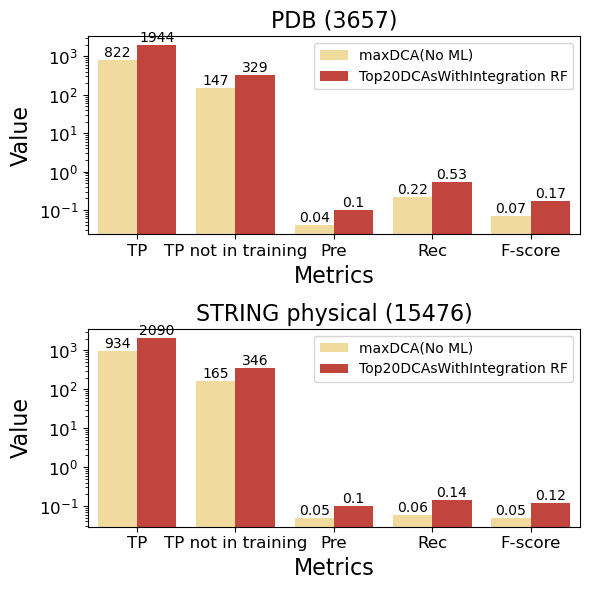

In [278]:
fig4 = plt.figure(figsize=(6,6))

ax1 = plt.subplot(2,1,1)
ax1=sns.barplot(data=PDB_longTable_frame, 
               x="Metrics", y="Value", hue="Method",
                palette=['#fee090','#d73027'],
               ax=ax1,
              )
for i in ax1.containers:
    ax1.bar_label(i,)
ax1.set_yscale("log")

ax1.legend().set_visible(False)
ax1.set_xlabel("Metrics",fontsize=16)
ax1.set_ylabel("Value",fontsize=16)
ax1.set_title("PDB (3657)",loc='center',fontsize=16)
ax1.legend(fontsize=10,
           # loc="upper right",
           # loc='center left', bbox_to_anchor=(1, 0.5),
          )
plt.xticks(fontsize=12)# compare with ax2.set_xticks, this one dont need to give exact ticks position
plt.yticks(fontsize=12)


ax2 = plt.subplot(2,1,2)
ax2=sns.barplot(data=STRINGPhysical_longTable_frame, 
               x="Metrics", y="Value", hue="Method",
                palette=['#fee090','#d73027'],
               ax=ax2,
              )
for i in ax2.containers:
    ax2.bar_label(i,)
ax2.set_yscale("log")

ax2.legend().set_visible(False)
ax2.set_xlabel("Metrics",fontsize=16)
ax2.set_ylabel("Value",fontsize=16)
ax2.set_title("STRING physical (15476)",loc='center',fontsize=16)
ax2.legend(fontsize=10,
           # loc="upper right",
           # loc='center left', bbox_to_anchor=(1, 0.5),
          )
plt.xticks(fontsize=12)# compare with ax2.set_xticks, this one dont need to give exact ticks position
plt.yticks(fontsize=12)


plt.tight_layout()
plt.show()

fig4.savefig("/mnt/mnemo5/tao/temp_figures/PhysicalPPIScreen_all2all.pdf", dpi=600)


# alphafold further filtering  for direct and functional  PPI benchmark after full  STRINGPhyBalancePhyla  phylum integration

fron now not important  to show phylum integration ml model 

In [279]:

EggNog1224_output_path=f"/mnt/mnemo6/tao/colabfold_PPI_Coevolution/CoEvo_data_STRING11.5/EggNog_511145_EggNOGmaxLeve1224/"

EggNog1224_figure_prefiex=""

model_key='model_3'

## prepare benchmark 

In [280]:
# prepare kegg benchmark 
#http://localhost:8206/lab/workspaces/auto-r/tree/code/MNF/notebooks/STRING_Data_11.5/script_CoEvo_EggNOG_preprocessing_STRING1105_varyEggNOGMaxLevels_prepareKEGGBenchmark.ipynb

currentSpe_TaxID=Subject_tuple[1]


KEGGPPI_benchmark_file="/mnt/mnemo6/damian/STRING_derived_v11.5/kegg_2020/kegg_benchmarking.CONN_maps_in.v11.5.tsv"
KEGGPPI_benchmark=pd.read_csv(KEGGPPI_benchmark_file,
                          header=None,index_col=None, sep="\t")

print(KEGGPPI_benchmark.shape)
# KEGGPPI_benchmark.head(n=3)
#set(kegg_benchmark.iloc[:,1])


KEGGPPI_benchmark_speID=KEGGPPI_benchmark.iloc[:,0].tolist()
KEGGPPI_benchmark_currentSpe_Idx=[i for i,s in enumerate(KEGGPPI_benchmark_speID) if s ==int(currentSpe_TaxID)]
currentSpe_KEGGPPI_benchmark=KEGGPPI_benchmark.loc[KEGGPPI_benchmark_currentSpe_Idx,:]
print(currentSpe_KEGGPPI_benchmark.shape)

currentSpe_KEGGPPI_pathways=currentSpe_KEGGPPI_benchmark.iloc[:,3].tolist()
currentSpe_KEGGPPI_pathways=[l.split() for l in currentSpe_KEGGPPI_pathways]

# here notice is  l only with one protein, get empty
currentSpe_KEGGPPI_posPPI=[list(itertools.combinations(l,2)) for l in currentSpe_KEGGPPI_pathways]

currentSpe_KEGGPPI_posPPI=[pp for l in currentSpe_KEGGPPI_posPPI for pp in l] # genereate reversed pp and extend list of list
print("len(currentSpe_KEGGPPI_posPPI):",len(currentSpe_KEGGPPI_posPPI))
print(currentSpe_KEGGPPI_posPPI[0:3])





currentSpe_KEGGPPI_posPPI=[tuple(sorted(pp)) for pp in currentSpe_KEGGPPI_posPPI]
currentSpe_KEGGPPI_posPPI=list(set(currentSpe_KEGGPPI_posPPI))
print("sort protein pair and set,len(currentSpe_KEGGPPI_posPPI):",len(currentSpe_KEGGPPI_posPPI))


currentSpe_KEGGPPI_posPPI=[(currentSpe_TaxID+"."+p1,currentSpe_TaxID+"."+p2) for p1, p2 in currentSpe_KEGGPPI_posPPI]
print("len(currentSpe_KEGGPPI_posPPI)",len(currentSpe_KEGGPPI_posPPI))




currentSpe_KEGGPPI_posPPI_dict=dict([(pp,1) for pp in currentSpe_KEGGPPI_posPPI])
print("len(currentSpe_KEGGPPI_posPPI_dict)",len(currentSpe_KEGGPPI_posPPI_dict))
print(list(currentSpe_KEGGPPI_posPPI_dict.items())[0:3])



(371602, 4)
(204, 4)
len(currentSpe_KEGGPPI_posPPI): 34786
[('b0114', 'b0115'), ('b0114', 'b1378'), ('b0114', 'b3403')]
sort protein pair and set,len(currentSpe_KEGGPPI_posPPI): 28914
len(currentSpe_KEGGPPI_posPPI) 28914
len(currentSpe_KEGGPPI_posPPI_dict) 28914
[(('511145.b3729', '511145.b3972'), 1), (('511145.b0071', '511145.b0728'), 1), (('511145.b0838', '511145.b1852'), 1)]


In [281]:
# 
# from file http://localhost:8206/lab/workspaces/auto-l/tree/code/STRING_TAO/PPI_Coevolution/QianPDB_UniprotID2StringID.ipynb
# sheet_name=8
Qian_benchmarkLabel_list=["QianY2H","QianAPMS","QianECOCYC","QianPDB"]
Qian_benchmark_PPI_dict=dict()
for benchmarkLabel in Qian_benchmarkLabel_list:
    print(benchmarkLabel)
    Qian_Ecoli_PPI=pd.read_csv(filepath_or_buffer=f'/mnt/mnemo5/tao/PPI_Coevolution/QianCong_Paper/{benchmarkLabel}_PPI.csv',
                          header=0,index_col=None)
                          #sep=" ",header=True,index=None)
    print(Qian_Ecoli_PPI.shape)


    Qian_Ecoli_PPI_pps=Qian_Ecoli_PPI["Pair (String IDs)"].values.tolist()

    Qian_Ecoli_PPI_pps=[pp.split("_") for pp in Qian_Ecoli_PPI_pps]

    print(len(Qian_Ecoli_PPI_pps))
    Qian_Ecoli_PPI_pps=[sorted((p1,p2)) for p1,p2 in Qian_Ecoli_PPI_pps if (p1!='NoRecord') and (p2!='NoRecord')]
    print(len(Qian_Ecoli_PPI_pps))
    Qian_Ecoli_PPI_pps=[tuple(pp) for pp in Qian_Ecoli_PPI_pps ]
    Qian_Ecoli_PPI_pps_dict={pp:1 for pp in Qian_Ecoli_PPI_pps}
    
    Qian_benchmark_PPI_dict[benchmarkLabel]=Qian_Ecoli_PPI_pps_dict
    
    print("len(Qian_Ecoli_PPI_pps_dict),len(Qian_Ecoli_PPI_pps):",len(Qian_Ecoli_PPI_pps_dict),len(Qian_Ecoli_PPI_pps))
    
print("pdb_complex")
Qian_benchmark_PPI_dict["pdb_complex"]=pdb_complex_PPs_dict
print("len(Qian_Ecoli_PPI_pps_dict),len(Qian_Ecoli_PPI_pps):",len(pdb_complex_PPs_dict),len(pdb_complex_PPs))



print("KEGG")
Qian_benchmark_PPI_dict["KEGG"]=currentSpe_KEGGPPI_posPPI_dict
print("len(Qian_Ecoli_PPI_pps_dict):",len(currentSpe_KEGGPPI_posPPI_dict))





QianY2H
(277, 7)
277
275
len(Qian_Ecoli_PPI_pps_dict),len(Qian_Ecoli_PPI_pps): 275 275
QianAPMS
(1245, 7)
1245
1236
len(Qian_Ecoli_PPI_pps_dict),len(Qian_Ecoli_PPI_pps): 1236 1236
QianECOCYC
(916, 7)
916
892
len(Qian_Ecoli_PPI_pps_dict),len(Qian_Ecoli_PPI_pps): 892 892
QianPDB
(868, 7)
868
765
len(Qian_Ecoli_PPI_pps_dict),len(Qian_Ecoli_PPI_pps): 765 765
pdb_complex
len(Qian_Ecoli_PPI_pps_dict),len(Qian_Ecoli_PPI_pps): 3243 3243
KEGG
len(Qian_Ecoli_PPI_pps_dict): 28914


In [282]:
%%time

print(len(pdb_interact_PPs),sum([1 for pp in Subject_PPs if pp in pdb_interact_PPs_dict]))
print(len(pdb_complex_PPs),sum([1 for pp in Subject_PPs if pp in pdb_complex_PPs_dict]))

for benchmarkLabel, Qian_Ecoli_PPI_pps_dict in Qian_benchmark_PPI_dict.items():
    print(benchmarkLabel)
    print(len(Qian_Ecoli_PPI_pps_dict),sum([1 for pp in Subject_PPs if pp in  Qian_Ecoli_PPI_pps_dict]))


414 294
3243 2954
QianY2H
275 156
QianAPMS
1236 797
QianECOCYC
892 515
QianPDB
765 382
pdb_complex
3243 2954
KEGG
28914 16201
CPU times: user 1.13 s, sys: 4.15 ms, total: 1.14 s
Wall time: 1.14 s


In [283]:
%%time


for benchmarkLabel, Qian_Ecoli_PPI_pps_dict in Qian_benchmark_PPI_dict.items():
    print(benchmarkLabel)
    print(len(Qian_Ecoli_PPI_pps_dict),sum([1 for pp in Qian_Ecoli_PPI_pps_dict.keys() if pp in  STRINGFullPhyBalancePhyla_BestHomologousDCAs_top5DCAs_predicted_results_fixedNegVSposRratio_keepCombination_trainPPs]))


QianY2H
275 104
QianAPMS
1236 408
QianECOCYC
892 397
QianPDB
765 228
pdb_complex
3243 2393
KEGG
28914 2056
CPU times: user 7.07 ms, sys: 0 ns, total: 7.07 ms
Wall time: 6.93 ms


## sel final PP list from differente methods 

In [324]:
def FixNum_of_topResults(prob_results,PPs,prob_thres,return_FixNum=None):
    if return_FixNum is None:
        posIdx=[idx for idx, prob in enumerate(prob_results) if prob >prob_thres]
        print("len(posIdx):",len(posIdx))
        pos_results=[prob_results[idx] for idx in posIdx]
        pos_PPs=[PPs[idx] for idx in posIdx]
    else:
        prob_results=np.array(prob_results)
        PPs=np.array(PPs)

        Ascending_orderIdx=np.argsort(prob_results)
        Descending_orderIdx=Ascending_orderIdx[::-1]

        prob_results=prob_results[Descending_orderIdx]
        PPs=PPs[Descending_orderIdx]

        pos_results=prob_results[0:return_FixNum]
        pos_PPs=PPs[0:return_FixNum]
        pos_PPs=[tuple(pp) for pp in pos_PPs]
    return(pos_PPs)

In [285]:
%%time
# maxAPCedDCA_thres=0.45
# Subject_maxAPCedDCAs_selIdx=[idx for idx,dca in enumerate(Subject_maxAPCedDCAs) if  (Subject_maxAPCedDCAs[idx]>maxAPCedDCA_thres)]
# Subject_maxAPCedDCAs_sel_PPList=[Subject_BestHomologousDCAs_top5DCAs_PPs[idx] for idx in Subject_maxAPCedDCAs_selIdx]

maxAPCedDCA_thres=0.45
return_FixNum=20000 #15000
Subject_maxAPCedDCAs_sel_PPList=FixNum_of_topResults(Subject_maxAPCedDCAs,
                                                     Subject_maxAPCedDCA_PPs,
                                                     prob_thres=maxAPCedDCA_thres,return_FixNum=return_FixNum)

print(len(Subject_maxAPCedDCAs_sel_PPList))



Subject_maxAPCedDCAs_argument_toget_interprotein_prob12=[[EggNog1224_output_path+EggNog1224_figure_prefiex,".custom_"+model_key+"_distogram.npz"]+list(pp+Subject_allPPI_allInfo_dict[pp]) for pp in Subject_maxAPCedDCAs_sel_PPList]

print(len(Subject_maxAPCedDCAs_argument_toget_interprotein_prob12))

pool=mp.Pool(10) #30
Subject_maxAPCedDCAs_interprotein_maxprob12_list=pool.map(get_interprotein_maxcontactprob_from_processedalphafoldnpz,Subject_maxAPCedDCAs_argument_toget_interprotein_prob12)
pool.close() 

print(len(Subject_maxAPCedDCAs_interprotein_maxprob12_list))
Subject_maxAPCedDCAs_interprotein_maxprob12_dict={(p1,p2):max_interprotein_prob12 for p1, p2, max_interprotein_prob12 in Subject_maxAPCedDCAs_interprotein_maxprob12_list if max_interprotein_prob12 is not None}

print(len(Subject_maxAPCedDCAs_interprotein_maxprob12_dict))





20000
20000
20000
20000
CPU times: user 2.87 s, sys: 3.65 s, total: 6.52 s
Wall time: 4min 8s


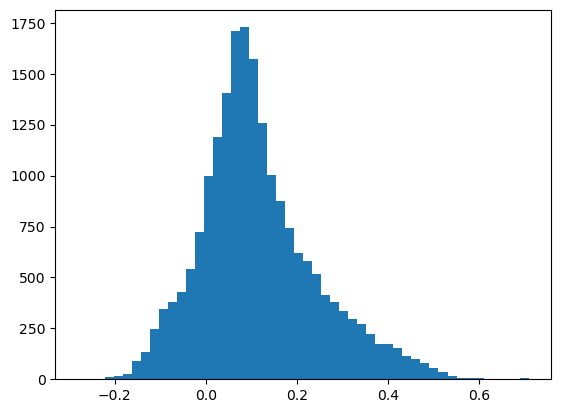

In [286]:
# plt.yscale("log")
_=plt.hist([Subject_maxAPCedRFProbs_dict[pp] for pp in Subject_maxAPCedDCAs_sel_PPList],bins=50,)

plt.show()

In [287]:
%%time

maxprob12_thres=0.9
ptm_thres=0 # 0.6,0.7




# use this for benchmarking when we use corrrect PP list to collect alphafold results ,from Subject_maxAPCedDCAs_sel_PPList

Subject_maxAPCedDCAs_interprotein_maxprob12_PPs=[k for k, v in Subject_maxAPCedDCAs_interprotein_maxprob12_dict.items() if v >=maxprob12_thres]
Subject_maxAPCedDCAs_interprotein_maxprob12_results=[v for k, v in Subject_maxAPCedDCAs_interprotein_maxprob12_dict.items() if v >=maxprob12_thres]
len(Subject_maxAPCedDCAs_interprotein_maxprob12_results)


Subject_maxAPCedDCAs_argument_toget_ptm=[[colab_outputPath,p1,p2] for p1,p2 in Subject_maxAPCedDCAs_interprotein_maxprob12_PPs]
pool=mp.Pool(10) #30
Subject_maxAPCedDCAs_ptm_list=pool.map(get_ptm_from_scoreFile,Subject_maxAPCedDCAs_argument_toget_ptm)
pool.close() 
print(len(Subject_maxAPCedDCAs_ptm_list))



Subject_maxAPCedDCAs_interprotein_maxprob12_PPs=[(p1,p2) for p1,p2,ptm in Subject_maxAPCedDCAs_ptm_list if ptm >=ptm_thres]
Subject_maxAPCedDCAs_interprotein_maxprob12_results=[Subject_maxAPCedDCAs_interprotein_maxprob12_dict[(p1,p2)] for p1,p2,ptm in Subject_maxAPCedDCAs_ptm_list if ptm >=ptm_thres]
len(Subject_maxAPCedDCAs_interprotein_maxprob12_results)




443
CPU times: user 76.2 ms, sys: 3.32 s, total: 3.4 s
Wall time: 8.43 s


443

### save pps for visulisation purpose

In [288]:
with open(os.path.join(Subject_Benchmark_folder,
                       f"Subject_maxAPCedDCAs_interprotein_maxprob12_dict.pickle"),"wb") as f:
    pickle.dump(Subject_maxAPCedDCAs_interprotein_maxprob12_dict,f)
    
    

In [289]:
# %%time
# # maxDCA_thres=1.7 # 1.8
# # Subject_maxDCAs_selIdx=[idx for idx,dca in enumerate(Subject_maxDCAs) if ( dca>=maxDCA_thres) ]
# # Subject_maxDCAs_sel_PPList=[Subject_BestHomologousDCAs_top5DCAs_PPs[idx] for idx in Subject_maxDCAs_selIdx]

# maxDCA_thres=1.7
# # return_FixNum=15000
# Subject_maxDCAs_sel_PPList=FixNum_of_topResults(Subject_maxDCAs,
#                                                      Subject_PPs,
#                                                      prob_thres=maxDCA_thres,return_FixNum=return_FixNum)

# print(len(Subject_maxDCAs_sel_PPList))



# Subject_maxDCAs_argument_toget_interprotein_prob12=[[EggNog1224_output_path+EggNog1224_figure_prefiex,".custom_"+model_key+"_distogram.npz"]+list(pp+Subject_allPPI_allInfo_dict[pp]) for pp in Subject_maxDCAs_sel_PPList]

# print(len(Subject_maxDCAs_argument_toget_interprotein_prob12))

# pool=mp.Pool(10) #30
# Subject_maxDCAs_interprotein_maxprob12_list=pool.map(get_interprotein_maxcontactprob_from_processedalphafoldnpz,Subject_maxDCAs_argument_toget_interprotein_prob12)
# pool.close() 

# print(len(Subject_maxDCAs_interprotein_maxprob12_list))
# Subject_maxDCAs_interprotein_maxprob12_dict={(p1,p2):max_interprotein_prob12 for p1, p2, max_interprotein_prob12 in Subject_maxDCAs_interprotein_maxprob12_list if max_interprotein_prob12 is not None}

# print(len(Subject_maxDCAs_interprotein_maxprob12_dict))



# # use this for benchmarking when we use corrrect PP list to collect alphafold results ,from Subject_maxDCAs_sel_PPList
# Subject_maxDCAs_interprotein_maxprob12_PPs=[k for k, v in Subject_maxDCAs_interprotein_maxprob12_dict.items()]
# Subject_maxDCAs_interprotein_maxprob12_results=[v for k, v in Subject_maxDCAs_interprotein_maxprob12_dict.items()]

# %%time
# # use this for benchmarking when we use corrrect PP list to collect alphafold results ,from Subject_maxDCAs_sel_PPList
# Subject_maxDCAs_interprotein_maxprob12_PPs=[k for k, v in Subject_maxDCAs_interprotein_maxprob12_dict.items() if v >=maxprob12_thres]
# Subject_maxDCAs_interprotein_maxprob12_results=[v for k, v in Subject_maxDCAs_interprotein_maxprob12_dict.items() if v >=maxprob12_thres]
# len(Subject_maxDCAs_interprotein_maxprob12_results)


# Subject_maxDCAs_argument_toget_ptm=[[colab_outputPath,p1,p2] for p1,p2 in Subject_maxDCAs_interprotein_maxprob12_PPs]
# pool=mp.Pool(10) #30
# Subject_maxDCAs_ptm_list=pool.map(get_ptm_from_scoreFile,Subject_maxDCAs_argument_toget_ptm)
# pool.close() 
# print(len(Subject_maxDCAs_ptm_list))


# Subject_maxDCAs_interprotein_maxprob12_PPs=[(p1,p2) for p1,p2,ptm in Subject_maxDCAs_ptm_list if ptm >=ptm_thres]
# Subject_maxDCAs_interprotein_maxprob12_results=[Subject_maxDCAs_interprotein_maxprob12_dict[(p1,p2)] for p1,p2,ptm in Subject_maxDCAs_ptm_list if ptm >=ptm_thres]
# len(Subject_maxDCAs_interprotein_maxprob12_results)



# #sum([1 for pp in Subject_maxDCAs_interprotein_maxprob12_PPs if pp in STRINGFullPhyBalancePhyla_BestHomologousDCAs_top5DCAs_predicted_results_fixedNegVSposRratio_keepCombination_trainPPs])

In [290]:
%%time
# RF_thres=0.65 #0.5 ,0.65, 0.7  # 0.7,0.8
# STRINGFullPhyBalancePhyla_BestHomologousDCAs_top5DCAs_RF_selIdx=[idx for idx,RF in enumerate(STRINGFullPhyBalancePhyla_BestHomologousDCAs_top5DCAs_RF_results) if (RF>=RF_thres)] #  and (Subject_maxAPCedDCAs[idx]>maxAPCedDCA_thres)
# STRINGFullPhyBalancePhyla_BestHomologousDCAs_top5DCAs_RF_sel_PPList=[Subject_BestHomologousDCAs_top5DCAs_PPs[idx] for idx in STRINGFullPhyBalancePhyla_BestHomologousDCAs_top5DCAs_RF_selIdx]


RF_thres=0.65
# return_FixNum=15000
return_FixNum=None
STRINGFullPhyBalancePhyla_BestHomologousDCAs_top5DCAs_RF_sel_PPList=FixNum_of_topResults(STRINGFullPhyBalancePhyla_BestHomologousDCAs_top5DCAs_RF_results,
                                                     Subject_BestHomologousDCAs_top5DCAs_PPs,
                                                     prob_thres=RF_thres,return_FixNum=return_FixNum)

print(len(STRINGFullPhyBalancePhyla_BestHomologousDCAs_top5DCAs_RF_sel_PPList))



STRINGFullPhyBalancePhyla_BestHomologousDCAs_top5DCAs_RF_argument_toget_interprotein_prob12=[[EggNog1224_output_path+EggNog1224_figure_prefiex,".custom_"+model_key+"_distogram.npz"]+list(pp+Subject_allPPI_allInfo_dict[pp]) for pp in STRINGFullPhyBalancePhyla_BestHomologousDCAs_top5DCAs_RF_sel_PPList]

print(len(STRINGFullPhyBalancePhyla_BestHomologousDCAs_top5DCAs_RF_argument_toget_interprotein_prob12))

pool=mp.Pool(10) #30
STRINGFullPhyBalancePhyla_BestHomologousDCAs_top5DCAs_RF_interprotein_maxprob12_list=pool.map(get_interprotein_maxcontactprob_from_processedalphafoldnpz,STRINGFullPhyBalancePhyla_BestHomologousDCAs_top5DCAs_RF_argument_toget_interprotein_prob12)
pool.close() 

print(len(STRINGFullPhyBalancePhyla_BestHomologousDCAs_top5DCAs_RF_interprotein_maxprob12_list))
STRINGFullPhyBalancePhyla_BestHomologousDCAs_top5DCAs_RF_interprotein_maxprob12_dict={(p1,p2):max_interprotein_prob12 for p1, p2, max_interprotein_prob12 in STRINGFullPhyBalancePhyla_BestHomologousDCAs_top5DCAs_RF_interprotein_maxprob12_list if max_interprotein_prob12 is not None}

print(len(STRINGFullPhyBalancePhyla_BestHomologousDCAs_top5DCAs_RF_interprotein_maxprob12_dict))



# # use this for benchmarking when we use corrrect PP list to collect alphafold results ,from STRINGFullPhyBalancePhyla_BestHomologousDCAs_top5DCAs_RF_sel_PPList
# STRINGFullPhyBalancePhyla_BestHomologousDCAs_top5DCAs_RF_interprotein_maxprob12_PPs=[k for k, v in STRINGFullPhyBalancePhyla_BestHomologousDCAs_top5DCAs_RF_interprotein_maxprob12_dict.items()]
# STRINGFullPhyBalancePhyla_BestHomologousDCAs_top5DCAs_RF_interprotein_maxprob12_results=[v for k, v in STRINGFullPhyBalancePhyla_BestHomologousDCAs_top5DCAs_RF_interprotein_maxprob12_dict.items()]
# sum([1 for pp in STRINGFullPhyBalancePhyla_BestHomologousDCAs_top5DCAs_RF_interprotein_maxprob12_PPs if pp in STRINGFullPhyBalancePhyla_BestHomologousDCAs_top5DCAs_predicted_results_fixedNegVSposRratio_keepCombination_trainPPs])

32293
32293
32293
31199
CPU times: user 482 ms, sys: 3.66 s, total: 4.14 s
Wall time: 3min 18s


In [291]:
%%time

maxprob12_thres=0.9
ptm_thres=0 # 0.6,0.7
# use this for benchmarking when we use corrrect PP list to collect alphafold results ,from STRINGFullPhyBalancePhyla_BestHomologousDCAs_top5DCAs_RF_sel_PPList

STRINGFullPhyBalancePhyla_BestHomologousDCAs_top5DCAs_RF_interprotein_maxprob12_PPs=[k for k, v in STRINGFullPhyBalancePhyla_BestHomologousDCAs_top5DCAs_RF_interprotein_maxprob12_dict.items() if v >=maxprob12_thres]
STRINGFullPhyBalancePhyla_BestHomologousDCAs_top5DCAs_RF_interprotein_maxprob12_results=[v for k, v in STRINGFullPhyBalancePhyla_BestHomologousDCAs_top5DCAs_RF_interprotein_maxprob12_dict.items() if v >=maxprob12_thres]
len(STRINGFullPhyBalancePhyla_BestHomologousDCAs_top5DCAs_RF_interprotein_maxprob12_results)


STRINGFullPhyBalancePhyla_BestHomologousDCAs_top5DCAs_RF_argument_toget_ptm=[[colab_outputPath,p1,p2] for p1,p2 in STRINGFullPhyBalancePhyla_BestHomologousDCAs_top5DCAs_RF_interprotein_maxprob12_PPs]
pool=mp.Pool(10) #30
STRINGFullPhyBalancePhyla_BestHomologousDCAs_top5DCAs_RF_ptm_list=pool.map(get_ptm_from_scoreFile,STRINGFullPhyBalancePhyla_BestHomologousDCAs_top5DCAs_RF_argument_toget_ptm)
pool.close() 
print(len(STRINGFullPhyBalancePhyla_BestHomologousDCAs_top5DCAs_RF_ptm_list))


STRINGFullPhyBalancePhyla_BestHomologousDCAs_top5DCAs_RF_interprotein_maxprob12_PPs=[(p1,p2) for p1,p2,ptm in STRINGFullPhyBalancePhyla_BestHomologousDCAs_top5DCAs_RF_ptm_list if ptm >=ptm_thres]
STRINGFullPhyBalancePhyla_BestHomologousDCAs_top5DCAs_RF_interprotein_maxprob12_results=[STRINGFullPhyBalancePhyla_BestHomologousDCAs_top5DCAs_RF_interprotein_maxprob12_dict[(p1,p2)] for p1,p2,ptm in STRINGFullPhyBalancePhyla_BestHomologousDCAs_top5DCAs_RF_ptm_list if ptm >=ptm_thres]
len(STRINGFullPhyBalancePhyla_BestHomologousDCAs_top5DCAs_RF_interprotein_maxprob12_results)




651
CPU times: user 106 ms, sys: 3.41 s, total: 3.52 s
Wall time: 5.97 s


651

In [339]:
%%time
# RF_thres=0.65 #0.5 ,0.65, 0.7  # 0.7,0.8
# STRINGFullPhyBalancePhyla_BestHomologousDCAs_top5DCAs_RF_selIdx=[idx for idx,RF in enumerate(STRINGFullPhyBalancePhyla_BestHomologousDCAs_top5DCAs_RF_results) if (RF>=RF_thres)] #  and (Subject_maxAPCedDCAs[idx]>maxAPCedDCA_thres)
# STRINGFullPhyBalancePhyla_BestHomologousDCAs_top5DCAs_RF_sel_PPList=[Subject_BestHomologousDCAs_top5DCAs_PPs[idx] for idx in STRINGFullPhyBalancePhyla_BestHomologousDCAs_top5DCAs_RF_selIdx]


RF_thres=0.45# 0.70.6#0.5, the problemhere is that the higher thres i use, the more  likely i choose pdb_complex not contact
# return_FixNum=15000
return_FixNum=None
STRINGFullPhyBalancePhyla_BestHomologousDCAs_top5DCAs_RFplusAPC_sel_PPList=FixNum_of_topResults(STRINGFullPhyBalancePhyla_BestHomologousDCAs_top5DCAs_RF_results,
                                                     Subject_BestHomologousDCAs_top5DCAs_PPs,
                                                     prob_thres=RF_thres,return_FixNum=return_FixNum)

print(len(STRINGFullPhyBalancePhyla_BestHomologousDCAs_top5DCAs_RFplusAPC_sel_PPList))


STRINGFullPhyBalancePhyla_BestHomologousDCAs_top5DCAs_RFplusAPC_maxAPCedDCAs=[Subject_maxAPCedDCA_dict[pp] for pp in STRINGFullPhyBalancePhyla_BestHomologousDCAs_top5DCAs_RFplusAPC_sel_PPList  ]

maxAPCedDCA_thres=0.9#0.45
return_FixNum=20000 #None#20000
STRINGFullPhyBalancePhyla_BestHomologousDCAs_top5DCAs_RFplusAPC_sel_PPList=FixNum_of_topResults(STRINGFullPhyBalancePhyla_BestHomologousDCAs_top5DCAs_RFplusAPC_maxAPCedDCAs,
                                                     STRINGFullPhyBalancePhyla_BestHomologousDCAs_top5DCAs_RFplusAPC_sel_PPList,
                                                     prob_thres=maxAPCedDCA_thres,return_FixNum=return_FixNum)

print(len(STRINGFullPhyBalancePhyla_BestHomologousDCAs_top5DCAs_RFplusAPC_sel_PPList))




STRINGFullPhyBalancePhyla_BestHomologousDCAs_top5DCAs_RFplusAPC_argument_toget_interprotein_prob12=[[EggNog1224_output_path+EggNog1224_figure_prefiex,".custom_"+model_key+"_distogram.npz"]+list(pp+Subject_allPPI_allInfo_dict[pp]) for pp in STRINGFullPhyBalancePhyla_BestHomologousDCAs_top5DCAs_RFplusAPC_sel_PPList]
print(len(STRINGFullPhyBalancePhyla_BestHomologousDCAs_top5DCAs_RFplusAPC_argument_toget_interprotein_prob12))
pool=mp.Pool(10) #30
STRINGFullPhyBalancePhyla_BestHomologousDCAs_top5DCAs_RFplusAPC_interprotein_maxprob12_list=pool.map(get_interprotein_maxcontactprob_from_processedalphafoldnpz,STRINGFullPhyBalancePhyla_BestHomologousDCAs_top5DCAs_RFplusAPC_argument_toget_interprotein_prob12)
pool.close() 
print(len(STRINGFullPhyBalancePhyla_BestHomologousDCAs_top5DCAs_RFplusAPC_interprotein_maxprob12_list))
STRINGFullPhyBalancePhyla_BestHomologousDCAs_top5DCAs_RFplusAPC_interprotein_maxprob12_dict={(p1,p2):max_interprotein_prob12 for p1, p2, max_interprotein_prob12 in STRINGFullPhyBalancePhyla_BestHomologousDCAs_top5DCAs_RFplusAPC_interprotein_maxprob12_list if max_interprotein_prob12 is not None}
print(len(STRINGFullPhyBalancePhyla_BestHomologousDCAs_top5DCAs_RFplusAPC_interprotein_maxprob12_dict))


# # use this for benchmarking when we use corrrect PP list to collect alphafold results ,from STRINGFullPhyBalancePhyla_BestHomologousDCAs_top5DCAs_RFplusAPC_sel_PPList
# STRINGFullPhyBalancePhyla_BestHomologousDCAs_top5DCAs_RFplusAPC_interprotein_maxprob12_PPs=[k for k, v in STRINGFullPhyBalancePhyla_BestHomologousDCAs_top5DCAs_RFplusAPC_interprotein_maxprob12_dict.items()]
# STRINGFullPhyBalancePhyla_BestHomologousDCAs_top5DCAs_RFplusAPC_interprotein_maxprob12_results=[v for k, v in STRINGFullPhyBalancePhyla_BestHomologousDCAs_top5DCAs_RFplusAPC_interprotein_maxprob12_dict.items()]


# sum([1 for pp in STRINGFullPhyBalancePhyla_BestHomologousDCAs_top5DCAs_RFplusAPC_interprotein_maxprob12_PPs if pp in STRINGFullPhyBalancePhyla_BestHomologousDCAs_top5DCAs_predicted_results_fixedNegVSposRratio_keepCombination_trainPPs])

len(posIdx): 163409
163409
20000
20000
20000
20000
CPU times: user 1.14 s, sys: 3.91 s, total: 5.05 s
Wall time: 4min 22s


In [293]:
%%time
maxprob12_thres=0.9
ptm_thres=0 # 0.6,0.7
# use this for benchmarking when we use corrrect PP list to collect alphafold results ,from STRINGFullPhyBalancePhyla_BestHomologousDCAs_top5DCAs_RFplusAPC_sel_PPList

STRINGFullPhyBalancePhyla_BestHomologousDCAs_top5DCAs_RFplusAPC_interprotein_maxprob12_PPs=[k for k, v in STRINGFullPhyBalancePhyla_BestHomologousDCAs_top5DCAs_RFplusAPC_interprotein_maxprob12_dict.items() if v >=maxprob12_thres]
STRINGFullPhyBalancePhyla_BestHomologousDCAs_top5DCAs_RFplusAPC_interprotein_maxprob12_results=[v for k, v in STRINGFullPhyBalancePhyla_BestHomologousDCAs_top5DCAs_RFplusAPC_interprotein_maxprob12_dict.items() if v >=maxprob12_thres]
len(STRINGFullPhyBalancePhyla_BestHomologousDCAs_top5DCAs_RFplusAPC_interprotein_maxprob12_results)


STRINGFullPhyBalancePhyla_BestHomologousDCAs_top5DCAs_RFplusAPC_argument_toget_ptm=[[colab_outputPath,p1,p2] for p1,p2 in STRINGFullPhyBalancePhyla_BestHomologousDCAs_top5DCAs_RFplusAPC_interprotein_maxprob12_PPs]
pool=mp.Pool(10) #30
STRINGFullPhyBalancePhyla_BestHomologousDCAs_top5DCAs_RFplusAPC_ptm_list=pool.map(get_ptm_from_scoreFile,STRINGFullPhyBalancePhyla_BestHomologousDCAs_top5DCAs_RFplusAPC_argument_toget_ptm)
pool.close() 
print(len(STRINGFullPhyBalancePhyla_BestHomologousDCAs_top5DCAs_RFplusAPC_ptm_list))


STRINGFullPhyBalancePhyla_BestHomologousDCAs_top5DCAs_RFplusAPC_interprotein_maxprob12_PPs=[(p1,p2) for p1,p2,ptm in STRINGFullPhyBalancePhyla_BestHomologousDCAs_top5DCAs_RFplusAPC_ptm_list if ptm >=ptm_thres]
STRINGFullPhyBalancePhyla_BestHomologousDCAs_top5DCAs_RFplusAPC_interprotein_maxprob12_results=[STRINGFullPhyBalancePhyla_BestHomologousDCAs_top5DCAs_RFplusAPC_interprotein_maxprob12_dict[(p1,p2)] for p1,p2,ptm in STRINGFullPhyBalancePhyla_BestHomologousDCAs_top5DCAs_RFplusAPC_ptm_list if ptm >=ptm_thres]
len(STRINGFullPhyBalancePhyla_BestHomologousDCAs_top5DCAs_RFplusAPC_interprotein_maxprob12_results)




490
CPU times: user 65.3 ms, sys: 3.5 s, total: 3.57 s
Wall time: 4.7 s


490

In [294]:
# rf_prob_thres=0.9#0.4 0.8

# print(len(STRINGFullPhyBalancePhyla_BestHomologousDCAs_top5DCAs_RF_results))
# STRINGFullPhyBalancePhyla_BestHomologousDCAs_top5DCAs_RF_posIdx=[idx for idx, prob in enumerate(STRINGFullPhyBalancePhyla_BestHomologousDCAs_top5DCAs_RF_results) if prob >rf_prob_thres]
# STRINGFullPhyBalancePhyla_BestHomologousDCAs_top5DCAs_RF_pos_results=[STRINGFullPhyBalancePhyla_BestHomologousDCAs_top5DCAs_RF_results[idx] for idx in STRINGFullPhyBalancePhyla_BestHomologousDCAs_top5DCAs_RF_posIdx]
# STRINGFullPhyBalancePhyla_BestHomologousDCAs_top5DCAs_RF_pos_PPs=[Subject_BestHomologousDCAs_top5DCAs_PPs[idx] for idx in STRINGFullPhyBalancePhyla_BestHomologousDCAs_top5DCAs_RF_posIdx]
# print(len(STRINGFullPhyBalancePhyla_BestHomologousDCAs_top5DCAs_RF_pos_results))


# maxAPCedDCA_thres=0.9
rf_prob_thres=0.9#0.4 0.8
return_FixNum=None#None #15000
STRINGFullPhyBalancePhyla_BestHomologousDCAs_top5DCAs_RF_pos_PPs=FixNum_of_topResults(STRINGFullPhyBalancePhyla_BestHomologousDCAs_top5DCAs_RF_results,
                                                     Subject_BestHomologousDCAs_top5DCAs_PPs,
                                                     prob_thres=rf_prob_thres,return_FixNum=return_FixNum)

print(len(STRINGFullPhyBalancePhyla_BestHomologousDCAs_top5DCAs_RF_pos_PPs))

STRINGFullPhyBalancePhyla_BestHomologousDCAs_top5DCAs_RF_pos_results=[STRINGFullPhyBalancePhyla_BestHomologousDCAs_top5DCAs_RF_result_dict[pp] for pp in STRINGFullPhyBalancePhyla_BestHomologousDCAs_top5DCAs_RF_pos_PPs]
print(len(STRINGFullPhyBalancePhyla_BestHomologousDCAs_top5DCAs_RF_pos_results))

4501
4501


In [328]:


# this cell can not be removed even if we alread same a same cell before 
# it used to refreshed intemediated results 
RF_thres=0.45# 0.70.6#0.5, the problemhere is that the higher thres i use, the more  likely i choose pdb_complex not contact
# return_FixNum=15000
return_FixNum=20000
STRINGFullPhyBalancePhyla_BestHomologousDCAs_top5DCAs_RFplusAPC_sel_PPList=FixNum_of_topResults(STRINGFullPhyBalancePhyla_BestHomologousDCAs_top5DCAs_RF_results,
                                                     Subject_BestHomologousDCAs_top5DCAs_PPs,
                                                     prob_thres=RF_thres,return_FixNum=return_FixNum)

print(len(STRINGFullPhyBalancePhyla_BestHomologousDCAs_top5DCAs_RFplusAPC_sel_PPList))


STRINGFullPhyBalancePhyla_BestHomologousDCAs_top5DCAs_RFplusAPC_maxAPCedDCAs=[Subject_maxAPCedDCA_dict[pp] for pp in STRINGFullPhyBalancePhyla_BestHomologousDCAs_top5DCAs_RFplusAPC_sel_PPList  ]



20000


In [329]:
print(len(STRINGFullPhyBalancePhyla_BestHomologousDCAs_top5DCAs_RFplusAPC_maxAPCedDCAs))
maxAPCedDCA_thres=0.6
return_FixNum=None#None #15000
STRINGFullPhyBalancePhyla_BestHomologousDCAs_top5DCAs_RFplusAPC_maxAPCedDCAs_pos_PPs=FixNum_of_topResults(STRINGFullPhyBalancePhyla_BestHomologousDCAs_top5DCAs_RFplusAPC_maxAPCedDCAs,
                                                     STRINGFullPhyBalancePhyla_BestHomologousDCAs_top5DCAs_RFplusAPC_sel_PPList,
                                                     prob_thres=maxAPCedDCA_thres,return_FixNum=return_FixNum)

print(len(STRINGFullPhyBalancePhyla_BestHomologousDCAs_top5DCAs_RFplusAPC_maxAPCedDCAs_pos_PPs))

STRINGFullPhyBalancePhyla_BestHomologousDCAs_top5DCAs_RFplusAPC_maxAPCedDCAs_pos_results=[STRINGFullPhyBalancePhyla_BestHomologousDCAs_top5DCAs_RF_result_dict[pp] for pp in STRINGFullPhyBalancePhyla_BestHomologousDCAs_top5DCAs_RFplusAPC_maxAPCedDCAs_pos_PPs]
print(len(STRINGFullPhyBalancePhyla_BestHomologousDCAs_top5DCAs_RFplusAPC_maxAPCedDCAs_pos_results))

20000
len(posIdx): 2090
2090
2090


In [327]:
len(STRINGFullPhyBalancePhyla_BestHomologousDCAs_top5DCAs_RFplusAPC_sel_PPList)

20000

In [352]:
%%time

maxAPCedRFProb_thres=0.24#0.3
return_FixNum=20000#20000#20000
STRINGFullPhyBalancePhyla_BestHomologousDCAs_top5DCAs_maxAPCedRFProb_sel_PPList=FixNum_of_topResults(Subject_maxAPCedRFProbs,
                                                     Subject_maxAPCedRFProb_PPs,
                                                     prob_thres=maxAPCedRFProb_thres,return_FixNum=return_FixNum)

print(len(STRINGFullPhyBalancePhyla_BestHomologousDCAs_top5DCAs_maxAPCedRFProb_sel_PPList))

20000
CPU times: user 2.59 s, sys: 90.8 ms, total: 2.68 s
Wall time: 2.67 s


In [298]:
%%time

STRINGFullPhyBalancePhyla_BestHomologousDCAs_top5DCAs_maxAPCedRFProb_argument_toget_interprotein_prob12=[[EggNog1224_output_path+EggNog1224_figure_prefiex,".custom_"+model_key+"_distogram.npz"]+list(pp+Subject_allPPI_allInfo_dict[pp]) for pp in STRINGFullPhyBalancePhyla_BestHomologousDCAs_top5DCAs_maxAPCedRFProb_sel_PPList]

print(len(STRINGFullPhyBalancePhyla_BestHomologousDCAs_top5DCAs_maxAPCedRFProb_argument_toget_interprotein_prob12))

pool=mp.Pool(10) #30
STRINGFullPhyBalancePhyla_BestHomologousDCAs_top5DCAs_maxAPCedRFProb_interprotein_maxprob12_list=pool.map(get_interprotein_maxcontactprob_from_processedalphafoldnpz,STRINGFullPhyBalancePhyla_BestHomologousDCAs_top5DCAs_maxAPCedRFProb_argument_toget_interprotein_prob12)
pool.close() 

print(len(STRINGFullPhyBalancePhyla_BestHomologousDCAs_top5DCAs_maxAPCedRFProb_interprotein_maxprob12_list))
STRINGFullPhyBalancePhyla_BestHomologousDCAs_top5DCAs_maxAPCedRFProb_interprotein_maxprob12_dict={(p1,p2):max_interprotein_prob12 for p1, p2, max_interprotein_prob12 in STRINGFullPhyBalancePhyla_BestHomologousDCAs_top5DCAs_maxAPCedRFProb_interprotein_maxprob12_list if max_interprotein_prob12 is not None}

print(len(STRINGFullPhyBalancePhyla_BestHomologousDCAs_top5DCAs_maxAPCedRFProb_interprotein_maxprob12_dict))




20000
20000
20000
CPU times: user 351 ms, sys: 3.42 s, total: 3.77 s
Wall time: 33.8 s


In [299]:
%%time
maxprob12_thres=0.9#0.8#0.9
ptm_thres=0 # 0.6,0.7
# use this for benchmarking when we use corrrect PP list to collect alphafold results ,from STRINGFullPhyBalancePhyla_BestHomologousDCAs_top5DCAs_maxAPCedRFProb_sel_PPList

STRINGFullPhyBalancePhyla_BestHomologousDCAs_top5DCAs_maxAPCedRFProb_interprotein_maxprob12_PPs=[k for k, v in STRINGFullPhyBalancePhyla_BestHomologousDCAs_top5DCAs_maxAPCedRFProb_interprotein_maxprob12_dict.items() if v >=maxprob12_thres]
STRINGFullPhyBalancePhyla_BestHomologousDCAs_top5DCAs_maxAPCedRFProb_interprotein_maxprob12_results=[v for k, v in STRINGFullPhyBalancePhyla_BestHomologousDCAs_top5DCAs_maxAPCedRFProb_interprotein_maxprob12_dict.items() if v >=maxprob12_thres]
len(STRINGFullPhyBalancePhyla_BestHomologousDCAs_top5DCAs_maxAPCedRFProb_interprotein_maxprob12_results)


STRINGFullPhyBalancePhyla_BestHomologousDCAs_top5DCAs_maxAPCedRFProb_argument_toget_ptm=[[colab_outputPath,p1,p2] for p1,p2 in STRINGFullPhyBalancePhyla_BestHomologousDCAs_top5DCAs_maxAPCedRFProb_interprotein_maxprob12_PPs]
pool=mp.Pool(10) #30
STRINGFullPhyBalancePhyla_BestHomologousDCAs_top5DCAs_maxAPCedRFProb_ptm_list=pool.map(get_ptm_from_scoreFile,STRINGFullPhyBalancePhyla_BestHomologousDCAs_top5DCAs_maxAPCedRFProb_argument_toget_ptm)
pool.close() 
print(len(STRINGFullPhyBalancePhyla_BestHomologousDCAs_top5DCAs_maxAPCedRFProb_ptm_list))


STRINGFullPhyBalancePhyla_BestHomologousDCAs_top5DCAs_maxAPCedRFProb_interprotein_maxprob12_PPs=[(p1,p2) for p1,p2,ptm in STRINGFullPhyBalancePhyla_BestHomologousDCAs_top5DCAs_maxAPCedRFProb_ptm_list if ptm >=ptm_thres]
STRINGFullPhyBalancePhyla_BestHomologousDCAs_top5DCAs_maxAPCedRFProb_interprotein_maxprob12_results=[STRINGFullPhyBalancePhyla_BestHomologousDCAs_top5DCAs_maxAPCedRFProb_interprotein_maxprob12_dict[(p1,p2)] for p1,p2,ptm in STRINGFullPhyBalancePhyla_BestHomologousDCAs_top5DCAs_maxAPCedRFProb_ptm_list if ptm >=ptm_thres]
len(STRINGFullPhyBalancePhyla_BestHomologousDCAs_top5DCAs_maxAPCedRFProb_interprotein_maxprob12_results)






379
CPU times: user 67.3 ms, sys: 3.57 s, total: 3.63 s
Wall time: 4.62 s


379

In [300]:
%%time

STRINGFullPhyBalancePhyla_BestHomologousDCAs_top5DCAs_maxAPCedRFProb_argument_toget_interprotein_mincm=[[EggNog1224_output_path+EggNog1224_figure_prefiex,".custom_unrelaxed_rank_1_"+model_key+".pdb",".custom_unrelaxed_rank_1_"+model_key+"_contactmap.npz"]+list(pp+Subject_allPPI_allInfo_dict[pp]) for pp in STRINGFullPhyBalancePhyla_BestHomologousDCAs_top5DCAs_maxAPCedRFProb_sel_PPList]

print(len(STRINGFullPhyBalancePhyla_BestHomologousDCAs_top5DCAs_maxAPCedRFProb_argument_toget_interprotein_mincm))

pool=mp.Pool(10) #30
STRINGFullPhyBalancePhyla_BestHomologousDCAs_top5DCAs_maxAPCedRFProb_interprotein_mincm_list=pool.map(get_interprotein_mincm_from_pdb,STRINGFullPhyBalancePhyla_BestHomologousDCAs_top5DCAs_maxAPCedRFProb_argument_toget_interprotein_mincm)
pool.close() 
print(len(STRINGFullPhyBalancePhyla_BestHomologousDCAs_top5DCAs_maxAPCedRFProb_interprotein_mincm_list))


STRINGFullPhyBalancePhyla_BestHomologousDCAs_top5DCAs_maxAPCedRFProb_interprotein_maxInverseMinDis_list=[[p1,p2,1/mincm] for p1, p2, mincm in STRINGFullPhyBalancePhyla_BestHomologousDCAs_top5DCAs_maxAPCedRFProb_interprotein_mincm_list if mincm is not None]
print(len(STRINGFullPhyBalancePhyla_BestHomologousDCAs_top5DCAs_maxAPCedRFProb_interprotein_maxInverseMinDis_list))


STRINGFullPhyBalancePhyla_BestHomologousDCAs_top5DCAs_maxAPCedRFProb_interprotein_maxInverseMinDis_dict={(p1,p2):max_interprotein_inverseMinDis for p1, p2, max_interprotein_inverseMinDis in STRINGFullPhyBalancePhyla_BestHomologousDCAs_top5DCAs_maxAPCedRFProb_interprotein_maxInverseMinDis_list}

print(len(STRINGFullPhyBalancePhyla_BestHomologousDCAs_top5DCAs_maxAPCedRFProb_interprotein_maxInverseMinDis_dict))




20000
20000
20000
20000
CPU times: user 344 ms, sys: 3.59 s, total: 3.93 s
Wall time: 1min


In [301]:
%%time
maxInverseMinDis_thres=0.2#0.8#0.9
ptm_thres=0 # 0.6,0.7
# use this for benchmarking when we use corrrect PP list to collect alphafold results ,from STRINGFullPhyBalancePhyla_BestHomologousDCAs_top5DCAs_maxAPCedRFProb_sel_PPList

STRINGFullPhyBalancePhyla_BestHomologousDCAs_top5DCAs_maxAPCedRFProb_interprotein_maxInverseMinDis_PPs=[k for k, v in STRINGFullPhyBalancePhyla_BestHomologousDCAs_top5DCAs_maxAPCedRFProb_interprotein_maxInverseMinDis_dict.items() if v >=maxInverseMinDis_thres]
STRINGFullPhyBalancePhyla_BestHomologousDCAs_top5DCAs_maxAPCedRFProb_interprotein_maxInverseMinDis_results=[v for k, v in STRINGFullPhyBalancePhyla_BestHomologousDCAs_top5DCAs_maxAPCedRFProb_interprotein_maxInverseMinDis_dict.items() if v >=maxInverseMinDis_thres]
len(STRINGFullPhyBalancePhyla_BestHomologousDCAs_top5DCAs_maxAPCedRFProb_interprotein_maxInverseMinDis_results)



STRINGFullPhyBalancePhyla_BestHomologousDCAs_top5DCAs_maxAPCedRFProb_argument_toget_ptm=[[colab_outputPath,p1,p2] for p1,p2 in STRINGFullPhyBalancePhyla_BestHomologousDCAs_top5DCAs_maxAPCedRFProb_interprotein_maxInverseMinDis_PPs]
pool=mp.Pool(10) #30
STRINGFullPhyBalancePhyla_BestHomologousDCAs_top5DCAs_maxAPCedRFProb_ptm_list=pool.map(get_ptm_from_scoreFile,STRINGFullPhyBalancePhyla_BestHomologousDCAs_top5DCAs_maxAPCedRFProb_argument_toget_ptm)
pool.close() 
print(len(STRINGFullPhyBalancePhyla_BestHomologousDCAs_top5DCAs_maxAPCedRFProb_ptm_list))


STRINGFullPhyBalancePhyla_BestHomologousDCAs_top5DCAs_maxAPCedRFProb_interprotein_maxInverseMinDis_PPs=[(p1,p2) for p1,p2,ptm in STRINGFullPhyBalancePhyla_BestHomologousDCAs_top5DCAs_maxAPCedRFProb_ptm_list if ptm >=ptm_thres]
STRINGFullPhyBalancePhyla_BestHomologousDCAs_top5DCAs_maxAPCedRFProb_interprotein_maxInverseMinDis_results=[STRINGFullPhyBalancePhyla_BestHomologousDCAs_top5DCAs_maxAPCedRFProb_interprotein_maxInverseMinDis_dict[(p1,p2)] for p1,p2,ptm in STRINGFullPhyBalancePhyla_BestHomologousDCAs_top5DCAs_maxAPCedRFProb_ptm_list if ptm >=ptm_thres]
len(STRINGFullPhyBalancePhyla_BestHomologousDCAs_top5DCAs_maxAPCedRFProb_interprotein_maxInverseMinDis_results)







3404
CPU times: user 35.2 ms, sys: 3.59 s, total: 3.62 s
Wall time: 14.7 s


3404

### save to compute alphafold and for visulisation purpose 

STRINGFullPhyBalancePhyla_BestHomologousDCAs_top5DCAs_maxAPCedRFProb_sel_PPList
/net/cephfs/shares/von-mering.imls.uzh/tao/PPI_Coevolution/CoEvo_data_STRING11.5/allPPI_511145_EggNOGmaxLevel1224_eggNOGfilteredData/STRINGFullPhyBalancePhyla_Benchmark/

with open(os.path.join(Subject_Benchmark_folder,
                       f"Subject_BestHomologousDCAs_top5DCAs_maxAPCedRFProb_interprotein_maxprob12_dict.pickle"),"wb") as f:
    pickle.dump(STRINGFullPhyBalancePhyla_BestHomologousDCAs_top5DCAs_maxAPCedRFProb_interprotein_maxprob12_dict,f)
    
    


with open(os.path.join(STRINGFullPhyBalancePhyla_Benchmark_folder,
                       f"STRINGFullPhyBalancePhyla_BestHomologousDCAs_top5DCAs_maxAPCedRFProb_sel_PPList.pickle"),"wb") as f:
    pickle.dump(STRINGFullPhyBalancePhyla_BestHomologousDCAs_top5DCAs_maxAPCedRFProb_sel_PPList,f)
    
    
rsync -az --progress /mnt/mnemo6/tao/PPI_Coevolution/CoEvo_data_STRING11.5/allPPI_511145_EggNOGmaxLevel1224_eggNOGfilteredData/STRINGFullPhyBalancePhyla_Benchmark/STRINGFullPhyBalancePhyla_BestHomologousDCAs_top5DCAs_maxAPCedRFProb_sel_PPList.pickle tfang@cluster.s3it.uzh.ch:/net/cephfs/shares/von-mering.imls.uzh/tao/PPI_Coevolution/CoEvo_data_STRING11.5/allPPI_511145_EggNOGmaxLevel1224_eggNOGfilteredData/STRINGFullPhyBalancePhyla_Benchmark

transfer databack :
rsync -az --progress tfang@cluster.s3it.uzh.ch:/net/cephfs/shares/von-mering.imls.uzh/tao/colabfold_PPI_Coevolution/CoEvo_data_STRING11.5/EggNog_511145_EggNOGmaxLeve1224/ /mnt/mnemo6/tao/colabfold_PPI_Coevolution/CoEvo_data_STRING11.5/EggNog_511145_EggNOGmaxLeve1224




In [302]:
with open(os.path.join(Subject_Benchmark_folder,
                       f"Subject_BestHomologousDCAs_top5DCAs_maxAPCedRFProb_interprotein_maxprob12_dict.pickle"),"wb") as f:
    pickle.dump(STRINGFullPhyBalancePhyla_BestHomologousDCAs_top5DCAs_maxAPCedRFProb_interprotein_maxprob12_dict,f)
    
    
    
with open(os.path.join(Subject_Benchmark_folder,
                       f"Subject_BestHomologousDCAs_top5DCAs_RF_interprotein_maxprob12_dict.pickle"),"wb") as f:
    pickle.dump(STRINGFullPhyBalancePhyla_BestHomologousDCAs_top5DCAs_RF_interprotein_maxprob12_dict,f)
    
    


with open(os.path.join(Subject_Benchmark_folder,
                       f"Subject_BestHomologousDCAs_top5DCAs_maxAPCedRFProb_prob.pickle"),"wb") as f:
    pickle.dump(Subject_maxAPCedRFProbs_dict,f)

In [304]:



# %%time
# maxDCAofAllPhylum_thres=1.9 # 2
# Subject_BestHomologousDCAs_maxDCAofAllPhylum_selIdx=[idx for idx,dca in enumerate(Subject_BestHomologousDCAs_top5DCAs_maxDCAs) if (dca>=maxDCAofAllPhylum_thres) ] # and (Subject_maxAPCedDCAs[idx]>maxAPCedDCA_thres)
# Subject_BestHomologousDCAs_maxDCAofAllPhylum_sel_PPList=[Subject_BestHomologousDCAs_top5DCAs_PPs[idx] for idx in Subject_BestHomologousDCAs_maxDCAofAllPhylum_selIdx]

# print(len(Subject_BestHomologousDCAs_maxDCAofAllPhylum_sel_PPList))



# Subject_BestHomologousDCAs_maxDCAofAllPhylum_argument_toget_interprotein_prob12=[[EggNog1224_output_path+EggNog1224_figure_prefiex,".custom_"+model_key+"_distogram.npz"]+list(pp+Subject_allPPI_allInfo_dict[pp]) for pp in Subject_BestHomologousDCAs_maxDCAofAllPhylum_sel_PPList]

# print(len(Subject_BestHomologousDCAs_maxDCAofAllPhylum_argument_toget_interprotein_prob12))

# pool=mp.Pool(10) #30
# Subject_BestHomologousDCAs_maxDCAofAllPhylum_interprotein_maxprob12_list=pool.map(get_interprotein_maxcontactprob_from_processedalphafoldnpz,Subject_BestHomologousDCAs_maxDCAofAllPhylum_argument_toget_interprotein_prob12)
# pool.close() 

# print(len(Subject_BestHomologousDCAs_maxDCAofAllPhylum_interprotein_maxprob12_list))
# Subject_BestHomologousDCAs_maxDCAofAllPhylum_interprotein_maxprob12_dict={(p1,p2):max_interprotein_prob12 for p1, p2, max_interprotein_prob12 in Subject_BestHomologousDCAs_maxDCAofAllPhylum_interprotein_maxprob12_list if max_interprotein_prob12 is not None}

# print(len(Subject_BestHomologousDCAs_maxDCAofAllPhylum_interprotein_maxprob12_dict))



# # use this for benchmarking when we use corrrect PP list to collect alphafold results ,from Subject_BestHomologousDCAs_maxDCAofAllPhylum_sel_PPList
# Subject_BestHomologousDCAs_maxDCAofAllPhylum_interprotein_maxprob12_PPs=[k for k, v in Subject_BestHomologousDCAs_maxDCAofAllPhylum_interprotein_maxprob12_dict.items()]
# Subject_BestHomologousDCAs_maxDCAofAllPhylum_interprotein_maxprob12_results=[v for k, v in Subject_BestHomologousDCAs_maxDCAofAllPhylum_interprotein_maxprob12_dict.items()]


# sum([1 for pp in Subject_BestHomologousDCAs_maxDCAofAllPhylum_interprotein_maxprob12_PPs if pp in STRINGFullPhyBalancePhyla_BestHomologousDCAs_top5DCAs_predicted_results_fixedNegVSposRratio_keepCombination_trainPPs])

In [305]:
# %%time
# LR_thres=0.8 #0.5 0.7  # 0.7,0.8
# STRINGFullPhyBalancePhyla_BestHomologousDCAs_top5DCAs_LR_selIdx=[idx for idx,lr in enumerate(STRINGFullPhyBalancePhyla_BestHomologousDCAs_top5DCAs_LR_results) if (lr>=LR_thres) ] # and (Subject_maxAPCedDCAs[idx]>maxAPCedDCA_thres)
# STRINGFullPhyBalancePhyla_BestHomologousDCAs_top5DCAs_LR_sel_PPList=[Subject_BestHomologousDCAs_top5DCAs_PPs[idx] for idx in STRINGFullPhyBalancePhyla_BestHomologousDCAs_top5DCAs_LR_selIdx]

# print(len(STRINGFullPhyBalancePhyla_BestHomologousDCAs_top5DCAs_LR_sel_PPList))



# STRINGFullPhyBalancePhyla_BestHomologousDCAs_top5DCAs_LR_argument_toget_interprotein_prob12=[[EggNog1224_output_path+EggNog1224_figure_prefiex,".custom_"+model_key+"_distogram.npz"]+list(pp+Subject_allPPI_allInfo_dict[pp]) for pp in STRINGFullPhyBalancePhyla_BestHomologousDCAs_top5DCAs_LR_sel_PPList]

# print(len(STRINGFullPhyBalancePhyla_BestHomologousDCAs_top5DCAs_LR_argument_toget_interprotein_prob12))

# pool=mp.Pool(10) #30
# STRINGFullPhyBalancePhyla_BestHomologousDCAs_top5DCAs_LR_interprotein_maxprob12_list=pool.map(get_interprotein_maxcontactprob_from_processedalphafoldnpz,STRINGFullPhyBalancePhyla_BestHomologousDCAs_top5DCAs_LR_argument_toget_interprotein_prob12)
# pool.close() 

# print(len(STRINGFullPhyBalancePhyla_BestHomologousDCAs_top5DCAs_LR_interprotein_maxprob12_list))
# STRINGFullPhyBalancePhyla_BestHomologousDCAs_top5DCAs_LR_interprotein_maxprob12_dict={(p1,p2):max_interprotein_prob12 for p1, p2, max_interprotein_prob12 in STRINGFullPhyBalancePhyla_BestHomologousDCAs_top5DCAs_LR_interprotein_maxprob12_list if max_interprotein_prob12 is not None}

# print(len(STRINGFullPhyBalancePhyla_BestHomologousDCAs_top5DCAs_LR_interprotein_maxprob12_dict))



# # use this for benchmarking when we use corrrect PP list to collect alphafold results ,from STRINGFullPhyBalancePhyla_BestHomologousDCAs_top5DCAs_LR_sel_PPList
# STRINGFullPhyBalancePhyla_BestHomologousDCAs_top5DCAs_LR_interprotein_maxprob12_PPs=[k for k, v in STRINGFullPhyBalancePhyla_BestHomologousDCAs_top5DCAs_LR_interprotein_maxprob12_dict.items()]
# STRINGFullPhyBalancePhyla_BestHomologousDCAs_top5DCAs_LR_interprotein_maxprob12_results=[v for k, v in STRINGFullPhyBalancePhyla_BestHomologousDCAs_top5DCAs_LR_interprotein_maxprob12_dict.items()]


# sum([1 for pp in STRINGFullPhyBalancePhyla_BestHomologousDCAs_top5DCAs_LR_interprotein_maxprob12_PPs if pp in STRINGFullPhyBalancePhyla_BestHomologousDCAs_top5DCAs_predicted_results_fixedNegVSposRratio_keepCombination_trainPPs])

### compare  with experimental methods, pdb_complex and KEGG  with a table 

In [306]:
#from Qian's paper, we can get final coevolution+ based_results, but not coevoution+docking results 
Qian_Predicted_PPI=pd.read_csv(filepath_or_buffer=f'/mnt/mnemo5/tao/PPI_Coevolution/QianCong_Paper/Qian_Prediction_ecoliID.csv',
                      header=0,index_col=None,sep="\t")
                      #sep=" ",header=True,index=None)
print(Qian_Predicted_PPI.shape)

Qian_Predicted_PPI_pps=Qian_Predicted_PPI.loc[:,["str_id1","str_id2"]].values.tolist()
Qian_Predicted_pps=[tuple(sorted((p1,p2))) for p1,p2 in Qian_Predicted_PPI_pps]
print(len(Qian_Predicted_pps))

Qian_Predicted_pps_results=[1 for pp in Qian_Predicted_pps]

(1566, 15)
1566


In [307]:
#from http://localhost:8206/lab/workspaces/auto-r/tree/code/STRING_TAO/PPI_Coevolution/Y2H_APMS_UniprotID2StringID.ipynb
Y2H_Predicted_PPI=pd.read_csv(filepath_or_buffer=f'/mnt/mnemo5/tao/PPI_Coevolution/Y2H_Paper/PPI.csv',
                      header=0,index_col=None,sep="\t")
                      #sep=" ",header=True,index=None)
print(Y2H_Predicted_PPI.shape)

Y2H_Predicted_PPI_pps=Y2H_Predicted_PPI["Pair (String IDs)"].values.tolist()
Y2H_Predicted_PPI_pps=[pp.split("_") for pp in Y2H_Predicted_PPI_pps]
print(len(Y2H_Predicted_PPI_pps))
Y2H_Predicted_pps=[tuple(sorted((p1,p2))) for p1,p2 in Y2H_Predicted_PPI_pps if (p1!='NoRecord') and (p2!='NoRecord')]
print(len(Y2H_Predicted_pps))
print(len(set(Y2H_Predicted_pps)))

Y2H_Predicted_pps_results=[1 for pp in Y2H_Predicted_pps]

(2234, 7)
2234
1955
1912


In [308]:
#from http://localhost:8206/lab/workspaces/auto-r/tree/code/STRING_TAO/PPI_Coevolution/Y2H_APMS_UniprotID2StringID.ipynb
APMS1_Predicted_PPI=pd.read_csv(filepath_or_buffer=f'/mnt/mnemo5/tao/PPI_Coevolution/APMS1_Paper/PPI.csv',
                      header=0,index_col=None,sep="\t")
                      #sep=" ",header=True,index=None)
print(APMS1_Predicted_PPI.shape)

APMS1_Predicted_PPI_pps=APMS1_Predicted_PPI["Pair (String IDs)"].values.tolist()
APMS1_Predicted_PPI_pps=[pp.split("_") for pp in APMS1_Predicted_PPI_pps]
print(len(APMS1_Predicted_PPI_pps))
APMS1_Predicted_pps=[tuple(sorted((p1,p2))) for p1,p2 in APMS1_Predicted_PPI_pps if (p1!='NoRecord') and (p2!='NoRecord')]
print(len(APMS1_Predicted_pps))
print(len(set(APMS1_Predicted_pps)))

APMS1_Predicted_pps_results=APMS1_Predicted_PPI["Probability Score"].values.tolist()

(5993, 23)
5993
5993
5993


In [309]:
#from http://localhost:8206/lab/workspaces/auto-r/tree/code/STRING_TAO/PPI_Coevolution/Y2H_APMS_UniprotID2StringID.ipynb
APMS2_Predicted_PPI=pd.read_csv(filepath_or_buffer=f'/mnt/mnemo5/tao/PPI_Coevolution/APMS2_Paper/PPI.csv',
                      header=0,index_col=None,sep="\t")
                      #sep=" ",header=True,index=None)
print(APMS2_Predicted_PPI.shape)

APMS2_Predicted_PPI_pps=APMS2_Predicted_PPI["Pair (String IDs)"].values.tolist()
APMS2_Predicted_PPI_pps=[pp.split("_") for pp in APMS2_Predicted_PPI_pps]
print(len(APMS2_Predicted_PPI_pps))
APMS2_Predicted_pps=[tuple(sorted((p1,p2))) for p1,p2 in APMS2_Predicted_PPI_pps if (p1!='NoRecord') and (p2!='NoRecord')]
print(len(APMS2_Predicted_pps))
print(len(set(APMS2_Predicted_pps)))

APMS2_Predicted_pps_results=APMS2_Predicted_PPI["Probability Score"].values.tolist()

(12801, 47)
12801
12801
12801


In [310]:
experiment_benchmarkLabel=["QianY2H","QianAPMS","QianECOCYC","QianPDB","pdb_complex","KEGG"]
comparison_talle_dict=dict()
comparison_talle_dict["QianY2H"]=pd.DataFrame([[59,0.028,0.213,0.049],
                                               [77,0.013,0.278,0.025],
                                               [33,0.003,0.119,0.005],
                                               # [np.nan,np.nan,np.nan,np.nan],
                                               # [np.nan,np.nan,np.nan,np.nan],
                                               # [np.nan,np.nan,np.nan,np.nan],
                                               [30,0.037,0.108,0.056],
                                              ],
                                              # index=["Y2H","APMS 1","APMS 2","Qian Coevolution+Docking","AlphafoldFrommaxAPCedDCA","AlphafoldFromRF","AlphafoldFromRFplusAPC",],
                                              index=["Y2H","APMS 1","APMS 2","Qian Coevolution+Docking",],
                                              columns=["TP","Pre","Rec","F-score",],
                                              # dtype=[("TP",int),("Pre",float),("Rec",float),]("F-score",float),
                                             )
comparison_talle_dict["QianAPMS"]=pd.DataFrame([[22,0.01,0.018,0.013],
                                               [26,0.004,0.021,0.007],
                                               [243,0.019,0.195,0.035],
                                               # [np.nan,np.nan,np.nan,np.nan],
                                               #  [np.nan,np.nan,np.nan,np.nan],
                                               # [np.nan,np.nan,np.nan,np.nan],
                                                [175,0.218,0.141,0.171],
                                              ],
                                              # index=["Y2H","APMS 1","APMS 2","Qian Coevolution+Docking","AlphafoldFrommaxAPCedDCA","AlphafoldFromRF","AlphafoldFromRFplusAPC",],
                                                index=["Y2H","APMS 1","APMS 2","Qian Coevolution+Docking",],
                                              columns=["TP","Pre","Rec","F-score",])


comparison_talle_dict["QianECOCYC"]=pd.DataFrame([[54,0.026,0.059,0.036],
                                                  [96,0.016,0.105,0.028],
                                                  [177,0.014,0.193,0.026],
                                                  # [np.nan,np.nan,np.nan,np.nan],
                                                  # [np.nan,np.nan,np.nan,np.nan],
                                                  # [np.nan,np.nan,np.nan,np.nan],
                                                  [198,0.246,0.216,0.230],
                                              ],
                                              # index=["Y2H","APMS 1","APMS 2","Qian Coevolution+Docking","AlphafoldFrommaxAPCedDCA","AlphafoldFromRF","AlphafoldFromRFplusAPC"],
                                                 index=["Y2H","APMS 1","APMS 2","Qian Coevolution+Docking",],
                                              columns=["TP","Pre","Rec","F-score",])


comparison_talle_dict["QianPDB"]=pd.DataFrame([[45,0.021,0.052,0.03],
                                               [80,0.013,0.092,0.023],
                                               [64,0.005,0.074,0.009],
                                               # [np.nan,np.nan,np.nan,np.nan],
                                               # [np.nan,np.nan,np.nan,np.nan],
                                               # [np.nan,np.nan,np.nan,np.nan],
                                               [104,0.129,0.12,0.124],
                                              ],
                                              # index=["Y2H","APMS 1","APMS 2","Qian Coevolution+Docking","AlphafoldFrommaxAPCedDCA","AlphafoldFromRF","AlphafoldFromRFplusAPC"],
                                              index=["Y2H","APMS 1","APMS 2","Qian Coevolution+Docking",],
                                              columns=["TP","Pre","Rec","F-score",])

comparison_talle_dict["pdb_complex"]=pd.DataFrame([[np.nan,np.nan,np.nan,np.nan],
                                               [np.nan,np.nan,np.nan,np.nan],
                                               [np.nan,np.nan,np.nan,np.nan],
                                               # [np.nan,np.nan,np.nan,np.nan],
                                               # [np.nan,np.nan,np.nan,np.nan],
                                               # [np.nan,np.nan,np.nan,np.nan],
                                               [np.nan,np.nan,np.nan,np.nan],
                                              ],
                                              # index=["Y2H","APMS 1","APMS 2","Qian Coevolution+Docking","AlphafoldFrommaxAPCedDCA","AlphafoldFromRF","AlphafoldFromRFplusAPC",],
                                                  index=["Y2H","APMS 1","APMS 2","Qian Coevolution+Docking",],
                                              columns=["TP","Pre","Rec","F-score",])


comparison_talle_dict["KEGG"]=pd.DataFrame([[np.nan,np.nan,np.nan,np.nan],
                                               [np.nan,np.nan,np.nan,np.nan],
                                               [np.nan,np.nan,np.nan,np.nan],
                                               # [np.nan,np.nan,np.nan,np.nan],
                                               # [np.nan,np.nan,np.nan,np.nan],
                                               # [np.nan,np.nan,np.nan,np.nan],
                                               [np.nan,np.nan,np.nan,np.nan],
                                              ],
                                              # index=["Y2H","APMS 1","APMS 2","Qian Coevolution+Docking","AlphafoldFrommaxAPCedDCA","AlphafoldFromRF","AlphafoldFromRFplusAPC",],
                                                  index=["Y2H","APMS 1","APMS 2","Qian Coevolution+Docking",],
                                              columns=["TP","Pre","Rec","F-score",])


********************************************
Y2H  on QianY2H benchmark:postiveControlCount:275;allPredCount:1955;
Final F1, precision, recall,TP:  0.0619 0.0353 0.2509 69.0
When achieve max F1, precision, recall,TP:  0.0737 0.0437 0.2364 65.0
APMS1  on QianY2H benchmark:postiveControlCount:275;allPredCount:5993;
Final F1, precision, recall,TP:  0.0246 0.0129 0.28 77.0
When achieve max F1, precision, recall,TP:  0.0952 0.1 0.0909 25.0
APMS2  on QianY2H benchmark:postiveControlCount:275;allPredCount:12801;
Final F1, precision, recall,TP:  0.005 0.0026 0.12 33.0
When achieve max F1, precision, recall,TP:  0.0214 0.0211 0.0218 6.0
Qian Coevolution+  on QianY2H benchmark:postiveControlCount:275;allPredCount:1566;
Final F1, precision, recall,TP:  0.0652 0.0383 0.2182 60.0
When achieve max F1, precision, recall,TP:  0.0677 0.0418 0.1782 49.0
maxAPCedDCA  on QianY2H benchmark:postiveControlCount:275;allPredCount:443;
Final F1, precision, recall,TP:  0.053 0.043 0.0691 19.0
When achieve max F1,

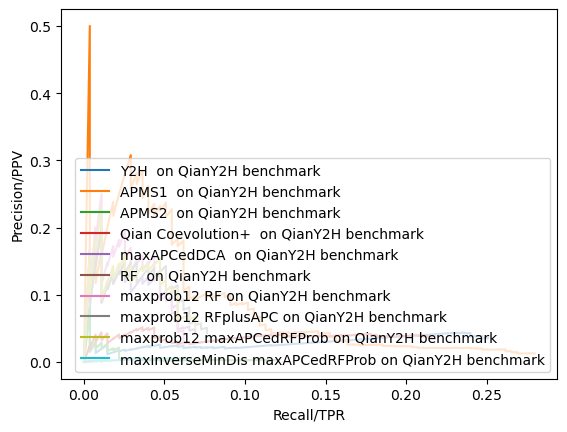

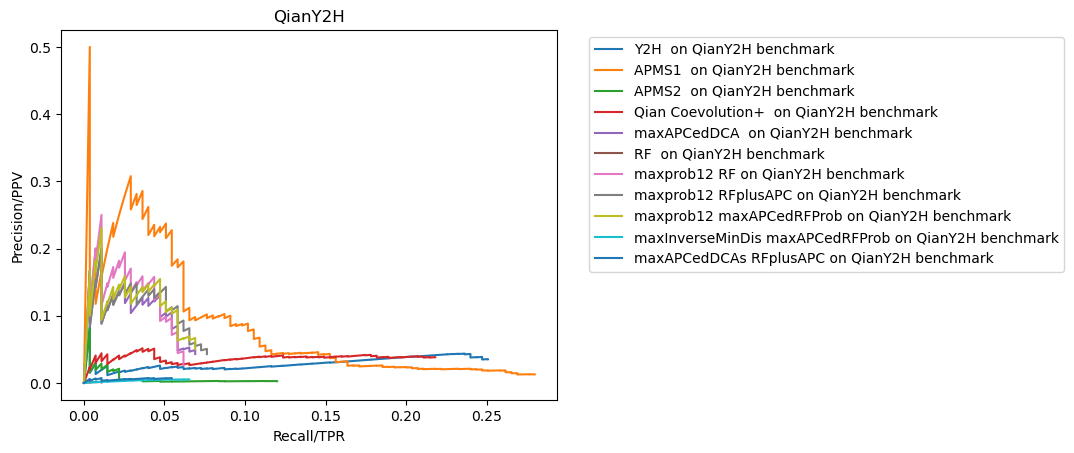

********************************************
Y2H  on QianAPMS benchmark:postiveControlCount:1236;allPredCount:1955;
Final F1, precision, recall,TP:  0.015 0.0123 0.0194 24.0
When achieve max F1, precision, recall,TP:  0.0166 0.015 0.0186 23.0
APMS1  on QianAPMS benchmark:postiveControlCount:1236;allPredCount:5993;
Final F1, precision, recall,TP:  0.0072 0.0043 0.021 26.0
When achieve max F1, precision, recall,TP:  0.0136 0.0128 0.0146 18.0
APMS2  on QianAPMS benchmark:postiveControlCount:1236;allPredCount:12801;
Final F1, precision, recall,TP:  0.0346 0.019 0.1966 243.0
When achieve max F1, precision, recall,TP:  0.0738 0.1155 0.0542 67.0
Qian Coevolution+  on QianAPMS benchmark:postiveControlCount:1236;allPredCount:1566;
Final F1, precision, recall,TP:  0.2078 0.1859 0.2354 291.0
When achieve max F1, precision, recall,TP:  0.2087 0.1879 0.2346 290.0
maxAPCedDCA  on QianAPMS benchmark:postiveControlCount:1236;allPredCount:443;
Final F1, precision, recall,TP:  0.087 0.1652 0.0591 73.0
W

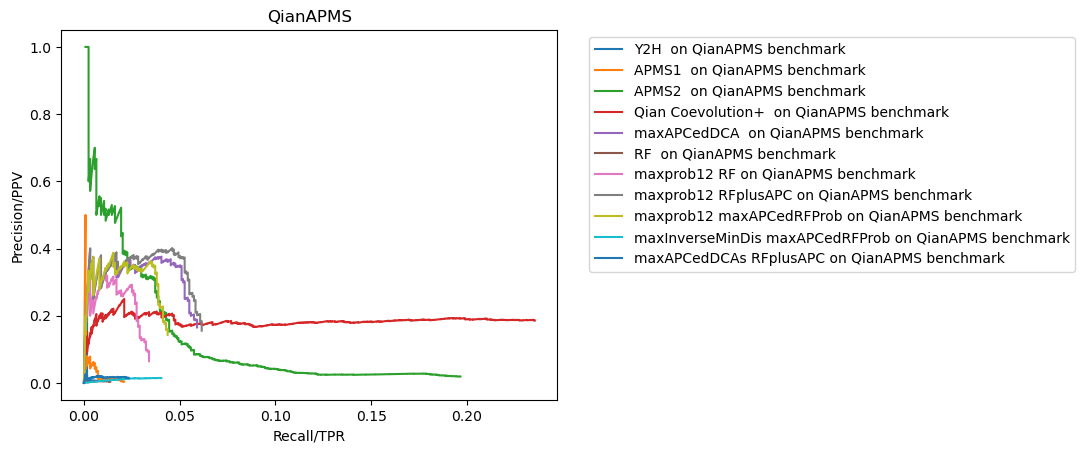

********************************************
Y2H  on QianECOCYC benchmark:postiveControlCount:892;allPredCount:1955;
Final F1, precision, recall,TP:  0.045 0.0328 0.0717 64.0
When achieve max F1, precision, recall,TP:  0.0479 0.0379 0.065 58.0
APMS1  on QianECOCYC benchmark:postiveControlCount:892;allPredCount:5993;
Final F1, precision, recall,TP:  0.0279 0.016 0.1076 96.0
When achieve max F1, precision, recall,TP:  0.072 0.0692 0.0751 67.0
APMS2  on QianECOCYC benchmark:postiveControlCount:892;allPredCount:12801;
Final F1, precision, recall,TP:  0.0259 0.0138 0.1984 177.0
When achieve max F1, precision, recall,TP:  0.0844 0.1959 0.0538 48.0
Qian Coevolution+  on QianECOCYC benchmark:postiveControlCount:892;allPredCount:1566;
Final F1, precision, recall,TP:  0.2393 0.1879 0.3296 294.0
When achieve max F1, precision, recall,TP:  0.2415 0.1905 0.3296 294.0
maxAPCedDCA  on QianECOCYC benchmark:postiveControlCount:892;allPredCount:443;
Final F1, precision, recall,TP:  0.1274 0.1923 0.0953 

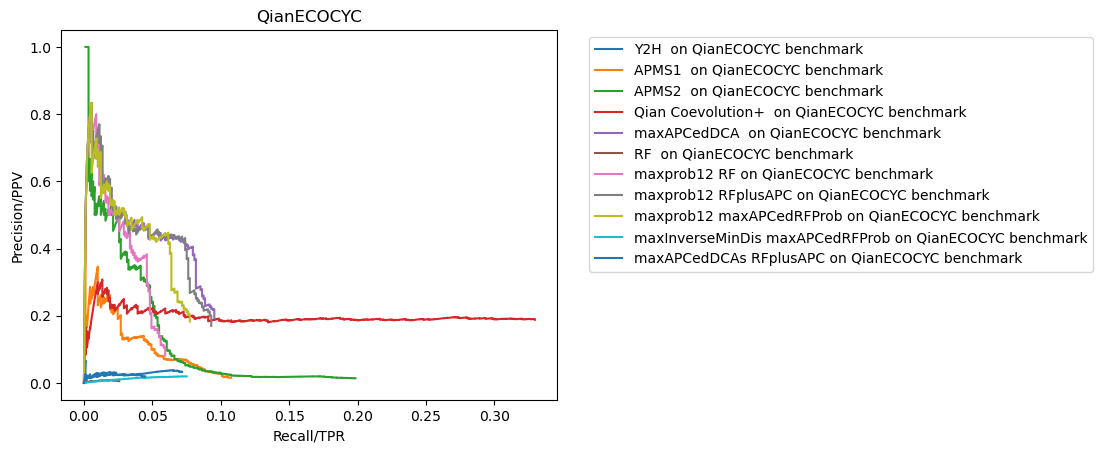

********************************************
Y2H  on QianPDB benchmark:postiveControlCount:765;allPredCount:1955;
Final F1, precision, recall,TP:  0.0382 0.0266 0.068 52.0
When achieve max F1, precision, recall,TP:  0.0418 0.0314 0.0627 48.0
APMS1  on QianPDB benchmark:postiveControlCount:765;allPredCount:5993;
Final F1, precision, recall,TP:  0.0237 0.0134 0.1046 80.0
When achieve max F1, precision, recall,TP:  0.0558 0.0479 0.0667 51.0
APMS2  on QianPDB benchmark:postiveControlCount:765;allPredCount:12801;
Final F1, precision, recall,TP:  0.0094 0.005 0.0837 64.0
When achieve max F1, precision, recall,TP:  0.017 0.0307 0.0118 9.0
Qian Coevolution+  on QianPDB benchmark:postiveControlCount:765;allPredCount:1566;
Final F1, precision, recall,TP:  0.1459 0.1086 0.2222 170.0
When achieve max F1, precision, recall,TP:  0.1482 0.1115 0.2209 169.0
maxAPCedDCA  on QianPDB benchmark:postiveControlCount:765;allPredCount:443;
Final F1, precision, recall,TP:  0.1342 0.1833 0.1059 81.0
When achiev

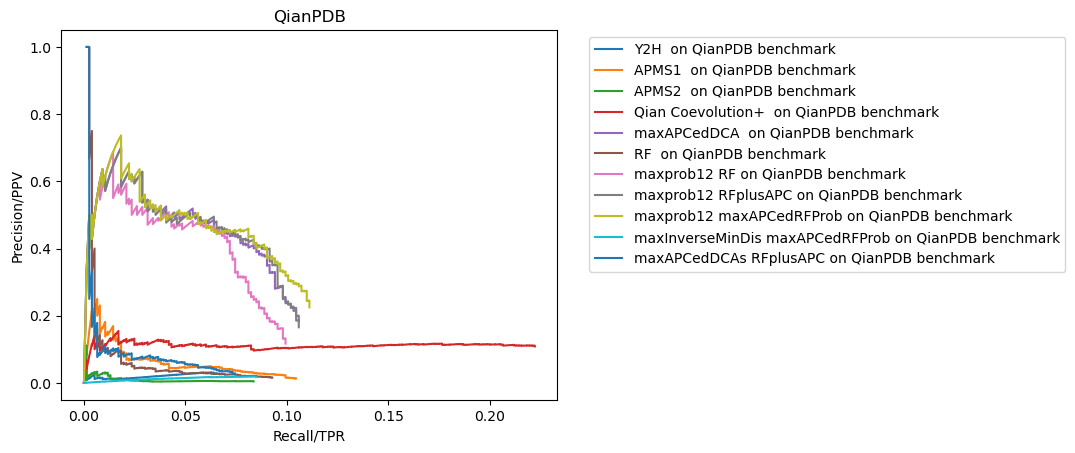

********************************************
Y2H  on pdb_complex benchmark:postiveControlCount:3243;allPredCount:1955;
Final F1, precision, recall,TP:  0.005 0.0067 0.004 13.0
When achieve max F1, precision, recall,TP:  0.0053 0.0079 0.004 13.0
APMS1  on pdb_complex benchmark:postiveControlCount:3243;allPredCount:5993;
Final F1, precision, recall,TP:  0.0273 0.021 0.0389 126.0
When achieve max F1, precision, recall,TP:  0.0274 0.023 0.0339 110.0
APMS2  on pdb_complex benchmark:postiveControlCount:3243;allPredCount:12801;
Final F1, precision, recall,TP:  0.0012 0.0008 0.0031 10.0
When achieve max F1, precision, recall,TP:  0.0015 0.0011 0.0025 8.0
Qian Coevolution+  on pdb_complex benchmark:postiveControlCount:3243;allPredCount:1566;
Final F1, precision, recall,TP:  0.0503 0.0773 0.0373 121.0
When achieve max F1, precision, recall,TP:  0.0507 0.0791 0.0373 121.0
maxAPCedDCA  on pdb_complex benchmark:postiveControlCount:3243;allPredCount:443;
Final F1, precision, recall,TP:  0.0027 0.011

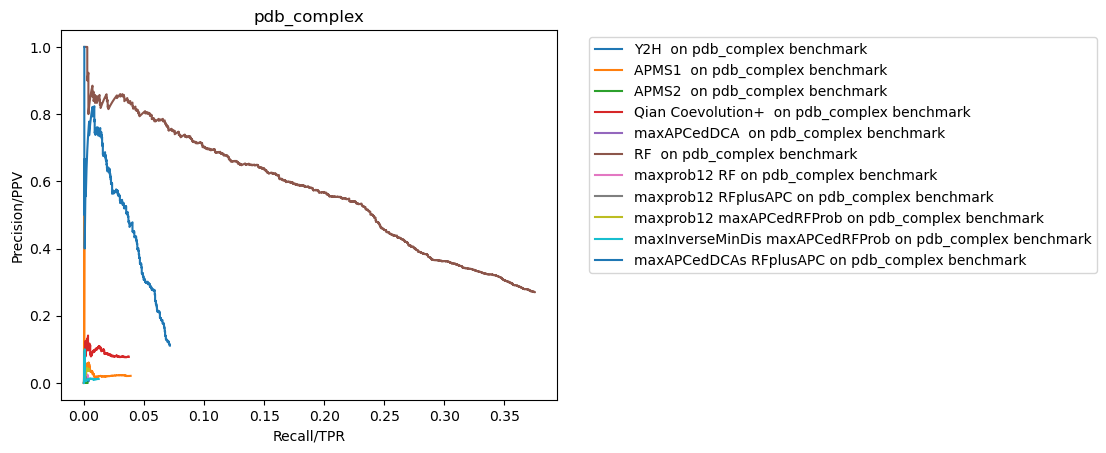

********************************************
Y2H  on KEGG benchmark:postiveControlCount:28914;allPredCount:1955;
Final F1, precision, recall,TP:  0.0054 0.043 0.0029 84.0
When achieve max F1, precision, recall,TP:  0.0055 0.0454 0.0029 84.0
APMS1  on KEGG benchmark:postiveControlCount:28914;allPredCount:5993;
Final F1, precision, recall,TP:  0.0107 0.031 0.0064 186.0
When achieve max F1, precision, recall,TP:  0.0107 0.031 0.0064 186.0
APMS2  on KEGG benchmark:postiveControlCount:28914;allPredCount:12801;
Final F1, precision, recall,TP:  0.0233 0.038 0.0168 486.0
When achieve max F1, precision, recall,TP:  0.0234 0.0382 0.0168 486.0
Qian Coevolution+  on KEGG benchmark:postiveControlCount:28914;allPredCount:1566;
Final F1, precision, recall,TP:  0.0258 0.2511 0.0136 393.0
When achieve max F1, precision, recall,TP:  0.0258 0.2513 0.0136 393.0
maxAPCedDCA  on KEGG benchmark:postiveControlCount:28914;allPredCount:443;
Final F1, precision, recall,TP:  0.0074 0.2443 0.0037 108.0
When achiev

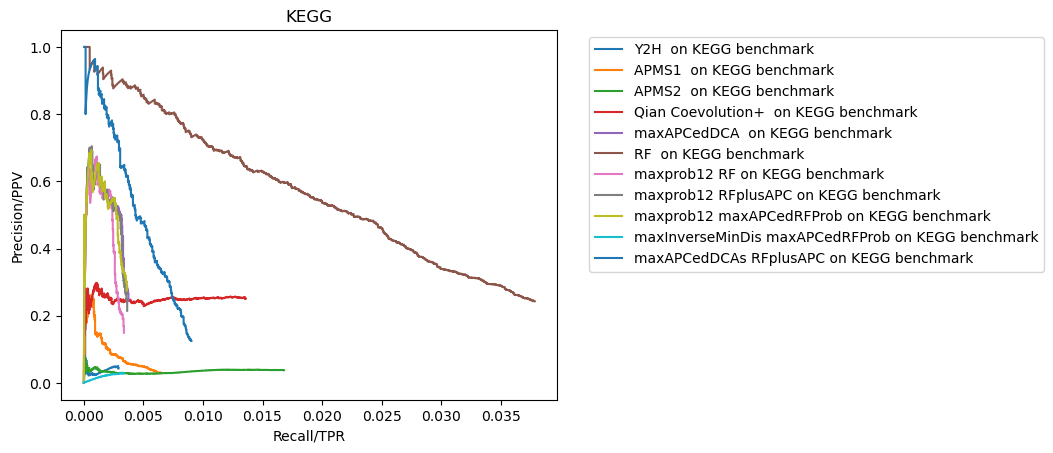

CPU times: user 5.71 s, sys: 1.18 s, total: 6.9 s
Wall time: 5.43 s


In [330]:
%%time
step=1
zoom_thres=None
filter_thres=None#0.9 # 0.9 is best seem ?, 0.85 similar but worse, 0.8 is also okay
print_results=True

# one thing to notice here is that BestF1 doesnt neceeary show best TP count  !!!
# in the end , we decide a alphafold prob12 to select final TP ,

return_bestF1=True

for benchmarkLabel in experiment_benchmarkLabel:
# for benchmarkLabel in ["QianAPMS"]:
    print("********************************************")
    plt.figure()
    
    
    FinalF1,FinalPrecision,FinalRecall,FinalTP,BestF1,BestPrecision,BestRecall,BestTP=Precison_Recall_RocCurve_OnlyGetRecallAndPrecision_OnIndepedentBenchmark(Y2H_Predicted_pps_results,
                                                   Y2H_Predicted_pps,
                                                   IndepedentBenchmark_pps_dict=Qian_benchmark_PPI_dict[benchmarkLabel], 
                                                   count_label="rate",
                                                   legend=f"Y2H  on {benchmarkLabel} benchmark",
                                                   step=step,
                                                   zoom_thres=zoom_thres,
                                                   filter_thres=filter_thres,
                                                   print_results=print_results,    
                                                    return_bestF1=return_bestF1
                                                  )
    comparison_talle_dict[benchmarkLabel].loc["Y2H",:]=FinalTP,FinalPrecision,FinalRecall,FinalF1
    
    FinalF1,FinalPrecision,FinalRecall,FinalTP,BestF1,BestPrecision,BestRecall,BestTP=Precison_Recall_RocCurve_OnlyGetRecallAndPrecision_OnIndepedentBenchmark(APMS1_Predicted_pps_results,
                                                   APMS1_Predicted_pps,
                                                   IndepedentBenchmark_pps_dict=Qian_benchmark_PPI_dict[benchmarkLabel], 
                                                   count_label="rate",
                                                   legend=f"APMS1  on {benchmarkLabel} benchmark",
                                                   step=step,
                                                   zoom_thres=zoom_thres,
                                                   filter_thres=filter_thres,
                                                   print_results=print_results,    
                                                    return_bestF1=return_bestF1
                                                  )
    comparison_talle_dict[benchmarkLabel].loc["APMS 1",:]=FinalTP,FinalPrecision,FinalRecall,FinalF1
    
    
    FinalF1,FinalPrecision,FinalRecall,FinalTP,BestF1,BestPrecision,BestRecall,BestTP=Precison_Recall_RocCurve_OnlyGetRecallAndPrecision_OnIndepedentBenchmark(APMS2_Predicted_pps_results,
                                                   APMS2_Predicted_pps,
                                                   IndepedentBenchmark_pps_dict=Qian_benchmark_PPI_dict[benchmarkLabel], 
                                                   count_label="rate",
                                                   legend=f"APMS2  on {benchmarkLabel} benchmark",
                                                   step=step,
                                                   zoom_thres=zoom_thres,
                                                   filter_thres=filter_thres,
                                                   print_results=print_results,    
                                                    return_bestF1=return_bestF1
                                                  )
    comparison_talle_dict[benchmarkLabel].loc["APMS 2",:]=FinalTP,FinalPrecision,FinalRecall,FinalF1
    
    FinalF1,FinalPrecision,FinalRecall,FinalTP,BestF1,BestPrecision,BestRecall,BestTP=Precison_Recall_RocCurve_OnlyGetRecallAndPrecision_OnIndepedentBenchmark(Qian_Predicted_pps_results,
                                                   Qian_Predicted_pps,
                                                   IndepedentBenchmark_pps_dict=Qian_benchmark_PPI_dict[benchmarkLabel], 
                                                   count_label="rate",
                                                   legend=f"Qian Coevolution+  on {benchmarkLabel} benchmark",
                                                   step=step,
                                                   zoom_thres=zoom_thres,
                                                   filter_thres=filter_thres,
                                                   print_results=print_results,    
                                                    return_bestF1=return_bestF1
                                                  )
    comparison_talle_dict[benchmarkLabel].loc["Qian Coevolution+",:]=FinalTP,FinalPrecision,FinalRecall,FinalF1
          
    FinalF1,FinalPrecision,FinalRecall,FinalTP,BestF1,BestPrecision,BestRecall,BestTP=Precison_Recall_RocCurve_OnlyGetRecallAndPrecision_OnIndepedentBenchmark(Subject_maxAPCedDCAs_interprotein_maxprob12_results,
                                                   Subject_maxAPCedDCAs_interprotein_maxprob12_PPs,
                                                   IndepedentBenchmark_pps_dict=Qian_benchmark_PPI_dict[benchmarkLabel], 
                                                   count_label="rate",
                                                   legend=f"maxAPCedDCA  on {benchmarkLabel} benchmark",
                                                   step=step,
                                                   zoom_thres=zoom_thres,
                                                   filter_thres=filter_thres,
                                                   print_results=print_results,    
                                                    return_bestF1=return_bestF1
                                                  )
    #comparison_talle_dict[benchmarkLabel].loc["AlphafoldFrommaxAPCedDCA",:]=BestTP,BestPrecision,BestRecall,BestF1
    comparison_talle_dict[benchmarkLabel].loc["AlphafoldFrommaxAPCedDCA",:]=FinalTP,FinalPrecision,FinalRecall,FinalF1
    print("####### maxAPCedDCAs not in training but in this benchmark: ",sum([1 for pp in Subject_maxAPCedDCAs_interprotein_maxprob12_PPs if (pp not in  STRINGFullPhyBalancePhyla_BestHomologousDCAs_top5DCAs_predicted_results_fixedNegVSposRratio_keepCombination_trainPPs) and (pp in Qian_benchmark_PPI_dict[benchmarkLabel])]) )

    
    FinalF1,FinalPrecision,FinalRecall,FinalTP,BestF1,BestPrecision,BestRecall,BestTP=Precison_Recall_RocCurve_OnlyGetRecallAndPrecision_OnIndepedentBenchmark(STRINGFullPhyBalancePhyla_BestHomologousDCAs_top5DCAs_RF_pos_results,
                                                   STRINGFullPhyBalancePhyla_BestHomologousDCAs_top5DCAs_RF_pos_PPs,
                                                   IndepedentBenchmark_pps_dict=Qian_benchmark_PPI_dict[benchmarkLabel], 
                                                   count_label="rate",
                                                   legend=f"RF  on {benchmarkLabel} benchmark",
                                                   step=step,
                                                   zoom_thres=zoom_thres,
                                                   filter_thres=filter_thres,
                                                   print_results=print_results,    
                                                    return_bestF1=return_bestF1
                                                  )
    #comparison_talle_dict[benchmarkLabel].loc["AlphafoldFrommaxAPCedDCA",:]=BestTP,BestPrecision,BestRecall,BestF1
    comparison_talle_dict[benchmarkLabel].loc["RF",:]=FinalTP,FinalPrecision,FinalRecall,FinalF1
    print("####### maxAPCedDCAs not in training but in this benchmark: ",sum([1 for pp in STRINGFullPhyBalancePhyla_BestHomologousDCAs_top5DCAs_RF_pos_PPs if (pp not in  STRINGFullPhyBalancePhyla_BestHomologousDCAs_top5DCAs_predicted_results_fixedNegVSposRratio_keepCombination_trainPPs) and (pp in Qian_benchmark_PPI_dict[benchmarkLabel])]) )

          

    
    FinalF1,FinalPrecision,FinalRecall,FinalTP,BestF1,BestPrecision,BestRecall,BestTP=Precison_Recall_RocCurve_OnlyGetRecallAndPrecision_OnIndepedentBenchmark(STRINGFullPhyBalancePhyla_BestHomologousDCAs_top5DCAs_RF_interprotein_maxprob12_results,
                                                   STRINGFullPhyBalancePhyla_BestHomologousDCAs_top5DCAs_RF_interprotein_maxprob12_PPs,
                                                   IndepedentBenchmark_pps_dict=
                                                   Qian_benchmark_PPI_dict[benchmarkLabel], 
                                                   count_label="rate",
                                                   legend=f"maxprob12 RF on {benchmarkLabel} benchmark",
                                                   step=step,
                                                   zoom_thres=zoom_thres,
                                                filter_thres=filter_thres,
                                                   print_results=print_results,   
                                                   return_bestF1=return_bestF1
                                                  )
    #comparison_talle_dict[benchmarkLabel].loc["AlphafoldFromRF",:]=BestTP,BestPrecision,BestRecall,BestF1
    comparison_talle_dict[benchmarkLabel].loc["AlphafoldFromRF",:]=FinalTP,FinalPrecision,FinalRecall,FinalF1
    print("####### RF not in training but in this benchmark: ",sum([1 for pp in STRINGFullPhyBalancePhyla_BestHomologousDCAs_top5DCAs_RF_interprotein_maxprob12_PPs if (pp not in  STRINGFullPhyBalancePhyla_BestHomologousDCAs_top5DCAs_predicted_results_fixedNegVSposRratio_keepCombination_trainPPs) and (pp in Qian_benchmark_PPI_dict[benchmarkLabel])]) )

    
    FinalF1,FinalPrecision,FinalRecall,FinalTP,BestF1,BestPrecision,BestRecall,BestTP=Precison_Recall_RocCurve_OnlyGetRecallAndPrecision_OnIndepedentBenchmark(STRINGFullPhyBalancePhyla_BestHomologousDCAs_top5DCAs_RFplusAPC_interprotein_maxprob12_results,
                                                   STRINGFullPhyBalancePhyla_BestHomologousDCAs_top5DCAs_RFplusAPC_interprotein_maxprob12_PPs,
                                                   IndepedentBenchmark_pps_dict=
                                                   Qian_benchmark_PPI_dict[benchmarkLabel], 
                                                   count_label="rate",
                                                   legend=f"maxprob12 RFplusAPC on {benchmarkLabel} benchmark",
                                                   step=step,
                                                   zoom_thres=zoom_thres,
                                                filter_thres=filter_thres,
                                                   print_results=print_results,   
                                                   return_bestF1=return_bestF1
                                                  )
    comparison_talle_dict[benchmarkLabel].loc["AlphafoldFromRFplusAPC",:]=FinalTP,FinalPrecision,FinalRecall,FinalF1
    print("####### RFplusAPC not in training but in this benchmark: ",sum([1 for pp in STRINGFullPhyBalancePhyla_BestHomologousDCAs_top5DCAs_RFplusAPC_interprotein_maxprob12_PPs if (pp not in  STRINGFullPhyBalancePhyla_BestHomologousDCAs_top5DCAs_predicted_results_fixedNegVSposRratio_keepCombination_trainPPs) and (pp in Qian_benchmark_PPI_dict[benchmarkLabel])]) )

    

    FinalF1,FinalPrecision,FinalRecall,FinalTP,BestF1,BestPrecision,BestRecall,BestTP=Precison_Recall_RocCurve_OnlyGetRecallAndPrecision_OnIndepedentBenchmark(STRINGFullPhyBalancePhyla_BestHomologousDCAs_top5DCAs_maxAPCedRFProb_interprotein_maxprob12_results,
                                                   STRINGFullPhyBalancePhyla_BestHomologousDCAs_top5DCAs_maxAPCedRFProb_interprotein_maxprob12_PPs,
                                                   IndepedentBenchmark_pps_dict=
                                                   Qian_benchmark_PPI_dict[benchmarkLabel], 
                                                   count_label="rate",
                                                   legend=f"maxprob12 maxAPCedRFProb on {benchmarkLabel} benchmark",
                                                   step=step,
                                                   zoom_thres=zoom_thres,
                                                filter_thres=filter_thres,
                                                   print_results=print_results,   
                                                   return_bestF1=return_bestF1
                                                  )
    comparison_talle_dict[benchmarkLabel].loc["AlphafoldFromAPCedRFProb",:]=FinalTP,FinalPrecision,FinalRecall,FinalF1
    print("####### maxAPCedRFProb not in training but in this benchmark: ",sum([1 for pp in STRINGFullPhyBalancePhyla_BestHomologousDCAs_top5DCAs_maxAPCedRFProb_interprotein_maxprob12_PPs if (pp not in  STRINGFullPhyBalancePhyla_BestHomologousDCAs_top5DCAs_predicted_results_fixedNegVSposRratio_keepCombination_trainPPs) and (pp in Qian_benchmark_PPI_dict[benchmarkLabel])]) )


    
    FinalF1,FinalPrecision,FinalRecall,FinalTP,BestF1,BestPrecision,BestRecall,BestTP=Precison_Recall_RocCurve_OnlyGetRecallAndPrecision_OnIndepedentBenchmark(STRINGFullPhyBalancePhyla_BestHomologousDCAs_top5DCAs_maxAPCedRFProb_interprotein_maxInverseMinDis_results,
                                                   STRINGFullPhyBalancePhyla_BestHomologousDCAs_top5DCAs_maxAPCedRFProb_interprotein_maxInverseMinDis_PPs,
                                                   IndepedentBenchmark_pps_dict=
                                                   Qian_benchmark_PPI_dict[benchmarkLabel], 
                                                   count_label="rate",
                                                   legend=f"maxInverseMinDis maxAPCedRFProb on {benchmarkLabel} benchmark",
                                                   step=step,
                                                   zoom_thres=zoom_thres,
                                                filter_thres=filter_thres,
                                                   print_results=print_results,   
                                                   return_bestF1=return_bestF1
                                                  )
    comparison_talle_dict[benchmarkLabel].loc["maxInverseMinDis AlphafoldFromAPCedRFProb",:]=FinalTP,FinalPrecision,FinalRecall,FinalF1
    print("####### maxInverseMinDis maxAPCedRFProb not in training but in this benchmark: ",sum([1 for pp in STRINGFullPhyBalancePhyla_BestHomologousDCAs_top5DCAs_maxAPCedRFProb_interprotein_maxprob12_PPs if (pp not in  STRINGFullPhyBalancePhyla_BestHomologousDCAs_top5DCAs_predicted_results_fixedNegVSposRratio_keepCombination_trainPPs) and (pp in Qian_benchmark_PPI_dict[benchmarkLabel])]) )


    FinalF1,FinalPrecision,FinalRecall,FinalTP,BestF1,BestPrecision,BestRecall,BestTP=Precison_Recall_RocCurve_OnlyGetRecallAndPrecision_OnIndepedentBenchmark(STRINGFullPhyBalancePhyla_BestHomologousDCAs_top5DCAs_RFplusAPC_maxAPCedDCAs_pos_results,
                                                   STRINGFullPhyBalancePhyla_BestHomologousDCAs_top5DCAs_RFplusAPC_maxAPCedDCAs_pos_PPs,
                                                   IndepedentBenchmark_pps_dict=
                                                   Qian_benchmark_PPI_dict[benchmarkLabel], 
                                                   count_label="rate",
                                                   legend=f"maxAPCedDCAs RFplusAPC on {benchmarkLabel} benchmark",
                                                   step=step,
                                                   zoom_thres=zoom_thres,
                                                filter_thres=filter_thres,
                                                   print_results=print_results,   
                                                   return_bestF1=return_bestF1
                                                  )
    comparison_talle_dict[benchmarkLabel].loc["maxAPCedDCAsFromRFplusAPC",:]=FinalTP,FinalPrecision,FinalRecall,FinalF1
    print("####### RFplusAPC not in training but in this benchmark: ",sum([1 for pp in STRINGFullPhyBalancePhyla_BestHomologousDCAs_top5DCAs_RFplusAPC_maxAPCedDCAs_pos_PPs if (pp not in  STRINGFullPhyBalancePhyla_BestHomologousDCAs_top5DCAs_predicted_results_fixedNegVSposRratio_keepCombination_trainPPs) and (pp in Qian_benchmark_PPI_dict[benchmarkLabel])]) )



    # plt.legend(  loc='upper right' )
    plt.title(benchmarkLabel)
    plt.legend( bbox_to_anchor=(1.05, 1), loc='upper left' )
    plt.show()


    # when step=10, zoom_thres=30000, take around 2 mins , each 
    # when step=10, zoom_thres=30000, in total takes around  14min 50s 
                                               

In [312]:
# comparison_talle_dict["QianY2H"] = comparison_talle_dict["QianY2H"]=({"TP":int,"Pre":float,"Rec":float,"F-score":float,})


In [313]:
# ********************************************
# maxDCAofAllPhylum on QianECOCYC benchmark:postiveControlCount:892;allPredCount:13268;finalTPCount:64.0;finalTPRate:0.0717;
# When achieve max F1, precision, recall,TP:  0.0923 0.4381 0.0516 46.0
# maxDCAofAllPhylum not in training but in this benchmark:  13
# maxprob12 LR on QianECOCYC benchmark:postiveControlCount:892;allPredCount:21704;finalTPCount:62.99999999999999;finalTPRate:0.0706;
# When achieve max F1, precision, recall,TP:  0.0822 0.3868 0.046 41.0
# LR not in training but in this benchmark:  10
# maxprob12 RF on QianECOCYC benchmark:postiveControlCount:892;allPredCount:23984;finalTPCount:338.0;finalTPRate:0.3789;
# When achieve max F1, precision, recall,TP:  0.2343 0.4273 0.1614 144.0
# RF not in training but in this benchmark:  9

# ********************************************
# maxDCAofAllPhylum on QianPDB benchmark:postiveControlCount:765;allPredCount:13268;finalTPCount:97.99999999999999;finalTPRate:0.1281;
# When achieve max F1, precision, recall,TP:  0.1335 0.352 0.0824 63.0
# maxDCAofAllPhylum not in training but in this benchmark:  19
# maxprob12 LR on QianPDB benchmark:postiveControlCount:765;allPredCount:21704;finalTPCount:92.0;finalTPRate:0.1203;
# When achieve max F1, precision, recall,TP:  0.1225 0.3187 0.0758 58.0
# LR not in training but in this benchmark:  17
# maxprob12 RF on QianPDB benchmark:postiveControlCount:765;allPredCount:23984;finalTPCount:222.00000000000003;finalTPRate:0.2902;
# When achieve max F1, precision, recall,TP:  0.1871 0.2407 0.1529 117.0
# RF not in training but in this benchmark:  23

#### save table

save results to coparisoin with other /Users/taof/Documents/PhD_Tao/conference/presentations/experiments.numbers


In [331]:
comparison_talle_dict.keys()

dict_keys(['QianY2H', 'QianAPMS', 'QianECOCYC', 'QianPDB', 'pdb_complex', 'KEGG'])

In [332]:
comparison_talle_dict["QianY2H"].style.format({
    'TP': '{:,.0f}'.format,
    'Pre': '{:,.3f}'.format,
    'Rec': '{:,.3f}'.format,
    'F-score': '{:,.3f}'.format,
    # 'Pre': '{:,.2%}'.format,
    # 'Rec': '{:,.2%}'.format,
    # 'F-score': '{:,.2%}'.format,
})

In [333]:
comparison_talle_dict["QianAPMS"].style.format({
    'TP': '{:,.0f}'.format,
    'Pre': '{:,.3f}'.format,
    'Rec': '{:,.3f}'.format,
    'F-score': '{:,.3f}'.format,
})

In [334]:
comparison_talle_dict["QianECOCYC"].style.format({
    'TP': '{:,.0f}'.format,
    'Pre': '{:,.3f}'.format,
    'Rec': '{:,.3f}'.format,
    'F-score': '{:,.3f}'.format,
})

In [335]:
comparison_talle_dict["QianPDB"].style.format({
    'TP': '{:,.0f}'.format,
    'Pre': '{:,.3f}'.format,
    'Rec': '{:,.3f}'.format,
    'F-score': '{:,.3f}'.format,
})

In [336]:
comparison_talle_dict["pdb_complex"].style.format({
    'TP': '{:,.0f}'.format,
    'Pre': '{:,.3f}'.format,
    'Rec': '{:,.3f}'.format,
    'F-score': '{:,.3f}'.format,
})

In [337]:
comparison_talle_dict["KEGG"].style.format({
    'TP': '{:,.0f}'.format,
    'Pre': '{:,.3f}'.format,
    'Rec': '{:,.3f}'.format,
    'F-score': '{:,.3f}'.format,
})

In [321]:
show % by in Numbers app?
https://support.apple.com/zh-cn/guide/numbers/tan23393f3a/mac
https://www.youtube.com/watch?v=x4PZbRp_K3k

SyntaxError: invalid syntax (<ipython-input-321-4c7e5535c59c>, line 2)

In [ ]:
also print  results after a fix selection 
instead of show best F1, results 

add ppi level apc for alphafold results 

and try to solve overfitting problem from RF model if i can ?

##### for alphafold results, its recall is low becase we onyl computer few tops to save computation resourece 
here could use results  after phylum  integration resutsl on these benchmark to  check potentially max recall we cant get ?
script to do this 

# valide predicted direct PPI
/code/MNF/notebooks/test_alphafold/identifyNovelPPI_PPIandComplex_visulisation.ipynb

# valide predicted core complex

In [ ]:
import networkx as nx 

In [ ]:
print(len(STRINGFullPhyBalancePhyla_BestHomologousDCAs_top5DCAs_RF_pos_PPs))
print(len(STRINGFullPhyBalancePhyla_BestHomologousDCAs_top5DCAs_RF_pos_results))

In [ ]:
STRINGFullPhyBalancePhyla_BestHomologousDCAs_top5DCAs_RF_pos_PPs[0:3]

In [ ]:
Ecoli_stringAll_PPs=[k for k, v in Ecoli_string_score_dict.items()]
print(len(Ecoli_stringAll_PPs))

# Ecoli_string_PPs=[k for k, v in Ecoli_string_score_dict.items() if v > 900]
Ecoli_string_PPs=[k for k, v in Ecoli_string_score_dict.items() if v > 500]
print(len(Ecoli_string_PPs))


Ecoli_stringPhy_PPs=[pp for pp in STRINGcurrentSpePhyPPI_posPPI_dict.keys()]
print(len(Ecoli_stringPhy_PPs))



Ecoli_stringAllPhy_PPs=[pp for pp in STRINGcurrentSpeAllPhyPPI_posPPI_dict.keys()]
print(len(Ecoli_stringAllPhy_PPs))

In [ ]:
%%time
print(len(Ecoli_stringPhy_PPs))


rf_prob_thres=0.9#0.4 0.8
return_FixNum=None#None #15000
validate_STRINGFullPhyBalancePhyla_BestHomologousDCAs_top5DCAs_RF_pos_PPs=FixNum_of_topResults(STRINGFullPhyBalancePhyla_BestHomologousDCAs_top5DCAs_RF_results,
                                                     Subject_BestHomologousDCAs_top5DCAs_PPs,
                                                     prob_thres=rf_prob_thres,return_FixNum=return_FixNum)

print(len(validate_STRINGFullPhyBalancePhyla_BestHomologousDCAs_top5DCAs_RF_pos_PPs))


In [ ]:
# %%time
# check_PPIDist_inGraph(PPI_list=STRINGFullPhyBalancePhyla_BestHomologousDCAs_top5DCAs_RF_pos_PPs,
#                       graph_PPList=Ecoli_stringPhy_PPs)

In [ ]:
# %%time
# check_PPIDist_inGraph(PPI_list=STRINGFullPhyBalancePhyla_BestHomologousDCAs_top5DCAs_RF_pos_PPs,
#                       graph_PPList=Ecoli_stringAllPhy_PPs)
# plt.show()

In [ ]:
# len(STRINGFullPhyBalancePhyla_BestHomologousDCAs_top5DCAs_RF_interprotein_maxprob12_dict)

In [ ]:
# %%time
# check_PPIDist_inGraph(PPI_list=[pp for pp in STRINGFullPhyBalancePhyla_BestHomologousDCAs_top5DCAs_RF_interprotein_maxprob12_dict.keys()],
#                       graph_PPList=Ecoli_stringAllPhy_PPs,)

In [ ]:
# %%time
# check_PPIDist_inGraph(PPI_list=[pp for pp in STRINGFullPhyBalancePhyla_BestHomologousDCAs_top5DCAs_RF_interprotein_maxprob12_dict.keys()],
#                       graph_PPList=Ecoli_stringAllPhy_PPs,
#                      AF_maxprob12_dict=STRINGFullPhyBalancePhyla_BestHomologousDCAs_top5DCAs_RF_interprotein_maxprob12_dict,
#                       upSel=True,
#                      maxprob12_thres=0.9)

In [ ]:
# %%time
# print(len(Ecoli_stringAllPhy_PPs,))
# check_PPIDist_inGraph(PPI_list=[pp for pp in STRINGFullPhyBalancePhyla_BestHomologousDCAs_top5DCAs_RF_interprotein_maxprob12_dict.keys()],
#                       graph_PPList=Ecoli_stringAllPhy_PPs,
#                      AF_maxprob12_dict=STRINGFullPhyBalancePhyla_BestHomologousDCAs_top5DCAs_RF_interprotein_maxprob12_dict,
#                       upSel=False,
#                      maxprob12_thres=1,
#                      )
# plt.show()

In [ ]:
%%time
print(len(Ecoli_stringAll_PPs,))

check_PPIDist_inGraph(PPI_list=validate_STRINGFullPhyBalancePhyla_BestHomologousDCAs_top5DCAs_RF_pos_PPs,
                      graph_PPList=Ecoli_stringAll_PPs,
                     AF_maxprob12_dict=STRINGFullPhyBalancePhyla_BestHomologousDCAs_top5DCAs_RF_interprotein_maxprob12_dict,
                      upSel=False,
                     maxprob12_thres=10)
plt.show()

In [ ]:
%%time
print(len(Ecoli_string_PPs,))

check_PPIDist_inGraph(PPI_list=validate_STRINGFullPhyBalancePhyla_BestHomologousDCAs_top5DCAs_RF_pos_PPs,
                      graph_PPList=Ecoli_string_PPs,
                     AF_maxprob12_dict=STRINGFullPhyBalancePhyla_BestHomologousDCAs_top5DCAs_RF_interprotein_maxprob12_dict,
                      upSel=False,
                     maxprob12_thres=10)
plt.show()

In [ ]:
%%time
print(len(Ecoli_stringAllPhy_PPs,))


# rf_prob_thres=0.9#0.4 0.8
# return_FixNum=None#None #15000
# validate_STRINGFullPhyBalancePhyla_BestHomologousDCAs_top5DCAs_RF_pos_PPs=FixNum_of_topResults(STRINGFullPhyBalancePhyla_BestHomologousDCAs_top5DCAs_RF_results,
#                                                      Subject_BestHomologousDCAs_top5DCAs_PPs,
#                                                      prob_thres=rf_prob_thres,return_FixNum=return_FixNum)

# print(len(validate_STRINGFullPhyBalancePhyla_BestHomologousDCAs_top5DCAs_RF_pos_PPs))

check_PPIDist_inGraph(PPI_list=validate_STRINGFullPhyBalancePhyla_BestHomologousDCAs_top5DCAs_RF_pos_PPs,
                      graph_PPList=Ecoli_stringAllPhy_PPs,
                     AF_maxprob12_dict=STRINGFullPhyBalancePhyla_BestHomologousDCAs_top5DCAs_RF_interprotein_maxprob12_dict,
                      upSel=False,
                     maxprob12_thres=10)
plt.show()

In [ ]:
# %%time
# check_PPIDist_inGraph(PPI_list=[pp for pp in STRINGFullPhyBalancePhyla_BestHomologousDCAs_top5DCAs_RF_interprotein_maxprob12_dict.keys()],
#                       graph_PPList=Ecoli_stringPhy_PPs,
#                      AF_maxprob12_dict=STRINGFullPhyBalancePhyla_BestHomologousDCAs_top5DCAs_RF_interprotein_maxprob12_dict,
#                       upSel=True,
#                      maxprob12_thres=0)

In [ ]:
max(STRINGFullPhyBalancePhyla_BestHomologousDCAs_top5DCAs_RF_interprotein_maxprob12_dict.values())

In [ ]:
# %%time
# print(len(Ecoli_stringPhy_PPs))
# check_PPIDist_inGraph(PPI_list=[pp for pp in STRINGFullPhyBalancePhyla_BestHomologousDCAs_top5DCAs_RF_interprotein_maxprob12_dict.keys()],
#                       graph_PPList=Ecoli_stringPhy_PPs,
#                      AF_maxprob12_dict=STRINGFullPhyBalancePhyla_BestHomologousDCAs_top5DCAs_RF_interprotein_maxprob12_dict,
#                       upSel=False,
#                      maxprob12_thres=10)

In [ ]:
%%time


check_PPIDist_inGraph(PPI_list=validate_STRINGFullPhyBalancePhyla_BestHomologousDCAs_top5DCAs_RF_pos_PPs,
                      graph_PPList=Ecoli_stringPhy_PPs,
                     AF_maxprob12_dict=STRINGFullPhyBalancePhyla_BestHomologousDCAs_top5DCAs_RF_interprotein_maxprob12_dict,
                      upSel=False,
                     maxprob12_thres=10)

## figure 4

In [ ]:
%%time
print(len(Ecoli_stringPhy_PPs))


rf_prob_thres=0.9#0.4 0.8
return_FixNum=None#None #15000
validate_STRINGFullPhyBalancePhyla_BestHomologousDCAs_top5DCAs_RF_pos_PPs=FixNum_of_topResults(STRINGFullPhyBalancePhyla_BestHomologousDCAs_top5DCAs_RF_results,
                                                     Subject_BestHomologousDCAs_top5DCAs_PPs,
                                                     prob_thres=rf_prob_thres,return_FixNum=return_FixNum)

print(len(validate_STRINGFullPhyBalancePhyla_BestHomologousDCAs_top5DCAs_RF_pos_PPs))



# %time

fig4 = plt.figure(figsize=(6,6))

check_PPIDist_inGraph(PPI_list=validate_STRINGFullPhyBalancePhyla_BestHomologousDCAs_top5DCAs_RF_pos_PPs,
                      graph_PPList=Ecoli_stringPhy_PPs,
                     AF_maxprob12_dict=STRINGFullPhyBalancePhyla_BestHomologousDCAs_top5DCAs_RF_interprotein_maxprob12_dict,
                      color1="gray",color2="#d73027",
                      upSel=False,
                     maxprob12_thres=10)

# ax1.legend().set_visible(False)
plt.xlabel("PP distance",fontsize=16)
plt.ylabel("Frequency",fontsize=16)
# plt.title("Maped predicted PPs from Top20DCAsWithIntegration RF to STRING phyiscal network",loc='center',fontsize=16)
# add this to figure description 
plt.legend(fontsize=12,
           # loc="upper right",
           # loc='center left', bbox_to_anchor=(1, 0.5),
           
          )
plt.xticks(fontsize=12)# compare with ax2.set_xticks, this one dont need to give exact ticks position
plt.yticks(fontsize=12)


plt.tight_layout()
plt.show()

fig4.savefig("/mnt/mnemo5/tao/temp_figures/PhysicalPPIScreen_mapToSTRING.pdf", dpi=600)




In [ ]:
%%time
print(len(Ecoli_stringPhy_PPs))


rf_prob_thres=0.9#0.4 0.8
return_FixNum=20000#None #15000
validate_STRINGFullPhyBalancePhyla_BestHomologousDCAs_top5DCAs_RF_pos_PPs=FixNum_of_topResults(STRINGFullPhyBalancePhyla_BestHomologousDCAs_top5DCAs_RF_results,
                                                     Subject_BestHomologousDCAs_top5DCAs_PPs,
                                                     prob_thres=rf_prob_thres,return_FixNum=return_FixNum)

print(len(validate_STRINGFullPhyBalancePhyla_BestHomologousDCAs_top5DCAs_RF_pos_PPs))



# %time

fig4 = plt.figure(figsize=(6,6))

check_PPIDist_inGraph(PPI_list=validate_STRINGFullPhyBalancePhyla_BestHomologousDCAs_top5DCAs_RF_pos_PPs,
                      graph_PPList=Ecoli_stringPhy_PPs,
                     AF_maxprob12_dict=STRINGFullPhyBalancePhyla_BestHomologousDCAs_top5DCAs_RF_interprotein_maxprob12_dict,
                      color1="gray",color2="#d73027",
                      upSel=False,
                     maxprob12_thres=10)

# ax1.legend().set_visible(False)
plt.xlabel("PP distance",fontsize=16)
plt.ylabel("Frequency",fontsize=16)
# plt.title("Maped predicted PPs from Top20DCAsWithIntegration RF to STRING phyiscal network",loc='center',fontsize=16)
# add this to figure description 
plt.legend(fontsize=12,
           # loc="upper right",
           # loc='center left', bbox_to_anchor=(1, 0.5),
           
          )
plt.xticks(fontsize=12)# compare with ax2.set_xticks, this one dont need to give exact ticks position
plt.yticks(fontsize=12)


plt.tight_layout()
plt.show()

fig4.savefig("/mnt/mnemo5/tao/temp_figures/PhysicalPPIScreen_mapToSTRING.pdf", dpi=600)




In [ ]:
# %%time
# check_PPIDist_inGraph(PPI_list=[pp for pp in STRINGFullPhyBalancePhyla_BestHomologousDCAs_top5DCAs_RF_interprotein_maxprob12_dict.keys()],
#                       graph_PPList=Ecoli_string_PPs,
#                      AF_maxprob12_dict=STRINGFullPhyBalancePhyla_BestHomologousDCAs_top5DCAs_RF_interprotein_maxprob12_dict,
#                       upSel=False,
#                      maxprob12_thres=0.3)

In [ ]:
# %%time
# check_PPIDist_inGraph(PPI_list=[pp for pp in STRINGFullPhyBalancePhyla_BestHomologousDCAs_top5DCAs_RF_interprotein_maxprob12_dict.keys()],
#                       graph_PPList=[pp for pp in pdb_PPs_dict.keys()],
#                      AF_maxprob12_dict=STRINGFullPhyBalancePhyla_BestHomologousDCAs_top5DCAs_RF_interprotein_maxprob12_dict,
#                       upSel=False,
#                      maxprob12_thres=0.3)

In [ ]:
# check_PPIDist_inGraph(PPI_list=STRINGFullPhyBalancePhyla_BestHomologousDCAs_top5DCAs_RF_pos_PPs,
#                       graph_PPList=Ecoli_string_PPs)

In [ ]:
# check_PPIDist_inGraph(PPI_list=STRINGFullPhyBalancePhyla_BestHomologousDCAs_top5DCAs_RF_pos_PPs,
#                       graph_PPList=[pp for pp in pdb_PPs_dict.keys()])